# Main Model

In [243]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
from matplotlib.ticker import FuncFormatter

import scipy.stats
import scipy.optimize
from scipy.optimize import minimize, root_scalar, minimize_scalar, differential_evolution
from scipy.io import loadmat, savemat
import numpy as np
import seaborn as sns
import os
import json # deprecated
import pickle
import random
import time 

from pymatreader import read_mat

from tqdm import tqdm # to check runtime
# ----------------------------------------------------------------- #
import gurobipy as gp # New optimization approach with gurobi? 
from gurobipy import Model, GRB, quicksum

from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, value

In [86]:
# %reset

In [87]:
# os.getcwd()

In [90]:
# Paths
path_main = os.getcwd() # r'C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python'
# Directories
os.chdir(path_main)
path_inputs = os.path.join(path_main, '02 Inputs')
path_outputs = os.path.join(path_main, '03 Outputs')
path_functions = os.path.join(path_main, '04 Functions')
path_figures = os.path.join(path_main, '05 Figures')
# Added extra folder for new approach
path_cm_approach = os.path.join(path_figures, 'CM_Approach')

# Create these directories if they don't exist
os.makedirs(path_inputs, exist_ok=True)
os.makedirs(path_outputs, exist_ok=True)
os.makedirs(path_functions, exist_ok=True)
os.makedirs(path_figures, exist_ok=True)
os.makedirs(path_cm_approach, exist_ok=True) # create

os.sys.path.extend([path_inputs, path_outputs, path_functions, path_figures, path_cm_approach])

# Version + State
version = "_v33" # CI_e changed for 2nd stage only - reductions according to NREL report (mid, high, low)
state = "Texas" # Texas, California, Germany
technology = "PEM" # ALK; PEM; SOC
PTC_h_scaling = 1 # Scales the PTC vector - standard = 1.0 - no scaling
c_i_t_2_scaling = 1 # (1 - 0.75) # 64% reduction main (NREL, 2024 standard scenario) // vs 54%–75% (across all scenarios)

# Changes for changes in average prices + volatiliy changes
alpha_e = 1.0 # 1.15 # average electricity price vector change
beta_e = 1.0 # 1.15 # electricity variance change

# Relative changes in percent for version title
alpha_pct = int(round((alpha_e - 1) * 100))
beta_pct  = int(round((beta_e  - 1) * 100))

# Build version string using signed percentages
# version = f"_v33_a{alpha_pct:+}_b{beta_pct:+}" # new version with electricity sensitivities.

# Deprecated
CT_h = 1 # carbon intensity of h2 with grid connection
version

'_v33'

In [91]:
# # Load necessary variables - converted

with open(os.path.join(path_inputs, 'variables.pkl'), 'rb') as handle:
    variables = pickle.load(handle)
    
with open(os.path.join(path_inputs, 'optimized_renewables_2.pkl'), 'rb') as f: # Updated vector
    optimized_renewables = pickle.load(f)
    
    # optimized_renewables old import
    
# OLD
# with open(os.path.join(path_inputs, 'Variables.json'), 'r') as f:
#     variables = json.load(f)
    
# Think about whether we need to reconvert... Alternative via % store

# %store -r variables

# for key, value in variables.items():
#     print(f"{key}: {type(value)}")
    
# Access the specific scenario: Texas, best wind, best solar
# specific_scenario = power_data.loc[('Texas', 'median', 'median')]

# Print the combined capacity factor CF_e_t for this scenario
# print("Combined Capacity Factor (CF_e_t) for Texas, best wind, best solar scenario:")
# print(np.mean(specific_scenario['CF_e_t']))

optimized_renewables # Found CF error!
# optimized_renewables
# optimized_renewables['CF_e_t']


rho (wind proportion)  \
State      Wind Scenario Solar Scenario                          
Texas      best          best                              0.0   
                         median                            1.0   
                         worst                             1.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             1.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   
California best          best                              0.0   
                         median                            0.0   
                         worst                             0.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             0.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   
Germany    best          best                              1.0   
                         median                            1.0   
                         worst                             1.0   
           median        best                              0.0   
                         median                            0.0   
                         worst                             1.0   
           worst         best                              0.0   
                         median                            0.0   
                         worst                             0.0   

                                         solar proportion    SP_e    F_ei  \
State      Wind Scenario Solar Scenario                                     
Texas      best          best                         1.0  1133.0   5.133   
                         median                       0.0  1609.0  12.840   
                         worst                        0.0  1609.0  12.840   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        0.0  1609.0  12.840   
           worst         best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
California best          best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
           worst         best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        1.0  1133.0   5.133   
Germany    best          best                         0.0  1609.0  12.840   
                         median                       0.0  1609.0  12.840   
                         worst                        0.0  1609.0  12.840   
           median        best                         1.0  1133.0   5.133   
                         median                       1.0  1133.0   5.133   
                         worst                        0.0  1609.0  12.840   
           worst         best                         1.0  1133.0   5.133   
                         median                

# Functions

In [95]:
# Load necessary functions - Should also work using only Import as path connected

from f_parameters import f_parameters

from f_renewables import f_renewables

from f_revenues_vi import f_revenues_vi

from f_costs_vi import f_costs_vi

from f_npv_vi import f_npv_vi

from f_overview_vi import f_overview_vi 

# from f_revenues_v2 import f_revenues_v2 # New function with v_1, v_2 and v_3

# Calculate Data

In [98]:
# Enter last inputs

forecast_horizon = list(range(2023, 2024))
k_e = 1 # Always relative size of 1 kW # Add one proportion variable to loop over

rho = 0.5 # Proportion we will loop over different rhos
rho_values = np.linspace(0, 1, 11)
k_e_w = rho # Manually defined in scenarios
k_e_s = (1 - rho) # Manually defined in scenarios

k_h = [i/20 for i in range(0, 21)] # faster: [i/10 for i in range(0, 11)] #[i/20 for i in range(0, 21)]
p_h_start = -0.5 # -0.5
p_h_end = p_h_start + 4
p_h_step = 0.5 # Takes too long with 0.01, change to e.g. 0.25 / 0.1 for now

eta = [0]*len(forecast_horizon) # initialize eta as list or array:  eta = np.zeros(len(forecast_horizon))

# Set ITC and PTC but mutually exclusive -> think about other way to do that or calculate through all possibilities via second loop?

ITC_SP_e = 0
ITC_SP_h = 0
PTC = variables["PTC"] # * 0.7 # Careful, this PTC is meant for renewables! Manually levelized so we don't get negative LCOE
PTC_h = variables["PTC_h"] # 
PTC_grid = variables["PTC_grid"] # For simplicity currently manual - later link in revenue function to parameters[t] function

PTC_vector = variables["PTC_vector"] # Vectors of ptc over useful lifetime
PTC_h_vector = variables["PTC_h_vector"] 
PTC_grid_vector = variables["PTC_grid_vector"] 

# Others to potentially replace in the functions themselves
alpha = variables["alpha_f"]
alpha_PTC = variables["alpha_f"] # As not yet sure what it is needed for @GG # EXCLUDE

technology_index = {
    "ALK": 0,
    "PEM": 1,
    "SOC": 2
}

technology_index[technology]

# Select the values based on the scenario
x_h = variables["x_h"][technology_index[technology]]
eta_c = variables["eta_c"][technology_index[technology]]
F_h = variables["F_h"][technology_index[technology]]
SP_h = variables["SP_h"][technology_index[technology]]

print(eta_c)

state_variables = {
    'California': {
        'c_i_t': variables["carbon_intensity"]["CO2i_CISO_D"],
        'p_s_t': variables['p_s_t_CA'],
        'p_b_t': variables['p_b_t_CA']
    },
    'Texas': {
        'c_i_t': variables["carbon_intensity"]["CO2i_ERCO_D"],
        'p_s_t': variables['p_s_t_TX'],
        'p_b_t': variables['p_b_t_TX']
    },
    'Germany': {
        'c_i_t': variables["carbon_intensity"]["DE"],
        'p_s_t': variables['p_s_t_DE'],
        'p_b_t': variables['p_b_t_DE']
    }
}

# Retrieve variables for input 
c_i_t = state_variables[state]['c_i_t'] * 1.004149916 ### NEW: update vector to account for CO2e!! -> difference in ERCOT = 0.4% (source: EPA - egrid)
p_s_t = state_variables[state]['p_s_t'] 
p_b_t = state_variables[state]['p_b_t'] # + 10 # REMOVE AGAIN

c_i_t_2 = c_i_t * c_i_t_2_scaling # 64% reduction main (NREL, 2024 standard scenario) // vs 54%–75% (across all scenarios)

# Maximum permissable Carbon Threshold for the run - e.g. 0.45 - possibly loop over them too!

# New idea: Introduce one carbon intensity that does not punish 

carbon_intensities = [0.01, 0.45, 1.5, 2.5, 4, 10, 50, 100, 101] 
# Take 100 as "whatever-sceanrio" with offsets but no tax credit adaption
# 101 "whatever-sceanrio" but with full tax credit! (assume RECs allowed for instance) -> currently not working

# Adjusted p_b_t via high w_grid in "Variables" tab

# Try version of simply creating one "super renewable source" i.e. wind solar combination, costs simply added! @GG thoughts?
# Update: Directly take them from optimized renewables - still in for manual tests
# SP_e = (variables["SP_e_w"] * k_e_w + variables["SP_e_s"] * k_e_s) / (k_e_w + k_e_s) if k_e_w + k_e_s != 0 else 0
# F_ei = (variables["F_ei_w"] * k_e_w + variables["F_ei_s"] * k_e_s) / (k_e_w + k_e_s) if k_e_w + k_e_s != 0 else 0
# W_ei = (variables["W_ei_w"] * k_e_w + variables["W_ei_s"] * k_e_s) / (k_e_w + k_e_s) if k_e_w + k_e_s != 0 else 0
# k_e = (variables["k_e_s"] * k_e_w + variables["k_e_w"] * k_e_s) / (k_e_w + k_e_s) if k_e_w + k_e_s != 0 else 0 # Also scaled again to 1

SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
k_e = (variables["k_e_s"] * rho + variables["k_e_w"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0 #
SP_e_w = variables["SP_e_w"]
SP_e_s = variables["SP_e_s"]
w_grid = variables["w_grid"]

# Cost and Price Developments / Sensitivities # Only first value kept for now
# Distinguished growth rates between solar and wind from "CF_e"
CAGR_CF_e_w = [0, 0.007, 0.007][0]
CAGR_CF_e_s = [0, 0.007, 0.007][0]
CAGR_SP_e_w = [0, -0.04, -0.04][0]
CAGR_SP_e_s = [0, -0.04, -0.04][0]
CAGR_SP_h = [0, -0.114541136526294, -0.114541136526294][0]
CAGR_eta = [0, 0.008137587, 0.008137587][0]
CAGR_r = [0, 0, 0][0]
CAGR_p_s = [0, 0, 0][0]
CAGR_p_b = [0, 0, 0][0]
CAGR_c_i = [0, -0.03, -0.03][0] # How does the cleanness of the grid develop over the years

# Variables for t loop
T = variables["T"]
r = variables["r"]
d_i = variables["d_i"]
# x_e = variables["x_e"] # Not yet distinguished
x = x_h # For now also renewables will have electrolyzer degradation! Change in future iteration
alpha_f = variables["alpha_f"]
alpha_s = variables["alpha_s"]
m = variables["m"]
w_o = variables["w_o"]

# print(type(variables["T"]))
# print(type(variables["d_i"]))
# print(type(variables["r"]))
# print(type(variables["x"]))
# print(type(variables["alpha_f"]))
# print(type(variables["m"]))
# print(type(ITC_SP_h))
# print(type(alpha_PTC))
# print(type(PTC))
# rho_values
# p_h

c_i_t
# w_grid
c_i_t_2

0.0188545454545455


0       0.363347
1       0.322560
2       0.315307
3       0.306861
4       0.298157
          ...   
8755    0.317626
8756    0.344683
8757    0.389388
8758    0.375766
8759    0.346010
Name: CO2i_ERCO_D, Length: 8760, dtype: float64

In [100]:
### ----------------- Adjustment avg prices + volatility --------------------------- ###

def adjust_price_vector(
        q, *, alpha: float = 1.0, beta: float = 1.0, return_hat_beta=False
    ):
    """
    Adjust electricity-price vector in *level* (alpha) and
    *volatility* (beta) while keeping the annual mean at alpha·mean(q).

    Parameters
    ----------
    q : 1-d array-like
        Original hourly prices.
    alpha : float, default 1.0
        Multiplicative change of the mean price.
    beta : float,  default 1.0
        Multiplicative change applied to hours with q ≥ mean(q).
    return_hat_beta : bool, default False
        If True, also return the implied factor for q < mean(q).

    Returns
    -------
    q_hat : ndarray
        Adjusted price vector.
    hat_beta : float (only if return_hat_beta is True)
    """
    q = np.asarray(q, dtype=float)
    m       = q.size
    mean_q  = q.mean()

    μ       = q / mean_q
    high    = μ >= 1.0
    low     = ~high

    # Shares of hours
    w_H = high.mean()           # P(high)
    w_L = 1.0 - w_H             # P(low)

    # Contributions S_H, S_L  (each already divided by m)
    S_H = (μ[high].sum() / m) if high.any() else 0.0
    S_L = (μ[low ].sum() / m) if low.any()  else 0.0    # note: S_H+S_L = 1

    # Guard against degenerate case “all hours ≥ mean”
    if S_L == 0:
        hat_beta = 1.0
    else:
        hat_beta = (1.0 - beta * S_H) / S_L

    # Assemble adjustment factor
    γ = np.where(high, beta, hat_beta)

    q_hat = alpha * mean_q * μ * γ

    return (q_hat, hat_beta) if return_hat_beta else q_hat


# alpha_e = 1.1         # average adjustment - define start
# beta_e  = 1.1       # volatility adj.

p_s_t_adj, hat_beta_s = adjust_price_vector(p_s_t, alpha=alpha_e, beta=beta_e, return_hat_beta=True)
p_b_t_adj, hat_beta_b = adjust_price_vector(p_b_t, alpha=alpha_e, beta=beta_e, return_hat_beta=True)

# Tests:
print(hat_beta_s)  
print(hat_beta_b) 
print("min / max adj")
print(p_s_t_adj.min(), p_s_t_adj.max())
print("min / max nominal")
print(p_s_t.min(), p_s_t.max())
print("mean adj vs nominal")
print(p_s_t_adj.mean(), alpha * p_s_t.mean())   # should be almost identical
print(p_s_t.mean())   # test

print("Vector tests - adj")
print(p_s_t_adj)
print(p_b_t_adj)

print("-"*50)
print("Vector tests - nominal")
print(p_s_t)
print(p_b_t)

1.0000000000000002
1.0
min / max adj
0.010032000000000001 0.929275
min / max nominal
0.010032 0.929275
mean adj vs nominal
0.046767234794996386 0.00982111930694924
0.046767234794996386
Vector tests - adj
[0.0193175  0.020015   0.018433   ... 0.02201333 0.01991222 0.0188773 ]
[0.02727638 0.02797388 0.02639188 ... 0.02997221 0.0278711  0.02683618]
--------------------------------------------------
Vector tests - nominal
0       0.019318
1       0.020015
2       0.018433
3       0.017794
4       0.017411
          ...   
8755    0.026408
8756    0.023050
8757    0.022013
8758    0.019912
8759    0.018877
Name: Avg4, Length: 8760, dtype: float64
0       0.027276
1       0.027974
2       0.026392
3       0.025753
4       0.025370
          ...   
8755    0.034367
8756    0.031009
8757    0.029972
8758    0.027871
8759    0.026836
Name: Avg4, Length: 8760, dtype: float64


In [102]:
# Overwrite electricity vectors:
p_s_t = p_s_t_adj
p_b_t = p_b_t_adj

p_s_t

array([0.0193175 , 0.020015  , 0.018433  , ..., 0.02201333, 0.01991222,
       0.0188773 ])

In [73]:
# -- #

In [13]:
# Leave out for now - adapts input vars according to country and year, maybe add later

# Initialize Arrays
CF_e_w = np.zeros(len(forecast_horizon))
CF_e_s = np.zeros(len(forecast_horizon))
CF_e_t = np.zeros(len(forecast_horizon))
parameters = [None]*len(forecast_horizon)
renewables_w = [None]*len(forecast_horizon)
renewables_s = [None]*len(forecast_horizon)
renewables = [None]*len(forecast_horizon)

# Calculate Data
for t in range(len(forecast_horizon)):

    # Initialize p_h
    p_h = np.arange(p_h_start, p_h_end, p_h_step)
    NPV_m = np.zeros((len(p_h), len(k_h)))
    p_h_start = p_h_start # - 0.3

    # Implement parameter changes over time
    r = variables['r'] * (1 + CAGR_r)**(t-1)
    SP_e_w = variables['SP_e_w'] * (1 + CAGR_SP_e_w)**(t-1) # Distinguish wind and Solar price developments in case
    SP_e_s = variables['SP_e_s'] * (1 + CAGR_SP_e_s)**(t-1) # Solar
    SP_h = SP_h * (1 + CAGR_SP_h)**(t-1)
    F_h = 0.03 * SP_h
    p_s_t = p_s_t
    # eta_c = variables['eta_c']
    eta[t] = eta_c * (1 + CAGR_eta)**(t-1)
    c_i_t = c_i_t * (1 + CAGR_c_i)**(t-1)
    
    # Implement wind and solar
    # Or we can directly calculate different combinations of renewables CFs before. -> do we still  need the epsilons?
    epsilon_e_t_w = variables['CF_wind'] / np.mean(variables['CF_wind'])
    epsilon_e_t_s = variables['CF_solar'] / np.mean(variables['CF_solar'])
    epsilon_e_t = epsilon_e_t_w * k_e_w + epsilon_e_t_s * k_e_s
    
    CF_e_w[t] = np.mean(variables['CF_wind']) * (1 + CAGR_CF_e_w)**(t-1) # 
    CF_e_s[t] = np.mean(variables['CF_solar']) * (1 + CAGR_CF_e_s)**(t-1) # 
    CF_e_t_w = CF_e_w[t] * epsilon_e_t_w # Update: changed back // Changed that to mean, otherwise the arrays not multiplicable (14 y* 8760 h)
    CF_e_t_s = CF_e_s[t] * epsilon_e_t_s
    
    # Hybrid Source
    # CF_e_t = [(CF_e_t_w * k_e_w) + (CF_e_t_s * k_e_s)] / [k_h] # Capacity factor relative to electrolyzer size
    CF_e_t = (CF_e_t_w * k_e_w + CF_e_t_s * k_e_s) / (k_e_w + k_e_s) # Then scale costs also per combination!!
    
    # PTC = variables['PTC'] # (1 - PTC_reduction[t]) # Defined before

    # Calculate Parameters
    parameters[t] = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

# print(parameters[0:1])
# parameters

#  Calculate LCOE and Gamma_s - must be in the same t loop, not 2 cases as in VI_PtG__v1
    renewables_w[t] = f_renewables(parameters[t]['gamma'], variables['T'], parameters[t]['L'], 
                    variables['F_ei_w'], variables['W_ei_w'], SP_e_w, variables["k_e_w"], parameters[t]['Delta_e'], p_s_t, CF_e_t_w, parameters[t]['ptc'], parameters[t], t)
    
    # Calc solar seperately
    renewables_s[t] = f_renewables(parameters[t]['gamma'], variables['T'], parameters[t]['L'], 
                    variables['F_ei_s'], variables['W_ei_s'], SP_e_s, variables["k_e_s"], parameters[t]['Delta_e'], p_s_t, CF_e_t_s, parameters[t]['ptc'], parameters[t], t)
    
    # Hybrid Test with 1 combined "super source" (analogously to original approach)
    renewables[t] = f_renewables(parameters[t]['gamma'], variables['T'], parameters[t]['L'], 
                    F_ei, W_ei, SP_e, k_e, parameters[t]['Delta_e'], p_s_t, CF_e_t, parameters[t]['ptc'], parameters[t], t)

    
print(parameters[0:1])
print(renewables_s[1:2])
CF_e_t
# renewables


[{'gamma': 0.9259259259259258, 'm': 8760, 'alpha': 0.21, 'disc_degr': 9.161328141279684, 'disc_depr': 0.5258312986536094, 'disc': array([1.        , 0.92592593, 0.85733882, 0.79383224, 0.73502985,
       0.6805832 , 0.63016963, 0.5834904 , 0.54026888, 0.50024897,
       0.46319349, 0.42888286, 0.39711376, 0.36769792, 0.34046104,
       0.3152417 , 0.29189047, 0.27026895, 0.25024903, 0.23171206,
       0.21454821]), 'x_vect': array([1.        , 1.        , 0.99      , 0.9801    , 0.970299  ,
       0.96059601, 0.95099005, 0.94148015, 0.93206535, 0.92274469,
       0.91351725, 0.90438208, 0.89533825, 0.88638487, 0.87752102,
       0.86874581, 0.86005835, 0.85145777, 0.84294319, 0.83451376,
       0.82616862]), 'Delta_e': 1.1260448446616989, 'Delta_h': 1.1260448446616989, 'L': 80253.23451761004, 'PTC_vector': [0, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468354430379, 0.03797468

0       0.451472
1       0.459709
2       0.449662
3       0.431635
4       0.418094
          ...   
8755    0.070128
8756    0.061637
8757    0.051861
8758    0.034737
8759    0.020387
Name: CF, Length: 8760, dtype: float64

In [18]:
## Original Version (only 1 renewable input)

# More help variables - for p and k loop
# p_s_t_PtG = variables["p_s_t"] # - variables["PTC_h_kwh"] # substracted PTC hydrogen component to the renewable conversion variable cost 
# p_b_t = variables["p_b_t"] 

# print(type(eta_c))
# print(eta_c) # 1 value
# print(CF_e_t) # 8760 values
# print(p_b_t) # 8760 values
# print(p_s_t_PtG) # 8760 

# CV_h = eta_c * (p_h - w_o + PTC_h)
# print(CV_h) # conversion value of h2

# Unsure variables 
# LP_t = 0 # Not sure yet what that is - function calls the mean to calc LP. Related to LPM?
# phi_t = 0 # GG?

# p_b_t = variables[""]

# Initialize arrays - careful cannot be simply a numpy array filled with 0s, either should be empty list + append
# Alternative: define list with predetermined length and no values

revenues_temp = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
costs_temp = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
NPV_temp = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
NPV_m = np.full((len(p_h), len(k_h)), np.nan, dtype=object)

Max_NPV_per_p_h = np.full((len(forecast_horizon), len(p_h)), np.nan, dtype=object)
idx_kh = np.full((len(forecast_horizon), len(p_h)), np.nan, dtype=int)
temp1 = np.full((len(forecast_horizon), len(p_h)), np.nan, dtype=object)
temp2 = np.full((len(forecast_horizon), len(p_h)), np.nan, dtype=object)

# Add runtime loop

# For p_h
for p in tqdm(range(len(p_h))):
    for k in range(len(k_h)):
        # Calculate revenue side
        revenues_temp[p, k] = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c,
                                            p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)    
        # Calculate cost side
        costs_temp[p, k] = f_costs_vi(k_e, k_h[k], r, ['T'], eta_c, F_h,
                                       SP_h, revenues_temp[p, k], parameters[t], renewables[t])

        # Calculate NPV - should check again this part
        NPV_temp[p, k] = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters[t],
                                   revenues_temp[p, k], costs_temp[p, k], renewables[t])
        NPV_m[p, k] = NPV_temp[p, k]['NPV_h']
#         if k > 0:
#             if NPV_m[p, k] < NPV_m[p, k - 1]:
#                 break

#     # Index and Value of max k_h per p_h
#     Max_NPV_per_p_h[t, p] = np.max(NPV_m[p, :])
#     idx_kh[t, p] = np.argmax(NPV_m[p, :])
#     temp1[t, p] = Max_NPV_per_p_h[t, p]
#     temp2[t, p] = k_h[idx_kh[t, p]]



C:\Users\phili\anaconda3\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


In [20]:
NPV_temp

array([[{'k_e': 1.0, 'k_h': 0.0, 'NPV_h': 609.1156876057667, 'con': -0.00942727272727275, 'con_LCOH': 0.0, 'LROE': 0.07876668662293729, 'LROH': 0, 'LCOH': 0, 'LCOE': 0.053876006039915},
        {'k_e': 1.0, 'k_h': 0.05, 'NPV_h': 526.8014931922672, 'con': -0.00942727272727275, 'con_LCOH': 0.06218549319059781, 'LROE': 0.07876668662293727, 'LROH': 1.563623471556308, 'LCOH': 3.2981698413528173, 'LCOE': 0.053876006039915},
        {'k_e': 1.0, 'k_h': 0.1, 'NPV_h': 444.36441203284204, 'con': -0.00942727272727275, 'con_LCOH': 0.06357452290356504, 'LROE': 0.07876668662293727, 'LROH': 1.5665737991974549, 'LCOH': 3.371840655444618, 'LCOE': 0.053876006039915},
        {'k_e': 1.0, 'k_h': 0.15, 'NPV_h': 361.7348793469129, 'con': -0.00942727272727275, 'con_LCOH': 0.06485899608335868, 'LROE': 0.07876668662293729, 'LROH': 1.569879619101886, 'LCOH': 3.4399660410653032, 'LCOE': 0.053876006039915},
        {'k_e': 1.0, 'k_h': 0.2, 'NPV_h': 278.87558089250086, 'con': -0.00942727272727275, 'con_LCOH': 0.0

In [23]:
# New approach - renewables seperately and once hybrid

# Initialize arrays to store results
revenues_temp_w = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
revenues_temp_s = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
revenues_temp_total = np.full((len(p_h), len(k_h)), np.nan, dtype=object)

costs_temp_w = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
costs_temp_s = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
costs_temp_total = np.full((len(p_h), len(k_h)), np.nan, dtype=object)

NPV_temp_w = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
NPV_temp_s = np.full((len(p_h), len(k_h)), np.nan, dtype=object)
NPV_temp_total = np.full((len(p_h), len(k_h)), np.nan, dtype=object)


# # Experiment to introduce combined inputs --- questionnable though, maybe better adapt the functions
# combined_renewables = {key: renewables_w[t].get(key, 0) + renewables_s[t].get(key, 0) for key in set(renewables_w[t]) | set(renewables_s[t])}
# total_revenues = {key: revenues_w[key] + revenues_s[key] for key in revenues_w}

# For p_h
for p in tqdm(range(len(p_h))):
    for k in range(len(k_h)):
        # Calculate revenue side for wind
        revenues_temp_w[p, k] = f_revenues_vi(k_e_w, k_h[k], CF_e_t_w, p_h[p], eta_c,
                                              p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
        # Calculate cost side for wind
        costs_temp_w[p, k] = f_costs_vi(k_e_w, k_h[k], r, ['T'], eta_c, F_h,
                                         SP_h, revenues_temp_w[p, k], parameters[t], renewables_w[t])

        # Calculate NPV for wind
        NPV_temp_w[p, k] = f_npv_vi(k_e_w, k_h[k], ['alpha'], eta_c, parameters[t],
                                     revenues_temp_w[p, k], costs_temp_w[p, k], renewables_w[t])

        # Calculate revenue side for solar
        revenues_temp_s[p, k] = f_revenues_vi(k_e_s, k_h[k], CF_e_t_s, p_h[p], eta_c,
                                              p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
        # Calculate cost side for solar
        costs_temp_s[p, k] = f_costs_vi(k_e_s, k_h[k], r, ['T'], eta_c, F_h,
                                         SP_h, revenues_temp_s[p, k], parameters[t], renewables_s[t])

        # Calculate NPV for solar
        NPV_temp_s[p, k] = f_npv_vi(k_e_s, k_h[k], ['alpha'], eta_c, parameters[t],
                                     revenues_temp_s[p, k], costs_temp_s[p, k], renewables_s[t])

        
        # Total with "super source" Test:
        revenues_temp_total[p, k] = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c,
                                            p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)    
        # Calculate cost side
        costs_temp_total[p, k] = f_costs_vi(k_e, k_h[k], r, ['T'], eta_c, F_h,
                                       SP_h, revenues_temp[p, k], parameters[t], renewables[t])

        # Calculate NPV - should check again this part
        NPV_temp_total[p, k] = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters[t],
                                   revenues_temp[p, k], costs_temp[p, k], renewables[t])
        NPV_m[p, k] = NPV_temp_total[p, k]['NPV_h']

        
        
## TOTAL different - Think about how to portray the hybrid version e.g. by modifying revenues and cost function slightly to take 2 renewable inputs instead of 1 only
        
#         revenues_temp_total[p, k] = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, eta_r,
#                                                   p_s_t, PTC, p_s_t_PtG, p_b_t, w_o, delta_h, LP_t, phi_t, PTC_h)
#         costs_temp_total[p, k] = f_costs_vi(k_e, k_h[k], r, ['T'], eta_c, F_h,
#                                              SP_h, revenues_temp_total[p, k], parameters[t], renewables_w[t] + renewables_s[t])

#         NPV_temp_total[p, k] = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters[t],
#                                          revenues_temp_total[p, k], costs_temp_total[p, k])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.71it/s]


## NPV Curves 

In [ ]:
# Assign p_h 
p_h = np.arange(p_h_start, p_h_end, p_h_step)

# Initialize an empty DataFrame to store results
results = pd.DataFrame()

# State now defined above
# state = state 

# Access data for each scenario set for the state
for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
    scenario_index, scenario_data = scenario_set
    wind_scenario, solar_scenario = scenario_index

    F_ei, W_ei, SP_e, k_e = scenario_data['F_ei'].iloc[0], scenario_data['W_ei'].iloc[0], scenario_data['SP_e'].iloc[0], scenario_data['k_e'].iloc[0]
    CF_e_t = scenario_data['CF_e_t'].iloc[0]  # Assumed to be accessible
#     print(np.mean(CF_e_t))
#     print(np.mean(SP_e))

    # Loop over each year in forecast horizon
    for t in range(len(forecast_horizon)):
        # Calculate parameters for the year t
        parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        
        # Calculate renewable outputs for the year
        renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

        # Initialize matrices to store financial metrics
        NPV_m = np.zeros((len(p_h), len(k_h)))

        # Nested loops for hydrogen prices and system sizes
        for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
            for k in range(len(k_h)):
                revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#                 print("CF_cs = ", revenues["CF_cs"])
#                 print("CF_cb = ", revenues["CF_cb"])
                costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
                # print(costs["LCOH"])
                npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
                NPV_m[p, k] = npv['NPV_h']

        # After calculating NPV_m and just before storing results
        results_scenario = pd.DataFrame(NPV_m, index=p_h, columns=k_h)
        results_scenario['Year'] = t
        results_scenario['Wind Scenario'] = wind_scenario
        results_scenario['Solar Scenario'] = solar_scenario
        results_scenario.reset_index(inplace=True)  # Make p_h a column
        results_scenario.rename(columns={'index': 'p_h'}, inplace=True)

        results = pd.concat([results, results_scenario], axis=0)


# Save or display the results
print(results_scenario)


In [ ]:
print(results.columns)

In [ ]:
#     # Directly plot graphs in loop trial - OLD
# for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#     scenario_index, scenario_data = scenario_set
#     wind_scenario, solar_scenario = scenario_index

#     F_ei, W_ei, SP_e, k_e = scenario_data['F_ei'].iloc[0], scenario_data['W_ei'].iloc[0], scenario_data['SP_e'].iloc[0], scenario_data['k_e'].iloc[0]
#     CF_e_t = scenario_data['CF_e_t'].iloc[0]

#     print(f"Scenario: {wind_scenario}, {solar_scenario}")
#     print(f"F_ei: {F_ei}, W_ei: {W_ei}, SP_e: {SP_e}, k_e: {k_e}, k_e_w: {k_e_w}, k_e_s: {k_e_s}, CF_e_t: {CF_e_t}")

#     for t in range(len(forecast_horizon)):
#         # Calculate parameters for the year t
#         parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

#         # Calculate renewable outputs for the year
#         renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

#         # Initialize matrices to store financial metrics
#         NPV_m = np.zeros((len(p_h), len(k_h)))

#         # Nested loops for hydrogen prices and system sizes
#         for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
#             for k in range(len(k_h)):
#                 revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#                 costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#                 npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
#                 NPV_m[p, k] = npv['NPV_h']

#     # After the yearly calculations
#     plt.figure(figsize=(10, 7))
#     X, Y = np.meshgrid(k_h, p_h)
#     Z = NPV_m  # Ensure this is correctly updated in the loop above

#     cp = plt.contourf(X, Y, Z, 20, cmap='viridis')
#     plt.colorbar(cp, label='NPV')
#     plt.contour(X, Y, Z, colors='k', linestyles='-', linewidths=1)
#     plt.title(f'NPV Contour Plot for {wind_scenario} / {solar_scenario}')
#     plt.xlabel('System Size (k_h)')
#     plt.ylabel('Hydrogen Price (p_h)')

#     plt.show()


In [ ]:
# # Plot countour plots v2

# global_min_npv = float('inf')
# global_max_npv = float('-inf')

# # for CT_h in carbon_intensities:
# for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#     scenario_index, scenario_data = scenario_set
#     wind_scenario, solar_scenario = scenario_index

#     F_ei, W_ei, SP_e, k_e, k_e_w, k_e_s = scenario_data['F_ei'].iloc[0], scenario_data['W_ei'].iloc[0], scenario_data['SP_e'].iloc[0], scenario_data['k_e'].iloc[0], scenario_data['k_e_w'].iloc[0], scenario_data['k_e_s'].iloc[0]
#     CF_e_t = scenario_data['CF_e_t'].iloc[0]

#     print(f"Scenario: {wind_scenario}, {solar_scenario}")
#     print(f"F_ei: {F_ei}, W_ei: {W_ei}, SP_e: {SP_e}, k_e: {k_e}, k_e_w: {k_e_w}, k_e_s: {k_e_s}, CF_e_t: {CF_e_t}")
#     # print(f"Processing with CT_h = {CT_h} for scenario {wind_scenario}/{solar_scenario}")


#     for t in range(len(forecast_horizon)):
#         # Calculate parameters for the year t
#         parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

#         # Calculate renewable outputs for the year
#         renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

#         # Initialize matrices to store financial metrics
#         NPV_m = np.zeros((len(p_h), len(k_h)))

#         # Nested loops for hydrogen prices and system sizes
#         for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
#             for k in range(len(k_h)):
#                 revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
# #                     print("CF_cs = ", revenues["CF_cs"])
# #                     print("CF_cb = ", revenues["CF_cb"]) 
#                 costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#                 npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
#                 NPV_m[p, k] = npv['NPV_h']

#     global_min_npv = min(global_min_npv, NPV_m.min()) # -1000 
#     global_max_npv = max(global_max_npv, NPV_m.max()) # 2500

#     # Plot
#     plt.figure(figsize=(10, 7))
#     X, Y = np.meshgrid(k_h, p_h)
#     Z = NPV_m  # Ensure this is correctly updated in the loop above

#     cp = plt.contourf(X, Y, Z, levels=np.linspace(global_min_npv, global_max_npv, 21), cmap='viridis')
#     plt.colorbar(cp, label='NPV')
#     contours = plt.contour(X, Y, Z, colors='white', linestyles='-', linewidths=1)
#     plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
#     plt.title(f'NPV Contour Plot for {wind_scenario} / {solar_scenario}')
#     plt.xlabel('System Size (k_h)')
#     plt.ylabel('Hydrogen Price (p_h)')

#     plt.show()


In [ ]:
# Pause

In [ ]:
# OG Plot - only one defined CT as faster

# Pre-define global min and max NPV values (for color scaling) + initialize NPVs
global_min_npv = float('inf')
global_max_npv = float('-inf')
npv_results = []

# First pass to collect data and find global min/max NPV
for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
    scenario_index, scenario_data = scenario_set
    wind_scenario, solar_scenario = scenario_index
    
    print(state)

    F_ei, W_ei, SP_e, k_e, k_e_w, k_e_s = scenario_data['F_ei'].iloc[0], scenario_data['W_ei'].iloc[0], scenario_data['SP_e'].iloc[0], scenario_data['k_e'].iloc[0], scenario_data['rho (wind proportion)'].iloc[0], scenario_data['solar proportion'].iloc[0]
    CF_e_t = scenario_data['CF_e_t'].iloc[0]

    print(f"Scenario: {wind_scenario}, {solar_scenario}")
    # print(f"F_ei: {F_ei}, W_ei: {W_ei}, SP_e: {SP_e}, k_e: {k_e}, k_e_w: {k_e_w}, k_e_s: {k_e_s}, CF_e_t: {CF_e_t}")
    # print(f"Processing with CT_h = {CT_h} for scenario {wind_scenario}/{solar_scenario}")

    for t in range(len(forecast_horizon)):
        # Calculate parameters for the year t
        parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

        # Calculate renewable outputs for the year
        renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

        # Initialize matrices to store financial metrics
        NPV_m = np.zeros((len(p_h), len(k_h)))

        # Nested loops for hydrogen prices and system sizes
        for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
            for k in range(len(k_h)):
                revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#                     print("CF_cs = ", revenues["CF_cs"])
#                     print("CF_cb = ", revenues["CF_cb"]) 
                costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
                npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
                NPV_m[p, k] = npv['NPV_h']

    npv_results.append((wind_scenario, solar_scenario, NPV_m))
    global_min_npv = min(global_min_npv, NPV_m.min())
    global_max_npv = max(global_max_npv, NPV_m.max())

# Setup figure and axes for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each scenario
for idx, (wind_scenario, solar_scenario, NPV_m) in enumerate(npv_results):
    ax = axes[idx]

    X, Y = np.meshgrid(k_h, p_h)
    Z = NPV_m

    cp = ax.contourf(X, Y, Z, levels=np.linspace(global_min_npv, global_max_npv, 21), cmap='viridis')
    contours = ax.contour(X, Y, Z, colors='white', linestyles='-', linewidths=1)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
    ax.set_title(f'{wind_scenario} / {solar_scenario}')
    ax.set_xlabel('System Size (k_h)')
    ax.set_ylabel('Hydrogen Price (p_h)')

# Add color bar to the right of the subplots??! e.g. use 'pad' to move it - not good for scaling
# fig.colorbar(cp, ax=axes.ravel().tolist(), orientation='vertical', location ="right", pad=0.05) #, fraction=0.015, pad=0.5, label='NPV')
# plt.suptitle('NPV Contour Plots by Scenario')

plt.tight_layout(rect=[0, 0, 1, 1.20])  # Adjust layout

# Export
filename = f'NPV_Contour_Plots_{state}_{technology}_CI={CT_h}_{version}.pdf'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=1200, bbox_inches='tight')
plt.show()

## Calculate rhos and check NPVs at p=1

In [ ]:
# Newest version with optimal Rhos - export p=1 and p=2 if already on it... 
rho_values = np.linspace(0, 1, 11)

# Define fixed NPV levels for contour plots
fixed_npv_levels = np.arange(-1500, 3000, 300)  # Adjust range

# Pre-define global min and max NPV values (for color scaling)
global_min_npv = float('inf')
global_max_npv = float('-inf')

# Lists to store the NPV values and corresponding rho for each scenario
rho_list_p1 = []
rho_list_p2 = []

# Iterate over each rho value
for rho in rho_values:
    npv_results = []  # Initialize npv_results for each rho iteration
    for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
        scenario_index, scenario_data = scenario_set
        wind_scenario, solar_scenario = scenario_index

        # Adjust cost parameters based on rho
        SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
        F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
        W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
        k_e = 1
        k_e_w = rho
        k_e_s = (1 - rho)

        CF_wind = scenario_data['CF_wind'].iloc[0]
        CF_solar = scenario_data['CF_solar'].iloc[0]
        CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

        # Get renewable-only NPV for the current scenario
        renewable_only_npv = scenario_data['NPV'].iloc[0]

        for t in range(len(forecast_horizon)):
            # Calculate parameters for the year t
            parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

            # Calculate renewable outputs for the year
            renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

            # Initialize matrices to store financial metrics
            NPV_m = np.zeros((len(p_h), len(k_h)))
            CF_cs_m = np.zeros((len(p_h), len(k_h)))
            CF_cb_m = np.zeros((len(p_h), len(k_h)))
            CF_e_remaining_m = np.zeros((len(p_h), len(k_h)))
            MSE_m = np.zeros((len(p_h), len(k_h)))
            CI_h_m = np.zeros((len(p_h), len(k_h)))
            LROE_m = np.zeros((len(p_h), len(k_h)))
            LCOE_m = np.zeros((len(p_h), len(k_h)))
            LROH_m = np.zeros((len(p_h), len(k_h)))
            LCOH_m = np.zeros((len(p_h), len(k_h)))

            # Nested loops for hydrogen prices and system sizes
            for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
                for k in range(len(k_h)):
                    revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
                    costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
                    npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
                    
                    NPV_m[p, k] = npv['NPV_h']
                    CF_cs_m[p, k] = revenues["CF_cs"]
                    CF_cb_m[p, k] = revenues["CF_cb"]
                    CF_e_remaining_m[p, k] = revenues["CF_e_remaining"]
                    MSE_m[p, k] = revenues["MSE"]
                    CI_h_m[p, k] = revenues["CI_h"]
                    LROE_m[p, k] = npv["LROE"]
                    LCOE_m[p, k] = npv["LCOE"]
                    LROH_m[p, k] = npv["LROH"]
                    LCOH_m[p, k] = npv["LCOH"]

            npv_results.append((wind_scenario, solar_scenario, rho, NPV_m, renewable_only_npv, CF_cs_m, CF_cb_m, CF_e_remaining_m, MSE_m, CI_h_m, LROE_m, LCOE_m, LROH_m, LCOH_m))
            global_min_npv = min(global_min_npv, NPV_m.min())
            global_max_npv = max(global_max_npv, NPV_m.max())

    # Setup figure and axes for plots
    num_scenarios = len(npv_results)
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Track optimal rho and NPV for p = 1 and p = 2 / other
    p1_index = np.where(p_h == 1)[0][0]  # Find index where p_h is 1 / other benchmark price
    p2_index = np.where(p_h == 2)[0][0]  # Find index where p_h is 2

    # Plot each scenario
    for idx, (wind_scenario, solar_scenario, rho, NPV_m, renewable_only_npv, CF_cs_m, CF_cb_m, CF_e_remaining_m, MSE_m, CI_h_m, LROE_m, LCOE_m, LROH_m, LCOH_m) in enumerate(npv_results):
        if idx >= len(axes):
            break  # Prevent accessing axes out of bounds
        ax = axes[idx]

        X, Y = np.meshgrid(k_h, p_h)
        Z = NPV_m

        cp = ax.contourf(X, Y, Z, levels=fixed_npv_levels, cmap='viridis')
        contours = ax.contour(X, Y, Z, levels=fixed_npv_levels, colors='white', linestyles='-', linewidths=1)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

        # Add a contour line for the renewable-only NPV
        renewable_contour = ax.contour(X, Y, Z, levels=[renewable_only_npv], colors='red', linewidths=2)
        ax.clabel(renewable_contour, inline=True, fontsize=8, fmt='%1.1f')

        ax.set_title(f'{wind_scenario} / {solar_scenario} (rho={rho:.1f})')
        ax.set_xlabel('System Size (k_h)')
        ax.set_ylabel('Hydrogen Price (p_h)')

        # Find the maximum NPV and corresponding k_h for p = 1 and p = 2
        max_npv_p1 = Z[p1_index, :].max()
        optimal_k_h_index_p1 = np.argmax(Z[p1_index, :])
        optimal_k_h_p1 = k_h[optimal_k_h_index_p1]

        max_npv_p2 = Z[p2_index, :].max()
        optimal_k_h_index_p2 = np.argmax(Z[p2_index, :])
        optimal_k_h_p2 = k_h[optimal_k_h_index_p2]

        # Append the rho and corresponding NPV for p = 1 and p = 2 to the list
        rho_list_p1.append((wind_scenario, solar_scenario, rho, max_npv_p1, optimal_k_h_p1, 
                            CF_cs_m[p1_index, optimal_k_h_index_p1], CF_cb_m[p1_index, optimal_k_h_index_p1], 
                            CF_e_remaining_m[p1_index, optimal_k_h_index_p1], MSE_m[p1_index, optimal_k_h_index_p1], 
                            CI_h_m[p1_index, optimal_k_h_index_p1], LROE_m[p1_index, optimal_k_h_index_p1], 
                            LCOE_m[p1_index, optimal_k_h_index_p1], LROH_m[p1_index, optimal_k_h_index_p1], 
                            LCOH_m[p1_index, optimal_k_h_index_p1]))

        rho_list_p2.append((wind_scenario, solar_scenario, rho, max_npv_p2, optimal_k_h_p2, 
                            CF_cs_m[p2_index, optimal_k_h_index_p2], CF_cb_m[p2_index, optimal_k_h_index_p2], 
                            CF_e_remaining_m[p2_index, optimal_k_h_index_p2], MSE_m[p2_index, optimal_k_h_index_p2], 
                            CI_h_m[p2_index, optimal_k_h_index_p2], LROE_m[p2_index, optimal_k_h_index_p2], 
                            LCOE_m[p2_index, optimal_k_h_index_p2], LROH_m[p2_index, optimal_k_h_index_p2], 
                            LCOH_m[p2_index, optimal_k_h_index_p2]))

    # Graph + export         
    plt.tight_layout(rect=[0, 0, 1, 1.2])  # Adjust layout accordingly
    filename = f'NPV_Contour_Plots_{state}_{technology}_rho_{rho:.1f}_CI={CT_h}_{version}.pdf'
    output_path = os.path.join(path_figures, filename)
    plt.savefig(output_path, dpi=1200, bbox_inches='tight')
    plt.show()


In [ ]:
# Convert lists to df
rho_df_p1 = pd.DataFrame(rho_list_p1, columns=['Wind Scenario', 'Solar Scenario', 'Rho', 'Max NPV at p = 1', 'Optimal k_h', 'CF_cs', 'CF_cb', "CF_e_remaining", 'MSE', 'CI_h', 'LROE', 'LCOE', 'LROH', 'LCOH'])
rho_df_p2 = pd.DataFrame(rho_list_p2, columns=['Wind Scenario', 'Solar Scenario', 'Rho', 'Max NPV at p = 2', 'Optimal k_h', 'CF_cs', 'CF_cb', "CF_e_remaining", 'MSE', 'CI_h', 'LROE', 'LCOE', 'LROH', 'LCOH'])

# Determine the optimal rho for each scenario based on the highest NPV at p = 1 and p = 2
optimal_rho_df_p1 = rho_df_p1.loc[rho_df_p1.groupby(['Wind Scenario', 'Solar Scenario'])['Max NPV at p = 1'].idxmax()]
optimal_rho_df_p2 = rho_df_p2.loc[rho_df_p2.groupby(['Wind Scenario', 'Solar Scenario'])['Max NPV at p = 2'].idxmax()]

# # Export results to Excel - LATER
# filename = f'Rho_&_k_h_{state}_{technology}_CI={CT_h}_{version}.xlsx'
# output_path = os.path.join(path_outputs, filename)

# with pd.ExcelWriter(output_path) as writer:
#     optimal_rho_df_p1.to_excel(writer, sheet_name='Optimal_Rho_p1', index=False)
#     optimal_rho_df_p2.to_excel(writer, sheet_name='Optimal_Rho_p2', index=False)

# Print the list of optimal rhos and NPV values for p = 1 and 2 for each scenario
print("Optimal rho combinations for p = 1:")
print(optimal_rho_df_p1)
print("\nOptimal rho combinations for p = 2:")
print(optimal_rho_df_p2)

# # Save both dfs ----- done later
# filename = f'Rho_&_k_h_{state}_{technology}_CI={CT_h}_{version}.xlsx'
# output_path = os.path.join(path_outputs, filename)

# with pd.ExcelWriter(output_path) as writer:
#     rho_df.to_excel(writer, sheet_name='All Rho Combinations', index=False)
#     optimal_rho_df.to_excel(writer, sheet_name='Optimal Rho & k_hs', index=False)

# print(f"DataFrames successfully saved to {output_path}")

In [ ]:
# # Plot the results for each scenario # OLD WITH ONLY P=1
# fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# axes = axes.flatten()

# for idx, ((wind_scenario, solar_scenario), group) in enumerate(rho_df.groupby(['Wind Scenario', 'Solar Scenario'])):
#     ax = axes[idx]

#     # Plot all rho values and corresponding NPVs
#     ax.plot(group['Rho'], group['Max NPV at p = 1'], marker='o', label='NPV vs Rho')

#     # Highlight the optimal rho and annotate with optimal k_h
#     optimal_row = optimal_rho_df[(optimal_rho_df['Wind Scenario'] == wind_scenario) & (optimal_rho_df['Solar Scenario'] == solar_scenario)]
#     ax.plot(optimal_row['Rho'], optimal_row['Max NPV at p = 1'], marker='x', color='red', markersize=10, label='Optimal Rho')
#     for _, row in optimal_row.iterrows():
#         ax.annotate(f'k_h = {row["Optimal k_h"]}', xy=(row['Rho'], row['Max NPV at p = 1']), xytext=(row['Rho'], row['Max NPV at p = 1'] + 10),
#                     arrowprops=dict(facecolor='black', shrink=1))

#     ax.set_title(f'Scenario {wind_scenario} / {solar_scenario}')
#     ax.set_xlabel('Rho')
#     ax.set_ylabel('Max NPV at p = 1')
#     ax.legend()

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('NPV vs Rho for Each Scenario')

# # Save the figure
# filename = f'NPV_vs_Rho_{state}_{technology}_CI={CT_h}_{version}.png'
# output_path = os.path.join(path_figures, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

# plt.show()


In [ ]:
# Plot the results for each scenario
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ((wind_scenario, solar_scenario), group) in enumerate(rho_df_p1.groupby(['Wind Scenario', 'Solar Scenario'])):
    ax = axes[idx]

    # Plot all rho values and corresponding NPVs for p = 1
    ax.plot(group['Rho'], group['Max NPV at p = 1'], marker='o', color='blue', label='NPV vs Rho (p=1)')

    # Highlight the optimal rho and annotate with optimal k_h for p = 1
    optimal_row_p1 = optimal_rho_df_p1[(optimal_rho_df_p1['Wind Scenario'] == wind_scenario) & (optimal_rho_df_p1['Solar Scenario'] == solar_scenario)]
    ax.plot(optimal_row_p1['Rho'], optimal_row_p1['Max NPV at p = 1'], marker='x', color='red', markersize=10, label='Optimal Rho (p=1)')
    for _, row in optimal_row_p1.iterrows():
        ax.annotate(f'k_h = {row["Optimal k_h"]}', xy=(row['Rho'], row['Max NPV at p = 1']), xytext=(row['Rho'], row['Max NPV at p = 1'] + 10),
                    arrowprops=dict(facecolor='black', shrink=1))

    # Plot all rho values and corresponding NPVs for p = 2
    group_p2 = rho_df_p2[(rho_df_p2['Wind Scenario'] == wind_scenario) & (rho_df_p2['Solar Scenario'] == solar_scenario)]
    ax.plot(group_p2['Rho'], group_p2['Max NPV at p = 2'], marker='o', color='green', label='NPV vs Rho (p=2)')

    # Highlight the optimal rho and annotate with optimal k_h for p = 2
    optimal_row_p2 = optimal_rho_df_p2[(optimal_rho_df_p2['Wind Scenario'] == wind_scenario) & (optimal_rho_df_p2['Solar Scenario'] == solar_scenario)]
    ax.plot(optimal_row_p2['Rho'], optimal_row_p2['Max NPV at p = 2'], marker='x', color='orange', markersize=10, label='Optimal Rho (p=2)')
    for _, row in optimal_row_p2.iterrows():
        ax.annotate(f'k_h = {row["Optimal k_h"]}', xy=(row['Rho'], row['Max NPV at p = 2']), xytext=(row['Rho'], row['Max NPV at p = 2'] + 10),
                    arrowprops=dict(facecolor='black', shrink=1))

    ax.set_title(f'Scenario {wind_scenario} / {solar_scenario}')
    ax.set_xlabel('Rho')
    ax.set_ylabel('Max NPV')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('NPV vs Rho for Each Scenario')

# Save the figure
filename = f'NPV_vs_Rho_{state}_{technology}_CI={CT_h}_{version}.png'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# OLD version with only 1 NPV + 1 k_h curve 

# Determine global min and max for NPV and k_h
# global_min_npv = rho_df['Max NPV at p = 1'].min()
# global_max_npv = rho_df['Max NPV at p = 1'].max() + 200 # For better comparison
# global_min_kh = rho_df['Optimal k_h'].min()
# global_max_kh = 1 # rho_df['Optimal k_h'].max()

# # Plot the results for each scenario
# fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# axes = axes.flatten()

# for idx, ((wind_scenario, solar_scenario), group) in enumerate(rho_df.groupby(['Wind Scenario', 'Solar Scenario'])):
#     ax = axes[idx]

#     # Plot all rho values and corresponding NPVs
#     ax.plot(group['Rho'], group['Max NPV at p = 1'], marker='o', label='NPV Curve', color='blue')

#     # Create a secondary y-axis for optimal k_h
#     ax2 = ax.twinx()
#     ax2.plot(group['Rho'], group['Optimal k_h'], marker='s', label='Optimal k_h', color='green')
#     ax2.set_ylabel('Optimal k_h', color='green')
#     ax2.tick_params(axis='y', labelcolor='green')

#     # Highlight the optimal rho and k_h
#     optimal_row = optimal_rho_df[(optimal_rho_df['Wind Scenario'] == wind_scenario) & (optimal_rho_df['Solar Scenario'] == solar_scenario)]
#     ax.plot(optimal_row['Rho'], optimal_row['Max NPV at p = 1'], marker='x', color='red', markersize=10, label='Optimal Rho')

#     ax.set_title(f'Scenario {wind_scenario} / {solar_scenario}')
#     ax.set_xlabel('Rho')
#     ax.set_ylabel('Max NPV at p = 1', color='blue')
#     ax.tick_params(axis='y', labelcolor='blue')
#     ax.set_ylim(global_min_npv, global_max_npv)
#     ax2.set_ylim(global_min_kh, global_max_kh)
#     ax.legend(loc='upper left')
#     ax2.legend(loc='upper right')

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('NPV and Optimal k_h vs Rho for Each Scenario')

# # Save the figure
# filename = f'NPV_and_kh_vs_Rho_{state}_{technology}_CI={CT_h}_{version}.png'
# output_path = os.path.join(path_figures, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

# plt.show()


In [ ]:
# Determine global min and max for NPV and k_h
global_min_npv_p1 = rho_df_p1['Max NPV at p = 1'].min()
global_max_npv_p1 = rho_df_p1['Max NPV at p = 1'].max() + 300 # For better comparison
global_min_kh_p1 = rho_df_p1['Optimal k_h'].min()
global_max_kh_p1 = 1 # rho_df_p1['Optimal k_h'].max()

global_min_npv_p2 = rho_df_p2['Max NPV at p = 2'].min()
global_max_npv_p2 = rho_df_p2['Max NPV at p = 2'].max() + 300 # For better comparison
global_min_kh_p2 = rho_df_p2['Optimal k_h'].min()
global_max_kh_p2 = 1 # rho_df_p2['Optimal k_h'].max()

global_min_npv = min(global_min_npv_p1, global_min_npv_p2)
global_max_npv = max(global_max_npv_p1, global_max_npv_p2)
global_min_kh = min(global_min_kh_p1, global_min_kh_p2)
global_max_kh = max(global_max_kh_p1, global_max_kh_p2)

# Plot the results for each scenario
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ((wind_scenario, solar_scenario), group) in enumerate(rho_df_p1.groupby(['Wind Scenario', 'Solar Scenario'])):
    ax = axes[idx]

    # Plot all rho values and corresponding NPVs for p = 1
    ax.plot(group['Rho'], group['Max NPV at p = 1'], marker='o', label='NPV Curve (p=1)', color='dodgerblue')

    # Create a secondary y-axis for optimal k_h for p = 1
    ax2 = ax.twinx()
    ax2.plot(group['Rho'], group['Optimal k_h'], marker='s', label='Optimal k_h (p=1)', color='lightgreen')
    ax2.set_ylabel('Optimal k_h', color='darkgreen')
    ax2.tick_params(axis='y', labelcolor='darkgreen')

    # Highlight the optimal rho and k_h for p = 1
    optimal_row_p1 = optimal_rho_df_p1[(optimal_rho_df_p1['Wind Scenario'] == wind_scenario) & (optimal_rho_df_p1['Solar Scenario'] == solar_scenario)]
    ax.plot(optimal_row_p1['Rho'], optimal_row_p1['Max NPV at p = 1'], marker='x', color='red', markersize=12, label='Optimal Rho')

    # Plot all rho values and corresponding NPVs for p = 2
    group_p2 = rho_df_p2[(rho_df_p2['Wind Scenario'] == wind_scenario) & (rho_df_p2['Solar Scenario'] == solar_scenario)]
    ax.plot(group_p2['Rho'], group_p2['Max NPV at p = 2'], marker='o', label='NPV Curve (p=2)', color='darkblue')

    # Create a secondary y-axis for optimal k_h for p = 2
    ax2.plot(group_p2['Rho'], group_p2['Optimal k_h'], marker='s', label='Optimal k_h (p=2)', color='darkgreen')

    # Highlight the optimal rho and k_h for p = 2
    optimal_row_p2 = optimal_rho_df_p2[(optimal_rho_df_p2['Wind Scenario'] == wind_scenario) & (optimal_rho_df_p2['Solar Scenario'] == solar_scenario)]
    ax.plot(optimal_row_p2['Rho'], optimal_row_p2['Max NPV at p = 2'], marker='x', color='red', markersize=12)

    ax.set_title(f'Scenario {wind_scenario} / {solar_scenario}')
    ax.set_xlabel('Rho')
    ax.set_ylabel('Max NPV', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_ylim(global_min_npv, global_max_npv)
    ax2.set_ylim(global_min_kh, global_max_kh)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('NPV and Optimal k_h vs Rho for Each Scenario')

# Save the figure
filename = f'NPV_and_kh_vs_Rho_{state}_{technology}_CI={CT_h}_{version}.png'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Stop

## Break-Even Prices and Rho

In [ ]:
# # ORIGINAL APPROACH - quicker but allows for k_h = 0 - then min p_h is evidently = 0

# # Define rho values for combinations of renewable proportions
# rho_values = np.linspace(0, 1, 11)

# # List to store the break-even rho, corresponding p_h, k_h, and renewable-only NPV for each scenario
# break_even_list = []

# # Function to calculate NPV difference
# def npv_difference(p_h, k_h, rho, scenario_data, renewable_only_npv):
#     CF_wind = scenario_data['CF_wind'].iloc[0]
#     CF_solar = scenario_data['CF_solar'].iloc[0]
#     CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
    
#     F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     k_e = (variables["k_e_s"] * rho + variables["k_e_w"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    
#     for t in range(len(forecast_horizon)):
#         # Calculate parameters for the year t
#         parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        
#         # Calculate renewable outputs for the year
#         renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)
        
#         # Calculate revenues and costs
#         revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#         costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#         npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters, revenues, costs, renewables)
        
#         # Calculate the NPV difference
#         npv_difference = npv['NPV_h'] - renewable_only_npv
#         return npv_difference

# # Iterate over each rho value
# for rho in rho_values:
#     for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#         scenario_index, scenario_data = scenario_set
#         wind_scenario, solar_scenario = scenario_index

#         # Get renewable-only NPV for the current scenario
#         renewable_only_npv = scenario_data['NPV'].iloc[0]
        
#         # Loop over k_h to find the optimal one for break-even
#         for k_h_value in k_h:
#             try:
#                 # Find the break-even p_h using root_scalar
#                 result = root_scalar(npv_difference, args=(k_h_value, rho, scenario_data, renewable_only_npv), bracket=[min(p_h), max(p_h)], method='brentq', xtol=1e-3) # "brentq" more robust but slower! "ridder" slightly faster but generally still robust # xtol for error tolerance 
#                 if result.converged:
#                     break_even_p_h = result.root
#                     break_even_list.append((wind_scenario, solar_scenario, rho, break_even_p_h, k_h_value, renewable_only_npv))
#             except ValueError:
#                 continue  # If root_scalar fails, try the next k_h value

# # Convert the list to a DataFrame for better presentation
# break_even_df = pd.DataFrame(break_even_list, columns=['Wind Scenario', 'Solar Scenario', 'Rho', 'Break-even p_h', 'Break-even k_h', 'Renewable-only NPV'])
# print("All Values:")
# print(break_even_df)

# # Find the minimum break-even p_h for each scenario
# best_break_even_df = break_even_df.loc[break_even_df.groupby(['Wind Scenario', 'Solar Scenario'])['Break-even p_h'].idxmin()]
# print("Best break-even rho values and corresponding p_h, k_h, and renewable-only NPV for each scenario:")
# print(best_break_even_df)

In [ ]:
# New break-even approach - Also exclude k_h = 0 obviously

# Define rho values for combinations of renewable proportions
rho_values = np.linspace(0, 1, 11)

# List to store the break-even rho, corresponding p_h, k_h, and renewable-only NPV for each scenario
break_even_list = []

# Function to calculate NPV difference
def npv_difference(p_h, k_h, rho, scenario_data, renewable_only_npv):
    CF_wind = scenario_data['CF_wind'].iloc[0]
    CF_solar = scenario_data['CF_solar'].iloc[0]
    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
    
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    k_e = 1
    
    total_npv = 0
    for t in range(len(forecast_horizon)):
        # Calculate parameters for the year t
        parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        
        # Calculate renewable outputs for the year
        renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)
        
        # Calculate revenues and costs
        revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
        costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
        npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters, revenues, costs, renewables)
        
        total_npv += npv['NPV_h']
    
    # Calculate the NPV difference
    npv_difference = total_npv - renewable_only_npv
    return npv_difference

# Iterate over each rho value
for rho in rho_values:
    for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
        scenario_index, scenario_data = scenario_set
        wind_scenario, solar_scenario = scenario_index

        # Get renewable-only NPV for the current scenario
        renewable_only_npv = scenario_data['NPV'].iloc[0]
        
        # Loop over k_h to find the optimal one for break-even
        for k_h_value in k_h:
            if k_h_value == 0:
                continue  # Skip the case where k_h is 0
            try:
                # Find the break-even p_h using root_scalar
                result = root_scalar(npv_difference, args=(k_h_value, rho, scenario_data, renewable_only_npv), 
                                     bracket=[min(p_h), max(p_h)], method='brentq', xtol=1e-2) # "brentq" more robust but slower! "ridder" slightly faster but generally still robust # xtol for error tolerance
                if result.converged:
                    break_even_p_h = result.root
                    
                    # Calculate additional metrics at the break-even point
                    CF_wind = scenario_data['CF_wind'].iloc[0]
                    CF_solar = scenario_data['CF_solar'].iloc[0]
                    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
                    
                    revenues = f_revenues_vi(k_e, k_h_value, CF_e_t, break_even_p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
                    CF_cs = revenues["CF_cs"]
                    CF_cb = revenues["CF_cb"]
                    CF_e_remaining = revenues["CF_e_remaining"]
                    MSE = revenues["MSE"]
                    CI_h = revenues["CI_h"]

                    npv = f_npv_vi(k_e, k_h_value, ['alpha'], eta_c, parameters, revenues, costs, renewables)
                    LROE = npv["LROE"]
                    LCOE = npv["LCOE"]
                    LROH = npv["LROH"]
                    LCOH = npv["LCOH"]

                    break_even_list.append((wind_scenario, solar_scenario, rho, break_even_p_h, k_h_value, 
                                            renewable_only_npv, CF_cs, CF_cb, CF_e_remaining, MSE, CI_h, LROE, LCOE, LROH, LCOH))
            except ValueError:
                continue  # If root_scalar fails, try the next k_h value

# Convert the list to a DataFrame for better presentation
break_even_df = pd.DataFrame(break_even_list, columns=[
    'Wind Scenario', 'Solar Scenario', 'Rho', 'Break-even p_h', 'Break-even k_h', 
    'Renewable-only NPV', 'CF_cs', 'CF_cb', "CF_e_remaining", 'MSE', 'CI_h', 
    'LROE', 'LCOE', 'LROH', 'LCOH'
])

if break_even_df.empty:
    print("No valid break-even points found for any scenario.")
else:
    print("All Values:")
    print(break_even_df)

    # Find the minimum break-even p_h for each scenario
    best_break_even_df = break_even_df.loc[break_even_df.groupby(['Wind Scenario', 'Solar Scenario'])['Break-even p_h'].idxmin()]
    print("\nBest break-even rho values and corresponding p_h, k_h, and renewable-only NPV for each scenario:")
    print(best_break_even_df)

In [ ]:
# -------------------------------------------------------------------# 

In [ ]:
# # Alternative APproach: Seems to work better!!!! - but weird graphs - too many jumps...

# rho_values = np.linspace(0, 1, 11)

# # List to store the break-even rho, corresponding p_h, k_h, and renewable-only NPV for each scenario
# break_even_list = []

# # Function to calculate NPV difference
# def npv_difference(p_h, k_h, rho, scenario_data, renewable_only_npv):
#     CF_wind = scenario_data['CF_wind'].iloc[0]
#     CF_solar = scenario_data['CF_solar'].iloc[0]
#     CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
    
#     F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
#     k_e = 1 # (variables["k_e_s"] * rho + variables["k_e_w"] * (1 - rho)) / (rho + (1 - rho)) if rho + (1 - rho) != 0 else 0
    
#     total_npv = 0
#     for t in range(len(forecast_horizon)):
#         # Calculate parameters for the year t
#         parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        
#         # Calculate renewable outputs for the year
#         renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)
        
#         # Calculate revenues and costs
#         revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#         costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#         npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters, revenues, costs, renewables)
        
#         total_npv += npv['NPV_h']
    
#     # Calculate the NPV difference
#     npv_difference = total_npv - renewable_only_npv
#     return npv_difference

# def find_break_even(k_h_value, rho, scenario_data, renewable_only_npv):
#     def objective(p_h):
#         return abs(npv_difference(p_h, k_h_value, rho, scenario_data, renewable_only_npv))
    
#     result = minimize_scalar(objective, bounds=(min(p_h), max(p_h)), method='bounded')
#     return result.x, result.fun

# # List to store the break-even rho, corresponding p_h, k_h, and renewable-only NPV for each scenario
# break_even_list = []

# # Iterate over each rho value
# for rho in rho_values:
#     for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#         scenario_index, scenario_data = scenario_set
#         wind_scenario, solar_scenario = scenario_index

#         # Get renewable-only NPV for the current scenario
#         renewable_only_npv = scenario_data['NPV'].iloc[0]
        
#         # Initialize arrays to store results
#         break_even_p_h_array = np.full(len(k_h), np.inf)
#         npv_diff_array = np.full(len(k_h), np.inf)
        
#         # Loop over k_h to find the optimal one for break-even
#         for k_idx, k_h_value in enumerate(k_h):
#             if k_h_value == 0:
#                 continue  # Skip the case where k_h is 0
            
#             break_even_p_h, npv_diff = find_break_even(k_h_value, rho, scenario_data, renewable_only_npv)
#             break_even_p_h_array[k_idx] = break_even_p_h
#             npv_diff_array[k_idx] = npv_diff

#         # Find the k_h that gives the closest to zero NPV difference
#         best_k_h_idx = np.argmin(np.abs(npv_diff_array))
#         best_k_h = k_h[best_k_h_idx]
#         best_p_h = break_even_p_h_array[best_k_h_idx]

#         # Calculate metrics at the break-even point
#         CF_wind = scenario_data['CF_wind'].iloc[0]
#         CF_solar = scenario_data['CF_solar'].iloc[0]
#         CF_e_t = CF_wind * rho + CF_solar * (1 - rho)
        
#         revenues = f_revenues_vi(k_e, best_k_h, CF_e_t, best_p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#         costs = f_costs_vi(k_e, best_k_h, r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#         npv = f_npv_vi(k_e, best_k_h, ['alpha'], eta_c, parameters, revenues, costs, renewables)

#         # Append results to break_even_list
#         break_even_list.append((
#             wind_scenario, solar_scenario, rho, best_p_h, best_k_h, 
#             renewable_only_npv, revenues["CF_cs"], revenues["CF_cb"], 
#             revenues["CF_e_remaining"], revenues["MSE"], 
#             revenues["CI_h"], npv["LROE"], 
#             npv["LCOE"], npv["LROH"], npv["LCOH"]
#         ))

# # Convert the list to a DataFrame for better presentation
# break_even_df = pd.DataFrame(break_even_list, columns=[
#     'Wind Scenario', 'Solar Scenario', 'Rho', 'Break-even p_h', 'Break-even k_h', 
#     'Renewable-only NPV', 'CF_cs', 'CF_cb', "CF_e_remaining", 'MSE', 'CI_h', 
#     'LROE', 'LCOE', 'LROH', 'LCOH'
# ])

# print("All Values:")
# print(break_even_df)

# # Find the minimum break-even p_h for each scenario
# best_break_even_df = break_even_df.loc[break_even_df.groupby(['Wind Scenario', 'Solar Scenario'])['Break-even p_h'].idxmin()]
# print("\nBest break-even rho values and corresponding p_h, k_h, and renewable-only NPV for each scenario:")
# print(best_break_even_df)

In [ ]:
# Stop

In [ ]:
# # Reminder combinations at p = 1

# print("Optimal rho combinations for p = 1")
# print(optimal_rho_df)

# Save everything together:
filename = f'Rho_&_k_h_{state}_{technology}_CI={CT_h}_{version}.xlsx'
output_path = os.path.join(path_outputs, filename)

with pd.ExcelWriter(output_path) as writer:
    rho_df_p1.to_excel(writer, sheet_name='All Rho Combinations p1', index=False)
    optimal_rho_df_p1.to_excel(writer, sheet_name='Optimal Rho p1', index=False)
    rho_df_p2.to_excel(writer, sheet_name='All Rho Combinations p2', index=False)
    optimal_rho_df_p2.to_excel(writer, sheet_name='Optimal Rho p2', index=False)
    break_even_df.to_excel(writer, sheet_name='Break-even Combinations', index=False)
    best_break_even_df.to_excel(writer, sheet_name='Best Break-even Combinations', index=False)

print(f"DataFrames successfully saved to {output_path}")


In [ ]:
# Filter the data to only keep the lowest break-even p_h for each rho within each scenario
filtered_break_even_df = break_even_df.loc[break_even_df.groupby(['Wind Scenario', 'Solar Scenario', 'Rho'])['Break-even p_h'].idxmin()]

# Determine global min and max for Break-even p_h and Break-even k_h
global_min_ph = filtered_break_even_df['Break-even p_h'].min() - 0.1
global_max_ph = filtered_break_even_df['Break-even p_h'].max()
global_min_kh = filtered_break_even_df['Break-even k_h'].min() - 0.05
global_max_kh = filtered_break_even_df['Break-even k_h'].max()

# Plot the results for each scenario using subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True)
axes = axes.flatten()

scenarios = filtered_break_even_df.groupby(['Wind Scenario', 'Solar Scenario'])

for idx, ((wind_scenario, solar_scenario), group) in enumerate(scenarios):
    ax = axes[idx]
    
    # Plot break-even p_h on the left y-axis
    ax.plot(group['Rho'], group['Break-even p_h'], marker='o', linestyle='-', color='blue', label='Break-even p_h')
    ax.set_ylabel('Break-even p_h', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_ylim(global_min_ph, global_max_ph)
    
    # Create a secondary y-axis for break-even k_h
    ax2 = ax.twinx()
    ax2.plot(group['Rho'], group['Break-even k_h'], marker='s', linestyle='--', color='green', label='Break-even k_h')
    ax2.set_ylabel('Break-even k_h', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(global_min_kh, global_max_kh)
    
    # Title and labels
    renewable_only_npv = group['Renewable-only NPV'].iloc[0]
    if isinstance(renewable_only_npv, np.ndarray):
        renewable_only_npv = renewable_only_npv.item()  # Convert numpy scalar to Python scalar
    ax.set_title(f'{wind_scenario} / {solar_scenario}\nRenewable-only NPV: {renewable_only_npv:.2f}')
    ax.set_xlabel('Rho')
    
    # Legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Break-even Price and Optimal k_h vs Rho for Each Scenario', y=0.98)

filename = f'Break_even_vs_Rho_{state}_{technology}_{CT_h}_{version}.png'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Plot Rhos and k_hs in bar charts as test:
comparison_df_p1 = pd.merge(best_break_even_df, optimal_rho_df_p1, on=['Wind Scenario', 'Solar Scenario'], suffixes=('_break_even', '_optimal_p1'))
comparison_df = pd.merge(comparison_df_p1, optimal_rho_df_p2, on=['Wind Scenario', 'Solar Scenario'], suffixes=('', '_optimal_p2'))

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Bar plot for optimal rho values
width = 0.25
ind = np.arange(len(comparison_df))

axes[0].bar(ind - width, comparison_df['Rho_break_even'], width, label='Break-even Rho', color='blue')
axes[0].bar(ind, comparison_df['Rho_optimal_p1'], width, label='Optimal p=1 Rho', color='lightgreen')
axes[0].bar(ind + width, comparison_df['Rho'], width, label='Optimal p=2 Rho', color='darkgreen')
axes[0].set_ylabel('Rho')
axes[0].set_title('Comparison of Rho Values')
axes[0].legend()

# Bar plot for optimal k_h values
axes[1].bar(ind - width, comparison_df['Break-even k_h'], width, label='Break-even k_h', color='blue')
axes[1].bar(ind, comparison_df['Optimal k_h'], width, label='Optimal p=1 k_h', color='lightgreen')
axes[1].bar(ind + width, comparison_df['Optimal k_h_optimal_p2'], width, label='Optimal p=2 k_h', color='darkgreen')
axes[1].set_ylabel('k_h')
axes[1].set_title('Comparison of k_h Values')
axes[1].legend()

# Set the x-axis labels
axes[1].set_xticks(ind)
axes[1].set_xticklabels([f'{row["Wind Scenario"]} / {row["Solar Scenario"]}' for _, row in comparison_df.iterrows()], rotation=45, ha='right')

plt.tight_layout()
plt.suptitle('Comparison of Optimal Rho and k_h Values for Break-even and Best NPV Scenarios', y=1.02)

# Save figure
filename = f'Barchart_Comparison_Rho_kh_Break_even_vs_Optimal_{state}_{technology}_{version}.png'
output_path = os.path.join(path_figures, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# # Now with all carbon intensities and optimal rhos
# for CT_h in carbon_intensities:
#     # Setup figure dimensions for each carbon intensity
#     fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust if more scenarios
#     axes = axes.flatten()
#     print(f"Processing for Carbon Intensity: {CT_h}")
#     subplot_index = 0

#     npv_results = []
#     global_min_npv = float('inf')
#     global_max_npv = float('-inf')

#     # Collect data for each scenario
#     for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#         scenario_index, scenario_data = scenario_set
#         wind_scenario, solar_scenario = scenario_index
        
#         # Retrieve the optimal rho for the current scenario
#         optimal_rho_row = optimal_rho_df[(optimal_rho_df['Wind Scenario'] == wind_scenario) & (optimal_rho_df['Solar Scenario'] == solar_scenario)]
#         if optimal_rho_row.empty:
#             print(f"No optimal rho found for scenario {wind_scenario} / {solar_scenario}. Skipping.")
#             continue
        
#         optimal_rho = optimal_rho_row['Rho'].values[0]
        
#         # Adjust cost parameters based on the optimal rho
#         SP_e = (variables["SP_e_w"] * optimal_rho + variables["SP_e_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
#         F_ei = (variables["F_ei_w"] * optimal_rho + variables["F_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
#         W_ei = (variables["W_ei_w"] * optimal_rho + variables["W_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
#         k_e = (variables["k_e_s"] * optimal_rho + variables["k_e_w"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
#         k_e_w = optimal_rho
#         k_e_s = (1 - optimal_rho)
        
#         CF_wind = scenario_data['CF_wind'].iloc[0]
#         CF_solar = scenario_data['CF_solar'].iloc[0]
#         CF_e_t = CF_wind * optimal_rho + CF_solar * (1 - optimal_rho)

#         # Get renewable-only NPV for the current scenario
#         renewable_only_npv = scenario_data['NPV'].iloc[0]

#         print(f"F_ei: {F_ei}, W_ei: {W_ei}, SP_e: {SP_e}, k_e: {k_e}, k_e_w: {k_e_w}, k_e_s: {k_e_s}, CF_e_t: {CF_e_t}, optimal_rho: {optimal_rho}")
#         print(f"Processing with CT_h = {CT_h} for scenario {wind_scenario} / {solar_scenario}")
        
#         for t in range(len(forecast_horizon)):
#             # Calculate parameters for the year t
#             parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

#             # Calculate renewable outputs for the year
#             renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

#             # Initialize matrices to store financial metrics
#             NPV_m = np.zeros((len(p_h), len(k_h)))

#             # Nested loops for hydrogen prices and system sizes
#             for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
#                 for k in range(len(k_h)):
#                     revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#                     costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
#                     npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
#                     NPV_m[p, k] = npv['NPV_h']
        
#         # Append results and update global min/max
#         npv_results.append((wind_scenario, solar_scenario, NPV_m, renewable_only_npv))
#         global_min_npv = min(global_min_npv, NPV_m.min())
#         global_max_npv = max(global_max_npv, NPV_m.max())

#     # After all scenarios are processed, plot them
#     for wind_scenario, solar_scenario, NPV_m, renewable_only_npv in npv_results:
#         if subplot_index >= len(axes):  # Check to avoid IndexError
#             break
#         ax = axes[subplot_index]
#         subplot_index += 1

#         X, Y = np.meshgrid(k_h, p_h)
#         Z = NPV_m

#         cp = ax.contourf(X, Y, Z, levels=np.linspace(global_min_npv, global_max_npv, 21), cmap='viridis')
#         contours = ax.contour(X, Y, Z, colors='white', linestyles='-', linewidths=1)
#         ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

#         # Add a contour line for the renewable-only NPV
#         renewable_contour = ax.contour(X, Y, Z, levels=[renewable_only_npv], colors='red', linewidths=2)
#         ax.clabel(renewable_contour, inline=True, fontsize=8, fmt='%1.1f')

#         ax.set_title(f'{wind_scenario} / {solar_scenario}')
#         ax.set_xlabel('System Size (k_h)')
#         ax.set_ylabel('Hydrogen Price (p_h)')

#     # Add color bar to the last plot or to the figure
#     # fig.colorbar(cp, ax=axes, orientation='vertical', fraction=0.01, pad=0.04, label='NPV')
#     # plt.suptitle(f'NPV Contour Plots for Carbon Intensity: {CT_h}')
#     plt.tight_layout(rect=[0, 0, 1, 1.2])
#     plt.show()


In [ ]:
Stop

## Capacity Factors

In [ ]:
# Now with optimal rhos, capacity factor calculations, and MSE

optimal_rho_df = optimal_rho_df_p1 # Choose which rho configuration (according to optimization before)
CT_h = 1  # set threshold manually here

# Collect data for each scenario
for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
    scenario_index, scenario_data = scenario_set
    wind_scenario, solar_scenario = scenario_index
    
    # Retrieve the optimal rho for the current scenario
    optimal_rho_row = optimal_rho_df[(optimal_rho_df['Wind Scenario'] == wind_scenario) & (optimal_rho_df['Solar Scenario'] == solar_scenario)]
    if optimal_rho_row.empty:
        print(f"No optimal rho found for scenario {wind_scenario} / {solar_scenario}. Skipping.")
        continue
    
    optimal_rho = optimal_rho_row['Rho'].values[0]
    
    # Adjust cost parameters based on the optimal rho
    SP_e = (variables["SP_e_w"] * optimal_rho + variables["SP_e_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
    F_ei = (variables["F_ei_w"] * optimal_rho + variables["F_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
    W_ei = (variables["W_ei_w"] * optimal_rho + variables["W_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
    k_e = (variables["k_e_s"] * optimal_rho + variables["k_e_w"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
    k_e_w = optimal_rho
    k_e_s = (1 - optimal_rho)
    
    CF_wind = scenario_data['CF_wind'].iloc[0]
    CF_solar = scenario_data['CF_solar'].iloc[0]
    CF_e_t = CF_wind * optimal_rho + CF_solar * (1 - optimal_rho)
    
    # Initialize matrices to store financial metrics
    CF_cs_m = np.zeros((len(p_h), len(k_h)))
    CF_cb_m = np.zeros((len(p_h), len(k_h)))
    CI_h_m = np.zeros((len(p_h), len(k_h)))
    PTC_grid_m = np.zeros((len(p_h), len(k_h)))
    MSE_m = np.zeros((len(p_h), len(k_h)))

    # Calculate parameters and financial metrics
    for t in range(len(forecast_horizon)):
        parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

        for p in range(len(p_h)):
            for k in range(len(k_h)):
                revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
                CF_cs_m[p, k] = revenues["CF_cs"]
                CF_cb_m[p, k] = revenues["CF_cb"]
                CI_h_m[p, k] = revenues["CI_h"]
                PTC_grid_m[p, k] = revenues["PTC_grid"] # scales so far wrongly with production, change later
                MSE_m[p, k] = revenues["MSE"]

    # Plot CF, CI, and MSE bar charts for various combinations
    for p in range(len(p_h)):
        for k in range(len(k_h)):
            cf_cs = CF_cs_m[p, k]
            cf_cb = CF_cb_m[p, k]
            ci_h = CI_h_m[p, k]
            ptc_grid = PTC_grid_m[p, k]
            mse = MSE_m[p, k] * 100  # Convert to percentage

            fig, ax1 = plt.subplots(figsize=(10, 6))

            # Plot CF_cs and CF_cb
            ax1.bar(['Configuration'], [cf_cs], color='green', label='CF_cs')
            ax1.bar(['Configuration'], [cf_cb], bottom=[cf_cs], color='grey', label='CF_cb')

            ax1.set_ylabel('Capacity Factor')
            ax1.legend(loc='upper left')

            ax1.text(0, cf_cs + cf_cb - 0.05, f'CI_h: {ci_h:.2f}', ha='center', va='bottom', color='blue', fontsize=12)
            ax1.text(0, cf_cs + cf_cb - 0.1, f'PTC_grid: {ptc_grid:.2f}', ha='center', va='bottom', color='blue', fontsize=12)
            ax1.text(0, cf_cs + cf_cb - 0.15, f'MSE: {mse:.2f}%', ha='center', va='bottom', color='blue', fontsize=12)

            fig.suptitle(f'CF, CI, and MSE for CT_h={CT_h}, p_h={p_h[p]}, k_h={k_h[k]}, {wind_scenario}/{solar_scenario}')

            plt.show()


In [ ]:
Stop

In [ ]:
# NEW TEST FROM ABOVE + EXPORT ------------------------------------------------------------
for CT_h in carbon_intensities:
    # Setup figure dimensions for each carbon intensity
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust if more scenarios
    axes = axes.flatten()
    print(f"Processing for Carbon Intensity: {CT_h}")
    subplot_index = 0

    npv_results = []
    global_min_npv = float('inf')
    global_max_npv = float('-inf')

    # Collect data for each scenario
    for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
        scenario_index, scenario_data = scenario_set
        wind_scenario, solar_scenario = scenario_index
        
        # Retrieve the optimal rho for the current scenario
        optimal_rho_row = optimal_rho_df[(optimal_rho_df['Wind Scenario'] == wind_scenario) & (optimal_rho_df['Solar Scenario'] == solar_scenario)]
        if optimal_rho_row.empty:
            print(f"No optimal rho found for scenario {wind_scenario} / {solar_scenario}. Skipping.")
            continue
        
        optimal_rho = optimal_rho_row['Rho'].values[0]
        
        # Adjust cost parameters based on the optimal rho
        SP_e = (variables["SP_e_w"] * optimal_rho + variables["SP_e_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
        F_ei = (variables["F_ei_w"] * optimal_rho + variables["F_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
        W_ei = (variables["W_ei_w"] * optimal_rho + variables["W_ei_s"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
        k_e = (variables["k_e_s"] * optimal_rho + variables["k_e_w"] * (1 - optimal_rho)) / (optimal_rho + (1 - optimal_rho)) if optimal_rho + (1 - optimal_rho) != 0 else 0
        k_e_w = optimal_rho
        k_e_s = (1 - optimal_rho)
        
        CF_wind = scenario_data['CF_wind'].iloc[0]
        CF_solar = scenario_data['CF_solar'].iloc[0]
        CF_e_t = CF_wind * optimal_rho + CF_solar * (1 - optimal_rho)

        # Get renewable-only NPV for the current scenario
        renewable_only_npv = scenario_data['NPV'].iloc[0]

        print(f"F_ei: {F_ei}, W_ei: {W_ei}, SP_e: {SP_e}, k_e: {k_e}, k_e_w: {k_e_w}, k_e_s: {k_e_s}, CF_e_t: {CF_e_t}, optimal_rho: {optimal_rho}")
        print(f"Processing with CT_h = {CT_h} for scenario {wind_scenario} / {solar_scenario}")
        
        for t in range(len(forecast_horizon)):
            # Calculate parameters for the year t
            parameters = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)

            # Calculate renewable outputs for the year
            renewables = f_renewables(parameters['gamma'], T, parameters['L'], F_ei, W_ei, SP_e, k_e, parameters['Delta_e'], p_s_t, CF_e_t, parameters['ptc'], parameters, t)

            # Initialize matrices to store financial metrics
            NPV_m = np.zeros((len(p_h), len(k_h)))

            # Nested loops for hydrogen prices and system sizes
            for p in tqdm(range(len(p_h)), desc=f'Processing {wind_scenario} - {solar_scenario} for year {t}'):
                for k in range(len(k_h)):
                    revenues = f_revenues_vi(k_e, k_h[k], CF_e_t, p_h[p], eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
                    costs = f_costs_vi(k_e, k_h[k], r, T, eta_c, F_h, SP_h, revenues, parameters, renewables)
                    npv = f_npv_vi(k_e, k_h[k], ['alpha'], eta_c, parameters, revenues, costs, renewables)
                    NPV_m[p, k] = npv['NPV_h']
        
        # Append results and update global min/max
        npv_results.append((wind_scenario, solar_scenario, NPV_m, renewable_only_npv, optimal_rho))
        global_min_npv = min(global_min_npv, NPV_m.min())
        global_max_npv = max(global_max_npv, NPV_m.max())

    # After all scenarios are processed, plot them
    for wind_scenario, solar_scenario, NPV_m, renewable_only_npv, optimal_rho in npv_results:
        if subplot_index >= len(axes):  # Check to avoid IndexError
            break
        ax = axes[subplot_index]
        subplot_index += 1

        X, Y = np.meshgrid(k_h, p_h)
        Z = NPV_m

        cp = ax.contourf(X, Y, Z, levels=np.linspace(global_min_npv, global_max_npv, 21), cmap='viridis')
        contours = ax.contour(X, Y, Z, colors='white', linestyles='-', linewidths=1)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

        # Add a contour line for the renewable-only NPV
        renewable_contour = ax.contour(X, Y, Z, levels=[renewable_only_npv], colors='red', linewidths=2)
        ax.clabel(renewable_contour, inline=True, fontsize=8, fmt='%1.1f')

        ax.set_title(f'{wind_scenario} / {solar_scenario}\nOptimal Rho: {optimal_rho:.1f}')
        ax.set_xlabel('System Size (k_h)')
        ax.set_ylabel('Hydrogen Price (p_h)')

    # Add color bar to the last plot or to the figure
    # fig.colorbar(cp, ax=axes, orientation='vertical', fraction=0.01, pad=0.04, label='NPV')
    plt.tight_layout(rect=[0, 0, 1, 1.2])
    
    # Save the figure
#     filename = f'NPV_Contour_Plots_Optimal_Rhos_{state}_{technology}_CI={CT_h}_{version}.png'
#     output_path = os.path.join(path_figures, filename)
#     plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)


In [ ]:
# pivot_data = long_format_df.pivot('p_h', 'k_h', 'NPV_h')
# plt.figure(figsize=(10, 8))
# heatmap = sns.heatmap(pivot_data, cmap='viridis', annot=True, fmt=".1f")
# heatmap.set_title('NPV Heatmap with System Size and Hydrogen Price')
# plt.xlabel('System Size (k_h)')
# plt.ylabel('Hydrogen Price (p_h)')
# plt.gca().invert_yaxis()  # This inverts the y-axis
# plt.show()


## Alternative Approach (e.g. Gurobi, scipy... idk)

In [ ]:
# # Test New optimization approach - GUROBI

# # Ranges possibly lower?
# k_h_range = (0.1, 1.0)
# p_h_range = (0, 2.5)

# # # Small constant to avoid division by zero
# # epsilon = 1e-6

# # New model
# model = gp.Model("NPV_Optimization")

# # Decision variables
# rho = model.addVar(vtype=GRB.CONTINUOUS, name="rho", lb=0, ub=1)
# k_h = model.addVar(vtype=GRB.CONTINUOUS, name="k_h", lb=k_h_range[0], ub=k_h_range[1])
# p_h = model.addVar(vtype=GRB.CONTINUOUS, name="p_h", lb=p_h_range[0], ub=p_h_range[1])

# # Define the function to calculate NPV
# def calculate_npv(rho, k_h, p_h, parameters):
#     # Use the logic from your loop-based approach to calculate NPV
#     # Adjust cost parameters based on rho
#     SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho))
#     F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
#     W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
#     k_e = 1
#     k_e_w = rho
#     k_e_s = (1 - rho)

#     CF_wind = parameters['CF_wind']
#     CF_solar = parameters['CF_solar']
#     CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

#     renewable_only_npv = parameters['NPV']

#     total_npv = 0

#     for t in range(len(forecast_horizon)):
#         parameters_t = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
#         renewables = f_renewables(parameters_t['gamma'], T, parameters_t['L'], F_ei, W_ei, SP_e, k_e, parameters_t['Delta_e'], p_s_t, CF_e_t, parameters_t['ptc'], parameters_t, t)

#         revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
#         costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters_t, renewables)
#         npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters_t, revenues, costs, renewables)

#         total_npv += npv['NPV_h']

#     return total_npv # - renewable_only_npv

# # Define the list of parameters (scenarios)
# parameters_list = []
# for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
#     scenario_index, scenario_data = scenario_set
#     wind_scenario, solar_scenario = scenario_index
#     parameters = {
#         'CF_wind': scenario_data['CF_wind'].iloc[0],
#         'CF_solar': scenario_data['CF_solar'].iloc[0],
#         'NPV': scenario_data['NPV'].iloc[0],
#         'wind_scenario': wind_scenario,
#         'solar_scenario': solar_scenario
#     }
#     parameters_list.append(parameters)

# # Objective function: Maximize NPV
# npv_expr = gp.LinExpr()
# for parameters in parameters_list:
#     npv_expr.addTerms(1.0, calculate_npv(rho, k_h, p_h, parameters))

# model.setObjective(npv_expr, GRB.MAXIMIZE)

# # Optimize model
# model.optimize()

# # Print optimal values
# if model.status == GRB.OPTIMAL:
#     print(f'Optimal rho: {rho.x}')
#     print(f'Optimal k_h: {k_h.x}')
#     print(f'Optimal p_h: {p_h.x}')
#     print(f'Optimal NPV: {model.objVal}')

# # # Save the model results
# # filename = f'Optimal_Results_{state}_{technology}_CI={CT_h}_{version}.json'
# # output_path = os.path.join(path_outputs, filename)
# # model.write(output_path)

In [ ]:
# Define ranges for the variables
rho_range = (0, 1)
k_h_range = (0, 1.0)
bounds = [rho_range, k_h_range]
p_h_fixed = 1.0  # Fixed value for p_h
CT_h = 4

# List to store optimization results for each scenario
npv_results = []

# Define the function to calculate NPV and other KPIs
def calculate_npv_and_kpis(o, parameters):
    rho, k_h = o
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho))
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
    k_e = 1
    k_e_w = rho
    k_e_s = (1 - rho)

    CF_wind = parameters['CF_wind']
    CF_solar = parameters['CF_solar']
    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

    renewable_only_npv = parameters['NPV']

    total_npv = 0
    total_cf_cs = 0
    total_cf_cb = 0
    total_cf_e_remaining = 0
    total_mse = 0
    total_ci_h = 0
    total_lroe = 0
    total_lcoe = 0
    total_lroh = 0
    total_lcoh = 0

    for t in range(len(forecast_horizon)):
        parameters_t = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        renewables = f_renewables(parameters_t['gamma'], T, parameters_t['L'], F_ei, W_ei, SP_e, k_e, parameters_t['Delta_e'], p_s_t, CF_e_t, parameters_t['ptc'], parameters_t, t)

        revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h_fixed, eta_c, p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
        costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters_t, renewables)
        npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters_t, revenues, costs, renewables)

        total_npv += npv['NPV_h']
        total_cf_cs += revenues["CF_cs"]
        total_cf_cb += revenues["CF_cb"]
        total_cf_e_remaining += revenues["CF_e_remaining"]
        total_mse += revenues["MSE"]
        total_ci_h += revenues["CI_h"]
        total_lroe += npv["LROE"]
        total_lcoe += npv["LCOE"]
        total_lroh += npv["LROH"]
        total_lcoh += npv["LCOH"]

    return {
        'NPV': -total_npv,  # Minimizing the negative of NPV to maximize NPV
        'CF_cs': total_cf_cs,
        'CF_cb': total_cf_cb,
        'CF_e_remaining': total_cf_e_remaining,
        'MSE': total_mse,
        'CI_h': total_ci_h,
        'LROE': total_lroe,
        'LCOE': total_lcoe,
        'LROH': total_lroh,
        'LCOH': total_lcoh
    }

def objective_function(o, parameters):
    return calculate_npv_and_kpis(o, parameters)['NPV']

# Define the list of parameters (scenarios)
parameters_list = []
for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
    scenario_index, scenario_data = scenario_set
    wind_scenario, solar_scenario = scenario_index
    parameters = {
        'CF_wind': scenario_data['CF_wind'].iloc[0],
        'CF_solar': scenario_data['CF_solar'].iloc[0],
        'NPV': scenario_data['NPV'].iloc[0],
        'wind_scenario': wind_scenario,
        'solar_scenario': solar_scenario
    }
    parameters_list.append(parameters)

# Optimize for each scenario using Differential Evolution
for parameters in parameters_list:
    # Define the options for the optimizer
    options = {
        'maxiter': 25,
        'disp': True
    }

    # Perform optimization
    result = differential_evolution(lambda o: objective_function(o, parameters), bounds, strategy='best1bin', maxiter=50, popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, disp=True)

    if result.success:
        optimal_rho, optimal_k_h = result.x
        kpis = calculate_npv_and_kpis(result.x, parameters)
        print(f'Optimal results for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:')
        print(f'Optimal rho: {optimal_rho}')
        print(f'Optimal k_h: {optimal_k_h}')
        print(f'Optimal NPV: {-kpis["NPV"]}')

        npv_results.append((
            parameters['wind_scenario'], parameters['solar_scenario'], optimal_rho, optimal_k_h,
            -kpis["NPV"], kpis["CF_cs"], kpis["CF_cb"], kpis["CF_e_remaining"], kpis["MSE"], kpis["CI_h"],
            kpis["LROE"], kpis["LCOE"], kpis["LROH"], kpis["LCOH"]
        ))
    else:
        print(f'Optimization failed for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:', result.message)
        # Append the best found solution so far with KPIs
        kpis = calculate_npv_and_kpis(result.x, parameters)
        npv_results.append((
            parameters['wind_scenario'], parameters['solar_scenario'], result.x[0], result.x[1],
            -kpis["NPV"], kpis["CF_cs"], kpis["CF_cb"], kpis["CF_e_remaining"], kpis["MSE"], kpis["CI_h"],
            kpis["LROE"], kpis["LCOE"], kpis["LROH"], kpis["LCOH"]
        ))

# Save the optimization results to a dataframe and file
columns = [
    'Wind Scenario', 'Solar Scenario', 'Optimal rho', 'Optimal k_h', 'Optimal NPV', 'CF_cs', 'CF_cb', 
    'CF_e_remaining', 'MSE', 'CI_h', 'LROE', 'LCOE', 'LROH', 'LCOH'
]

df_results = pd.DataFrame(npv_results, columns=columns)
df_results
# df_results.to_csv('optimization_results.csv', index=False)

# print('Optimization results saved to optimization_results.csv')


In [ ]:
T

In [ ]:
## Analysis too high dimensional on hourly basis! Returns memory error

# Define the new function to calculate the total contribution margin
# Define ranges for the variables
rho_range = (0, 1)
k_h_range = (0, 1.0)
p_h_fixed = 1.0  # Fixed value for p_h
annual_hours = 8760  # Number of hours in a year

def calculate_total_cm(o, parameters, T):
    rho, k_h = o[:2]
    v_1_t = o[2:2+annual_hours*T]
    v_2_t = o[2+annual_hours*T:2+2*annual_hours*T]
    v_3_t = o[2+2*annual_hours*T:2+3*annual_hours*T]
    
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho))
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
    k_e = 1
    k_e_w = rho
    k_e_s = (1 - rho)

    CF_wind = parameters['CF_wind']
    CF_solar = parameters['CF_solar']
    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

    total_cm = 0
    for t in range(annual_hours * T):
        # Constraints
        if v_1_t[t] + v_2_t[t] > CF_e_t[t % annual_hours] * k_e:
            return np.inf  # Penalty for constraint violation
        if v_2_t[t] + v_3_t[t] > k_h:
            return np.inf  # Penalty for constraint violation
        
        # Calculate Carbon Intensity
        if eta_c * (v_3_t[t] + v_2_t[t]) != 0:
            CI_t = (v_3_t[t] * c_i_t) / (eta_c * (v_3_t[t] + v_2_t[t]))
        else:
            CI_t = np.inf  # Avoid division by zero, set to a large number
        
        # Determine PTC_h based on CI_t
        PTC_h = np.select(
            [
                CI_t <= 0.45,
                (CI_t > 0.45) & (CI_t <= 1.5),
                (CI_t > 1.5) & (CI_t <= 2.5),
                (CI_t > 2.5) & (CI_t <= 4),
                CI_t > 4
            ],
            [3, 1, 0.75, 0.6, 0]
        )
        
        # Calculate Contribution Margin
        CM_i_t = (p_s_t[t % annual_hours] + PTC) * v_1_t[t] - v_3_t[t] * p_b_t[t % annual_hours] + eta_c * (v_2_t[t] + v_3_t[t]) * (p_h_fixed - w_o + PTC_h)
        total_cm += CM_i_t
    
    return -total_cm  # Minimizing the negative to maximize the total contribution margin

# Define the bounds for the new variables
T = len(forecast_horizon)  # forecast_horizon is in years
bounds = [(0, 1), (0, 1.0)] + [(0, None)] * 3 * annual_hours * T

# Define the list of parameters (scenarios)
parameters_list = []
for scenario_set in optimized_renewables.loc[state].groupby(level=['Wind Scenario', 'Solar Scenario']):
    scenario_index, scenario_data = scenario_set
    wind_scenario, solar_scenario = scenario_index
    parameters = {
        'CF_wind': scenario_data['CF_wind'].iloc[0],
        'CF_solar': scenario_data['CF_solar'].iloc[0],
        'NPV': scenario_data['NPV'].iloc[0],
        'wind_scenario': wind_scenario,
        'solar_scenario': solar_scenario
    }
    parameters_list.append(parameters)

# Optimize for each scenario using the new function
for parameters in parameters_list:
    # Initial guess
    initial_guess = [0.5, 0.5] + [0.1] * 3 * annual_hours * T

    # Perform optimization using minimize
    result = minimize(lambda o: calculate_total_cm(o, parameters, T), initial_guess, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

    if result.success:
        optimal_values = result.x
        optimal_rho, optimal_k_h = optimal_values[:2]
        optimal_npv = -result.fun  # Negate
        print(f'Optimal results for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:')
        print(f'Optimal rho: {optimal_rho}')
        print(f'Optimal k_h: {optimal_k_h}')
        print(f'Optimal NPV: {optimal_npv}')

        npv_results.append((parameters['wind_scenario'], parameters['solar_scenario'], optimal_rho, optimal_k_h, optimal_npv))
    else:
        print(f'Optimization failed for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:', result.message)
        npv_results.append((parameters['wind_scenario'], parameters['solar_scenario'], None, None, None))

# Save the results
df_results = pd.DataFrame(npv_results, columns=['Wind Scenario', 'Solar Scenario', 'Optimal rho', 'Optimal k_h', 'Optimal NPV'])
# df_results.to_csv('optimization_results.csv', index=False)

# print('Optimization results saved to optimization_results.csv')


In [ ]:
def calculate_npv_and_kpis(o, parameters):
    rho, k_h = o
    SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho))
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
    k_e = 1
    k_e_w = rho
    k_e_s = (1 - rho)

    CF_wind = parameters['CF_wind']
    CF_solar = parameters['CF_solar']
    CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

    renewable_only_npv = parameters['NPV']

    total_npv = 0
    total_cm = 0
    total_cf_cs = 0
    total_cf_cb = 0
    total_cf_e_remaining = 0
    total_mse = 0
    total_ci_h = 0
    total_lroe = 0
    total_lcoe = 0
    total_lroh = 0
    total_lcoh = 0

    # Initialize lists to store v_1_t, v_2_t, v_3_t over time
    v_1_t_list = []
    v_2_t_list = []
    v_3_t_list = []
    PTC_h_list = []
    CI_t_list = []

    for t in range(len(forecast_horizon)):
        parameters_t = f_parameters(T, d_i, r, x, alpha_f, alpha_s, m, ITC_SP_e, ITC_SP_h, PTC_vector, PTC_h_vector, PTC_grid_vector, t)
        renewables = f_renewables(parameters_t['gamma'], T, parameters_t['L'], F_ei, W_ei, SP_e, k_e, parameters_t['Delta_e'], p_s_t, CF_e_t, parameters_t['ptc'], parameters_t, t)

        # Call the updated f_revenues_vi function
        revenues = f_revenues_vi(k_e, k_h, CF_e_t, p_h_fixed, eta_c, p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)

        # Accumulate CM_i_t
        total_cm += revenues['CM_i_t']

        # Append v_1_t, v_2_t, v_3_t
        v_1_t_list.append(revenues['v_1_t'])
        v_2_t_list.append(revenues['v_2_t'])
        v_3_t_list.append(revenues['v_3_t'])
        PTC_h_list.append(revenues['PTC_h'])
        CI_t_list.append(revenues['CI_t'])

        # Proceed with other calculations as before
        costs = f_costs_vi(k_e, k_h, r, T, eta_c, F_h, SP_h, revenues, parameters_t, renewables)
        npv = f_npv_vi(k_e, k_h, ['alpha'], eta_c, parameters_t, revenues, costs, renewables)

        total_npv += npv['NPV_h']
        total_lroe += npv["LROE"]
        total_lcoe += npv["LCOE"]
        total_lroh += npv["LROH"]
        total_lcoh += npv["LCOH"]

    # Compute average values
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)
    PTC_h_avg = np.mean(PTC_h_list)
    CI_h_avg = np.mean(CI_t_list)
    
    print(v_1_avg)

    return {
        'NPV': -total_npv,  # Minimizing the negative of NPV to maximize NPV
        'CF_cs': v_2_avg,
        'CF_cb': v_3_avg,
        'CF_e_remaining': v_1_avg,
        'MSE': total_mse,
        'CI_h': CI_h_avg,
        'LROE': total_lroe,
        'LCOE': total_lcoe,
        'LROH': total_lroh,
        'LCOH': total_lcoh
    }


In [ ]:
# Define ranges for the variables
rho_range = (0, 1)
k_h_range = (0, 1.0)
bounds = [rho_range, k_h_range]
# For FH of 20 years
N_years = 20  # Adjust forecast horizon
T = np.arange(0, N_years + 1)  #  array [0, 1, 2, ..., N_years - 1]

# List to store optimization results for each scenario
npv_results = []

def objective_function(o, parameters):
    return calculate_npv_and_kpis(o, parameters)['NPV']

# Optimize for each scenario
for parameters in parameters_list:
    # Perform optimization
    result = differential_evolution(
        lambda o: objective_function(o, parameters),
        bounds,
        strategy='best1bin',
        maxiter=50,
        popsize=15,
        tol=1e-3,
        mutation=(0.5, 1),
        recombination=0.7,
        disp=True
    )
    
    if result.success:
        optimal_rho, optimal_k_h = result.x
        kpis = calculate_npv_and_kpis(result.x, parameters)
        print(f'Optimal results for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:')
        print(f'Optimal rho: {optimal_rho}')
        print(f'Optimal k_h: {optimal_k_h}')
        print(f'Optimal NPV: {-kpis["NPV"]}')

        npv_results.append((
            parameters['wind_scenario'], parameters['solar_scenario'], optimal_rho, optimal_k_h,
            -kpis["NPV"], kpis["CF_cs"], kpis["CF_cb"], kpis["CF_e_remaining"], kpis["MSE"], kpis["CI_h"],
            kpis["LROE"], kpis["LCOE"], kpis["LROH"], kpis["LCOH"]
        ))
    else:
        print(f'Optimization failed for scenario {parameters["wind_scenario"]} / {parameters["solar_scenario"]}:', result.message)
        # Append the best found solution so far with KPIs
        kpis = calculate_npv_and_kpis(result.x, parameters)
        npv_results.append((
            parameters['wind_scenario'], parameters['solar_scenario'], result.x[0], result.x[1],
            -kpis["NPV"], kpis["CF_cs"], kpis["CF_cb"], kpis["CF_e_remaining"], kpis["MSE"], kpis["CI_h"],
            kpis["LROE"], kpis["LCOE"], kpis["LROH"], kpis["LCOH"]
        ))


In [ ]:
stop

In [ ]:
# Save the revenues arrays - from before: Think about update
np.save(os.path.join(path_outputs, f'revenues_temp_w_{version}.npy'), revenues_temp_w)
np.save(os.path.join(path_outputs, f'revenues_temp_s_{version}.npy'), revenues_temp_s)
np.save(os.path.join(path_outputs, f'revenues_temp_total_{version}.npy'), revenues_temp_total)

# Save the costs arrays
np.save(os.path.join(path_outputs, f'costs_temp_w_{version}.npy'), costs_temp_w)
np.save(os.path.join(path_outputs, f'costs_temp_s_{version}.npy'), costs_temp_s)
np.save(os.path.join(path_outputs, f'costs_temp_total_{version}.npy'), costs_temp_total)

# Save the NPV arrays
np.save(os.path.join(path_outputs, f'NPV_temp_w_{version}.npy'), NPV_temp_w)
np.save(os.path.join(path_outputs, f'NPV_temp_s_{version}.npy'), NPV_temp_s)
np.save(os.path.join(path_outputs, f'NPV_temp_total_{version}.npy'), NPV_temp_total)


In [ ]:
npv_values_w = np.array([[item['NPV_h'] for item in row] for row in NPV_temp_w])
npv_values_s = np.array([[item['NPV_h'] for item in row] for row in NPV_temp_s])
npv_values_total = np.array([[item['NPV_h'] for item in row] for row in NPV_temp_total])

# Define the range of p_h values based on the number of rows in the npv arrays
# p_h_values = np.linspace(0, 4, npv_values_w.shape[0])
p_h_values = np.arange(p_h_start, p_h_end, p_h_step)

# Define the range of k_h values based on the number of columns in the npv arrays
k_h_values = np.linspace(0, 1, npv_values_w.shape[1])

# Plotting the heatmaps with contour lines
plt.figure(figsize=(18, 5))

# Wind
plt.subplot(1, 3, 1)
plt.contourf(k_h_values, p_h_values, npv_values_w, levels=20, cmap='viridis')
plt.colorbar(label='NPV (Wind)')
contours = plt.contour(k_h_values, p_h_values, npv_values_w, levels=10, colors='white', linestyles='solid')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('k_h')
plt.ylabel('p_h')
plt.title('Wind')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(min(p_h_values), max(p_h_values) + 0.1, 0.5))

# Solar
plt.subplot(1, 3, 2)
plt.contourf(k_h_values, p_h_values, npv_values_s, levels=20, cmap='viridis')
plt.colorbar(label='NPV (Solar)')
contours = plt.contour(k_h_values, p_h_values, npv_values_s, levels=10, colors='white', linestyles='solid')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('k_h')
plt.ylabel('p_h')
plt.title('Solar')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(min(p_h_values), max(p_h_values) + 0.1, 0.5))

# Total
plt.subplot(1, 3, 3)
plt.contourf(k_h_values, p_h_values, npv_values_total, levels=20, cmap='viridis')
plt.colorbar(label='NPV (Total)')
contours = plt.contour(k_h_values, p_h_values, npv_values_total, levels=10, colors='white', linestyles='solid')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('k_h')
plt.ylabel('p_h')
plt.title('Hybrid System')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(min(p_h_values), max(p_h_values) + 0.1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
# revenues_temp

In [ ]:
# # "Index and Value of min p_h per year for syn. val" part - cannot do a lot with that yet

# # Initialize arrays
# idx_ph = np.zeros(len(forecast_horizon), dtype=int)
# revenues = [None]*len(forecast_horizon)
# costs = [None]*len(forecast_horizon)
# NPV = [None]*len(forecast_horizon)
# overview = [None]*len(forecast_horizon)

# for p in range(len(p_h)):  # subtract 1 to avoid index out of range in temp1[t, p + 1]?
#     if temp1[t, p] > 0 and temp2[t, p] > 0 and temp1[t, p] < temp1[t, p + 1]:
#         idx_ph[t] = p
#         break
# # else:  # executed when the for loop is not broken by the break statement.
# #     idx_ph[t] = 2  # or some other default value


#     revenues[t] = revenues_temp[idx_ph[t], idx_kh[t, idx_ph[t]]]
#     costs[t] = costs_temp[idx_ph[t], idx_kh[t, idx_ph[t]]]
#     NPV[t] = NPV_temp[idx_ph[t], idx_kh[t, idx_ph[t]]]

#     overview[t] = f_overview_vi(parameters[t], revenues[t], costs[t], NPV[t])

# # Save Data
# np.save(os.path.join(path_outputs, f'overview{version}.npy'), overview)


In [ ]:
# NPV_temp[400, 80]
# Max_NPV_per_p_h

In [ ]:
# optimal_k_h.max()

# Wind Only

In [ ]:
# Initialize array to store maximum NPV for each k_h
max_NPV_wind = np.zeros(len(k_h))

p_h = 1

# Calculate maximum NPV for each k_h
for i in range(len(k_h)):
    # Calculate revenue side
    revenues_wind = f_revenues_vi(variables["k_e_w"], k_h[i], CF_e_t_w, p_h, eta_c,
                             p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)

    # Calculate cost side
    costs_wind = f_costs_vi(variables["k_e_w"], k_h[i], r, ['T'], eta_c, F_h,
                       SP_h, revenues_wind, parameters[t], renewables_w[0])

    # Calculate NPV
    NPV_wind = f_npv_vi(variables["k_e_w"], k_h[i], ['alpha'], eta_c, parameters[0],
                   revenues_wind, costs_wind, renewables_w[0])

    # Store the maximum NPV
    max_NPV_wind[i] = NPV_wind['NPV_h']


In [ ]:
# Plot maximum NPV over optimal capacity k_h
plt.figure(figsize=(10, 6))
plt.plot(k_h, max_NPV_wind, label='Max NPV Wind')
plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for p_h (Wind)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
p_h_values = np.arange(0, 3.5, 0.5)

def calculate_max_NPV_wind(p_h_values, k_h):
    max_NPV_dict_wind = {}

    for p_h in p_h_values:
        max_NPV_wind = np.zeros(len(k_h))

        for i in range(len(k_h)):
            # Calculate revenue side
            revenues_wind = f_revenues_vi(variables["k_e_w"], k_h[i], CF_e_t_w, p_h, eta_c,
                                     p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)
            print(revenues_wind)

            # Calculate cost side
            costs_wind = f_costs_vi(variables["k_e_w"], k_h[i], r, ['T'], eta_c, F_h,
                               SP_h, revenues_wind, parameters[t], renewables_w[t])

            # Calculate NPV
            NPV_wind = f_npv_vi(variables["k_e_w"], k_h[i], ['alpha'], eta_c, parameters[t],
                           revenues_wind, costs_wind, renewables_w[t])
        

            # Store the maximum NPV
            max_NPV_wind[i] = NPV_wind['NPV_h']

        max_NPV_dict_wind[p_h] = (k_h, max_NPV_wind)

    return max_NPV_dict_wind

max_NPV_dict_wind = calculate_max_NPV_wind(p_h_values, k_h)


In [ ]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot maximum NPV over optimal capacity k_h for each p_h
for p_h, (k_h, max_NPV_wind) in max_NPV_dict_wind.items():
    plt.plot(k_h, max_NPV_wind, label=f'p_h = {p_h} (Wind)')

plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for different p_h (Wind)')
plt.legend()

figure_path = os.path.join(path_figures, f'Maximum_NPV_for_each_k_h_wind_{version}.pdf')
plt.savefig(figure_path, bbox_inches="tight")

plt.show()


# Solar Only

In [ ]:
# Define the range of k_h values
k_h = np.linspace(0, 1, 101)

# Define the price
p_h = 3

# Initialize array to store maximum NPV for each k_h
max_NPV_solar = np.zeros(len(k_h))

# Calculate maximum NPV for each k_h
for i in range(len(k_h)):
    # Calculate revenue side
    revenues_solar = f_revenues_vi(variables["k_e_s"], k_h[i], CF_e_t_s, p_h, eta_c,
                             p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)

    # Calculate cost side
    costs_solar = f_costs_vi(variables["k_e_s"], k_h[i], r, ['T'], eta_c, F_h,
                       SP_h, revenues_solar, parameters[t], renewables_s[t])

    # Calculate NPV
    NPV_solar = f_npv_vi(variables["k_e_s"], k_h[i], ['alpha'], eta_c, parameters[t],
                   revenues_solar, costs_solar, renewables_s[t])

    # Store the maximum NPV
    max_NPV_solar[i] = NPV_solar['NPV_h']


In [ ]:
# Plot maximum NPV over optimal capacity k_h
plt.figure(figsize=(10, 6))
plt.plot(k_h, max_NPV_solar, label='Max NPV Solar')
plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for p_h (Solar)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
p_h_values = np.arange(0, 3.5, 0.5)

def calculate_max_NPV_solar(p_h_values, k_h):
    max_NPV_dict_solar = {}

    for p_h in p_h_values:
        max_NPV_solar = np.zeros(len(k_h))

        for i in range(len(k_h)):
            # Calculate revenue side
            revenues_solar = f_revenues_vi(variables["k_e_s"], k_h[i], CF_e_t_s, p_h, eta_c,
                                     p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)

            # Calculate cost side
            costs_solar = f_costs_vi(variables["k_e_s"], k_h[i], r, ['T'], eta_c, F_h,
                               SP_h, revenues_solar, parameters[t], renewables_s[t])

            # Calculate NPV
            NPV_solar = f_npv_vi(variables["k_e_s"], k_h[i], ['alpha'], eta_c, parameters[t],
                           revenues_solar, costs_solar, renewables_s[t])

            # Store the maximum NPV
            max_NPV_solar[i] = NPV_solar['NPV_h']

        max_NPV_dict_solar[p_h] = (k_h, max_NPV_solar)

    return max_NPV_dict_solar

max_NPV_dict_solar = calculate_max_NPV_solar(p_h_values, k_h)


In [ ]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot maximum NPV over optimal capacity k_h for each p_h
for p_h, (k_h, max_NPV_solar) in max_NPV_dict_solar.items():
    plt.plot(k_h, max_NPV_solar, label=f'p_h = {p_h} (Solar)')

plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for different p_h (Solar)')
plt.legend()

figure_path = os.path.join(path_figures, f'Maximum_NPV_for_each_k_h_solar_{version}.pdf')
plt.savefig(figure_path, bbox_inches="tight")

plt.show()


# Super Hybrid Source

In [ ]:
# Define the range of k_h values
k_h = np.linspace(0, 1, 101)

# Define the price
p_h = 1

# Initialize array to store maximum NPV for each k_h
max_NPV = np.zeros(len(k_h))

# Calculate maximum NPV for each k_h
for i in range(len(k_h)):
    # Calculate revenue side
    revenues = f_revenues_vi(k_e, k_h[i], CF_e_t, p_h, eta_c,
                             p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)

    # Calculate cost side
    costs = f_costs_vi(k_e, k_h[i], r, ['T'], eta_c, F_h,
                       SP_h, revenues, parameters[t], renewables[t])

    # Calculate NPV
    NPV = f_npv_vi(k_e, k_h[i], ['alpha'], eta_c, parameters[t],
                   revenues, costs, renewables[t])

    # Store the maximum NPV
    max_NPV[i] = NPV['NPV_h']

In [ ]:
# Plot maximum NPV over optimal capacity k_h
plt.figure(figsize=(10, 6))
plt.plot(k_h, max_NPV, label='Max NPV')
plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for p_h')
plt.legend()
plt.grid(True)
plt.show()

# Test with multiple hydrogen prices

In [ ]:
## FOR MULTIPLE HYDROGEN COSTS

# Define the range of k_h values
k_h = np.linspace(0, 1, 101)

# Define the range of p_h values
p_h_values = np.arange(0, 3.5, 0.5)

def calculate_max_NPV(p_h_values, k_h):
    max_NPV_dict = {}

    for p_h in p_h_values:
        max_NPV = np.zeros(len(k_h))

        for i in range(len(k_h)):
            # Calculate revenue side
            revenues = f_revenues_vi(k_e, k_h[i], CF_e_t, p_h, eta_c,
                                     p_s_t, PTC, p_b_t, w_o, PTC_h, PTC_grid, c_i_t, CT_h)

            # Calculate cost side
            costs = f_costs_vi(k_e, k_h[i], r, ['T'], eta_c, F_h,
                               SP_h, revenues, parameters[t], renewables[t])

            # Calculate NPV
            NPV = f_npv_vi(k_e, k_h[i], ['alpha'], eta_c, parameters[t],
                           revenues, costs, renewables[t])

            # Store the maximum NPV
            max_NPV[i] = NPV['NPV_h']

        max_NPV_dict[p_h] = (k_h, max_NPV)

    return max_NPV_dict

max_NPV_dict = calculate_max_NPV(p_h_values, k_h)

In [ ]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot maximum NPV over optimal capacity k_h for each p_h
for p_h, (k_h, max_NPV) in max_NPV_dict.items():
    plt.plot(k_h, max_NPV, label=f'p_h = {p_h}')

plt.xlabel('Capacity k_h')
plt.ylabel('Maximum NPV')
plt.title('Maximum NPV over optimal capacity k_h for different p_h')
plt.legend()

figure_path = os.path.join(path_figures, f'Maximum_NPV_for_each_k_h_{version}.pdf')
plt.savefig(figure_path, bbox_inches="tight")

plt.show()

In [ ]:
# Taken out, without rho

# New Approach with Contribution Margin Optimization and outer optimization

## Variables needed

In [104]:
# # Help variables optimization approaches

# # SP_h = 1076.4902191004
# # SP_e_w = 1366.7
# # SP_e_s = 840
# # F_h = 0.03 * SP_h # Annual fixed operating costs 

# AF = (0.08 * (1 + 0.08) ** 20) / ((1 + 0.08) ** 20 - 1)

# # Interest rate
# r = 0.08

# # Annuity factor for first 10 years
# AF_1 = (r * (1 + r) ** 10) / ((1 + r) ** 10 - 1)

# # Annuity factor for years 11-20
# AF_2 = (r * (1 + r) ** 20) / ((1 + r) ** 10 - 1)

# SP_e_w = variables["SP_e_w"]
# SP_e_s = variables["SP_e_s"]

# # introduce annual average CI parameter for annual location based
# c_i_avg = np.mean(c_i_t)
# c_i = np.full_like(c_i_t, c_i_avg) # vector for average location based CI

# # SP_e = (variables["SP_e_w"] * rho + variables["SP_e_s"] * (1 - rho))

# print(1/AF_1)
# print(1/AF_2)
# print(1/AF)
# print(c_i)
# print(c_i_t)


In [105]:
def discount_factor(r, years):
    """
    Returns the sum of 1/(1+r)^i for i=1..years,
    i.e. discounting but no 'technical degrade'.
    """
    df_sum = 0.0
    for i in range(1, years + 1):
        df_sum += 1 / ((1 + r) ** i)
    return df_sum

# Discounted Degradation Vector - seems to work (double checked excel)
def calculate_disc_degr(r, x, d_i, t_start, t_end):
    
    # Create array of years from t_start to t_end inclusive
    years = np.arange(t_start, t_end + 1)
    
    # Calculate the discount factors for each year
    discount_factors = (1 / (1 + r)) ** years
    # print(discount_factors)
    
    # Calculate the degradation factors for each year
    degradation_factors = (1 - x) ** (years - 1)
    # print(degradation_factors)
    
    # Compute discounted degradation vector
    disc_degr_vector = discount_factors * degradation_factors
    # print(disc_degr_vector)
    
    # Sum the vector to get the total discounted degradation
    disc_degr = np.sum(disc_degr_vector)

    # Get the depreciation values for the period
    d_i_period = d_i[t_start: t_end + 1]
    

    # Compute discounted depreciation vector
    disc_depr_vector = d_i_period * discount_factors
    # print(f"Discounted Depreciation Vector: {disc_depr_vector}")
    
    disc_depr = np.sum(disc_depr_vector)
    
    # print(disc_degr)
    
    return disc_degr, disc_depr

# Discount rate
r = 0.08
x = 0.01 # currently 1% per year (for both)

# define stages
t_start_stage_1 = 1
t_end_stage_1 = 10
t_start_stage_2 = 11
t_end_stage_2 = 20

# disc_degr_stage_1 = calculate_disc_degr(r, x, t_start_stage_1, t_end_stage_1)
# disc_degr_stage_2 = calculate_disc_degr(r, x, t_start_stage_2, t_end_stage_2)
# disc_degr = calculate_disc_degr(r, x, t_start_stage_1, t_end_stage_2)

# Calculate for Stage 1
disc_degr_stage_1, disc_depr_stage_1 = calculate_disc_degr(
    r, x, d_i, t_start_stage_1, t_end_stage_1
)

# Calculate for Stage 2
disc_degr_stage_2, disc_depr_stage_2 = calculate_disc_degr(
    r, x, d_i, t_start_stage_2, t_end_stage_2
)

# Calculate for the total period
disc_degr, disc_depr = calculate_disc_degr(
    r, x, d_i, t_start_stage_1, t_end_stage_2
)

# Print the results
print("Stage 1:")
print(f"Discounted Degradation: {disc_degr_stage_1}")
# print(f"Discounted Depreciation: {disc_depr_stage_1}")

print("\nStage 2:")
print(f"Discounted Degradation: {disc_degr_stage_2}")
# print(f"Discounted Depreciation: {disc_depr_stage_2}")

print("\nTotal:")
print(f"Discounted Degradation: {disc_degr}")
print(f"Discounted Depreciation: {disc_depr}")

AF = (r * (1 + r) ** t_end_stage_2) / ((1 + r) ** t_end_stage_2 - 1)

# For simplicity - change AFs to disc degr factors! AF stays normal
AF_1 = 1 / disc_degr_stage_1
AF_2 = 1 / disc_degr_stage_2
# AF = 1 / disc_degr

print("--------------")
## Test DF for PTC scaling:
discount_factor_10yr = discount_factor(r, t_end_stage_1)
discount_factor_20yr = discount_factor(r, t_end_stage_2)
print(f"Discount no degr - 10: {discount_factor_10yr}")
print(f"Discount no degr - 20: {discount_factor_20yr}")

print("--------------")
print(1/AF_1)
print(1/AF_2)
print(1/AF) # AF stays without degradation for costs!

Stage 1:
Discounted Degradation: 6.456623467948964

Stage 2:
Discounted Degradation: 2.704704673330721

Total:
Discounted Degradation: 9.161328141279686
Discounted Depreciation: 0.5258312986536097
--------------
Discount no degr - 10: 6.710081398941442
Discount no degr - 20: 9.818147407449286
--------------
6.4566234679489645
2.704704673330721
9.818147407449294


In [106]:
# Define renewable scenario
rho = 0.8 # preliminary
# Define the specific wind and solar scenarios you want to analyze
wind_scenario = 'median'   # Options: 'best', 'median', 'worst' # best currently one median plant instead of average!
solar_scenario = 'median'  # Options: 'best', 'median', 'worst' # new state average median

# Select the data for the specified scenario
scenario_data = optimized_renewables.loc[(state, wind_scenario, solar_scenario)]

# Extract the entire time series for CF_wind and CF_solar
CF_wind = scenario_data['CF_wind']
CF_solar = scenario_data['CF_solar']
CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

In [107]:
CF_wind # .mean()
# CF_solar.mean()

array([0.664007  , 0.75439   , 0.75085233, ..., 0.010086  , 0.013294  ,
       0.01239967])

In [108]:
# create a single Gurobi env globally 
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)    # turn off printing
env.setParam('LogFile', 'mygurobi.log')  # optional, to log solver progress
env.setParam('MIPGap', 0.001)  # Set a 1% MIP gap globally - should make stuff faster / less accurate though
env.start()

<gurobipy.Env, Parameter changes: MIPGap=0.001, LogFile=mygurobi.log, OutputFlag=0>

## Contribution Margin Optimization + PTC linearization: Hourly & Annual

In [ ]:
## MILP Approach via pulp with linearization --- v2.1 # Also only Hourly so far - needs way longer than Gurobi 

from pulp import LpProblem, LpMaximize, LpVariable, LpBinary, lpSum, value, LpStatus, PULP_CBC_CMD
import numpy as np

def f_revenues_milp(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h):
    # Initialize variables to collect results
    v_1_t_list = []
    v_2_t_list = []
    v_3_t_list = []
    CM_i_t_list = []
    PTC_h_list = []
    CI_t_list = []
    h2_produced_t_list = []

    CM_total = 0
    M = 1e2  # A sufficiently large number for Big-M method
    epsilon = 1e-6  # A small positive number for strict inequalities

    # Define PTC_h levels and corresponding CI_t ranges - call via keys
    PTC_levels = {1: 3, 2: 1, 3: 0.75, 4: 0.6, 5: 0}
    CI_ranges = {
        1: (0, 0.45),
        2: (0.45, 1.5),
        3: (1.5, 2.5),
        4: (2.5, 4),
        5: (4, M)  # Use M for upper bound
    }

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]

        # Initialize MILP problem for each hour
        prob = LpProblem(f"Hydrogen_Production_Optimization_t{t}", LpMaximize)

        # Decision Variables
        v_1_t = LpVariable(f'v_1_t_{t}', lowBound=0)
        v_2_t = LpVariable(f'v_2_t_{t}', lowBound=0)
        v_3_t = LpVariable(f'v_3_t_{t}', lowBound=0)
        w_t = LpVariable(f'w_t_{t}', lowBound=0)  # Total power for hydrogen production
        # Auxiliary variables for linearization
        z = LpVariable.dicts(f'z_{t}', (i for i in PTC_levels.keys()), lowBound=0)
        y = LpVariable.dicts(f'y_{t}', (i for i in PTC_levels.keys()), cat='Binary')

        # Objective Function
        prob += (p_s_t_hour + ptc) * v_1_t \
                - p_b_t_hour * v_3_t \
                + eta_c * w_t * (p_h - w_o) \
                + eta_c * lpSum([PTC_levels[i] * z[i] for i in PTC_levels.keys()]) \
                + ptc * v_2_t  # Include renewable PTC for v_2_t seperately

        # Constraints

        # Define w_t = v_2_t + v_3_t
        prob += w_t == v_2_t + v_3_t, f"Define_w_t_{t}"

        # Capacity constraints
        prob += v_1_t + v_2_t <= CF_e_t_hour * k_e, f"Renewable_Capacity_{t}"
        prob += v_2_t + v_3_t <= k_h, f"Electrolyzer_Capacity_{t}"

        # Ensure only one PTC_h level is selected
        prob += lpSum([y[i] for i in PTC_levels.keys()]) == 1, f"One_PTC_Level_{t}"

        # Linearize z_i = w_t * y_i
        w_max = k_h  # Upper bound for w_t
        for i in PTC_levels.keys():
            prob += z[i] <= w_t, f"Linearize_z1_{t}_{i}"
            prob += z[i] <= w_max * y[i], f"Linearize_z2_{t}_{i}"
            prob += z[i] >= w_t - w_max * (1 - y[i]), f"Linearize_z3_{t}_{i}"
            prob += z[i] >= 0, f"Linearize_z4_{t}_{i}"

        # Compute f_i_lower and f_i_upper for each PTC level - as otherwise did not work
        f_i_lower = {}
        f_i_upper = {}
        for i in PTC_levels.keys():
            CI_lower, CI_upper = CI_ranges[i]
            # Avoid division by zero
            if c_i_t_hour > 0:
                f_i_lower[i] = (CI_lower * eta_c) / c_i_t_hour
                f_i_upper[i] = (CI_upper * eta_c) / c_i_t_hour
            else:
                f_i_lower[i] = 0
                f_i_upper[i] = 1  # Since c_i_t_hour is zero, any value of v_3_t should result in zero CI_t

            # Ensure f_i_lower and f_i_upper are within [0,1]
            f_i_lower[i] = max(0, min(1, f_i_lower[i]))
            f_i_upper[i] = max(0, min(1, f_i_upper[i]))

            # Interval constraints
            prob += v_3_t >= f_i_lower[i] * w_t - M * (1 - y[i]), f"Interval_Lower_{t}_{i}"
            prob += v_3_t <= f_i_upper[i] * w_t + M * (1 - y[i]), f"Interval_Upper_{t}_{i}"

        # Solve the MILP problem without solver output
        prob.solve(PULP_CBC_CMD(msg=False))

        # Check if the problem has an optimal solution
        if prob.status == 1:
            v_1_t_value = value(v_1_t)
            v_2_t_value = value(v_2_t)
            v_3_t_value = value(v_3_t)
            w_t_value = value(w_t)
            # Calculate CI_t
            if w_t_value > 0:
                CI_t_value = (v_3_t_value * c_i_t_hour) / (eta_c * w_t_value)
            else:
                CI_t_value = 0
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in PTC_levels.keys() if value(y[i]) == 1]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
            CM_i_t = value(prob.objective)
        else:
            # Apply penalty if no feasible solution
            v_1_t_value = 0
            v_2_t_value = 0
            v_3_t_value = 0
            w_t_value = 0
            CI_t_value = 0
            PTC_h_value = 0
            h2_produced_t = 0
            CM_i_t = -penalty

        # Accumulate results
        v_1_t_list.append(v_1_t_value)
        v_2_t_list.append(v_2_t_value)
        v_3_t_list.append(v_3_t_value)
        CI_t_list.append(CI_t_value)
        PTC_h_list.append(PTC_h_value)
        CM_i_t_list.append(CM_i_t)
        h2_produced_t_list.append(h2_produced_t)
        CM_total += CM_i_t

        # Optional: Print every 100th hour
        if t % 250 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print(f"v_1_t = {v_1_t_value}")
            print(f"v_2_t = {v_2_t_value}")
            print(f"v_3_t = {v_3_t_value}")
            print(f"w_t = {w_t_value}")
            print(f"CI_t = {CI_t_value}")
            print(f"PTC_h = {PTC_h_value}")
            print(f"CM_i_t = {CM_i_t}")
            print(f"Electrolyzer capacity constraint (k_h) = {k_h}")
            print("-" * 30)

    # Compute averages and other summary statistics
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)
    CM_total_avg = np.mean(CM_i_t_list)

    total_h2_produced = sum(h2_produced_t_list)
    if total_h2_produced > 0:
        PTC_h_avg = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(len(PTC_h_list))) / total_h2_produced
        CI_h_avg = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(len(CI_t_list))) / total_h2_produced
    else:
        PTC_h_avg = 0
        CI_h_avg = 0

    # Build the revenues dictionary
    revenues = {
        'v_1_t': v_1_t_list,
        'v_2_t': v_2_t_list,
        'v_3_t': v_3_t_list,
        'CM_i_t': CM_i_t_list,
        'PTC_h_t': PTC_h_list,
        'CI_t': CI_t_list,
        'CM_total': CM_total,
        'v_1_avg': v_1_avg,
        'v_2_avg': v_2_avg,
        'v_3_avg': v_3_avg,
        'PTC_h_avg': PTC_h_avg,
        'CI_h_avg': CI_h_avg
    }

    return revenues

p_h = 1
k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_h 

revenues_temp5 = {}

for idx, k_h_value in enumerate(k_h_values):
    revenues_temp5[idx] = f_revenues_milp(k_e, k_h_value, CF_e_t, p_h, eta_c,
                                        p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)
    # Print results for each k_h
    print(f"p_h = {p_h}:")
    print(f"Results for k_h = {k_h_value}:")
    print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg']}")
    print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg']}")
    print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg']}")
    print(f"Total CM: {revenues_temp5[idx]['CM_total']}")
    print(f"PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg']}")
    print(f"Average CI_h: {revenues_temp5[idx]['CI_h_avg']}")
    print("-" * 50)

In [ ]:
## Alternative: Gurobi try v1.2 # So far only hourly - works

from gurobipy import Model, GRB
import numpy as np

def f_revenues_gurobi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h):
    # Initialize variables to collect results
    v_1_t_list = []
    v_2_t_list = []
    v_3_t_list = []
    CM_i_t_list = []
    PTC_h_list = []
    CI_t_list = []
    h2_produced_t_list = []

    CM_total = 0

    # Define PTC_h levels and corresponding CI_t ranges
    PTC_levels = [3, 1, 0.75, 0.6, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]

        # Initialize Gurobi model
        model = Model(f"Hydrogen_Production_Optimization_t{t}")
        model.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables
        v_1_t = model.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model.addVar(name=f'w_t_{t}', lb=0)  # Total power for hydrogen production
        CI_t = model.addVar(name=f'CI_t_{t}', lb=0)
        y = model.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function
        model.setObjective(
            (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels)))
            + ptc * v_2_t,
            GRB.MAXIMIZE
        )

        # Constraints

        # Define w_t = v_2_t + v_3_t
        model.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        # Quadratic constraint
        if c_i_t_hour > 0:
            model.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            # If c_i_t_hour == 0, then CI_t == 0 regardless of v_3_t
            model.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e2
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model
        model.optimize()

        # Check if the problem has an optimal solution
        if model.status == GRB.OPTIMAL:
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
            CM_i_t = model.ObjVal
        else:
            # No feasible solution
            v_1_t_value = 0
            v_2_t_value = 0
            v_3_t_value = 0
            w_t_value = 0
            CI_t_value = 0
            PTC_h_value = 0
            h2_produced_t = 0
            CM_i_t = 0  # Or apply a penalty if desired

        # Accumulate results
        v_1_t_list.append(v_1_t_value)
        v_2_t_list.append(v_2_t_value)
        v_3_t_list.append(v_3_t_value)
        CI_t_list.append(CI_t_value)
        PTC_h_list.append(PTC_h_value)
        CM_i_t_list.append(CM_i_t)
        h2_produced_t_list.append(h2_produced_t)
        CM_total += CM_i_t
        
        # Optional: Print every n-th hour
        if t % 250 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print(f"v_1_t = {v_1_t_value}")
            print(f"v_2_t = {v_2_t_value}")
            print(f"v_3_t = {v_3_t_value}")
            print(f"w_t = {w_t_value}")
            print(f"CI_t = {CI_t_value}")
            print(f"PTC_h = {PTC_h_value}")
            print(f"CM_i_t = {CM_i_t}")
            print(f"Electrolyzer capacity constraint (k_h) = {k_h}")
            print("-" * 30)
        
    # Compute averages and other summary statistics
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)
    CM_total_avg = np.mean(CM_i_t_list)

    total_h2_produced = sum(h2_produced_t_list)
    if total_h2_produced > 0:
        PTC_h_avg = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(len(PTC_h_list))) / total_h2_produced
        CI_h_avg = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(len(CI_t_list))) / total_h2_produced
    else:
        PTC_h_avg = 0
        CI_h_avg = 0

    # Build the revenues dictionary
    revenues = {
        'v_1_t': v_1_t_list,
        'v_2_t': v_2_t_list,
        'v_3_t': v_3_t_list,
        'CM_i_t': CM_i_t_list,
        'PTC_h_t': PTC_h_list,
        'CI_t': CI_t_list,
        'CM_total': CM_total,
        'v_1_avg': v_1_avg,
        'v_2_avg': v_2_avg,
        'v_3_avg': v_3_avg,
        'PTC_h_avg': PTC_h_avg,
        'CI_h_avg': CI_h_avg
    }

    return revenues

p_h = 1
k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

revenues_temp5 = {}

for idx, k_h_value in enumerate(k_h_values):
    revenues_temp5[idx] = f_revenues_gurobi(k_e, k_h_value, CF_e_t, p_h, eta_c,
                                        p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)
    # Print results for each k_h
    print(f"p_h = {p_h}:")
    print(f"Results for k_h = {k_h_value}:")
    print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg']}")
    print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg']}")
    print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg']}")
    print(f"Total CM: {revenues_temp5[idx]['CM_total']}")
    print(f"PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg']}")
    print(f"Average CI_h: {revenues_temp5[idx]['CI_h_avg']}")
    print("-" * 50)

In [ ]:
### ------------------------- Annual / Annual + hourly

In [ ]:
## Annual Matching - First Version!! Returns same results as joint function below ---------------- -> take out 
from gurobipy import Model, GRB, quicksum
import numpy as np

def f_revenues_gurobi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t_array, CT_h, matching='hourly'):
    # Number of hours
    T = len(CF_e_t)
    
    # Initialize Gurobi model
    model = Model("Hydrogen_Production_Optimization")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables
    v_1_t = model.addVars(T, name='v_1_t', lb=0)
    v_2_t = model.addVars(T, name='v_2_t', lb=0)
    v_3_t = model.addVars(T, name='v_3_t', lb=0)
    w_t = model.addVars(T, name='w_t', lb=0)  # Total power for hydrogen production in hour t

    # PTC_h variables
    PTC_levels = [3, 1, 0.75, 0.6, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]
    num_levels = len(PTC_levels)
    y = model.addVars(num_levels, vtype=GRB.BINARY, name='y')

    # Carbon Intensity variables
    if matching == 'annual':
        PTC_h = model.addVar(name='PTC_h')
        CI_total = model.addVar(name='CI_total')
    else:
        PTC_h_t = model.addVars(T, name='PTC_h_t')
        CI_t = model.addVars(T, name='CI_t', lb=0)

    # Objective Function components
    if matching == 'annual':
        # Objective Function
        obj = quicksum(
            (p_s_t[t] + ptc) * v_1_t[t]
            - p_b_t[t] * v_3_t[t]
            + eta_c * w_t[t] * (p_h - w_o + PTC_h)
            + ptc * v_2_t[t]
            for t in range(T)
        )
    else:
        obj = quicksum(
            (p_s_t[t] + ptc) * v_1_t[t]
            - p_b_t[t] * v_3_t[t]
            + eta_c * w_t[t] * (p_h - w_o + PTC_h_t[t])
            + ptc * v_2_t[t]
            for t in range(T)
        )
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints
    # For each hour t
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        if matching == 'hourly':
            # Hourly Carbon Intensity Calculation
            if c_i_t_array[t] > 0:
                model.addQConstr(CI_t[t] * eta_c * w_t[t] == v_3_t[t] * c_i_t_array[t], name=f"CI_Calculation_{t}")
            else:
                model.addConstr(CI_t[t] == 0, name=f"CI_Zero_{t}")

            # Ensure only one PTC_h level is selected per hour
            model.addConstr(quicksum(y[i, t] for i in range(num_levels)) == 1, name=f"One_PTC_Level_{t}")

            # PTC_h_t calculation
            model.addConstr(PTC_h_t[t] == quicksum(PTC_levels[i] * y[i, t] for i in range(num_levels)), name=f"PTC_h_t_calc_{t}")

            # Big-M constraints linking CI_t and y[i, t]
            M = 1e2
            for i in range(num_levels):
                CI_lower, CI_upper = CI_ranges[i]
                model.addConstr(CI_t[t] >= CI_lower - M * (1 - y[i, t]), name=f"CI_Lower_Bound_{t}_{i}")
                model.addConstr(CI_t[t] <= CI_upper + M * (1 - y[i, t]), name=f"CI_Upper_Bound_{t}_{i}")

    if matching == 'annual':
        # Annual calculations
        # Total grid electricity used: E_grid_total = sum_t v_3_t[t]
        E_grid_total = model.addVar(name='E_grid_total', lb=0)
        model.addConstr(E_grid_total == quicksum(v_3_t[t] for t in range(T)), name='E_grid_total_calc')

        # Total hydrogen produced: H2_total = eta_c * sum_t w_t[t]
        H2_total = model.addVar(name='H2_total', lb=0)
        model.addConstr(H2_total == eta_c * quicksum(w_t[t] for t in range(T)), name='H2_total_calc')

        # Numerator: N = sum_t v_3_t[t] * c_i_t_array[t]
        N = model.addVar(name='N', lb=0)
        model.addConstr(N == quicksum(v_3_t[t] * c_i_t_array[t] for t in range(T)), name='N_calc')

        # Carbon Intensity: CI_total = N / H2_total
        model.addConstr(CI_total * H2_total == N, name='CI_total_calc')

        # PTC_h level selection
        model.addConstr(PTC_h == quicksum(PTC_levels[i] * y[i] for i in range(num_levels)), name='PTC_h_calc')

        # Ensure only one PTC_h level is selected
        model.addConstr(quicksum(y[i] for i in range(num_levels)) == 1, name='One_PTC_Level')

        # Big-M constraints linking CI_total and y[i]
        M = 1e2
        for i in range(num_levels):
            CI_lower, CI_upper = CI_ranges[i]
            model.addConstr(CI_total >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
            model.addConstr(CI_total <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model
    model.optimize()

    # Check if the problem has an optimal solution
    if model.status == GRB.OPTIMAL:
        v_1_t_list = [v_1_t[t].X for t in range(T)]
        v_2_t_list = [v_2_t[t].X for t in range(T)]
        v_3_t_list = [v_3_t[t].X for t in range(T)]
        w_t_list = [w_t[t].X for t in range(T)]
        h2_produced_t_list = [eta_c * w_t_list[t] for t in range(T)]
        CM_total = model.ObjVal
        h2_total_produced = sum(h2_produced_t_list)

        if matching == 'annual':
            PTC_h_value = PTC_h.X
            CI_total_value = N.X / H2_total.X if H2_total.X > 0 else 0
            PTC_h_list = [PTC_h_value for _ in range(T)]
            CI_t_list = [c_i_t_array[t] * v_3_t_list[t] / (eta_c * w_t_list[t]) if w_t_list[t] > 0 else 0 for t in range(T)]
        else:
            PTC_h_list = [PTC_h_t[t].X for t in range(T)]
            CI_t_list = [CI_t[t].X for t in range(T)]
            PTC_h_value = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(T)) / h2_total_produced if h2_total_produced > 0 else 0
            CI_total_value = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(T)) / h2_total_produced if h2_total_produced > 0 else 0
    else:
        # No feasible solution
        v_1_t_list = [0] * T
        v_2_t_list = [0] * T
        v_3_t_list = [0] * T
        w_t_list = [0] * T
        h2_produced_t_list = [0] * T
        CM_total = 0
        PTC_h_list = [0] * T
        CI_t_list = [0] * T
        PTC_h_value = 0
        CI_total_value = 0
        h2_total_produced = 0

        
    # Compute averages and other summary statistics
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)


    # Build the revenues dictionary
    revenues = {
        'v_1_t': v_1_t_list,
        'v_2_t': v_2_t_list,
        'v_3_t': v_3_t_list,
        'CM_total': CM_total,
        'v_1_avg': v_1_avg,
        'v_2_avg': v_2_avg,
        'v_3_avg': v_3_avg,
        'PTC_h_t': PTC_h_list,
        'PTC_h': PTC_h_value,
        'CI_t': CI_t_list,
        'CI_total': CI_total_value,
        'h2_total_produced': h2_total_produced
    }

    return revenues
        
p_h = 1  # Hydrogen price
k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_h values

revenues_temp5 = {}

for idx, k_h_value in enumerate(k_h_values):
    revenues_temp5[idx] = f_revenues_gurobi(
        k_e, k_h_value, CF_e_t, p_h, eta_c,
        p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h,
        matching='annual'  # 'annual' only works!
    )
    # Print results for each k_h
    print(f"p_h = {p_h}:")    
    print(f"Results for k_h = {k_h_value}:")
    print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg']}")
    print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg']}")
    print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg']}")
    print(f"Total CM: {revenues_temp5[idx]['CM_total']}")
    print(f"PTC_h: {revenues_temp5[idx]['PTC_h']}")
    print(f"Average CI_h: {revenues_temp5[idx]['CI_total']}")
    print("-" * 50)


In [ ]:
# Fixed annual vs hourly matching v2? # Annual not super correct yet imo?

from gurobipy import Model, GRB, quicksum
import numpy as np

def f_revenues_gurobi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t_array, CT_h, matching='hourly'):
    # Number of hours
    T = len(CF_e_t)
    
    # Initialize Gurobi model
    model = Model("Hydrogen_Production_Optimization")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables
    v_1_t = model.addVars(T, name='v_1_t', lb=0)
    v_2_t = model.addVars(T, name='v_2_t', lb=0)
    v_3_t = model.addVars(T, name='v_3_t', lb=0)
    w_t = model.addVars(T, name='w_t', lb=0)  # Total power for hydrogen production in hour t

    # PTC_h variables
    PTC_levels = [3, 1, 0.75, 0.6, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]
    num_levels = len(PTC_levels)

    if matching == 'annual':
        PTC_h = model.addVar(name='PTC_h')
        CI_total = model.addVar(name='CI_total')
        y = model.addVars(num_levels, vtype=GRB.BINARY, name='y')
    else:
        PTC_h_t = model.addVars(T, name='PTC_h_t')
        CI_t = model.addVars(T, name='CI_t', lb=0)
        y = model.addVars(num_levels, T, vtype=GRB.BINARY, name='y')

    # Objective Function components
    if matching == 'annual':
        # Objective Function
        obj = quicksum(
            (p_s_t[t] + ptc) * v_1_t[t]
            - p_b_t[t] * v_3_t[t]
            + eta_c * w_t[t] * (p_h - w_o + PTC_h)
            + ptc * v_2_t[t]
            for t in range(T)
        )
    else:
        obj = quicksum(
            (p_s_t[t] + ptc) * v_1_t[t]
            - p_b_t[t] * v_3_t[t]
            + eta_c * w_t[t] * (p_h - w_o + PTC_h_t[t])
            + ptc * v_2_t[t]
            for t in range(T)
        )
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints
    # For each hour t
    M = 1e2  # Adjusted Big-M value

    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        if matching == 'hourly':
            # Hourly Carbon Intensity Calculation
            if c_i_t_array[t] > 0:
                model.addQConstr(CI_t[t] * eta_c * w_t[t] == v_3_t[t] * c_i_t_array[t], name=f"CI_Calculation_{t}")
            else:
                model.addConstr(CI_t[t] == 0, name=f"CI_Zero_{t}")

            # Ensure only one PTC_h level is selected per hour
            model.addConstr(quicksum(y[i, t] for i in range(num_levels)) == 1, name=f"One_PTC_Level_{t}")

            # PTC_h_t calculation
            model.addConstr(PTC_h_t[t] == quicksum(PTC_levels[i] * y[i, t] for i in range(num_levels)), name=f"PTC_h_t_calc_{t}")

            # Big-M constraints linking CI_t and y[i, t]
            for i in range(num_levels):
                CI_lower, CI_upper = CI_ranges[i]
                model.addConstr(CI_t[t] >= CI_lower - M * (1 - y[i, t]), name=f"CI_Lower_Bound_{t}_{i}")
                model.addConstr(CI_t[t] <= CI_upper + M * (1 - y[i, t]), name=f"CI_Upper_Bound_{t}_{i}")

    if matching == 'annual':
        # Annual calculations
        # Total grid electricity used: E_grid_total = sum_t v_3_t[t]
        E_grid_total = model.addVar(name='E_grid_total', lb=0)
        model.addConstr(E_grid_total == quicksum(v_3_t[t] for t in range(T)), name='E_grid_total_calc')

        # Total hydrogen produced: H2_total = eta_c * sum_t w_t[t]
        H2_total = model.addVar(name='H2_total', lb=0)
        model.addConstr(H2_total == eta_c * quicksum(w_t[t] for t in range(T)), name='H2_total_calc')

        # Numerator: N = sum_t v_3_t[t] * c_i_t_array[t]
        N = model.addVar(name='N', lb=0)
        model.addConstr(N == quicksum(v_3_t[t] * c_i_t_array[t] for t in range(T)), name='N_calc')

        # Carbon Intensity: CI_total = N / H2_total
        model.addQConstr(CI_total * H2_total == N, name='CI_total_calc')

        # PTC_h level selection
        model.addConstr(PTC_h == quicksum(PTC_levels[i] * y[i] for i in range(num_levels)), name='PTC_h_calc')

        # Ensure only one PTC_h level is selected
        model.addConstr(quicksum(y[i] for i in range(num_levels)) == 1, name='One_PTC_Level')

        # Big-M constraints linking CI_total and y[i]
        for i in range(num_levels):
            CI_lower, CI_upper = CI_ranges[i]
            model.addConstr(CI_total >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
            model.addConstr(CI_total <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model
    model.optimize()

    # Initialize lists to collect results
    v_1_t_list = []
    v_2_t_list = []
    v_3_t_list = []
    w_t_list = []
    h2_produced_t_list = []
    CM_i_t_list = []
    PTC_h_list = []
    CI_t_list = []

    # Check if the problem has an optimal solution
    if model.status == GRB.OPTIMAL:
        CM_total = model.ObjVal

        for t in range(T):
            v_1_t_value = v_1_t[t].X
            v_2_t_value = v_2_t[t].X
            v_3_t_value = v_3_t[t].X
            w_t_value = w_t[t].X
            h2_produced_t = eta_c * w_t_value

            v_1_t_list.append(v_1_t_value)
            v_2_t_list.append(v_2_t_value)
            v_3_t_list.append(v_3_t_value)
            w_t_list.append(w_t_value)
            h2_produced_t_list.append(h2_produced_t)

            if matching == 'hourly':
                CI_t_value = CI_t[t].X
                PTC_h_value = PTC_h_t[t].X
                CI_t_list.append(CI_t_value)
                PTC_h_list.append(PTC_h_value)
            else:
                PTC_h_list.append(PTC_h.X)
                CI_t_list.append(c_i_t_array[t] * v_3_t_value / (eta_c * w_t_value) if w_t_value > 0 else 0)

            # Calculate CM_i_t for interim statements
            CM_i_t = (p_s_t[t] + ptc) * v_1_t_value \
                     - p_b_t[t] * v_3_t_value \
                     + eta_c * w_t_value * (p_h - w_o + (PTC_h_t[t].X if matching == 'hourly' else PTC_h.X)
                     + ptc * v_2_t_value)
            CM_i_t_list.append(CM_i_t)

            # Optional: Print every 100th hour
            if t % 250 == 0:
                print(f"Hour {t}")
#                 print(f"CF_e_t_hour = {CF_e_t_hour}")
#                 print(f"p_s_t_hour = {p_s_t_hour}")
                print(f"v_1_t = {v_1_t_value}")
                print(f"v_2_t = {v_2_t_value}")
                print(f"v_3_t = {v_3_t_value}")
                print(f"w_t = {w_t_value}")
                print(f"CI_t = {CI_t_list[-1]}")
                print(f"PTC_h = {PTC_h_list[-1]}")
                print(f"CM_i_t = {CM_i_t}")
                print("-" * 30)

        h2_total_produced = sum(h2_produced_t_list)

        if matching == 'annual':
            PTC_h_value = PTC_h.X
            CI_total_value = CI_total.X
        else:
            h2_total_produced = sum(h2_produced_t_list)
            PTC_h_value = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(T)) / h2_total_produced if h2_total_produced > 0 else 0
            CI_total_value = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(T)) / h2_total_produced if h2_total_produced > 0 else 0
    else:
        # No feasible solution
        v_1_t_list = [0] * T
        v_2_t_list = [0] * T
        v_3_t_list = [0] * T
        w_t_list = [0] * T
        h2_produced_t_list = [0] * T
        CM_total = 0
        PTC_h_list = [0] * T
        CI_t_list = [0] * T
        PTC_h_value = 0
        CI_total_value = 0
        h2_total_produced = 0

    # Compute averages and other summary statistics
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)

    # Build the revenues dictionary
    revenues = {
        'v_1_t': v_1_t_list,
        'v_2_t': v_2_t_list,
        'v_3_t': v_3_t_list,
        'CM_total': CM_total,
        'v_1_avg': v_1_avg,
        'v_2_avg': v_2_avg,
        'v_3_avg': v_3_avg,
        'PTC_h_t': PTC_h_list,
        'PTC_h': PTC_h_value,
        'CI_t': CI_t_list,
        'CI_total': CI_total_value,
        'h2_total_produced': h2_total_produced
    }

    return revenues

p_h = 1
k_h_values = np.arange(0.5, 1.1, 0.4)  # Adjust as needed

revenues_temp5 = {}

for idx, k_h_value in enumerate(k_h_values):
    revenues_temp5[idx] = f_revenues_gurobi(
        k_e, k_h_value, CF_e_t, p_h, eta_c,
        p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h,
        matching='annual'  # Set to 'annual' or 'hourly'
    )
    # Print results for each k_h
    print(f"p_h = {p_h}:") 
    print(f"Results for k_h = {k_h_value}:")
    print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg']}")
    print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg']}")
    print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg']}")
    print(f"Total CM: {revenues_temp5[idx]['CM_total']}")
    print(f"PTC_h_avg: {revenues_temp5[idx]['PTC_h']}")
    print(f"Average CI_h: {revenues_temp5[idx]['CI_total']}")
    print("-" * 50)


In [ ]:
# --------------------------------------------------------------- # 

# Add NPV first try to optimization -> k_h

In [ ]:
# # New approach outer loop. NPV inclusion v2
# from pulp import LpProblem, LpMaximize, LpVariable, LpBinary, lpSum, value, LpStatus, PULP_CBC_CMD
# import numpy as np

# def cost_function(k_h, k_e, SP_h, SP_e, AF):
#     return (k_h * SP_h + k_e * SP_e) * AF

# AF = (0.08 * (1 + 0.08) ** 20) / ((1 + 0.08) ** 20 - 1)
# # print(annuity_factor)

# def net_profit(k_h, k_e, SP_h, SP_e, AF):
#     # Call the f_revenues_milp function
#     revenues = f_revenues_milp(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)
#     CM_total = revenues['CM_total']
#     # Calculate costs
#     costs = cost_function(k_h, k_e, SP_h, SP_e, AF)
#     # Calculate net profit
#     NP = CM_total - costs
#     print(f"k_h: {k_h}, Net Profit: {NP}")
#     return -NP  # maximize

# def f_revenues_milp(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h):
#     # Initialize variables to collect results
#     v_1_t_list = []
#     v_2_t_list = []
#     v_3_t_list = []
#     CM_i_t_list = []
#     PTC_h_list = []
#     CI_t_list = []
#     h2_produced_t_list = []

#     CM_total = 0
#     M = 1e2  # A sufficiently large number for Big-M method
#     epsilon = 1e-6  # A small positive number for strict inequalities

#     # Define PTC_h levels and corresponding CI_t ranges - call via keys
#     PTC_levels = {1: 3, 2: 1, 3: 0.75, 4: 0.6, 5: 0}
#     CI_ranges = {
#         1: (0, 0.45),
#         2: (0.45, 1.5),
#         3: (1.5, 2.5),
#         4: (2.5, 4),
#         5: (4, M)  # Use M for upper bound
#     }

#     for t in range(len(CF_e_t)):
#         # Parameters for hour t
#         CF_e_t_hour = CF_e_t[t]
#         p_s_t_hour = p_s_t[t]
#         p_b_t_hour = p_b_t[t]
#         c_i_t_hour = c_i_t[t]

#         # Initialize MILP problem for each hour
#         prob = LpProblem(f"Hydrogen_Production_Optimization_t{t}", LpMaximize)

#         # Decision Variables
#         v_1_t = LpVariable(f'v_1_t_{t}', lowBound=0)
#         v_2_t = LpVariable(f'v_2_t_{t}', lowBound=0)
#         v_3_t = LpVariable(f'v_3_t_{t}', lowBound=0)
#         w_t = LpVariable(f'w_t_{t}', lowBound=0)  # Total power for hydrogen production
#         # Auxiliary variables for linearization
#         z = LpVariable.dicts(f'z_{t}', (i for i in PTC_levels.keys()), lowBound=0)
#         y = LpVariable.dicts(f'y_{t}', (i for i in PTC_levels.keys()), cat='Binary')

#         # Objective Function
#         prob += (p_s_t_hour + ptc) * v_1_t \
#                 - p_b_t_hour * v_3_t \
#                 + eta_c * w_t * (p_h - w_o) \
#                 + eta_c * lpSum([PTC_levels[i] * z[i] for i in PTC_levels.keys()]) \
#                 + ptc * v_2_t  # Include renewable PTC for v_2_t seperately

#         # Constraints

#         # Define w_t = v_2_t + v_3_t
#         prob += w_t == v_2_t + v_3_t, f"Define_w_t_{t}"

#         # Capacity constraints
#         prob += v_1_t + v_2_t <= CF_e_t_hour * k_e, f"Renewable_Capacity_{t}"
#         prob += v_2_t + v_3_t <= k_h, f"Electrolyzer_Capacity_{t}"

#         # Ensure only one PTC_h level is selected
#         prob += lpSum([y[i] for i in PTC_levels.keys()]) == 1, f"One_PTC_Level_{t}"

#         # Linearize z_i = w_t * y_i
#         w_max = k_h  # Upper bound for w_t
#         for i in PTC_levels.keys():
#             prob += z[i] <= w_t, f"Linearize_z1_{t}_{i}"
#             prob += z[i] <= w_max * y[i], f"Linearize_z2_{t}_{i}"
#             prob += z[i] >= w_t - w_max * (1 - y[i]), f"Linearize_z3_{t}_{i}"
#             prob += z[i] >= 0, f"Linearize_z4_{t}_{i}"

#         # Compute f_i_lower and f_i_upper for each PTC level - as otherwise did not work
#         f_i_lower = {}
#         f_i_upper = {}
#         for i in PTC_levels.keys():
#             CI_lower, CI_upper = CI_ranges[i]
#             # Avoid division by zero
#             if c_i_t_hour > 0:
#                 f_i_lower[i] = (CI_lower * eta_c) / c_i_t_hour
#                 f_i_upper[i] = (CI_upper * eta_c) / c_i_t_hour
#             else:
#                 f_i_lower[i] = 0
#                 f_i_upper[i] = 1  # Since c_i_t_hour is zero, any value of v_3_t should result in zero CI_t

#             # Ensure f_i_lower and f_i_upper are within [0,1]
#             f_i_lower[i] = max(0, min(1, f_i_lower[i]))
#             f_i_upper[i] = max(0, min(1, f_i_upper[i]))

#             # Interval constraints
#             prob += v_3_t >= f_i_lower[i] * w_t - M * (1 - y[i]), f"Interval_Lower_{t}_{i}"
#             prob += v_3_t <= f_i_upper[i] * w_t + M * (1 - y[i]), f"Interval_Upper_{t}_{i}"

#         # Solve the MILP problem without solver output
#         prob.solve(PULP_CBC_CMD(msg=False))

#         # Check if the problem has an optimal solution
#         if prob.status == 1:
#             v_1_t_value = value(v_1_t)
#             v_2_t_value = value(v_2_t)
#             v_3_t_value = value(v_3_t)
#             w_t_value = value(w_t)
#             # Calculate CI_t
#             if w_t_value > 0:
#                 CI_t_value = (v_3_t_value * c_i_t_hour) / (eta_c * w_t_value)
#             else:
#                 CI_t_value = 0
#             h2_produced_t = eta_c * w_t_value
#             # Determine active PTC_h level
#             active_levels = [i for i in PTC_levels.keys() if value(y[i]) == 1]
#             PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
#             CM_i_t = value(prob.objective)
#         else:
#             # Apply penalty if no feasible solution
#             v_1_t_value = 0
#             v_2_t_value = 0
#             v_3_t_value = 0
#             w_t_value = 0
#             CI_t_value = 0
#             PTC_h_value = 0
#             h2_produced_t = 0
#             CM_i_t = -penalty

#         # Accumulate results
#         v_1_t_list.append(v_1_t_value)
#         v_2_t_list.append(v_2_t_value)
#         v_3_t_list.append(v_3_t_value)
#         CI_t_list.append(CI_t_value)
#         PTC_h_list.append(PTC_h_value)
#         CM_i_t_list.append(CM_i_t)
#         h2_produced_t_list.append(h2_produced_t)
#         CM_total += CM_i_t

#         # Optional: Print every 100th hour
#         if t % 250 == 0:
#             print(f"Hour {t}, k_h = {k_h}")
#             print(f"CF_e_t_hour = {CF_e_t_hour}")
#             print(f"p_s_t_hour = {p_s_t_hour}")
#             print(f"v_1_t = {v_1_t_value}")
#             print(f"v_2_t = {v_2_t_value}")
#             print(f"v_3_t = {v_3_t_value}")
#             print(f"w_t = {w_t_value}")
#             print(f"CI_t = {CI_t_value}")
#             print(f"PTC_h = {PTC_h_value}")
#             print(f"CM_i_t = {CM_i_t}")
#             print(f"Electrolyzer capacity constraint (k_h) = {k_h}")
#             print("-" * 30)

#     # Compute averages and other summary statistics
#     v_1_avg = np.mean(v_1_t_list)
#     v_2_avg = np.mean(v_2_t_list)
#     v_3_avg = np.mean(v_3_t_list)
#     CM_total_avg = np.mean(CM_i_t_list)

#     total_h2_produced = sum(h2_produced_t_list)
#     if total_h2_produced > 0:
#         PTC_h_avg = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(len(PTC_h_list))) / total_h2_produced
#         CI_h_avg = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(len(CI_t_list))) / total_h2_produced
#     else:
#         PTC_h_avg = 0
#         CI_h_avg = 0

#     # Build the revenues dictionary
#     revenues = {
#         'v_1_t': v_1_t_list,
#         'v_2_t': v_2_t_list,
#         'v_3_t': v_3_t_list,
#         'CM_i_t': CM_i_t_list,
#         'PTC_h_t': PTC_h_list,
#         'CI_t': CI_t_list,
#         'CM_total': CM_total,
#         'v_1_avg': v_1_avg,
#         'v_2_avg': v_2_avg,
#         'v_3_avg': v_3_avg,
#         'PTC_h_avg': PTC_h_avg,
#         'CI_h_avg': CI_h_avg
#     }

#     return revenues

# # Define the net profit function to optimize
# def net_profit_to_optimize(k_h):
#     return net_profit(k_h, k_e, SP_h, SP_e, AF)

# p_h = 1
# k_h_bounds = (0, 1)  # Adjust based on realistic capacity ranges

# # Perform the optimization
# result = minimize_scalar(net_profit_to_optimize, bounds=k_h_bounds, method='bounded', options={'xatol': 0.05})

# # Get the optimal k_h
# optimal_k_h = result.x
# max_net_profit = -result.fun

# print(f"Optimal k_h: {optimal_k_h}")
# print(f"Maximum Net Profit: {max_net_profit}")


In [ ]:
# 

In [ ]:
# Gurobi with NPV v2.0 # only with k_h opt
from gurobipy import Model, GRB, quicksum
import numpy as np

def cost_function(k_h, k_e, SP_h, SP_e, AF):
    return (k_h * SP_h + k_e * SP_e) * AF

def net_profit(k_h, k_e, SP_h, SP_e, AF):
    # Call the f_revenues_gurobi function
    revenues = f_revenues_gurobi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)
    CM_total = revenues['CM_total']
    # Calculate costs
    costs = cost_function(k_h, k_e, SP_h, SP_e, AF)
    # Calculate net profit
    NP = CM_total - costs
    print(f"k_h: {k_h}, Net Profit: {NP}")
    return -NP  # Return negative NP for minimization

def f_revenues_gurobi1(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h):
    # Initialize variables to collect results
    v_1_t_list = []
    v_2_t_list = []
    v_3_t_list = []
    CM_i_t_list = []
    PTC_h_list = []
    CI_t_list = []
    h2_produced_t_list = []

    CM_total = 0

    # Define PTC_h levels and corresponding CI_t ranges
    PTC_levels = [3, 1, 0.75, 0.6, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]

        # Initialize Gurobi model
        model = Model(f"Hydrogen_Production_Optimization_t{t}")
        model.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables
        v_1_t = model.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model.addVar(name=f'w_t_{t}', lb=0)  # Total power for hydrogen production
        CI_t = model.addVar(name=f'CI_t_{t}', lb=0)
        y = model.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function
        model.setObjective(
            (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels)))
            + ptc * v_2_t,
            GRB.MAXIMIZE
        )

        # Constraints

        # Define w_t = v_2_t + v_3_t
        model.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        # Quadratic constraint
        if c_i_t_hour > 0:
            model.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            # If c_i_t_hour == 0, then CI_t == 0 regardless of v_3_t
            model.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e2
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model
        model.optimize()

        # Check if the problem has an optimal solution
        if model.status == GRB.OPTIMAL:
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
            CM_i_t = model.ObjVal
        else:
            # No feasible solution
            v_1_t_value = 0
            v_2_t_value = 0
            v_3_t_value = 0
            w_t_value = 0
            CI_t_value = 0
            PTC_h_value = 0
            h2_produced_t = 0
            CM_i_t = 0  # Or apply a penalty if desired

        # Accumulate results
        v_1_t_list.append(v_1_t_value)
        v_2_t_list.append(v_2_t_value)
        v_3_t_list.append(v_3_t_value)
        CI_t_list.append(CI_t_value)
        PTC_h_list.append(PTC_h_value)
        CM_i_t_list.append(CM_i_t)
        h2_produced_t_list.append(h2_produced_t)
        CM_total += CM_i_t
        
        # Optional: Print every n-th hour
        if t % 250 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print(f"v_1_t = {v_1_t_value}")
            print(f"v_2_t = {v_2_t_value}")
            print(f"v_3_t = {v_3_t_value}")
            print(f"w_t = {w_t_value}")
            print(f"CI_t = {CI_t_value}")
            print(f"PTC_h = {PTC_h_value}")
            print(f"CM_i_t = {CM_i_t}")
            print(f"Electrolyzer capacity constraint (k_h) = {k_h}")
            print("-" * 30)
        
    # Compute averages and other summary statistics
    v_1_avg = np.mean(v_1_t_list)
    v_2_avg = np.mean(v_2_t_list)
    v_3_avg = np.mean(v_3_t_list)
    CM_total_avg = np.mean(CM_i_t_list)

    total_h2_produced = sum(h2_produced_t_list)
    if total_h2_produced > 0:
        PTC_h_avg = sum(PTC_h_list[i] * h2_produced_t_list[i] for i in range(len(PTC_h_list))) / total_h2_produced
        CI_h_avg = sum(CI_t_list[i] * h2_produced_t_list[i] for i in range(len(CI_t_list))) / total_h2_produced
    else:
        PTC_h_avg = 0
        CI_h_avg = 0

    # Build the revenues dictionary
    revenues = {
        'v_1_t': v_1_t_list,
        'v_2_t': v_2_t_list,
        'v_3_t': v_3_t_list,
        'CM_i_t': CM_i_t_list,
        'PTC_h_t': PTC_h_list,
        'CI_t': CI_t_list,
        'CM_total': CM_total,
        'v_1_avg': v_1_avg,
        'v_2_avg': v_2_avg,
        'v_3_avg': v_3_avg,
        'PTC_h_avg': PTC_h_avg,
        'CI_h_avg': CI_h_avg
    }

    return revenues


# Define the net profit function to optimize
def net_profit_to_optimize(k_h):
    return net_profit(k_h, k_e, SP_h, SP_e, AF)

# Set bounds for k_h
k_h_bounds = (0, 1)  # Adjust based on realistic capacity ranges
p_h = 1 

# Perform the optimization
result = minimize_scalar(net_profit_to_optimize, bounds=k_h_bounds, method='bounded', options={'xatol': 0.05})

# Get the optimal k_h
optimal_k_h = result.x
max_net_profit = -result.fun

print(f"Optimal k_h: {optimal_k_h}")
print(f"Maximum Net Profit: {max_net_profit}")

In [ ]:
# Updated function with CM_1 and CM_2 -> so with PTC (1st 10 years) and without PTC (2nd 20 years)



In [ ]:
## Outer optimization approach with Rho!! try 1 

# # Now with Rho and k_h as outer optimization

## First tries

In [ ]:
from scipy.optimize import differential_evolution
import time 

def net_profit(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF):
    k_h, rho = round(k_h_rho[0], 2), round(k_h_rho[1], 2) # vs before: k_h_rho  # Unpack the variables
    # Rounding parameters!!
    # Ensure that rho is within [0, 1]
    if rho < 0 or rho > 1:
        return np.inf  # Penalize invalid rho values
    # Calculate CF_e_t based on rho
    CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
    SP_e = rho * SP_e_w + (1 - rho) * SP_e_s
    # Call the f_revenues_gurobi function
    revenues = f_revenues_gurobi1(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h)
    CM_total = revenues['CM_total']
    CI_h_avg = revenues['CI_h_avg']
    PTC_h_avg = revenues['PTC_h_avg']
    # Adjust CM_total to annual value
    CM_total_annual = CM_total * (8760 / T_subset)
    # Calculate costs
    costs = cost_function(k_h, k_e, SP_h, SP_e, AF)
    # Calculate net profit
    NP = CM_total_annual - costs
    print(f"k_h: {k_h}, rho: {rho}, Net Profit: {NP}")
    print(f"Average CI_h: {CI_h_avg}, Average PTC_h: {PTC_h_avg}")
    print("-" * 30)
    return -NP  # Return negative NP for minimization

# Number of hours to use
T_subset = 100  # Adjust as needed

# Subset the data
CF_wind_t_subset = CF_wind[:T_subset]
CF_solar_t_subset = CF_solar[:T_subset]
p_s_t_subset = p_s_t[:T_subset]
p_b_t_subset = p_b_t[:T_subset]
c_i_t_subset = c_i_t[:T_subset]

# Fixed parameters
k_e = 1.0  # Renewable capacity in MW
p_h = 1  # Hydrogen selling price in €/kg

bounds = [
    (0.0, 1.0),  # Bounds for k_h (adjust based on realistic capacities)
    (0.0, 1.0)   # Bounds for rho (0% to 100% wind)
]

# Add runtime tracker
start_time = time.time()

# Perform optimization # other algorithms use maxfun to control total evolutions
result = differential_evolution(
    net_profit,
    bounds,
    args=(k_e, SP_h, SP_e_w, SP_e_s, AF),
    strategy = "best1bin", # optional 
    popsize=5,  # Reduce from default 15 to 5 or lower?, popsize (5) * parameters (2) * 10 = evolutions (e.g. 100)
    tol=0.05,
    maxiter=5, # number of generations - but still depends on population size e-g - 10
    mutation=(0.5, 1), # higher mutation, higher exploration of space
    recombination=0.7, # 
    # workers=-1 # uses all available cores
)

# End time
end_time = time.time()
runtime = end_time - start_time

# Get the optimal k_h and rho
optimal_k_h, optimal_rho = result.x
max_net_profit = -result.fun

# Recompute revenues with optimal values to get final CI_h_avg and PTC_h_avg
CF_e_t_optimal = optimal_rho * CF_wind_t_subset + (1 - optimal_rho) * CF_solar_t_subset
SP_e_optimal = optimal_rho * SP_e_w + (1 - optimal_rho) * SP_e_s

revenues_optimal = f_revenues_gurobi1(
    k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
    p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
)
CI_h_avg_optimal = revenues_optimal['CI_h_avg']
PTC_h_avg_optimal = revenues_optimal['PTC_h_avg']

print(f"Optimal k_h: {optimal_k_h}")
print(f"Optimal rho: {optimal_rho}")
print(f"Maximum Net Profit: {max_net_profit}")
print(f"Total runtime: {runtime} seconds")
print(f"Average Carbon Intensity of H2 produced: {CI_h_avg_optimal}")
print(f"Average PTC received: {PTC_h_avg_optimal}")


In [ ]:
# Different optimization algorithms: # dual_annealing # shgo, , # bayesian optimization # Grid search first?

In [ ]:
from scipy.optimize import dual_annealing

import time 

def net_profit(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF):
    # k_h, rho = round(k_h_rho[0], 2), round(k_h_rho[1], 2)
    k_h, rho = k_h_rho  # Unpack the variables
    # Ensure that rho is within [0, 1]
    if rho < 0 or rho > 1:
        return np.inf  # Penalize invalid rho values
    # Calculate CF_e_t based on rho
    CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
    SP_e = rho * SP_e_w + (1 - rho) * SP_e_s
    # Call the f_revenues_gurobi function
    revenues = f_revenues_gurobi1(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h)
    CM_total = revenues['CM_total']
    CI_h_avg = revenues['CI_h_avg']
    PTC_h_avg = revenues['PTC_h_avg']
    # Adjust CM_total to annual value
    CM_total_annual = CM_total * (8760 / T_subset)
    # Calculate costs
    costs = cost_function(k_h, k_e, SP_h, SP_e, AF)
    # Calculate net profit
    NP = CM_total_annual - costs
    print(f"k_h: {k_h}, rho: {rho}, Net Profit: {NP}")
    print(f"Average CI_h: {CI_h_avg}, Average PTC_h: {PTC_h_avg}")
    return -NP  # Return negative NP for minimization

# Number of hours to use
T_subset = 100  # Adjust as needed

# Subset the data
CF_wind_t_subset = CF_wind[:T_subset]
CF_solar_t_subset = CF_solar[:T_subset]
p_s_t_subset = p_s_t[:T_subset]
p_b_t_subset = p_b_t[:T_subset]
c_i_t_subset = c_i_t[:T_subset]

# Fixed parameters
k_e = 1.0  # Renewable capacity in MW
p_h = 1  # Hydrogen selling price in €/kg

bounds = [
    (0.0, 1.0),  # Bounds for k_h (adjust based on realistic capacities)
    (0.0, 1.0)   # Bounds for rho (0% to 100% wind)
]

start_time = time.time()

result = dual_annealing(
    net_profit,
    bounds,
    args=(k_e, SP_h, SP_e_w, SP_e_s, AF),
    maxiter=100,  # Number of temperature updates
    initial_temp=5230.0,  # High starting temperature for wide exploration
    visit=2.62,  # Default value, can be adjusted for more aggressive exploration
    accept=-5.0,  # Standard acceptance parameter, allows for some acceptance of worse solutions
    maxfun=100,  # Maximum number of function evaluations
    no_local_search=True  # Skip local search to reduce computation
)

end_time = time.time()
runtime = end_time - start_time

# Get the optimal k_h and rho
optimal_k_h, optimal_rho = result.x
max_net_profit = -result.fun

# Recompute revenues with optimal values to get final CI_h_avg and PTC_h_avg
CF_e_t_optimal = optimal_rho * CF_wind_t_subset + (1 - optimal_rho) * CF_solar_t_subset
SP_e_optimal = optimal_rho * SP_e_w + (1 - optimal_rho) * SP_e_s

revenues_optimal = f_revenues_gurobi1(
    k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
    p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
)
CI_h_avg_optimal = revenues_optimal['CI_h_avg']
PTC_h_avg_optimal = revenues_optimal['PTC_h_avg']

print(f"Optimal k_h: {optimal_k_h}")
print(f"Optimal rho: {optimal_rho}")
print(f"Maximum Net Profit: {max_net_profit}")
print(f"Total runtime: {runtime} seconds")
print(f"Average Carbon Intensity of H2 produced: {CI_h_avg_optimal}")
print(f"Average PTC received: {PTC_h_avg_optimal}")


In [ ]:
# from scipy.optimize import shgo

# start_time = time.time()

# result = shgo(
#     net_profit,
#     bounds,
#     args=(k_e, SP_h, SP_e_w, SP_e_s, AF),
#     n=50,  # Number of sampling points
#     iters=5  # Number of iterations
# )

# end_time = time.time()
# runtime = end_time - start_time

# # Get the optimal k_h and rho
# optimal_k_h, optimal_rho = result.x
# max_net_profit = -result.fun

# print(f"Optimal k_h: {optimal_k_h}")
# print(f"Optimal rho: {optimal_rho}")
# print(f"Maximum Net Profit: {max_net_profit}")
# print(f"Total runtime: {runtime} seconds")


## Now 2 time periods, with k_h + rho

In [ ]:
# Do a "No IRA" appraoch - in case Trump gets rid of IRA

def f_revenues_no_IRA(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    PTC_levels = [0]
    CI_ranges = [
        (0, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]

        ### Stage 1 ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)

        # Objective Function without PTCs
        model1.setObjective(
            p_s_t_hour * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        if c_i_t_hour > 0:
            model1.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            PTC_h_value = 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs!!)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  CI_t = {CI_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2
    }

    return revenues

# p_h = 2
# k_h_values = np.arange(0.1, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_no_IRA(k_e, k_h_value, CF_e_t, p_h, eta_c,
#                                         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h)
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}") 
#     print(f"Average CI_h: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print("-" * 50)


## Location based functions

### Hourly

In [115]:
# New approach: First 10 years vs last 10 years differentiated! - HOURLY 
# Update 2.2 ---- With different CI tests!
def f_revenues_gurobi(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            + ptc * v_2_t,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        if c_i_t_hour > 0:
            model1.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e3
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs!!)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  CI_t = {CI_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if v_1_t_list_stage_1 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if v_2_t_list_stage_1 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if v_3_t_list_stage_1 else 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if v_1_t_list_stage_2 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if v_2_t_list_stage_2 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if v_3_t_list_stage_2 else 0

    ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1

        ### Old approach CI calculation:
        CI_h_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# p_h = 2.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}") 
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [116]:
# CO-Investment vs co-location! -> prime scenarios

def f_revenues_gurobi_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            + (ptc - w_grid) * v_2_t, # ADDED GRID FEE 
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        if c_i_t_hour > 0:
            model1.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e3
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs!!)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2, # Added grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  CI_t = {CI_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if v_1_t_list_stage_1 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if v_2_t_list_stage_1 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if v_3_t_list_stage_1 else 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if v_1_t_list_stage_2 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if v_2_t_list_stage_2 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if v_3_t_list_stage_2 else 0

    ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1

        ### Old approach CI calculation:
        CI_h_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}") 
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Hourly no additionality (existing renewables: co-located vs not co-located)

In [120]:
# CO-Investment vs co-location! -> now with coo-locating but not co-investing plant

def f_revenues_gurobi_no_add(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            # (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            - p_s_t_hour * v_2_t, # ADDED GRID FEE 
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        if c_i_t_hour > 0:
            model1.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e3
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs!!)
        model2.setObjective(
            # (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - p_s_t_hour * v_2_t_2, # Added grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  CI_t = {CI_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if v_1_t_list_stage_1 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if v_2_t_list_stage_1 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if v_3_t_list_stage_1 else 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if v_1_t_list_stage_2 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if v_2_t_list_stage_2 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if v_3_t_list_stage_2 else 0

    ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1

        ### Old approach CI calculation:
        CI_h_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# p_h = 2.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_no_add(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}") 
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [121]:
# CO-Investment vs co-location! -> now with coo-locating but not co-investing plant

def f_revenues_gurobi_no_add_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            # (p_s_t_hour + ptc) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            - p_b_t_hour * v_2_t, # ADDED GRID FEE 
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Carbon Intensity Calculation: CI_t = (v_3_t * c_i_t_hour) / (eta_c * w_t)
        if c_i_t_hour > 0:
            model1.addQConstr(CI_t * eta_c * w_t == v_3_t * c_i_t_hour, name=f"CI_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e3
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            CI_t_value = CI_t.X
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs!!)
        model2.setObjective(
            # (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - p_b_t_hour * v_2_t_2, # Added grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  CI_t = {CI_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if v_1_t_list_stage_1 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if v_2_t_list_stage_1 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if v_3_t_list_stage_1 else 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if v_1_t_list_stage_2 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if v_2_t_list_stage_2 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if v_3_t_list_stage_2 else 0

    ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1

        ### Old approach CI calculation:
        CI_h_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# p_h = 2.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_no_add_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}") 
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Annual Matching

In [126]:
# v2 with annual matching
def f_revenues_gurobi_annual(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + ptc * v_2_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)), name='Total_Numerator')
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e3
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    # Previous approach - keep
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0
        
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [127]:
# v2 with annual matching
def f_revenues_gurobi_annual_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + (ptc - w_grid) * v_2_t[t] # Added grid fees
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)), name='Total_Numerator')
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e3
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2, # Added grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    # Previous approach - keep
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0
        
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
        
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Annual Average

In [129]:
# v2 with annual matching and fixed CI for grid (annual location-based version)
# Updated control CIs
def f_revenues_gurobi_annual_avg(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + ptc * v_2_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)), name='Total_Numerator') # adapted to avg ci
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e2
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value


    ### Stage 2: Without PTC_h ###
    # (Keep Stage 2 as before, building per-hour models)
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if T > 0 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if T > 0 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if T > 0 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if T > 0 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_avg(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [131]:
# v2 with annual matching and fixed CI for grid (annual location-based version)
# Updated control CIs
def f_revenues_gurobi_annual_avg_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0] 
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + (ptc - w_grid) * v_2_t[t] # Added grid fees
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)), name='Total_Numerator') # adapted to avg ci
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e2
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value


    ### Stage 2: Without PTC_h ###
    # (Keep Stage 2 as before, building per-hour models)
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2, # Added grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if T > 0 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if T > 0 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if T > 0 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if T > 0 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_avg_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Annual average no additionality (existing renewable plants)

In [133]:
# NO ADDITIONALITY - we can co-locate our plant to a given renewable plant!!! 

# Updated control CIs
def f_revenues_gurobi_annual_avg_no_add(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1 ## no more v1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        # (p_s_t[t] + ptc) * v_1_t[t] # We cannot sell electricity anymore (not ours)
        eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        - p_b_t[t] * v_3_t[t] # And we pay extra for grid usage? For both?
        - v_2_t[t] * p_s_t[t] # We have to buy the renewable generation at grid level price # but no grid fees for now as co-located!
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)), name='Total_Numerator') # adapted to avg ci
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e2
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value


    ### Stage 2: Without PTC_h ###
    # (Keep Stage 2 as before, building per-hour models)
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            # (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - v_2_t_2 * p_s_t_hour, # Added grid fees + renewables must be available
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if T > 0 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if T > 0 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if T > 0 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if T > 0 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_avg_no_add(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [134]:
# NO ADDITIONALITY - WE CAN CONTRACT GIVEN RENEWABLE PLANT ANYWHERE !!

# Updated control CIs
def f_revenues_gurobi_annual_avg_no_add_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)

    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        (0.45, 1.5),
        (1.5, 2.5),
        (2.5, 4),
        (4, GRB.INFINITY)
    ]

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h level variables
    y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name='y')

    # Annual average CI_h
    CI_h = model1.addVar(name='CI_h', lb=0)
    # Total numerator and denominator for CI_h
    N = model1.addVar(name='N', lb=0)
    D = model1.addVar(name='D', lb=0)

    # Objective Function for Stage 1
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == gp.quicksum(PTC_levels[i] * y[i] for i in range(len(PTC_levels))), name='PTC_h_Definition')

    total_CM = gp.quicksum(
        # (p_s_t[t] + ptc) * v_1_t[t] # We cannot sell electricity anymore (not ours)
        eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        - p_b_t[t] * v_3_t[t] # And we pay extra for grid usage? For both?
        - v_2_t[t] * p_b_t[t] # We have to buy the renewable generation at grid level price # but no grid fees for now!
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

    # Total Numerator N and Denominator D for CI_h
    model1.addConstr(N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)), name='Total_Numerator') # adapted to avg ci
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Denominator')

    # Quadratic constraint: N == CI_h * D
    model1.addQConstr(N == CI_h * D, name='CI_h_Definition')

    # Ensure only one PTC_h level is selected
    model1.addConstr(y.sum() == 1, name="One_PTC_Level")

    # Big-M constraints linking CI_h and y[i]
    M = 1e2
    for i in range(len(PTC_levels)):
        CI_lower, CI_upper = CI_ranges[i]
        model1.addConstr(CI_h >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{i}")
        model1.addConstr(CI_h <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{i}")

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        # Get the selected PTC_h level
        y_values = [y[i].X for i in range(len(PTC_levels))]
        selected_levels = [i for i in range(len(PTC_levels)) if y_values[i] > 0.5]
        if selected_levels:
            PTC_h_value = PTC_levels[selected_levels[0]]
        else:
            PTC_h_value = 0
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_h_avg_stage_1 = CI_h_value
    PTC_h_avg_stage_1 = PTC_h_value


    ### Stage 2: Without PTC_h ###
    # (Keep Stage 2 as before, building per-hour models)
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            # (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - v_2_t_2 * p_b_t_hour, # Added grid fees + renewables must be available
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            model2.addQConstr(CI_t_2 * eta_c * w_t_2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1) if T > 0 else 0
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1) if T > 0 else 0
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        CI_h_avg_stage_1 = CI_h_value
    else:
        CI_h_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2) if T > 0 else 0
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2) if T > 0 else 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2) if T > 0 else 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Existing CI_h_avg_stage_1 remains unchanged
        CI_h_avg_stage_1 = CI_h_avg_stage_1
        PTC_h_avg_stage_1 = PTC_h_avg_stage_1

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_avg_stage_1 = 0
        PTC_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Existing CI_h_avg_stage_2 calculation remains unchanged
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes: 

# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_avg_no_add_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_1']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_1']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_1']}")
#     print(f"  Total CM_1: {revenues_temp5[idx]['CM_total_stage_1']}")
#     print(f"  PTC_h_avg: {revenues_temp5[idx]['PTC_h_avg_stage_1']}")
#     print(f"  CI_h_avg_stage_1: {revenues_temp5[idx]['CI_h_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"  Average v_1_t: {revenues_temp5[idx]['v_1_avg_stage_2']}")
#     print(f"  Average v_2_t: {revenues_temp5[idx]['v_2_avg_stage_2']}")
#     print(f"  Average v_3_t: {revenues_temp5[idx]['v_3_avg_stage_2']}")
#     print(f"  Total CM_2: {revenues_temp5[idx]['CM_total_stage_2']}")
#     print(f"  CI_h_avg_stage_2: {revenues_temp5[idx]['CI_h_avg_stage_2']}")
#     print(f"  CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"  CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


## Annual Shifting/Carbon Matching Functions

### Annual Shifting / Carbon Matching

In [138]:
# ANNUAL SHIFTING --- NEW APPROACH ## // CARBON MATCHING

def f_revenues_gurobi_annual_shifting(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    CI_real_t_list_stage_1 = []

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h variable
    y = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h = model1.addVar(name='PTC_h')

    # Define PTC_h
    model1.addConstr(PTC_h == 3* PTC_h_scaling * y, name='PTC_h_Definition')

    # Define s = sum(v_1_t) - sum(v_3_t)
    # Previous
    # model1.addConstr(s == gp.quicksum(v_1_t[t] - v_3_t[t] for t in range(T)), name='s_Definition')
    
    s = model1.addVar(name='s')
    model1.addConstr(s == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_t[t] for t in range(T)), name='s_Definition')

    # Possibly introduce again the threshold -> too calculation intensive! Won't affect results 
    
    # Indicator constraints for PTC eligibility
    model1.addGenConstrIndicator(y, True, s >= 0, name='PTC_Eligibility_Positive')
    model1.addGenConstrIndicator(y, False, s <= -1e-6, name='PTC_Eligibility_Negative')

    # Objective Function for Stage 1
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + ptc * v_2_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    CI_real_t = model1.addVars(T, name='CI_real_t', lb=0)
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Real Carbon Intensity (per hour)
        denominator = eta_c * w_t[t]
        model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
        model1.addConstr(CI_real_t[t] * denominator == v_3_t[t] * c_i_t[t], name=f"CI_Real_Calculation_{t}")

    # Total net emissions N and total energy D
    N = model1.addVar(name='N')
    D = model1.addVar(name='D')
    model1.addConstr(
        N == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_t[t] for t in range(T)),
        name='Total_Net_Emissions'
    )
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

    # Accounting Carbon Intensity (over the year)
    CI_h = model1.addVar(name='CI_h')
    model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

    # PTC eligibility based on CI_h
    model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')
    
    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        PTC_h_value = PTC_h.X
        y_value = y.X
        CI_real_t_values = [CI_real_t[t].X for t in range(T)]
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        y_value = 0
        CI_real_t_values = [0]*T
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_real_t_list_stage_1 = CI_real_t_values
    PTC_h_avg_stage_1 = PTC_h_value
    CI_h_avg_stage_1 = CI_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            denominator = eta_c * w_t_2
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_value
        # Real carbon intensity (average over the year)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

        ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,                # Accounting CI over the year
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,      # Real CI average over the year
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # Test
# p_h = 2.5
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_shifting(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f"CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [139]:
# ANNUAL SHIFTING --- NEW APPROACH ## // CARBON MATCHING

def f_revenues_gurobi_annual_shifting_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    CI_real_t_list_stage_1 = []

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h variable
    y = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h = model1.addVar(name='PTC_h')

    # Define PTC_h
    model1.addConstr(PTC_h == 3* PTC_h_scaling * y, name='PTC_h_Definition')

    # Define s = sum(v_1_t) - sum(v_3_t)
    # Previous
    # model1.addConstr(s == gp.quicksum(v_1_t[t] - v_3_t[t] for t in range(T)), name='s_Definition')
    
    s = model1.addVar(name='s')
    model1.addConstr(s == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_t[t] for t in range(T)), name='s_Definition')

    # Possibly introduce again the threshold -> too calculation intensive! Won't affect results 
    
    # Indicator constraints for PTC eligibility
    model1.addGenConstrIndicator(y, True, s >= 0, name='PTC_Eligibility_Positive')
    model1.addGenConstrIndicator(y, False, s <= -1e-6, name='PTC_Eligibility_Negative')

    # Objective Function for Stage 1
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + (ptc - w_grid) * v_2_t[t] # Grid fees
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    CI_real_t = model1.addVars(T, name='CI_real_t', lb=0)
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Real Carbon Intensity (per hour)
        denominator = eta_c * w_t[t]
        model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
        model1.addConstr(CI_real_t[t] * denominator == v_3_t[t] * c_i_t[t], name=f"CI_Real_Calculation_{t}")

    # Total net emissions N and total energy D
    N = model1.addVar(name='N')
    D = model1.addVar(name='D')
    model1.addConstr(
        N == gp.quicksum(v_3_t[t] * c_i_t[t] for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_t[t] for t in range(T)),
        name='Total_Net_Emissions'
    )
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

    # Accounting Carbon Intensity (over the year)
    CI_h = model1.addVar(name='CI_h')
    model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

    # PTC eligibility based on CI_h
    model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')
    
    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        PTC_h_value = PTC_h.X
        y_value = y.X
        CI_real_t_values = [CI_real_t[t].X for t in range(T)]
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        y_value = 0
        CI_real_t_values = [0]*T
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_real_t_list_stage_1 = CI_real_t_values
    PTC_h_avg_stage_1 = PTC_h_value
    CI_h_avg_stage_1 = CI_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2, # grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            denominator = eta_c * w_t_2
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_value
        # Real carbon intensity (average over the year)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

        ### ----------------###
    # Stage 1: CIs + H2 + PTC (if applicable in stage 1)
    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,                # Accounting CI over the year
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,      # Real CI average over the year
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # Test
# p_h = 2.5
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_shifting_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f"  CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f"  CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f"CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f"CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Annual Shifting Average

In [141]:
# ANNUAL SHIFTING v2 - with average carbon intensities for each hour! 

def f_revenues_gurobi_annual_shifting_avg(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)
    
    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    CI_real_t_list_stage_1 = []

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h variable
    y = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h = model1.addVar(name='PTC_h')

    # Define PTC_h
    model1.addConstr(PTC_h == 3 * PTC_h_scaling * y, name='PTC_h_Definition')

    # Define s = sum(v_1_t) - sum(v_3_t)
    # Previous
    # model1.addConstr(s == gp.quicksum(v_1_t[t] - v_3_t[t] for t in range(T)), name='s_Definition')

    # Changes relative to annual shifting with hourly c_i_t[t]
    s = model1.addVar(name='s')
    model1.addConstr(s == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), name='s_Definition')

    # Possibly introduce again the threshold -> too calculation intensive! Won't affect results 
    
    # # Indicator constraints for PTC eligibility - Test without it!
    # model1.addGenConstrIndicator(y, True, s >= 0, name='PTC_Eligibility_Positive')
    # model1.addGenConstrIndicator(y, False, s <= -1e-6, name='PTC_Eligibility_Negative')

    # Objective Function for Stage 1
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + ptc * v_2_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    CI_real_t = model1.addVars(T, name='CI_real_t', lb=0)
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Real Carbon Intensity (per hour)
        denominator = eta_c * w_t[t]
        model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
        model1.addConstr(CI_real_t[t] * denominator == v_3_t[t] * c_i_annual, name=f"CI_Real_Calculation_{t}") # also changed; maybe we need different assessment?

    # Total net emissions N and total energy D
    N = model1.addVar(name='N')
    D = model1.addVar(name='D')
    model1.addConstr(
        N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), # also adapted
        name='Total_Net_Emissions'
    )
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

    # Accounting Carbon Intensity (over the year)
    CI_h = model1.addVar(name='CI_h')
    model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

    # PTC eligibility based on CI_h
    model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        PTC_h_value = PTC_h.X
        y_value = y.X
        CI_real_t_values = [CI_real_t[t].X for t in range(T)]
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        y_value = 0
        CI_real_t_values = [0]*T
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_real_t_list_stage_1 = CI_real_t_values
    PTC_h_avg_stage_1 = PTC_h_value
    CI_h_avg_stage_1 = CI_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            denominator = eta_c * w_t_2
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_value
        # Real carbon intensity (average over the year)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,                # Accounting CI over the year
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,      # Real CI average over the year
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # Test
# p_h = 1.0
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_shifting_avg(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [142]:
# ANNUAL SHIFTING v2 - with average carbon intensities for each hour! 

# # Tests to update v values - rhos and k_hs from optimization!
# rho = 0.903474557
# k_h = 0.443654421

# CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

def f_revenues_gurobi_annual_shifting_avg_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
    T = len(CF_e_t)
    
    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0
    
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_total_stage_1 = 0
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    CI_real_t_list_stage_1 = []

    ### Stage 1: With PTC_h (Annual Matching) ###
    # Initialize Gurobi model for Stage 1
    model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
    model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables for Stage 1
    v_1_t = model1.addVars(T, name='v_1_t', lb=0)
    v_2_t = model1.addVars(T, name='v_2_t', lb=0)
    v_3_t = model1.addVars(T, name='v_3_t', lb=0)
    w_t = model1.addVars(T, name='w_t', lb=0)

    # PTC_h variable
    y = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h = model1.addVar(name='PTC_h')

    # Define PTC_h
    model1.addConstr(PTC_h == 3* PTC_h_scaling * y, name='PTC_h_Definition')

    # Define s = sum(v_1_t) - sum(v_3_t)
    # Previous
    # model1.addConstr(s == gp.quicksum(v_1_t[t] - v_3_t[t] for t in range(T)), name='s_Definition')

    # # Changes relative to annual shifting with hourly c_i_t[t] -> excluded! Leads to building electrolyzer no matter what!! Not suitable for low prices
    # s = model1.addVar(name='s')
    # model1.addConstr(s == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), name='s_Definition')

    # Possibly introduce again the threshold -> too calculation intensive! Won't affect results 
    
    # # Indicator constraints for PTC eligibility
    # model1.addGenConstrIndicator(y, True, s >= 0, name='PTC_Eligibility_Positive')
    # model1.addGenConstrIndicator(y, False, s <= -1e-6, name='PTC_Eligibility_Negative')

    # Objective Function for Stage 1
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + (ptc - w_grid) * v_2_t[t] # grid fees
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints for Stage 1
    CI_real_t = model1.addVars(T, name='CI_real_t', lb=0)
    for t in range(T):
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # Real Carbon Intensity (per hour)
        denominator = eta_c * w_t[t]
        model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
        model1.addConstr(CI_real_t[t] * denominator == v_3_t[t] * c_i_annual, name=f"CI_Real_Calculation_{t}") # also changed; maybe we need different assessment?

    # Total net emissions N and total energy D
    N = model1.addVar(name='N')
    D = model1.addVar(name='D')
    model1.addConstr(
        N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), # also adapted
        name='Total_Net_Emissions'
    )
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

    # Accounting Carbon Intensity (over the year)
    CI_h = model1.addVar(name='CI_h')
    model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

    # PTC eligibility based on CI_h
    model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')

    # Solve the model for Stage 1
    model1.optimize()

    # Extract results for Stage 1
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        PTC_h_value = PTC_h.X
        y_value = y.X
        CI_real_t_values = [CI_real_t[t].X for t in range(T)]
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        y_value = 0
        CI_real_t_values = [0]*T
        CI_h_value = 0

    # Collect variables for Stage 1
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_real_t_list_stage_1 = CI_real_t_values
    PTC_h_avg_stage_1 = PTC_h_value
    CI_h_avg_stage_1 = CI_h_value

    ### Stage 2: Without PTC_h ###
    # Initialize lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2, # Grid fees
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            denominator = eta_c * w_t_2
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_value
        # Real carbon intensity (average over the year)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###

    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'CI_h_avg_stage_1': CI_h_avg_stage_1,                # Accounting CI over the year
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,      # Real CI average over the year
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # Test
# p_h = 1.0
# k_h_values = np.arange(k_h, 1.1, 1.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_shifting_avg_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [143]:
# ### Does not work as we do not own the thing

# def f_revenues_gurobi_annual_shifting_avg_prime_no_add(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling):
#     T = len(CF_e_t)
    
#     if T > 0:
#         c_i_annual = np.mean(c_i_t)
#     else:
#         c_i_annual = 0.0
    
#     # Initialize variables to collect results for Stage 1 and Stage 2
#     CM_total_stage_1 = 0
#     CM_i_t_stage_2_list = []
#     CM_total_stage_2 = 0

#     # Lists for Stage 1
#     v_1_t_list_stage_1 = []
#     v_2_t_list_stage_1 = []
#     v_3_t_list_stage_1 = []
#     h2_produced_t_list_stage_1 = []
#     PTC_h_list_stage_1 = []
#     CI_real_t_list_stage_1 = []

#     ### Stage 1: With PTC_h (Annual Matching) ###
#     # Initialize Gurobi model for Stage 1
#     model1 = Model("Hydrogen_Production_Optimization_Stage1", env=env)
#     model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

#     # Decision Variables for Stage 1
#     v_1_t = model1.addVars(T, name='v_1_t', lb=0)
#     v_2_t = model1.addVars(T, name='v_2_t', lb=0)
#     v_3_t = model1.addVars(T, name='v_3_t', lb=0)
#     w_t = model1.addVars(T, name='w_t', lb=0)

#     # PTC_h variable
#     y = model1.addVar(vtype=GRB.BINARY, name='y')
#     PTC_h = model1.addVar(name='PTC_h')

#     # Define PTC_h
#     model1.addConstr(PTC_h == 3 * y, name='PTC_h_Definition')

#     # Define s = sum(v_1_t) - sum(v_3_t)
#     # Previous
#     # model1.addConstr(s == gp.quicksum(v_1_t[t] - v_3_t[t] for t in range(T)), name='s_Definition')

#     # Changes relative to annual shifting with hourly c_i_t[t]
#     s = model1.addVar(name='s')
#     model1.addConstr(s == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), name='s_Definition')

#     # Possibly introduce again the threshold -> too calculation intensive! Won't affect results 
    
#     # Indicator constraints for PTC eligibility
#     model1.addGenConstrIndicator(y, True, s >= 0, name='PTC_Eligibility_Positive')
#     model1.addGenConstrIndicator(y, False, s <= -1e-6, name='PTC_Eligibility_Negative')

#     # Objective Function for Stage 1
#     total_CM = gp.quicksum(
#         # (p_s_t[t] + ptc) * v_1_t[t]
#         - p_b_t[t] * v_3_t[t]
#         + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
#         - p_b_t[t] * v_2_t[t] # grid fees + charge market fee for renewable generation
#         for t in range(T)
#     )
#     model1.setObjective(total_CM, GRB.MAXIMIZE)

#     # Constraints for Stage 1
#     CI_real_t = model1.addVars(T, name='CI_real_t', lb=0)
#     for t in range(T):
#         # Define w_t = v_2_t + v_3_t
#         model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

#         # Capacity constraints
#         model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")
#         model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

#         # Real Carbon Intensity (per hour)
#         denominator = eta_c * w_t[t]
#         model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
#         model1.addConstr(CI_real_t[t] * denominator == v_3_t[t] * c_i_annual, name=f"CI_Real_Calculation_{t}") # also changed; maybe we need different assessment?

#     # Total net emissions N and total energy D
#     N = model1.addVar(name='N')
#     D = model1.addVar(name='D')
#     model1.addConstr(
#         N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T)) - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T)), # Eh well we cannot counterbalance anything
#         name='Total_Net_Emissions'
#     )
#     model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

#     # Accounting Carbon Intensity (over the year)
#     CI_h = model1.addVar(name='CI_h')
#     model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

#     # PTC eligibility based on CI_h
#     model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')

#     # Solve the model for Stage 1
#     model1.optimize()

#     # Extract results for Stage 1
#     if model1.status == GRB.OPTIMAL:
#         CM_total_stage_1 = model1.ObjVal
#         v_1_t_values = [v_1_t[t].X for t in range(T)]
#         v_2_t_values = [v_2_t[t].X for t in range(T)]
#         v_3_t_values = [v_3_t[t].X for t in range(T)]
#         w_t_values = [w_t[t].X for t in range(T)]
#         h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
#         PTC_h_value = PTC_h.X
#         y_value = y.X
#         CI_real_t_values = [CI_real_t[t].X for t in range(T)]
#         CI_h_value = CI_h.X
#     else:
#         CM_total_stage_1 = 0
#         v_1_t_values = [0]*T
#         v_2_t_values = [0]*T
#         v_3_t_values = [0]*T
#         w_t_values = [0]*T
#         h2_produced_t = [0]*T
#         PTC_h_value = 0
#         y_value = 0
#         CI_real_t_values = [0]*T
#         CI_h_value = 0

#     # Collect variables for Stage 1
#     v_1_t_list_stage_1 = v_1_t_values
#     v_2_t_list_stage_1 = v_2_t_values
#     v_3_t_list_stage_1 = v_3_t_values
#     h2_produced_t_list_stage_1 = h2_produced_t
#     PTC_h_list_stage_1 = [PTC_h_value]*T
#     CI_real_t_list_stage_1 = CI_real_t_values
#     PTC_h_avg_stage_1 = PTC_h_value
#     CI_h_avg_stage_1 = CI_h_value

#     ### Stage 2: Without PTC_h ###
#     # Initialize lists for Stage 2
#     v_1_t_list_stage_2 = []
#     v_2_t_list_stage_2 = []
#     v_3_t_list_stage_2 = []
#     CI_t_list_stage_2 = []
#     h2_produced_t_list_stage_2 = []

#     for t in range(T):
#         # Parameters for hour t
#         CF_e_t_hour = CF_e_t[t]
#         p_s_t_hour = p_s_t[t]
#         p_b_t_hour = p_b_t[t]
#         c_i_t_hour = c_i_t[t]
#        c_i_t_2_hour = c_i_t_2[t]

#         # Initialize Gurobi model for Stage 2
#         model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
#         model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

#         # Decision Variables for Stage 2
#         v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
#         v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
#         v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
#         w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
#         CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

#         # Objective Function for Stage 2 (No PTCs)
#         model2.setObjective(
#             (p_s_t_hour) * v_1_t_2
#             - p_b_t_hour * v_3_t_2
#             + eta_c * w_t_2 * (p_h - w_o)
#             - w_grid * v_2_t_2, # Grid fees
#             GRB.MAXIMIZE
#         )

#         # Constraints for Stage 2
#         model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
#         model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
#         model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

#         if c_i_t_hour > 0:
#             denominator = eta_c * w_t_2
#             model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
#             model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
#         else:
#             model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

#         # Solve the model for Stage 2
#         model2.optimize()

#         # Extract results for Stage 2
#         if model2.status == GRB.OPTIMAL:
#             CM_i_t_stage_2 = model2.ObjVal
#             v_1_t_value_2 = v_1_t_2.X
#             v_2_t_value_2 = v_2_t_2.X
#             v_3_t_value_2 = v_3_t_2.X
#             w_t_value_2 = w_t_2.X
#             CI_t_value_2 = CI_t_2.X
#             h2_produced_t_2 = eta_c * w_t_value_2
#         else:
#             CM_i_t_stage_2 = 0
#             v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

#         CM_i_t_stage_2_list.append(CM_i_t_stage_2)
#         CM_total_stage_2 += CM_i_t_stage_2

#         # Collect variables for Stage 2
#         v_1_t_list_stage_2.append(v_1_t_value_2)
#         v_2_t_list_stage_2.append(v_2_t_value_2)
#         v_3_t_list_stage_2.append(v_3_t_value_2)
#         CI_t_list_stage_2.append(CI_t_value_2)
#         h2_produced_t_list_stage_2.append(h2_produced_t_2)

#     # Compute averages and other summary statistics for Stage 1
#     v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
#     v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
#     v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)

#     total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
#     if total_h2_produced_stage_1 > 0:
#         PTC_h_avg_stage_1 = PTC_h_value
#         # Real carbon intensity (average over the year)
#         CI_h_real_avg_stage_1 = sum(
#             CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
#             for i in range(len(CI_real_t_list_stage_1))
#         ) / total_h2_produced_stage_1
#     else:
#         PTC_h_avg_stage_1 = 0
#         CI_h_real_avg_stage_1 = 0

#     # Compute averages and other summary statistics for Stage 2
#     v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
#     v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
#     v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

#     total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
#     if total_h2_produced_stage_2 > 0:
#         CI_h_avg_stage_2 = sum(
#             CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
#             for i in range(len(CI_t_list_stage_2))
#         ) / total_h2_produced_stage_2
#     else:
#         CI_h_avg_stage_2 = 0

#     # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
#     if total_h2_produced_stage_1 > 0:

#         # --------------------------------STAGE 1---------------------------------------
#         # 1) The "sum/sum" approach (yearly approach):
#         CI_h_yearly_stage_1 = (
#             sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
#             / total_h2_produced_stage_1
#         )

#         # 2) The "hourly weighting" approach:
#         valid_terms_1 = [
#             v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
#             for i in range(len(CF_e_t))
#             if h2_produced_t_list_stage_1[i] > 0
#         ]
#         if valid_terms_1:
#             CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
#         else:
#             CI_h_hourly_stage_1 = 0

#     else:
#         PTC_h_avg_stage_1 = 0
#         CI_h_avg_stage_1 = 0
#         CI_h_yearly_stage_1 = 0
#         CI_h_hourly_stage_1 = 0

#     # -----------------------------------STAGE 2------------------------------------
#     total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
#     if total_h2_produced_stage_2 > 0:
#         # Old:
#         CI_h_avg_stage_2 = (
#             sum(
#                 CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
#                 for i in range(len(CI_t_list_stage_2))
#             )
#             / total_h2_produced_stage_2
#         )

#         # 1) The "sum/sum" approach:
#         CI_h_yearly_stage_2 = (
#             sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
#             / total_h2_produced_stage_2
#         )

#         # 2) The "hourly weighting" approach:
#         valid_terms_2 = [
#             v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
#             for i in range(len(CF_e_t))
#             if h2_produced_t_list_stage_2[i] > 0
#         ]
#         if valid_terms_2:
#             CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
#         else:
#             CI_h_hourly_stage_2 = 0
#     else:
#         CI_h_avg_stage_2 = 0
#         CI_h_yearly_stage_2 = 0
#         CI_h_hourly_stage_2 = 0

#     ### ----------------###

#     # Build the revenues dictionary
#     revenues = {
#         # Stage 1
#         'v_1_t_stage_1': v_1_t_list_stage_1,
#         'v_2_t_stage_1': v_2_t_list_stage_1,
#         'v_3_t_stage_1': v_3_t_list_stage_1,
#         'CI_h_avg_stage_1': CI_h_avg_stage_1,                # Accounting CI over the year
#         'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI per hour
#         'PTC_h_t_stage_1': PTC_h_list_stage_1,
#         'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
#         'CM_total_stage_1': CM_total_stage_1,
#         'v_1_avg_stage_1': v_1_avg_stage_1,
#         'v_2_avg_stage_1': v_2_avg_stage_1,
#         'v_3_avg_stage_1': v_3_avg_stage_1,
#         'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
#         'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,      # Real CI average over the year
#         # The new metrics for Stage 1 (sum/sum + hourly weighting):
#         'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
#         'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

#         # Stage 2
#         'v_1_t_stage_2': v_1_t_list_stage_2,
#         'v_2_t_stage_2': v_2_t_list_stage_2,
#         'v_3_t_stage_2': v_3_t_list_stage_2,
#         'CI_t_stage_2': CI_t_list_stage_2,
#         'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
#         'CM_i_t_stage_2': CM_i_t_stage_2_list,
#         'CM_total_stage_2': CM_total_stage_2,
#         'v_1_avg_stage_2': v_1_avg_stage_2,
#         'v_2_avg_stage_2': v_2_avg_stage_2,
#         'v_3_avg_stage_2': v_3_avg_stage_2,
#         'CI_h_avg_stage_2': CI_h_avg_stage_2,
#         # The new metrics for Stage 2 (sum/sum + hourly weighting):
#         'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
#         'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
#     }

#     return revenues


# # # Test
# p_h = 2.5
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_annual_shifting_avg_prime_no_add(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Hourly Shifting

In [146]:
# Hourly Shifting with annual carbon intensity for PTC --- v2.3 - should be much shorter!

def f_revenues_gurobi_hourly_shifting(
    k_e, k_h, CF_e_t, p_h, eta_c,
    p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
):
    """
    Hybrid approach:
      - We keep 'hourly offsets' v_1o(t), so x_t = max(0, v3 - v1o).
      - We do an 'annual' PTC decision: a single binary y for the entire year 
        if the aggregated CI (with offsets) is <= 0.45.
      - The formula is:
            CI_h = [ sum_t c_i(t)*max(0,v3(t)-v1o(t)) ] / [ eta_c * sum_t (v2(t)+v3(t)) ]
        subject to sum_t v1o(t) <= sum_t v1(t).
    Stage 2: same as before (no PTC).
    """
    
    T = len(CF_e_t)

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    v_1o_t_list_stage_1= []
    x_t_list_stage_1   = []
    CI_acc_t_list_stage_1 = []
    CI_real_t_list_stage_1= []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2  = []
    h2_produced_t_list_stage_2 = []

    # ================
    #   STAGE 1
    # ================
    model1 = gp.Model("Stage1_AnnualPTC_Offset")
    model1.setParam('OutputFlag', 0)

    # Decision variables (hourly)
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    v_1o_t= model1.addVars(T, lb=0, name='v_1o_t')
    x_t   = model1.addVars(T, lb=0, name='x_t')  # x_t = max(0, v3 - v1o)

    # Real + accounting CI for record-keeping only:
    CI_acc_t = model1.addVars(T, lb=0, name='CI_acc_t')
    CI_real_t= model1.addVars(T, lb=0, name='CI_real_t')

    # A single binary y for entire year
    y  = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h= model1.addVar(lb=0, name='PTC_h')  # 3 or 0

    # net_emissions + total_h2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # PTC_h = 3 * y
    model1.addConstr(PTC_h == 3.0* PTC_h_scaling*y, "PTC_def")

    # Build objective => sum of hour t:
    #   revenue = (p_s_t[t] + ptc)*v_1_t[t] - p_b_t[t]*v_3_t[t]
    #             + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1-alpha)) + ptc*v_2_t[t]
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + ptc*v_2_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints
    for t in range(T):
        # w_t= v2+v3
        model1.addConstr(w_t[t]== v_2_t[t]+v_3_t[t], f"w_def_{t}")
        # capacity
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e, f"RenCap_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, f"ElecCap_{t}")
        # x_t= v3 - v1o, also x_t>=0
        model1.addConstr(x_t[t] == v_3_t[t] - v_1o_t[t], f"x_def_{t}")

        # Real CI:  CI_real_t[t]* (eta_c*w_t[t]) = v_3_t[t]* c_i_t[t]
        model1.addConstr(
            eta_c*w_t[t]*CI_real_t[t] == v_3_t[t]* c_i_t[t],
            f"RealCI_{t}"
        )
        # Accounting CI:  CI_acc_t[t]*(eta_c*w_t[t])= x_t[t]* c_i_t[t]
        model1.addConstr(
            eta_c*w_t[t]*CI_acc_t[t] == x_t[t]* c_i_t[t],
            f"AccCI_{t}"
        )

    # sum_t v1o_t <= sum_t v1_t
    model1.addConstr(
        gp.quicksum(v_1o_t[t] for t in range(T)) 
        <= gp.quicksum(v_1_t[t] for t in range(T)),
        "Offset_limit"
    )

    # net_emissions= sum_t c_i_t[t]* x_t[t]
    model1.addConstr(
        net_emissions == gp.quicksum(c_i_t[t]* x_t[t] for t in range(T)),
        "NetEmissions"
    )
    # total_h2= eta_c * sum_t w_t[t]
    model1.addConstr(
        total_h2 == eta_c* gp.quicksum(w_t[t] for t in range(T)),
        "TotalH2"
    )

    eps = 1e-6
    
    # If y=1 => net_emissions <= 0.45*total_h2
    model1.addGenConstrIndicator(
        y, True,
        net_emissions - 0.45*total_h2,
        GRB.LESS_EQUAL,
        0.0,
        name="CI_Eligibility_Pos"
    )
    # If y=0 => net_emissions >= 0.45*total_h2 + eps
    model1.addGenConstrIndicator(
        y, False,
        net_emissions - 0.45*total_h2,
        GRB.GREATER_EQUAL,
        eps,
        name="CI_Eligibility_Neg"
    )


    # Solve
    model1.optimize()
    if model1.status==GRB.OPTIMAL:
        CM_total_stage_1= model1.ObjVal
        v1_vals= [v_1_t[t].X for t in range(T)]
        v2_vals= [v_2_t[t].X for t in range(T)]
        v3_vals= [v_3_t[t].X for t in range(T)]
        w_vals=  [w_t[t].X   for t in range(T)]
        v1o_vals=[v_1o_t[t].X for t in range(T)]
        x_vals=  [x_t[t].X    for t in range(T)]
        CI_acc_vals= [CI_acc_t[t].X for t in range(T)]
        CI_real_vals=[CI_real_t[t].X for t in range(T)]
        PTC_h_val= PTC_h.X
        h2_prod_vals= [eta_c*w_vals[t] for t in range(T)]
    else:
        CM_total_stage_1=0
        v1_vals= [0.0]*T
        v2_vals= [0.0]*T
        v3_vals= [0.0]*T
        w_vals=  [0.0]*T
        v1o_vals=[0.0]*T
        x_vals=  [0.0]*T
        CI_acc_vals= [0.0]*T
        CI_real_vals=[0.0]*T
        PTC_h_val= 0.0
        h2_prod_vals=[0.0]*T

    # Store
    for t in range(T):
        v_1_t_list_stage_1.append(v1_vals[t])
        v_2_t_list_stage_1.append(v2_vals[t])
        v_3_t_list_stage_1.append(v3_vals[t])
        v_1o_t_list_stage_1.append(v1o_vals[t])
        x_t_list_stage_1.append(x_vals[t])
        CI_acc_t_list_stage_1.append(CI_acc_vals[t])
        CI_real_t_list_stage_1.append(CI_real_vals[t])
        PTC_h_list_stage_1.append(PTC_h_val)  # same for all hours
        h2_produced_t_list_stage_1.append(h2_prod_vals[t])

    total_h2_stage_1= sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        # Weighted-average PTC if partial usage is relevant
        PTC_h_avg_stage_1= PTC_h_val
        CI_h_acc_avg_stage_1= sum(CI_acc_vals[i]*h2_prod_vals[i] for i in range(T))/ total_h2_stage_1
        CI_h_real_avg_stage_1= sum(CI_real_vals[i]*h2_prod_vals[i] for i in range(T))/ total_h2_stage_1
    else:
        PTC_h_avg_stage_1=0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    v_1_avg_stage_1= np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1= np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1= np.mean(v_3_t_list_stage_1)

    # -----------------
    #   STAGE 2 MODEL
    # -----------------
    # (Unchanged: each hour is solved independently, no PTC)
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        c_i_t_hour  = c_i_t[t]

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # quiet

        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2   = model2.addVar(name=f'w_t_2_{t}',   lb=0)
        CI_t_2  = model2.addVar(name=f'CI_t_2_{t}',  lb=0)

        # Objective Function Stage 2
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, name=f"RenCap_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h,             name=f"ElectroCap_2_{t}")

        if c_i_t_hour > 0:
            model2.addConstr(
                eta_c*w_t_2*CI_t_2 == v_3_t_2*c_i_t_hour,
                name=f"CI_Calc_2_{t}"
            )
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve
        model2.optimize()
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v1_2 = v_1_t_2.X
            v2_2 = v_2_t_2.X
            v3_2 = v_3_t_2.X
            w2   = w_t_2.X
            ci2  = CI_t_2.X
            h2_2 = eta_c*w2
        else:
            CM_i_t_stage_2 = 0
            v1_2 = v2_2 = v3_2 = w2 = ci2 = h2_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect Stage 2
        v_1_t_list_stage_2.append(v1_2)
        v_2_t_list_stage_2.append(v2_2)
        v_3_t_list_stage_2.append(v3_2)
        CI_t_list_stage_2.append(ci2)
        h2_produced_t_list_stage_2.append(h2_2)

    # Summaries Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(T)
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i] 
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i]  > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        # The original code had 'CI_h_avg_stage_1' as the "accounting" or "annual" CI
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,  
        'CI_real_t_stage_1': CI_real_t_list_stage_1,   # store real CI per hour
        'CI_acc_t_stage_1': CI_acc_t_list_stage_1,     # store accounting CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,

        # Weighted-average PTC across T
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        # Weighted-average real CI across T
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# # # Test
# p_h = 2.5
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_hourly_shifting(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)    

In [147]:
# Hourly Shifting with annual carbon intensity for PTC --- v2.3 - should be much shorter!

def f_revenues_gurobi_hourly_shifting_prime(
    k_e, k_h, CF_e_t, p_h, eta_c,
    p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
):
    """
    Hybrid approach:
      - We keep 'hourly offsets' v_1o(t), so x_t = max(0, v3 - v1o).
      - We do an 'annual' PTC decision: a single binary y for the entire year 
        if the aggregated CI (with offsets) is <= 0.45.
      - The formula is:
            CI_h = [ sum_t c_i(t)*max(0,v3(t)-v1o(t)) ] / [ eta_c * sum_t (v2(t)+v3(t)) ]
        subject to sum_t v1o(t) <= sum_t v1(t).
    Stage 2: same as before (no PTC).
    """
    
    T = len(CF_e_t)

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    v_1o_t_list_stage_1= []
    x_t_list_stage_1   = []
    CI_acc_t_list_stage_1 = []
    CI_real_t_list_stage_1= []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2  = []
    h2_produced_t_list_stage_2 = []

    # ================
    #   STAGE 1
    # ================
    model1 = gp.Model("Stage1_AnnualPTC_Offset")
    model1.setParam('OutputFlag', 0)

    # Decision variables (hourly)
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    v_1o_t= model1.addVars(T, lb=0, name='v_1o_t')
    x_t   = model1.addVars(T, lb=0, name='x_t')  # x_t = max(0, v3 - v1o)

    # Real + accounting CI for record-keeping only:
    CI_acc_t = model1.addVars(T, lb=0, name='CI_acc_t')
    CI_real_t= model1.addVars(T, lb=0, name='CI_real_t')

    # A single binary y for entire year
    y  = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h= model1.addVar(lb=0, name='PTC_h')  # 3 or 0

    # net_emissions + total_h2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # PTC_h = 3 * y
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling *y, "PTC_def")

    # Build objective => sum of hour t:
    #   revenue = (p_s_t[t] + ptc)*v_1_t[t] - p_b_t[t]*v_3_t[t]
    #             + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1-alpha)) + ptc*v_2_t[t]
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + (ptc - w_grid) *v_2_t[t] # Grid fees
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # Constraints
    for t in range(T):
        # w_t= v2+v3
        model1.addConstr(w_t[t]== v_2_t[t]+v_3_t[t], f"w_def_{t}")
        # capacity
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e, f"RenCap_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, f"ElecCap_{t}")
        # x_t= v3 - v1o, also x_t>=0
        model1.addConstr(x_t[t] == v_3_t[t] - v_1o_t[t], f"x_def_{t}")

        # Real CI:  CI_real_t[t]* (eta_c*w_t[t]) = v_3_t[t]* c_i_t[t]
        model1.addConstr(
            eta_c*w_t[t]*CI_real_t[t] == v_3_t[t]* c_i_t[t],
            f"RealCI_{t}"
        )
        # Accounting CI:  CI_acc_t[t]*(eta_c*w_t[t])= x_t[t]* c_i_t[t]
        model1.addConstr(
            eta_c*w_t[t]*CI_acc_t[t] == x_t[t]* c_i_t[t],
            f"AccCI_{t}"
        )

    # sum_t v1o_t <= sum_t v1_t
    model1.addConstr(
        gp.quicksum(v_1o_t[t] for t in range(T)) 
        <= gp.quicksum(v_1_t[t] for t in range(T)),
        "Offset_limit"
    )

    # net_emissions= sum_t c_i_t[t]* x_t[t]
    model1.addConstr(
        net_emissions == gp.quicksum(c_i_t[t]* x_t[t] for t in range(T)),
        "NetEmissions"
    )
    # total_h2= eta_c * sum_t w_t[t]
    model1.addConstr(
        total_h2 == eta_c* gp.quicksum(w_t[t] for t in range(T)),
        "TotalH2"
    )

    eps = 1e-6
    
    # If y=1 => net_emissions <= 0.45*total_h2
    model1.addGenConstrIndicator(
        y, True,
        net_emissions - 0.45*total_h2,
        GRB.LESS_EQUAL,
        0.0,
        name="CI_Eligibility_Pos"
    )
    # If y=0 => net_emissions >= 0.45*total_h2 + eps
    model1.addGenConstrIndicator(
        y, False,
        net_emissions - 0.45*total_h2,
        GRB.GREATER_EQUAL,
        eps,
        name="CI_Eligibility_Neg"
    )


    # Solve
    model1.optimize()
    if model1.status==GRB.OPTIMAL:
        CM_total_stage_1= model1.ObjVal
        v1_vals= [v_1_t[t].X for t in range(T)]
        v2_vals= [v_2_t[t].X for t in range(T)]
        v3_vals= [v_3_t[t].X for t in range(T)]
        w_vals=  [w_t[t].X   for t in range(T)]
        v1o_vals=[v_1o_t[t].X for t in range(T)]
        x_vals=  [x_t[t].X    for t in range(T)]
        CI_acc_vals= [CI_acc_t[t].X for t in range(T)]
        CI_real_vals=[CI_real_t[t].X for t in range(T)]
        PTC_h_val= PTC_h.X
        h2_prod_vals= [eta_c*w_vals[t] for t in range(T)]
    else:
        CM_total_stage_1=0
        v1_vals= [0.0]*T
        v2_vals= [0.0]*T
        v3_vals= [0.0]*T
        w_vals=  [0.0]*T
        v1o_vals=[0.0]*T
        x_vals=  [0.0]*T
        CI_acc_vals= [0.0]*T
        CI_real_vals=[0.0]*T
        PTC_h_val= 0.0
        h2_prod_vals=[0.0]*T

    # Store
    for t in range(T):
        v_1_t_list_stage_1.append(v1_vals[t])
        v_2_t_list_stage_1.append(v2_vals[t])
        v_3_t_list_stage_1.append(v3_vals[t])
        v_1o_t_list_stage_1.append(v1o_vals[t])
        x_t_list_stage_1.append(x_vals[t])
        CI_acc_t_list_stage_1.append(CI_acc_vals[t])
        CI_real_t_list_stage_1.append(CI_real_vals[t])
        PTC_h_list_stage_1.append(PTC_h_val)  # same for all hours
        h2_produced_t_list_stage_1.append(h2_prod_vals[t])

    total_h2_stage_1= sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        # Weighted-average PTC if partial usage is relevant
        PTC_h_avg_stage_1= PTC_h_val
        CI_h_acc_avg_stage_1= sum(CI_acc_vals[i]*h2_prod_vals[i] for i in range(T))/ total_h2_stage_1
        CI_h_real_avg_stage_1= sum(CI_real_vals[i]*h2_prod_vals[i] for i in range(T))/ total_h2_stage_1
    else:
        PTC_h_avg_stage_1=0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    v_1_avg_stage_1= np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1= np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1= np.mean(v_3_t_list_stage_1)

    # -----------------
    #   STAGE 2 MODEL
    # -----------------
    # (Unchanged: each hour is solved independently, no PTC)
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        c_i_t_hour  = c_i_t[t]

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # quiet

        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2   = model2.addVar(name=f'w_t_2_{t}',   lb=0)
        CI_t_2  = model2.addVar(name=f'CI_t_2_{t}',  lb=0)

        # Objective Function Stage 2
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o)
            - w_grid * v_2_t_2,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, name=f"RenCap_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h,             name=f"ElectroCap_2_{t}")

        if c_i_t_hour > 0:
            model2.addConstr(
                eta_c*w_t_2*CI_t_2 == v_3_t_2*c_i_t_hour,
                name=f"CI_Calc_2_{t}"
            )
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve
        model2.optimize()
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v1_2 = v_1_t_2.X
            v2_2 = v_2_t_2.X
            v3_2 = v_3_t_2.X
            w2   = w_t_2.X
            ci2  = CI_t_2.X
            h2_2 = eta_c*w2
        else:
            CM_i_t_stage_2 = 0
            v1_2 = v2_2 = v3_2 = w2 = ci2 = h2_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect Stage 2
        v_1_t_list_stage_2.append(v1_2)
        v_2_t_list_stage_2.append(v2_2)
        v_3_t_list_stage_2.append(v3_2)
        CI_t_list_stage_2.append(ci2)
        h2_produced_t_list_stage_2.append(h2_2)

    # Summaries Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(T)
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i] 
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i]  > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        # The original code had 'CI_h_avg_stage_1' as the "accounting" or "annual" CI
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,  
        'CI_real_t_stage_1': CI_real_t_list_stage_1,   # store real CI per hour
        'CI_acc_t_stage_1': CI_acc_t_list_stage_1,     # store accounting CI per hour
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,

        # Weighted-average PTC across T
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        # Weighted-average real CI across T
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# # # Test
# p_h = 2.5
# k_h_values = np.arange(0.4, 1.1, 0.4)

# # revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):
#     revenues_temp5[idx] = f_revenues_gurobi_hourly_shifting_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, c_i_t_2, PTC_h_scaling
#     )
#     revenues = revenues_temp5[idx]
#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h: {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h: {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)    

In [148]:
# ----------------- spaceholder ------------------------' 

## Market-based approaches (RECs)

### RECs Hourly

In [157]:
# v2 with RECs (hourly)
def f_gurobi_RECs_hourly(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []          # Accounting CI
    CI_real_t_list_stage_1 = []     # Real CI
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 0] # [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        # (0.45, 1.5),
        # (1.5, 2.5),
        # (2.5, 4),
        (0.45, GRB.INFINITY)
    ]
   
    # Full implementation (takes longer)
    
    # PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    
    # CI_ranges = [
    #     (0, 0.45),
    #     (0.45, 1.5),
    #     (1.5, 2.5),
    #     (2.5, 4),
    #     (4, GRB.INFINITY)
    # ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h and RECs ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        q_REC_t = model1.addVar(name=f'q_REC_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)             # Accounting CI
        CI_real_t = model1.addVar(name=f'CI_real_t_{t}', lb=0)   # Real CI
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            (p_s_t_hour + ptc_e) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)  # Adjusted PTC_e if needed
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            + ptc_e * v_2_t
            - p_REC * q_REC_t,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # REC purchase constraints
        model1.addConstr(q_REC_t <= v_3_t, name=f"REC_Purchase_Limit_{t}")
        model1.addConstr(q_REC_t >= 0, name=f"REC_NonNegative_{t}")

        # Carbon Intensity Calculations (with acc and real)
        if c_i_t_hour > 0:
            # Avoid division by zero
            denominator = eta_c * (v_2_t + v_3_t)
            model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
            # Accounting Carbon Intensity (with RECs)
            model1.addConstr(CI_t * denominator == (v_3_t - q_REC_t) * c_i_t_hour, name=f"CI_Accounting_Calculation_{t}")
            # Real Carbon Intensity (without RECs)
            model1.addConstr(CI_real_t * denominator == v_3_t * c_i_t_hour, name=f"CI_Real_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")
            model1.addConstr(CI_real_t == 0, name=f"CI_Real_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e2
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            q_REC_t_value = q_REC_t.X
            CI_t_value = CI_t.X             # Accounting CI
            CI_real_t_value = CI_real_t.X   # Real CI
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = q_REC_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        q_REC_t_list_stage_1.append(q_REC_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        CI_real_t_list_stage_1.append(CI_real_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h and RECs ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs and no RECs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            # Avoid division by zero
            denominator = eta_c * (v_2_t_2 + v_3_t_2)
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            # Quadratic constraint
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  q_REC_t = {q_REC_t_value}")
            print(f"  CI_t_acc = {CI_t_value}")
            print(f"  CI_t_real = {CI_real_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1 = np.mean(q_REC_t_list_stage_1)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1
        # Accounting carbon intensity (with RECs)
        CI_h_acc_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1
        # Real carbon intensity (without RECs)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_acc_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0


    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,                   # Accounting CI
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,       # Accounting CI
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,     # Real CI
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# # Define price of RECs
# p_REC = 0.025

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_hourly(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [158]:
# v2 with RECs (hourly)
def f_gurobi_RECs_hourly_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    # Initialize variables to collect results for Stage 1 and Stage 2
    CM_i_t_stage_1_list = []
    CM_i_t_stage_2_list = []
    CM_total_stage_1 = 0
    CM_total_stage_2 = 0

    # Lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []          # Accounting CI
    CI_real_t_list_stage_1 = []     # Real CI
    h2_produced_t_list_stage_1 = []
    PTC_h_list_stage_1 = []

    # Lists for Stage 2
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # Define PTC_h levels and corresponding CI_t ranges (for Stage 1 only)
    PTC_levels = [3*PTC_h_scaling, 0] # [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    CI_ranges = [
        (0, 0.45),
        # (0.45, 1.5),
        # (1.5, 2.5),
        # (2.5, 4),
        (0.45, GRB.INFINITY)
    ]
   
    # Full implementation (takes longer)
    
    # PTC_levels = [3*PTC_h_scaling, 1*PTC_h_scaling, 0.75*PTC_h_scaling, 0.6*PTC_h_scaling, 0]
    
    # CI_ranges = [
    #     (0, 0.45),
    #     (0.45, 1.5),
    #     (1.5, 2.5),
    #     (2.5, 4),
    #     (4, GRB.INFINITY)
    # ]

    for t in range(len(CF_e_t)):
        # Parameters for hour t
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]

        ### Stage 1: With PTC_h and RECs ###
        # Initialize Gurobi model for Stage 1
        model1 = gp.Model(f"Hydrogen_Production_Optimization_Stage1_t{t}", env=env)
        model1.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 1
        v_1_t = model1.addVar(name=f'v_1_t_{t}', lb=0)
        v_2_t = model1.addVar(name=f'v_2_t_{t}', lb=0)
        v_3_t = model1.addVar(name=f'v_3_t_{t}', lb=0)
        w_t = model1.addVar(name=f'w_t_{t}', lb=0)
        q_REC_t = model1.addVar(name=f'q_REC_t_{t}', lb=0)
        CI_t = model1.addVar(name=f'CI_t_{t}', lb=0)             # Accounting CI
        CI_real_t = model1.addVar(name=f'CI_real_t_{t}', lb=0)   # Real CI
        y = model1.addVars(len(PTC_levels), vtype=GRB.BINARY, name=f'y_{t}')

        # Objective Function for Stage 1
        model1.setObjective(
            (p_s_t_hour + ptc_e) * v_1_t
            - p_b_t_hour * v_3_t
            + eta_c * w_t * (p_h - w_o)
            + eta_c * sum(PTC_levels[i] * y[i] * w_t for i in range(len(PTC_levels))) / (1 - alpha)
            + (ptc_e - w_grid) * v_2_t # grid fees
            - p_REC * q_REC_t,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 1
        # Define w_t = v_2_t + v_3_t
        model1.addConstr(w_t == v_2_t + v_3_t, name=f"Define_w_t_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t + v_2_t <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t + v_3_t <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # REC purchase constraints
        model1.addConstr(q_REC_t <= v_3_t, name=f"REC_Purchase_Limit_{t}")
        model1.addConstr(q_REC_t >= 0, name=f"REC_NonNegative_{t}")

        # Carbon Intensity Calculations (with acc and real)
        if c_i_t_hour > 0:
            # Avoid division by zero
            denominator = eta_c * (v_2_t + v_3_t)
            model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")
            # Accounting Carbon Intensity (with RECs)
            model1.addConstr(CI_t * denominator == (v_3_t - q_REC_t) * c_i_t_hour, name=f"CI_Accounting_Calculation_{t}")
            # Real Carbon Intensity (without RECs)
            model1.addConstr(CI_real_t * denominator == v_3_t * c_i_t_hour, name=f"CI_Real_Calculation_{t}")
        else:
            model1.addConstr(CI_t == 0, name=f"CI_Zero_{t}")
            model1.addConstr(CI_real_t == 0, name=f"CI_Real_Zero_{t}")

        # Ensure only one PTC_h level is selected
        model1.addConstr(y.sum() == 1, name=f"One_PTC_Level_{t}")

        # Big-M constraints linking CI_t and y[i]
        M = 1e2
        for i in range(len(PTC_levels)):
            CI_lower, CI_upper = CI_ranges[i]
            model1.addConstr(CI_t >= CI_lower - M * (1 - y[i]), name=f"CI_Lower_Bound_{t}_{i}")
            model1.addConstr(CI_t <= CI_upper + M * (1 - y[i]), name=f"CI_Upper_Bound_{t}_{i}")

        # Solve the model for Stage 1
        model1.optimize()

        # Extract results for Stage 1
        if model1.status == GRB.OPTIMAL:
            CM_i_t_stage_1 = model1.ObjVal
            v_1_t_value = v_1_t.X
            v_2_t_value = v_2_t.X
            v_3_t_value = v_3_t.X
            w_t_value = w_t.X
            q_REC_t_value = q_REC_t.X
            CI_t_value = CI_t.X             # Accounting CI
            CI_real_t_value = CI_real_t.X   # Real CI
            h2_produced_t = eta_c * w_t_value
            # Determine active PTC_h level
            active_levels = [i for i in range(len(PTC_levels)) if y[i].X > 0.5]
            PTC_h_value = PTC_levels[active_levels[0]] if active_levels else 0
        else:
            CM_i_t_stage_1 = 0
            v_1_t_value = v_2_t_value = v_3_t_value = w_t_value = q_REC_t_value = CI_t_value = h2_produced_t = PTC_h_value = 0

        CM_i_t_stage_1_list.append(CM_i_t_stage_1)
        CM_total_stage_1 += CM_i_t_stage_1

        # Collect variables for Stage 1
        v_1_t_list_stage_1.append(v_1_t_value)
        v_2_t_list_stage_1.append(v_2_t_value)
        v_3_t_list_stage_1.append(v_3_t_value)
        q_REC_t_list_stage_1.append(q_REC_t_value)
        CI_t_list_stage_1.append(CI_t_value)
        CI_real_t_list_stage_1.append(CI_real_t_value)
        PTC_h_list_stage_1.append(PTC_h_value)
        h2_produced_t_list_stage_1.append(h2_produced_t)

        ### Stage 2: Without PTC_h and RECs ###
        # Initialize Gurobi model for Stage 2
        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)  # Suppress Gurobi output

        # Decision Variables for Stage 2
        v_1_t_2 = model2.addVar(name=f'v_1_t_2_{t}', lb=0)
        v_2_t_2 = model2.addVar(name=f'v_2_t_2_{t}', lb=0)
        v_3_t_2 = model2.addVar(name=f'v_3_t_2_{t}', lb=0)
        w_t_2 = model2.addVar(name=f'w_t_2_{t}', lb=0)
        CI_t_2 = model2.addVar(name=f'CI_t_2_{t}', lb=0)

        # Objective Function for Stage 2 (No PTCs and no RECs)
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        # Define w_t_2 = v_2_t_2 + v_3_t_2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")

        # Capacity constraints
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        # Carbon Intensity Calculation
        if c_i_t_hour > 0:
            # Avoid division by zero
            denominator = eta_c * (v_2_t_2 + v_3_t_2)
            model2.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            # Quadratic constraint
            model2.addConstr(CI_t_2 * denominator == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        # Solve the model for Stage 2
        model2.optimize()

        # Extract results for Stage 2
        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_t_value_2 = v_1_t_2.X
            v_2_t_value_2 = v_2_t_2.X
            v_3_t_value_2 = v_3_t_2.X
            w_t_value_2 = w_t_2.X
            CI_t_value_2 = CI_t_2.X
            h2_produced_t_2 = eta_c * w_t_value_2
        else:
            CM_i_t_stage_2 = 0
            v_1_t_value_2 = v_2_t_value_2 = v_3_t_value_2 = w_t_value_2 = CI_t_value_2 = h2_produced_t_2 = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        CM_total_stage_2 += CM_i_t_stage_2

        # Collect variables for Stage 2
        v_1_t_list_stage_2.append(v_1_t_value_2)
        v_2_t_list_stage_2.append(v_2_t_value_2)
        v_3_t_list_stage_2.append(v_3_t_value_2)
        CI_t_list_stage_2.append(CI_t_value_2)
        h2_produced_t_list_stage_2.append(h2_produced_t_2)

        # Optional: Print every n-th hour
        if t % 2500 == 0:
            print(f"Hour {t}, k_h = {k_h}")
            print(f"CF_e_t_hour = {CF_e_t_hour}")
            print(f"p_s_t_hour = {p_s_t_hour}")
            print("Stage 1:")
            print(f"  v_1_t = {v_1_t_value}")
            print(f"  v_2_t = {v_2_t_value}")
            print(f"  v_3_t = {v_3_t_value}")
            print(f"  q_REC_t = {q_REC_t_value}")
            print(f"  CI_t_acc = {CI_t_value}")
            print(f"  CI_t_real = {CI_real_t_value}")
            print(f"  PTC_h = {PTC_h_value}")
            print(f"  CM_i_t = {CM_i_t_stage_1}")
            print("Stage 2:")
            print(f"  v_1_t = {v_1_t_value_2}")
            print(f"  v_2_t = {v_2_t_value_2}")
            print(f"  v_3_t = {v_3_t_value_2}")
            print(f"  CI_t = {CI_t_value_2}")
            print(f"  CM_i_t = {CM_i_t_stage_2}")
            print("-" * 50)

    # Compute averages and other summary statistics for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1 = np.mean(q_REC_t_list_stage_1)

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        PTC_h_avg_stage_1 = sum(
            PTC_h_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(PTC_h_list_stage_1))
        ) / total_h2_produced_stage_1
        # Accounting carbon intensity (with RECs)
        CI_h_acc_avg_stage_1 = sum(
            CI_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_t_list_stage_1))
        ) / total_h2_produced_stage_1
        # Real carbon intensity (without RECs)
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(len(CI_real_t_list_stage_1))
        ) / total_h2_produced_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_acc_avg_stage_1 = 0
        CI_h_real_avg_stage_1 = 0

    # Compute averages and other summary statistics for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(len(CI_t_list_stage_2))
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0


    # total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    # total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,                   # Accounting CI
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,       # Accounting CI
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,     # Real CI
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues

# For testing purposes:

# # Define price of RECs
# p_REC = 0.025

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_hourly_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### RECs Annual

In [160]:
# RECs annual NEW - v2.1

def f_gurobi_RECs_annual(
    k_e, k_h, CF_e_t, p_h, eta_c,
    p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
):
    """
    Fully annual approach with RECs, where:
    - We compute a single c_i_annual = mean(c_i_t).
    - Stage 1 is one Gurobi model over T hours, but the carbon intensity is 
      enforced on an annual basis. We offset part of v_3(t) with q_REC(t).
    - If net CI <= 0.45, we get a PTC of $3/kg for the entire year (or 0 otherwise).
    - Stage 2 is solved hour-by-hour with no RECs or PTCs.
    """
    T = len(CF_e_t)
    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0

    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # ================
    #   STAGE 1
    # ================
    # Single annual model
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs_Annual")
    model1.setParam('OutputFlag', 0)

    # Decision Variables (per hour) 
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t= model1.addVars(T, lb=0, name='q_REC_t')

    # Summation variables for net emissions & total H2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # A binary for the entire year's PTC or not
    y_ptc = model1.addVar(vtype=GRB.BINARY, name='y_ptc')
    PTC_h = model1.addVar(name='PTC_h')  # 3 or 0

    # PTC_h = 3 * y_ptc
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling * y_ptc, name='PTC_h_Def') # Also added PTC scaling in simplified annual version

    # Build objective
    # For each hour, we do:
    # (p_s_t + ptc_e)*v_1_t - p_b_t*v_3_t + eta_c*w_t*(p_h - w_o + PTC_h/(1-alpha)) + ptc_e*v_2_t - p_REC*q_REC_t
    total_profit = gp.quicksum(
        (p_s_t[t] + ptc_e)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + ptc_e*v_2_t[t]
        - p_REC*q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_profit, GRB.MAXIMIZE)

    # Constraints
    for t in range(T):
        # w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], f"Define_w_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e, f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, f"Electrolyzer_Cap_{t}")

        # RECs <= v_3(t)
        model1.addConstr(q_REC_t[t] <= v_3_t[t], f"REC_Limit_{t}")

    # net_emissions = sum_{t} (v_3(t) - q_REC_t(t)) * c_i_annual
    model1.addConstr(
        net_emissions == c_i_annual * gp.quicksum(v_3_t[t] - q_REC_t[t] for t in range(T)),
        "Net_Emissions_Def"
    )
    # total_h2 = eta_c * sum_{t} (v_2 + v_3)
    model1.addConstr(
        total_h2 == eta_c * gp.quicksum(w_t[t] for t in range(T)),
        "Total_H2_Def"
    )

    # If y_ptc=1 => net_emissions / total_h2 <= 0.45
    # So net_emissions <= 0.45 * total_h2
    eps = 1e-6
    model1.addGenConstrIndicator(y_ptc, True, net_emissions <= 0.45*total_h2, name='PTC_Eligibility_Pos')
    model1.addGenConstrIndicator(y_ptc, False, net_emissions >= 0.45*total_h2 + eps, name='PTC_Eligibility_Neg')

    # Solve Stage 1
    model1.optimize()

    # Extract Stage 1 solutions
    v_1_vals  = [0.0]*T
    v_2_vals  = [0.0]*T
    v_3_vals  = [0.0]*T
    w_vals    = [0.0]*T
    q_REC_vals= [0.0]*T
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        for t in range(T):
            v_1_vals[t]  = v_1_t[t].X
            v_2_vals[t]  = v_2_t[t].X
            v_3_vals[t]  = v_3_t[t].X
            w_vals[t]    = w_t[t].X
            q_REC_vals[t]= q_REC_t[t].X
        PTC_h_val= PTC_h.X
    else:
        CM_total_stage_1=0
        PTC_h_val=0

    # Build arrays for Stage 1
    h2_produced_stage_1 = [eta_c*w_vals[t] for t in range(T)]
    for t in range(T):
        v_1_t_list_stage_1.append(v_1_vals[t])
        v_2_t_list_stage_1.append(v_2_vals[t])
        v_3_t_list_stage_1.append(v_3_vals[t])
        q_REC_t_list_stage_1.append(q_REC_vals[t])
        # We can define hourly CI for record if we want:
        # CI(t)_acc = ((v_3 - q_REC) * c_i_annual) / (eta_c*(v_2+v_3))
        denom = eta_c*(v_2_vals[t] + v_3_vals[t]) if (v_2_vals[t] + v_3_vals[t])>1e-9 else 1
        CI_acc_val= ((v_3_vals[t] - q_REC_vals[t])*c_i_annual)/denom
        CI_real_val= (v_3_vals[t]*c_i_annual)/denom
        CI_t_list_stage_1.append(CI_acc_val)
        CI_real_t_list_stage_1.append(CI_real_val)
        PTC_h_list_stage_1.append(PTC_h_val)
        h2_produced_t_list_stage_1.append(h2_produced_stage_1[t])
        

    # Weighted-average PTC & CI
    total_h2_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        PTC_h_avg_stage_1 = PTC_h_val
        # Weighted-average accounting CI
        CI_h_acc_avg_stage_1= sum(
            CI_t_list_stage_1[i] * h2_produced_stage_1[i]
            for i in range(T)
        ) / total_h2_stage_1
        # Weighted-average real CI
        CI_h_real_avg_stage_1= sum(
            CI_real_t_list_stage_1[i]*h2_produced_stage_1[i]
            for i in range(T)
        ) / total_h2_stage_1
    else:
        PTC_h_avg_stage_1=0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    # ==============
    #  STAGE 2
    # ==============
    # Solve hour by hour with no RECs or PTC
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        # We still use c_i_annual for Stage 2 if you prefer, 
        # or c_i_t[t] if you want real hourly intensity
        # For an "annual" approach, we do c_i_annual:
        c_i_t_hour  = c_i_annual

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}")
        model2.setParam('OutputFlag', 0)

        v_1_t_2 = model2.addVar(lb=0, name=f'v_1_t_2_{t}')
        v_2_t_2 = model2.addVar(lb=0, name=f'v_2_t_2_{t}')
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # Objective
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, f"w2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, f"Ren2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, f"Electro2_{t}")

        if c_i_t_hour>0:
            denom2 = eta_c*(v_2_t_2 + v_3_t_2)
            model2.addConstr(denom2>=1e-6, f"Den2_{t}")
            model2.addConstr(CI_t_2*denom2 == v_3_t_2*c_i_t_hour, f"CI2_{t}")
        else:
            model2.addConstr(CI_t_2==0, f"CI2_zero_{t}")

        model2.optimize()

        if model2.status==GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v1_2_val= v_1_t_2.X
            v2_2_val= v_2_t_2.X
            v3_2_val= v_3_t_2.X
            w_2_val= w_t_2.X
            ci_2_val= CI_t_2.X
            h2_2_val= eta_c*w_2_val
        else:
            CM_i_t_stage_2=0
            v1_2_val=v2_2_val=v3_2_val=w_2_val=ci_2_val=h2_2_val=0

        CM_total_stage_2 += CM_i_t_stage_2
        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        v_1_t_list_stage_2.append(v1_2_val)
        v_2_t_list_stage_2.append(v2_2_val)
        v_3_t_list_stage_2.append(v3_2_val)
        CI_t_list_stage_2.append(ci_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries Stage 2
    v_1_avg_stage_2= np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2= np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2= np.mean(v_3_t_list_stage_2)

    total_h2_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_stage_2>0:
        CI_h_avg_stage_2= sum(
            CI_t_list_stage_2[i]*h2_produced_t_list_stage_2[i]
            for i in range(T)
        )/total_h2_stage_2
    else:
        CI_h_avg_stage_2=0

    # Summaries Stage 1
    v_1_avg_stage_1= np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1= np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1= np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1= np.mean(q_REC_t_list_stage_1)
    total_h2_produced_stage_1= sum(h2_produced_t_list_stage_1)

    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,                   # Accounting CI
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        # 'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,       # Accounting CI
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,     # Real CI
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues
    
    # If total_h2_produced_stage_1>0 => we computed PTC_h_avg, CI
    # already above as PTC_h_avg_stage_1, CI_h_acc_avg_stage_1, etc.
    # We'll store them now:
    # Weighted average is already computed (PTC_h_avg_stage_1, CI_h_acc_avg_stage_1, etc.)
    # We need them in a dictionary:

# For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_annual(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


In [161]:
# RECs annual NEW - v2.1

def f_gurobi_RECs_annual_prime(
    k_e, k_h, CF_e_t, p_h, eta_c,
    p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
):
    """
    Fully annual approach with RECs, where:
    - We compute a single c_i_annual = mean(c_i_t).
    - Stage 1 is one Gurobi model over T hours, but the carbon intensity is 
      enforced on an annual basis. We offset part of v_3(t) with q_REC(t).
    - If net CI <= 0.45, we get a PTC of $3/kg for the entire year (or 0 otherwise).
    - Stage 2 is solved hour-by-hour with no RECs or PTCs.
    """
    T = len(CF_e_t)
    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0

    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # ================
    #   STAGE 1
    # ================
    # Single annual model
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs_Annual")
    model1.setParam('OutputFlag', 0)

    # Decision Variables (per hour) 
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t= model1.addVars(T, lb=0, name='q_REC_t')

    # Summation variables for net emissions & total H2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # A binary for the entire year's PTC or not
    y_ptc = model1.addVar(vtype=GRB.BINARY, name='y_ptc')
    PTC_h = model1.addVar(name='PTC_h')  # 3 or 0

    # PTC_h = 3 * y_ptc
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling* y_ptc, name='PTC_h_Def')

    # Build objective
    # For each hour, we do:
    # (p_s_t + ptc_e)*v_1_t - p_b_t*v_3_t + eta_c*w_t*(p_h - w_o + PTC_h/(1-alpha)) + ptc_e*v_2_t - p_REC*q_REC_t
    total_profit = gp.quicksum(
        (p_s_t[t] + ptc_e)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + (ptc_e - w_grid)*v_2_t[t] # Grid fees
        - p_REC*q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_profit, GRB.MAXIMIZE)

    # Constraints
    for t in range(T):
        # w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], f"Define_w_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e, f"Renewable_Capacity_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, f"Electrolyzer_Cap_{t}")

        # RECs <= v_3(t)
        model1.addConstr(q_REC_t[t] <= v_3_t[t], f"REC_Limit_{t}")

    # net_emissions = sum_{t} (v_3(t) - q_REC_t(t)) * c_i_annual
    model1.addConstr(
        net_emissions == c_i_annual * gp.quicksum(v_3_t[t] - q_REC_t[t] for t in range(T)),
        "Net_Emissions_Def"
    )
    # total_h2 = eta_c * sum_{t} (v_2 + v_3)
    model1.addConstr(
        total_h2 == eta_c * gp.quicksum(w_t[t] for t in range(T)),
        "Total_H2_Def"
    )

    # If y_ptc=1 => net_emissions / total_h2 <= 0.45
    # So net_emissions <= 0.45 * total_h2
    eps = 1e-6
    model1.addGenConstrIndicator(y_ptc, True, net_emissions <= 0.45*total_h2, name='PTC_Eligibility_Pos')
    model1.addGenConstrIndicator(y_ptc, False, net_emissions >= 0.45*total_h2 + eps, name='PTC_Eligibility_Neg')

    # Solve Stage 1
    model1.optimize()

    # Extract Stage 1 solutions
    v_1_vals  = [0.0]*T
    v_2_vals  = [0.0]*T
    v_3_vals  = [0.0]*T
    w_vals    = [0.0]*T
    q_REC_vals= [0.0]*T
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        for t in range(T):
            v_1_vals[t]  = v_1_t[t].X
            v_2_vals[t]  = v_2_t[t].X
            v_3_vals[t]  = v_3_t[t].X
            w_vals[t]    = w_t[t].X
            q_REC_vals[t]= q_REC_t[t].X
        PTC_h_val= PTC_h.X
    else:
        CM_total_stage_1=0
        PTC_h_val=0

    # Build arrays for Stage 1
    h2_produced_stage_1 = [eta_c*w_vals[t] for t in range(T)]
    for t in range(T):
        v_1_t_list_stage_1.append(v_1_vals[t])
        v_2_t_list_stage_1.append(v_2_vals[t])
        v_3_t_list_stage_1.append(v_3_vals[t])
        q_REC_t_list_stage_1.append(q_REC_vals[t])
        # We can define hourly CI for record if we want:
        # CI(t)_acc = ((v_3 - q_REC) * c_i_annual) / (eta_c*(v_2+v_3))
        denom = eta_c*(v_2_vals[t] + v_3_vals[t]) if (v_2_vals[t] + v_3_vals[t])>1e-9 else 1
        CI_acc_val= ((v_3_vals[t] - q_REC_vals[t])*c_i_annual)/denom
        CI_real_val= (v_3_vals[t]*c_i_annual)/denom
        CI_t_list_stage_1.append(CI_acc_val)
        CI_real_t_list_stage_1.append(CI_real_val)
        PTC_h_list_stage_1.append(PTC_h_val)
        h2_produced_t_list_stage_1.append(h2_produced_stage_1[t])
        

    # Weighted-average PTC & CI
    total_h2_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_stage_1>0:
        PTC_h_avg_stage_1 = PTC_h_val
        # Weighted-average accounting CI
        CI_h_acc_avg_stage_1= sum(
            CI_t_list_stage_1[i] * h2_produced_stage_1[i]
            for i in range(T)
        ) / total_h2_stage_1
        # Weighted-average real CI
        CI_h_real_avg_stage_1= sum(
            CI_real_t_list_stage_1[i]*h2_produced_stage_1[i]
            for i in range(T)
        ) / total_h2_stage_1
    else:
        PTC_h_avg_stage_1=0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    # ==============
    #  STAGE 2
    # ==============
    # Solve hour by hour with no RECs or PTC
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        # We still use c_i_annual for Stage 2 if you prefer, 
        # or c_i_t[t] if you want real hourly intensity
        # For an "annual" approach, we do c_i_annual:
        c_i_t_hour  = c_i_annual

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}")
        model2.setParam('OutputFlag', 0)

        v_1_t_2 = model2.addVar(lb=0, name=f'v_1_t_2_{t}')
        v_2_t_2 = model2.addVar(lb=0, name=f'v_2_t_2_{t}')
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # Objective
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o)
            - w_grid * v_2_t_2,
            GRB.MAXIMIZE
        )

        # Constraints
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, f"w2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, f"Ren2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, f"Electro2_{t}")

        if c_i_t_hour>0:
            denom2 = eta_c*(v_2_t_2 + v_3_t_2)
            model2.addConstr(denom2>=1e-6, f"Den2_{t}")
            model2.addConstr(CI_t_2*denom2 == v_3_t_2*c_i_t_hour, f"CI2_{t}")
        else:
            model2.addConstr(CI_t_2==0, f"CI2_zero_{t}")

        model2.optimize()

        if model2.status==GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v1_2_val= v_1_t_2.X
            v2_2_val= v_2_t_2.X
            v3_2_val= v_3_t_2.X
            w_2_val= w_t_2.X
            ci_2_val= CI_t_2.X
            h2_2_val= eta_c*w_2_val
        else:
            CM_i_t_stage_2=0
            v1_2_val=v2_2_val=v3_2_val=w_2_val=ci_2_val=h2_2_val=0

        CM_total_stage_2 += CM_i_t_stage_2
        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        v_1_t_list_stage_2.append(v1_2_val)
        v_2_t_list_stage_2.append(v2_2_val)
        v_3_t_list_stage_2.append(v3_2_val)
        CI_t_list_stage_2.append(ci_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries Stage 2
    v_1_avg_stage_2= np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2= np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2= np.mean(v_3_t_list_stage_2)

    total_h2_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_stage_2>0:
        CI_h_avg_stage_2= sum(
            CI_t_list_stage_2[i]*h2_produced_t_list_stage_2[i]
            for i in range(T)
        )/total_h2_stage_2
    else:
        CI_h_avg_stage_2=0

    # Summaries Stage 1
    v_1_avg_stage_1= np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1= np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1= np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1= np.mean(q_REC_t_list_stage_1)
    total_h2_produced_stage_1= sum(h2_produced_t_list_stage_1)

    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,                   # Accounting CI
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        # 'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,       # Accounting CI
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,     # Real CI
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues
    
    # If total_h2_produced_stage_1>0 => we computed PTC_h_avg, CI
    # already above as PTC_h_avg_stage_1, CI_h_acc_avg_stage_1, etc.
    # We'll store them now:
    # Weighted average is already computed (PTC_h_avg_stage_1, CI_h_acc_avg_stage_1, etc.)
    # We need them in a dictionary:

# For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_annual_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### RECs Hybrid

In [175]:
## RECs Hybrid - let's rather exclude!

def f_gurobi_RECs_hybrid(k_e, k_h, CF_e_t, p_h, eta_c, 
                         p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    """
    Hybrid RECs approach:
      - Stage 1 uses a single annual model with RECs offset to reduce 'accounting' emissions.
      - The carbon intensity is enforced on an annual basis for PTC eligibility (like an 'annual' approach).
      - Stage 2 is still solved hour-by-hour with no PTC or RECs.
    """
    T = len(CF_e_t)

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0

    # Per-hour lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []

    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # ==================
    #   STAGE 1 MODEL
    # ==================
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs_Hybrid")
    model1.setParam('OutputFlag', 0)

    # Decision variables per hour
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t = model1.addVars(T, lb=0, name='q_REC_t')

    # For record-keeping
    CI_acc_t = model1.addVars(T, lb=0, name='CI_acc_t')
    CI_real_t= model1.addVars(T, lb=0, name='CI_real_t')

    # Summation variables for annual net emissions and total H2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # Binary for PTC eligibility
    y_ptc = model1.addVar(vtype=GRB.BINARY, name='y_ptc')
    PTC_h = model1.addVar(name='PTC_h')

    # PTC_h = 3 * y_ptc
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling* y_ptc, "Define_PTC_h")

    # ================
    # Build Objective
    # ================
    total_profit = gp.quicksum(
        (p_s_t[t] + ptc_e)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + ptc_e*v_2_t[t]
        - p_REC*q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_profit, GRB.MAXIMIZE)

    # ================
    # Constraints
    # ================
    for t in range(T):
        # w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], f"w_def_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e,  f"RenCap_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h,            f"ElectroCap_{t}")

        # REC purchase limit
        model1.addConstr(q_REC_t[t] <= v_3_t[t], f"REC_Limit_{t}")

        # For record: define hour-by-hour CI
        if c_i_t[t] > 0:
            denom = eta_c*(v_2_t[t] + v_3_t[t])
            model1.addConstr(denom >= 1e-6, f"Denom_{t}")
            model1.addConstr(CI_acc_t[t]*denom == (v_3_t[t] - q_REC_t[t])*c_i_t[t], f"CI_acc_{t}")
            model1.addConstr(CI_real_t[t]*denom == v_3_t[t]*c_i_t[t], f"CI_real_{t}")
        else:
            model1.addConstr(CI_acc_t[t] == 0, f"CI_acc_zero_{t}")
            model1.addConstr(CI_real_t[t] == 0, f"CI_real_zero_{t}")

    # net_emissions = sum_{t} (v_3 - q_REC)*c_i
    model1.addConstr(
        net_emissions == gp.quicksum((v_3_t[t] - q_REC_t[t])*c_i_t[t] for t in range(T)),
        "Net_Emissions_Def"
    )
    # total_h2 = eta_c * sum w_t[t]
    model1.addConstr(
        total_h2 == eta_c * gp.quicksum(w_t[t] for t in range(T)),
        "Total_H2_Def"
    )

    # Annual CI threshold
    eps = 1e-6
    model1.addGenConstrIndicator(y_ptc, True,  net_emissions <= 0.45*total_h2, name="CI_acc_pos")
    model1.addGenConstrIndicator(y_ptc, False, net_emissions >= 0.45*total_h2 + eps, name="CI_acc_neg")

    # Solve stage 1
    model1.optimize()

    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_vals  = [v_1_t[t].X for t in range(T)]
        v_2_vals  = [v_2_t[t].X for t in range(T)]
        v_3_vals  = [v_3_t[t].X for t in range(T)]
        w_vals    = [w_t[t].X   for t in range(T)]
        q_REC_vals= [q_REC_t[t].X for t in range(T)]
        CI_acc_vals  = [CI_acc_t[t].X for t in range(T)]
        CI_real_vals = [CI_real_t[t].X for t in range(T)]
        PTC_h_val = PTC_h.X

        h2_produced_vals = [eta_c*w_vals[t] for t in range(T)]
    else:
        CM_total_stage_1 = 0
        v_1_vals  = [0.0]*T
        v_2_vals  = [0.0]*T
        v_3_vals  = [0.0]*T
        w_vals    = [0.0]*T
        q_REC_vals= [0.0]*T
        CI_acc_vals  = [0.0]*T
        CI_real_vals = [0.0]*T
        PTC_h_val = 0.0
        h2_produced_vals = [0.0]*T

    # Store stage 1 results in lists
    for t in range(T):
        v_1_t_list_stage_1.append(v_1_vals[t])
        v_2_t_list_stage_1.append(v_2_vals[t])
        v_3_t_list_stage_1.append(v_3_vals[t])
        q_REC_t_list_stage_1.append(q_REC_vals[t])
        CI_t_list_stage_1.append(CI_acc_vals[t])
        CI_real_t_list_stage_1.append(CI_real_vals[t])
        PTC_h_list_stage_1.append(PTC_h_val)  # same for all hours
        h2_produced_t_list_stage_1.append(h2_produced_vals[t])

    # Weighted-average PTC, accounting CI, real CI for Stage 1
    total_h2_stage_1 = sum(h2_produced_vals)
    if total_h2_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_val
        CI_h_acc_avg_stage_1 = sum(CI_acc_vals[i]*h2_produced_vals[i] for i in range(T)) / total_h2_stage_1
        CI_h_real_avg_stage_1= sum(CI_real_vals[i]*h2_produced_vals[i] for i in range(T)) / total_h2_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    # ==============
    #  STAGE 2
    # ==============
    # Solve hour-by-hour
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        c_i_t_hour  = c_i_t[t]

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)

        v_1_t_2 = model2.addVar(lb=0, name=f'v_1_t_2_{t}')
        v_2_t_2 = model2.addVar(lb=0, name=f'v_2_t_2_{t}')
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # Objective
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o),
            GRB.MAXIMIZE
        )

        # Constraints
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, f"w2_def_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, f"RenCap2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, f"ElectroCap2_{t}")

        if c_i_t_hour > 0:
            denom2 = eta_c*(v_2_t_2 + v_3_t_2)
            model2.addConstr(denom2 >= 1e-6, f"Denom2_{t}")
            model2.addConstr(CI_t_2*denom2 == v_3_t_2*c_i_t_hour, f"CI2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, f"CI2_zero_{t}")

        model2.optimize()

        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_2_val = v_1_t_2.X
            v_2_2_val = v_2_t_2.X
            v_3_2_val = v_3_t_2.X
            w_2_val   = w_t_2.X
            CI_2_val  = CI_t_2.X
            h2_2_val  = eta_c*w_2_val
        else:
            CM_i_t_stage_2=0
            v_1_2_val=v_2_2_val=v_3_2_val=w_2_val=CI_2_val=h2_2_val=0

        CM_total_stage_2 += CM_i_t_stage_2
        CM_i_t_stage_2_list.append(CM_i_t_stage_2)

        v_1_t_list_stage_2.append(v_1_2_val)
        v_2_t_list_stage_2.append(v_2_2_val)
        v_3_t_list_stage_2.append(v_3_2_val)
        CI_t_list_stage_2.append(CI_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1= np.mean(q_REC_t_list_stage_1)

    # Summaries for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i]*h2_produced_t_list_stage_2[i]
            for i in range(T)
        ) / total_h2_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build final dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'CI_real_t_stage_1': CI_real_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_hybrid(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)

In [176]:
## RECs Hybrid - let's rather exclude!

def f_gurobi_RECs_hybrid_prime(k_e, k_h, CF_e_t, p_h, eta_c, 
                         p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    """
    Hybrid RECs approach:
      - Stage 1 uses a single annual model with RECs offset to reduce 'accounting' emissions.
      - The carbon intensity is enforced on an annual basis for PTC eligibility (like an 'annual' approach).
      - Stage 2 is still solved hour-by-hour with no PTC or RECs.
    """
    T = len(CF_e_t)

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0

    # Per-hour lists for Stage 1
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []

    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # ==================
    #   STAGE 1 MODEL
    # ==================
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs_Hybrid")
    model1.setParam('OutputFlag', 0)

    # Decision variables per hour
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t = model1.addVars(T, lb=0, name='q_REC_t')

    # For record-keeping
    CI_acc_t = model1.addVars(T, lb=0, name='CI_acc_t')
    CI_real_t= model1.addVars(T, lb=0, name='CI_real_t')

    # Summation variables for annual net emissions and total H2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # Binary for PTC eligibility
    y_ptc = model1.addVar(vtype=GRB.BINARY, name='y_ptc')
    PTC_h = model1.addVar(name='PTC_h')

    # PTC_h = 3 * y_ptc
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling* y_ptc, "Define_PTC_h")

    # ================
    # Build Objective
    # ================
    total_profit = gp.quicksum(
        (p_s_t[t] + ptc_e)*v_1_t[t]
        - p_b_t[t]*v_3_t[t]
        + eta_c*w_t[t]*(p_h - w_o + PTC_h/(1 - alpha))
        + (ptc_e - w_grid) *v_2_t[t] # grid fees
        - p_REC*q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_profit, GRB.MAXIMIZE)

    # ================
    # Constraints
    # ================
    for t in range(T):
        # w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], f"w_def_{t}")

        # Capacity constraints
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t]*k_e,  f"RenCap_{t}")
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h,            f"ElectroCap_{t}")

        # REC purchase limit
        model1.addConstr(q_REC_t[t] <= v_3_t[t], f"REC_Limit_{t}")

        # For record: define hour-by-hour CI
        if c_i_t[t] > 0:
            denom = eta_c*(v_2_t[t] + v_3_t[t])
            model1.addConstr(denom >= 1e-6, f"Denom_{t}")
            model1.addConstr(CI_acc_t[t]*denom == (v_3_t[t] - q_REC_t[t])*c_i_t[t], f"CI_acc_{t}")
            model1.addConstr(CI_real_t[t]*denom == v_3_t[t]*c_i_t[t], f"CI_real_{t}")
        else:
            model1.addConstr(CI_acc_t[t] == 0, f"CI_acc_zero_{t}")
            model1.addConstr(CI_real_t[t] == 0, f"CI_real_zero_{t}")

    # net_emissions = sum_{t} (v_3 - q_REC)*c_i
    model1.addConstr(
        net_emissions == gp.quicksum((v_3_t[t] - q_REC_t[t])*c_i_t[t] for t in range(T)),
        "Net_Emissions_Def"
    )
    # total_h2 = eta_c * sum w_t[t]
    model1.addConstr(
        total_h2 == eta_c * gp.quicksum(w_t[t] for t in range(T)),
        "Total_H2_Def"
    )

    # Annual CI threshold
    eps = 1e-6
    model1.addGenConstrIndicator(y_ptc, True,  net_emissions <= 0.45*total_h2, name="CI_acc_pos")
    model1.addGenConstrIndicator(y_ptc, False, net_emissions >= 0.45*total_h2 + eps, name="CI_acc_neg")

    # Solve stage 1
    model1.optimize()

    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_vals  = [v_1_t[t].X for t in range(T)]
        v_2_vals  = [v_2_t[t].X for t in range(T)]
        v_3_vals  = [v_3_t[t].X for t in range(T)]
        w_vals    = [w_t[t].X   for t in range(T)]
        q_REC_vals= [q_REC_t[t].X for t in range(T)]
        CI_acc_vals  = [CI_acc_t[t].X for t in range(T)]
        CI_real_vals = [CI_real_t[t].X for t in range(T)]
        PTC_h_val = PTC_h.X

        h2_produced_vals = [eta_c*w_vals[t] for t in range(T)]
    else:
        CM_total_stage_1 = 0
        v_1_vals  = [0.0]*T
        v_2_vals  = [0.0]*T
        v_3_vals  = [0.0]*T
        w_vals    = [0.0]*T
        q_REC_vals= [0.0]*T
        CI_acc_vals  = [0.0]*T
        CI_real_vals = [0.0]*T
        PTC_h_val = 0.0
        h2_produced_vals = [0.0]*T

    # Store stage 1 results in lists
    for t in range(T):
        v_1_t_list_stage_1.append(v_1_vals[t])
        v_2_t_list_stage_1.append(v_2_vals[t])
        v_3_t_list_stage_1.append(v_3_vals[t])
        q_REC_t_list_stage_1.append(q_REC_vals[t])
        CI_t_list_stage_1.append(CI_acc_vals[t])
        CI_real_t_list_stage_1.append(CI_real_vals[t])
        PTC_h_list_stage_1.append(PTC_h_val)  # same for all hours
        h2_produced_t_list_stage_1.append(h2_produced_vals[t])

    # Weighted-average PTC, accounting CI, real CI for Stage 1
    total_h2_stage_1 = sum(h2_produced_vals)
    if total_h2_stage_1 > 0:
        PTC_h_avg_stage_1 = PTC_h_val
        CI_h_acc_avg_stage_1 = sum(CI_acc_vals[i]*h2_produced_vals[i] for i in range(T)) / total_h2_stage_1
        CI_h_real_avg_stage_1= sum(CI_real_vals[i]*h2_produced_vals[i] for i in range(T)) / total_h2_stage_1
    else:
        PTC_h_avg_stage_1 = 0
        CI_h_acc_avg_stage_1=0
        CI_h_real_avg_stage_1=0

    # ==============
    #  STAGE 2
    # ==============
    # Solve hour-by-hour
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        c_i_t_hour  = c_i_t[t]

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}", env=env)
        model2.setParam('OutputFlag', 0)

        v_1_t_2 = model2.addVar(lb=0, name=f'v_1_t_2_{t}')
        v_2_t_2 = model2.addVar(lb=0, name=f'v_2_t_2_{t}')
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # Objective
        model2.setObjective(
            (p_s_t_hour)*v_1_t_2
            - p_b_t_hour*v_3_t_2
            + eta_c*w_t_2*(p_h - w_o)
            - w_grid * v_2_t_2, # grid fees
            GRB.MAXIMIZE
        )

        # Constraints
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, f"w2_def_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour*k_e, f"RenCap2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, f"ElectroCap2_{t}")

        if c_i_t_hour > 0:
            denom2 = eta_c*(v_2_t_2 + v_3_t_2)
            model2.addConstr(denom2 >= 1e-6, f"Denom2_{t}")
            model2.addConstr(CI_t_2*denom2 == v_3_t_2*c_i_t_hour, f"CI2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, f"CI2_zero_{t}")

        model2.optimize()

        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v_1_2_val = v_1_t_2.X
            v_2_2_val = v_2_t_2.X
            v_3_2_val = v_3_t_2.X
            w_2_val   = w_t_2.X
            CI_2_val  = CI_t_2.X
            h2_2_val  = eta_c*w_2_val
        else:
            CM_i_t_stage_2=0
            v_1_2_val=v_2_2_val=v_3_2_val=w_2_val=CI_2_val=h2_2_val=0

        CM_total_stage_2 += CM_i_t_stage_2
        CM_i_t_stage_2_list.append(CM_i_t_stage_2)

        v_1_t_list_stage_2.append(v_1_2_val)
        v_2_t_list_stage_2.append(v_2_2_val)
        v_3_t_list_stage_2.append(v_3_2_val)
        CI_t_list_stage_2.append(CI_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries for Stage 1
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1= np.mean(q_REC_t_list_stage_1)

    # Summaries for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)

    total_h2_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i]*h2_produced_t_list_stage_2[i]
            for i in range(T)
        ) / total_h2_stage_2
    else:
        CI_h_avg_stage_2 = 0

    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_1 > 0:

        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build final dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,
        'CI_real_t_stage_1': CI_real_t_list_stage_1,
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 1.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_hybrid_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)

### RECs_only

In [179]:
def f_gurobi_RECs_only(k_e, k_h, CF_e_t, p_h, eta_c, 
                         p_s_t, ptc_e, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    """
    RECs-only variant.
    In this version the renewable source is not co-invested:
      - Stage 1: Only v3 (and q_REC) are active (v1 and v2 forced to zero).
      - Stage 2: Only v3 is optimized (no REC purchase, no PTC).
    The objective remains the maximization of the contribution margin.
    """
    T = len(CF_e_t)

    # ---------------------------
    # Collect results - Stage 1
    # ---------------------------
    CM_total_stage_1 = 0
    # Lists for output (keep v1 and v2 for consistency; they will be zero)
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # ---------------------------
    # Collect results - Stage 2
    # ---------------------------
    CM_total_stage_2 = 0
    CM_i_t_stage_2_list = []
    # In Stage 2 we only optimize v3.
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    # ==================
    #   STAGE 1 MODEL
    # ==================
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs_Only")
    model1.setParam('OutputFlag', 0)

    # Decision variables per hour:
    # Define v1 and v2 (for output only) and v3 (active decision variable)
    v_1_t = model1.addVars(T, lb=0, name='v1_t')
    v_2_t = model1.addVars(T, lb=0, name='v2_t')
    v_3_t = model1.addVars(T, lb=0, name='v3_t')
    # w_t and q_REC_t as before
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t = model1.addVars(T, lb=0, name='q_REC_t')

    # *** NEW CHANGE: v1 and v2 are zero as impossible ***
    for t in range(T):
        model1.addConstr(v_1_t[t] == 0, f"Force_v1_zero_{t}")
        model1.addConstr(v_2_t[t] == 0, f"Force_v2_zero_{t}")

    # For record-keeping
    CI_acc_t = model1.addVars(T, lb=0, name='CI_acc_t')
    CI_real_t = model1.addVars(T, lb=0, name='CI_real_t')

    # Summation variables for annual net emissions and total H2
    net_emissions = model1.addVar(lb=0, name='net_emissions')
    total_h2      = model1.addVar(lb=0, name='total_h2')

    # Binary for PTC eligibility (only in Stage 1)
    y_ptc = model1.addVar(vtype=GRB.BINARY, name='y_ptc')
    PTC_h = model1.addVar(name='PTC_h')
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling* y_ptc, "Define_PTC_h")

    # === Objective (Stage 1) ===
    # *** NEW: Only v3 is active. no v1 and v2.
    total_profit = gp.quicksum(
        (p_h - w_o + PTC_h/(1 - alpha)) * eta_c * v_3_t[t] - p_b_t[t] * v_3_t[t] - p_REC * q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_profit, GRB.MAXIMIZE)
    
    # === Constraints Stage 1 ===
    for t in range(T):
        # With v2 forced to zero, we can omit a constraint linking w_t to v2+v3.
        # Capacity constraint: Only electrolyzer capacity (k_h) limits v3.
        model1.addConstr(v_3_t[t] <= k_h, f"ElectroCap_{t}")

        # REC purchase limit remains: q_REC_t[t] <= v_3_t[t]
        model1.addConstr(q_REC_t[t] <= v_3_t[t], f"REC_Limit_{t}")

        # Define hourly CI based on v3 only.
        if c_i_t[t] > 0:
            denom = eta_c * v_3_t[t]
            model1.addConstr(denom >= 1e-6, f"Denom_{t}")
            model1.addConstr(CI_acc_t[t] * denom == (v_3_t[t] - q_REC_t[t]) * c_i_t[t], f"CI_acc_{t}")
            model1.addConstr(CI_real_t[t] * denom == v_3_t[t] * c_i_t[t], f"CI_real_{t}")
        else:
            model1.addConstr(CI_acc_t[t] == 0, f"CI_acc_zero_{t}")
            model1.addConstr(CI_real_t[t] == 0, f"CI_real_zero_{t}")

    # Use hourly c_i_t for net emissions (as requested)
    model1.addConstr(
        net_emissions == gp.quicksum((v_3_t[t] - q_REC_t[t]) * c_i_t[t] for t in range(T)), # or with average carbon intensity of the grid? @GG
        "Net_Emissions_Def"
    )
    # Total hydrogen produced is eta_c * sum(v_3_t)
    model1.addConstr(
        total_h2 == eta_c * gp.quicksum(v_3_t[t] for t in range(T)),
        "Total_H2_Def"
    )

    # Indicator constraints for annual CI threshold (same as RECs_annual)
    eps = 1e-6
    model1.addGenConstrIndicator(y_ptc, True, net_emissions <= 0.45 * total_h2, name="CI_acc_pos")
    model1.addGenConstrIndicator(y_ptc, False, net_emissions >= 0.45 * total_h2 + eps, name="CI_acc_neg")

    model1.optimize()

    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v1_vals = [v_1_t[t].X for t in range(T)]
        v2_vals = [v_2_t[t].X for t in range(T)]
        v3_vals = [v_3_t[t].X for t in range(T)]
        q_REC_vals = [q_REC_t[t].X for t in range(T)]
        CI_acc_vals = [CI_acc_t[t].X for t in range(T)]
        CI_real_vals = [CI_real_t[t].X for t in range(T)]
        PTC_h_val = PTC_h.X
        h2_produced_vals = [eta_c * v3_vals[t] for t in range(T)]
    else:
        CM_total_stage_1 = 0
        v1_vals = [0.0] * T
        v2_vals = [0.0] * T
        v3_vals = [0.0] * T
        q_REC_vals = [0.0] * T
        CI_acc_vals = [0.0] * T
        CI_real_vals = [0.0] * T
        PTC_h_val = 0.0
        h2_produced_vals = [0.0] * T

    # Save Stage 1 results into lists
    for t in range(T):
        v_1_t_list_stage_1.append(v1_vals[t])
        v_2_t_list_stage_1.append(v2_vals[t])
        v_3_t_list_stage_1.append(v3_vals[t])
        q_REC_t_list_stage_1.append(q_REC_vals[t])
        CI_t_list_stage_1.append(CI_acc_vals[t])
        CI_real_t_list_stage_1.append(CI_real_vals[t])
        PTC_h_list_stage_1.append(PTC_h_val)
        h2_produced_t_list_stage_1.append(h2_produced_vals[t])

    PTC_h_avg_stage_1 = np.average(PTC_h_list_stage_1)
    CI_h_acc_avg_stage_1 = np.average(CI_t_list_stage_1)
    CI_h_real_avg_stage_1 = np.average(CI_real_t_list_stage_1)
    
    # ==================
    #   STAGE 2 MODEL
    # ==================
    # *** NEW CHANGE for Stage 2: Only optimize v3 (no v1, v2, and no REC purchase).
    v_3_t_list_stage_2 = []
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    
    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour  = p_s_t[t]
        p_b_t_hour  = p_b_t[t]
        # For Stage 2 we still use c_i_annual (or you could use c_i_t[t]); here we keep it as in RECs_annual:
        c_i_t_hour  = c_i_t[t]
        c_i_t_2_hour  = c_i_t_2[t]

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}")
        model2.setParam('OutputFlag', 0)

        # Only define v3_t_2 and w_t_2.
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # *** NEW CHANGE: Set w_t_2 = v_3_t_2, since no v2 exists.
        model2.addConstr(w_t_2 == v_3_t_2, f"w2_{t}")

        # Capacity constraint: v_3_t_2 <= k_h.
        model2.addConstr(v_3_t_2 <= k_h, f"Electro2_{t}")

        if c_i_t_hour > 0:
            # Denom now based solely on v3.
            denom2 = eta_c * v_3_t_2  
            model2.addConstr(denom2 >= 1e-6, f"Den2_{t}")
            model2.addConstr(CI_t_2 * denom2 == v_3_t_2 * c_i_t_2_hour, f"CI2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, f"CI2_zero_{t}")

        model2.setObjective(
            - p_b_t_hour * v_3_t_2 + eta_c * v_3_t_2 * (p_h - w_o),
            GRB.MAXIMIZE
        )

        model2.optimize()

        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2 = model2.ObjVal
            v3_2_val = v_3_t_2.X
            w_2_val = w_t_2.X
            ci_2_val = CI_t_2.X
            h2_2_val = eta_c * v3_2_val
        else:
            CM_i_t_stage_2 = 0
            v3_2_val = w_2_val = ci_2_val = h2_2_val = 0

        CM_total_stage_2 += CM_i_t_stage_2
        CM_i_t_stage_2_list.append(CM_i_t_stage_2)
        v_1_t_list_stage_2.append(0)
        v_2_t_list_stage_2.append(0)
        v_3_t_list_stage_2.append(v3_2_val)
        CI_t_list_stage_2.append(ci_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries Stage 2
    v_1_avg_stage_2 = 0
    v_2_avg_stage_2 = 0
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)
    total_h2_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_stage_2 > 0:
        CI_h_avg_stage_2 = sum(CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i] for i in range(T)) / total_h2_stage_2
    else:
        CI_h_avg_stage_2 = 0

    # Summaries Stage 1 (unchanged)
    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1 = np.mean(q_REC_t_list_stage_1)


    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    
        # --------------------------------STAGE 1---------------------------------------
        # 1) The "sum/sum" approach (yearly approach):
    if total_h2_produced_stage_1 > 0:
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_1
        )

        # 2) The "hourly weighting" approach:
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_1[i] > 0
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0

    else:
        PTC_h_avg_stage_1 = 0
        CI_h_avg_stage_1 = 0
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -----------------------------------STAGE 2------------------------------------
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)
    if total_h2_produced_stage_2 > 0:
        # Old:
        CI_h_avg_stage_2 = (
            sum(
                CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
                for i in range(len(CI_t_list_stage_2))
            )
            / total_h2_produced_stage_2
        )

        # 1) The "sum/sum" approach:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(len(CF_e_t)))
            / total_h2_produced_stage_2
        )

        # 2) The "hourly weighting" approach:
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(len(CF_e_t))
            if h2_produced_t_list_stage_2[i] > 0
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_avg_stage_2 = 0
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    ### ----------------###
    
    # Build the revenues dictionary
    revenues = {
        # Stage 1
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,
        'CI_t_stage_1': CI_t_list_stage_1,                   # Accounting CI
        'CI_real_t_stage_1': CI_real_t_list_stage_1,         # Real CI
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        # 'CM_i_t_stage_1': CM_i_t_stage_1_list,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,
        'CI_h_avg_stage_1': CI_h_acc_avg_stage_1,       # Accounting CI
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,     # Real CI
        # The new metrics for Stage 1 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,

        # Stage 2
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # The new metrics for Stage 2 (sum/sum + hourly weighting):
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues
    


# # # For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 2.5
# k_h_values = np.arange(0.5, 1.1, 0.4)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_gurobi_RECs_only(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)


### Super duper source (RECs and shifting)

In [183]:
# SUPER DUPER function: RECs and annual shifting!

# Test values defined up in annual shifting avg prime
# rho = 0.979521236
# CF_e_t = CF_wind * rho + CF_solar * (1 - rho)

def f_revenues_annual_shifting_avg_with_RECs_prime(k_e, k_h, CF_e_t, p_h, eta_c, p_s_t, ptc, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling):
    """
    Annual shifting approach (using an annual average carbon intensity) + optional RECs for offset.
    Stage 1:
      - In addition to v_1, v_2, v_3, we allow q_REC_t <= v_3_t to offset grid usage.
      - The PTC threshold is based on net emissions after subtracting these RECs.
      - The cost of RECs is subtracted in the objective.
    Stage 2:
      - Unchanged from the original code (hourly optimization, no PTC, no RECs).
    """

    T = len(CF_e_t)
    if T > 0:
        c_i_annual = np.mean(c_i_t)
    else:
        c_i_annual = 0.0

    CM_total_stage_1 = 0
    v_1_t_list_stage_1 = []
    v_2_t_list_stage_1 = []
    v_3_t_list_stage_1 = []
    q_REC_t_list_stage_1 = []
    CI_t_list_stage_1 = []
    CI_real_t_list_stage_1 = []
    PTC_h_list_stage_1 = []
    h2_produced_t_list_stage_1 = []

    # -------------------------
    #         Stage 1
    # -------------------------
    model1 = gp.Model("Hydrogen_Production_Optimization_Stage1_RECs")
    model1.setParam('OutputFlag', 0)  # Silent mode

    # Decision variables (same as annual_shifting) plus q_REC_t
    v_1_t = model1.addVars(T, lb=0, name='v_1_t')
    v_2_t = model1.addVars(T, lb=0, name='v_2_t')
    v_3_t = model1.addVars(T, lb=0, name='v_3_t')
    w_t   = model1.addVars(T, lb=0, name='w_t')
    q_REC_t = model1.addVars(T, lb=0, name='q_REC_t')  # RECs purchased for offset

    # Binary variable for PTC eligibility; PTC_h is 0 or 3 $/kg
    y = model1.addVar(vtype=GRB.BINARY, name='y')
    PTC_h = model1.addVar(name='PTC_h')

    # PTC_h = 3 * y
    model1.addConstr(PTC_h == 3.0 * PTC_h_scaling * y, name='PTC_h_Definition')

    # --------------
    # Constraints
    # --------------
    # Capacity constraints
    for t in range(T):
        # w_t = v_2_t + v_3_t
        model1.addConstr(w_t[t] == v_2_t[t] + v_3_t[t], name=f"Define_w_t_{t}")

        # Renewables: v_1_t + v_2_t <= CF_e_t[t]*k_e
        model1.addConstr(v_1_t[t] + v_2_t[t] <= CF_e_t[t] * k_e, name=f"Renewable_Capacity_{t}")

        # Electrolyzer: v_2_t + v_3_t <= k_h
        model1.addConstr(v_2_t[t] + v_3_t[t] <= k_h, name=f"Electrolyzer_Capacity_{t}")

        # RECs can only offset as much as you bought from the grid
        model1.addConstr(q_REC_t[t] <= v_3_t[t], name=f"REC_Limit_{t}")

    # # Define “s” as net emissions for the PTC test, factoring in RECs
    # s = model1.addVar(name='s')
    # model1.addConstr(
    #     s == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T))
    #          - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T))
    #          - gp.quicksum(q_REC_t[t] * c_i_annual for t in range(T)),
    #     name='s_Definition'
    # )

    # # PTC indicator constraints
    # # If y = 1 => s >= 0; if y = 0 => s <= -1e-6
    # eps = 1e-6
    # model1.addGenConstrIndicator(y, True,  s >= 0,       name='PTC_Eligibility_Positive')
    # model1.addGenConstrIndicator(y, False, s <= -eps,    name='PTC_Eligibility_Negative')

    # Objective for Stage 1: same as before plus cost of RECs
    # total_CM = sum( (p_s_t + ptc)*v_1_t - p_b_t*v_3_t
    #    + eta_c*w_t*(p_h - w_o + PTC_h/(1-alpha)) + (ptc - w_grid)*v_2_t - p_REC*q_REC_t )
    total_CM = gp.quicksum(
        (p_s_t[t] + ptc) * v_1_t[t]
        - p_b_t[t] * v_3_t[t]
        + eta_c * w_t[t] * (p_h - w_o + PTC_h / (1 - alpha))
        + (ptc - w_grid) * v_2_t[t] # With grid fees!
        - p_REC * q_REC_t[t]
        for t in range(T)
    )
    model1.setObjective(total_CM, GRB.MAXIMIZE)

    # For carbon intensity calculations, define CI_real_t[t] as in the original code
    CI_real_t = model1.addVars(T, lb=0, name='CI_real_t')
    for t in range(T):
        denominator = eta_c * w_t[t]
        # force denominator >= small number to avoid 0 * Infinity
        model1.addConstr(denominator >= 1e-6, name=f"Denominator_NonZero_{t}")

        # “Real” intensity in hour t, using (v_3 - q_REC) instead of v_3
        model1.addConstr(
            CI_real_t[t] * denominator == v_3_t[t] * c_i_annual,
            name=f"CI_Real_Calculation_{t}"
        )

    # Summations for the overall average CI (accounting approach)
    N = model1.addVar(name='N')  # total net emissions
    D = model1.addVar(name='D')  # total energy
    model1.addConstr(
        N == gp.quicksum(v_3_t[t] * c_i_annual for t in range(T))
             - gp.quicksum(v_1_t[t] * c_i_annual for t in range(T))
             - gp.quicksum(q_REC_t[t] * c_i_annual for t in range(T)),
        name='Total_Net_Emissions'
    )
    model1.addConstr(D == eta_c * gp.quicksum(w_t[t] for t in range(T)), name='Total_Energy_Input')

    CI_h = model1.addVar(name='CI_h')  # average annual CI
    model1.addConstr(CI_h * D == N, name='CI_Accounting_Calculation')

    # PTC eligibility based on CI_h <= 0.45 if y=1
    model1.addGenConstrIndicator(y, True, CI_h <= 0.45, name='PTC_CI_h_Constraint')

    # Solve Stage 1
    model1.optimize()

    # Extract Stage 1 results
    if model1.status == GRB.OPTIMAL:
        CM_total_stage_1 = model1.ObjVal
        v_1_t_values = [v_1_t[t].X for t in range(T)]
        v_2_t_values = [v_2_t[t].X for t in range(T)]
        v_3_t_values = [v_3_t[t].X for t in range(T)]
        q_REC_t_values = [q_REC_t[t].X for t in range(T)]
        w_t_values = [w_t[t].X for t in range(T)]
        h2_produced_t = [eta_c * w_t_values[t] for t in range(T)]
        PTC_h_value = PTC_h.X
        y_value = y.X
        CI_real_t_values = [CI_real_t[t].X for t in range(T)]
        CI_h_value = CI_h.X
    else:
        CM_total_stage_1 = 0
        v_1_t_values = [0]*T
        v_2_t_values = [0]*T
        v_3_t_values = [0]*T
        q_REC_t_values = [0]*T
        w_t_values = [0]*T
        h2_produced_t = [0]*T
        PTC_h_value = 0
        y_value = 0
        CI_real_t_values = [0]*T
        CI_h_value = 0

    # Collect Stage 1 output arrays
    v_1_t_list_stage_1 = v_1_t_values
    v_2_t_list_stage_1 = v_2_t_values
    v_3_t_list_stage_1 = v_3_t_values
    q_REC_t_list_stage_1 = q_REC_t_values
    PTC_h_list_stage_1 = [PTC_h_value]*T
    CI_real_t_list_stage_1 = CI_real_t_values
    h2_produced_t_list_stage_1 = h2_produced_t
    PTC_h_avg_stage_1 = PTC_h_value
    CI_h_avg_stage_1 = CI_h_value  # "accounting" average from model

    # Compute summary metrics for Stage 1
    total_h2_produced_stage_1 = sum(h2_produced_t_list_stage_1)
    if total_h2_produced_stage_1 > 0:
        # Weighted-average Real CI for Stage 1
        CI_h_real_avg_stage_1 = sum(
            CI_real_t_list_stage_1[i] * h2_produced_t_list_stage_1[i]
            for i in range(T)
        ) / total_h2_produced_stage_1
    else:
        CI_h_real_avg_stage_1 = 0

    v_1_avg_stage_1 = np.mean(v_1_t_list_stage_1)
    v_2_avg_stage_1 = np.mean(v_2_t_list_stage_1)
    v_3_avg_stage_1 = np.mean(v_3_t_list_stage_1)
    q_REC_avg_stage_1 = np.mean(q_REC_t_list_stage_1)

    # “sum/sum” and “hourly‐weighting” approach
    if total_h2_produced_stage_1 > 0:
        # sum/sum approach
        CI_h_yearly_stage_1 = (
            sum(v_3_t_list_stage_1[i] * c_i_t[i] for i in range(T))
            / total_h2_produced_stage_1
        )
        # hourly weighting approach
        valid_terms_1 = [
            v_3_t_list_stage_1[i] * c_i_t[i] / h2_produced_t_list_stage_1[i]
            for i in range(T)
            if h2_produced_t_list_stage_1[i] > 1e-9
        ]
        if valid_terms_1:
            CI_h_hourly_stage_1 = sum(valid_terms_1) / len(valid_terms_1)
        else:
            CI_h_hourly_stage_1 = 0
    else:
        CI_h_yearly_stage_1 = 0
        CI_h_hourly_stage_1 = 0

    # -------------------------
    #         Stage 2
    # -------------------------
    # Identical to original: hour-by-hour, no RECs, no PTC
    CM_i_t_stage_2_list = []
    CM_total_stage_2 = 0
    v_1_t_list_stage_2 = []
    v_2_t_list_stage_2 = []
    v_3_t_list_stage_2 = []
    CI_t_list_stage_2 = []
    h2_produced_t_list_stage_2 = []

    for t in range(T):
        CF_e_t_hour = CF_e_t[t]
        p_s_t_hour = p_s_t[t]
        p_b_t_hour = p_b_t[t]
        c_i_t_hour = c_i_t[t]
        c_i_t_2_hour = c_i_t_2[t]  # same as original code uses real c_i_t[t] here

        model2 = gp.Model(f"Hydrogen_Production_Optimization_Stage2_t{t}")
        model2.setParam('OutputFlag', 0)

        v_1_t_2 = model2.addVar(lb=0, name=f'v_1_t_2_{t}')
        v_2_t_2 = model2.addVar(lb=0, name=f'v_2_t_2_{t}')
        v_3_t_2 = model2.addVar(lb=0, name=f'v_3_t_2_{t}')
        w_t_2   = model2.addVar(lb=0, name=f'w_t_2_{t}')
        CI_t_2  = model2.addVar(lb=0, name=f'CI_t_2_{t}')

        # Objective for Stage 2
        model2.setObjective(
            (p_s_t_hour) * v_1_t_2
            - p_b_t_hour * v_3_t_2
            + eta_c * w_t_2 * (p_h - w_o)
            - w_grid * v_2_t_2,
            GRB.MAXIMIZE
        )

        # Constraints for Stage 2
        model2.addConstr(w_t_2 == v_2_t_2 + v_3_t_2, name=f"Define_w_t_2_{t}")
        model2.addConstr(v_1_t_2 + v_2_t_2 <= CF_e_t_hour * k_e, name=f"Renewable_Capacity_2_{t}")
        model2.addConstr(v_2_t_2 + v_3_t_2 <= k_h, name=f"Electrolyzer_Capacity_2_{t}")

        if c_i_t_hour > 0:
            denom2 = eta_c * (v_2_t_2 + v_3_t_2)
            model2.addConstr(denom2 >= 1e-6, name=f"Denominator_NonZero_2_{t}")
            model2.addConstr(CI_t_2 * denom2 == v_3_t_2 * c_i_t_2_hour, name=f"CI_Calculation_2_{t}")
        else:
            model2.addConstr(CI_t_2 == 0, name=f"CI_Zero_2_{t}")

        model2.optimize()

        if model2.status == GRB.OPTIMAL:
            CM_i_t_stage_2_val = model2.ObjVal
            v_1_2_val = v_1_t_2.X
            v_2_2_val = v_2_t_2.X
            v_3_2_val = v_3_t_2.X
            w_2_val   = w_t_2.X
            ci_2_val  = CI_t_2.X
            h2_2_val  = eta_c * w_2_val
        else:
            CM_i_t_stage_2_val = 0
            v_1_2_val = 0
            v_2_2_val = 0
            v_3_2_val = 0
            w_2_val = 0
            ci_2_val = 0
            h2_2_val = 0

        CM_i_t_stage_2_list.append(CM_i_t_stage_2_val)
        CM_total_stage_2 += CM_i_t_stage_2_val
        v_1_t_list_stage_2.append(v_1_2_val)
        v_2_t_list_stage_2.append(v_2_2_val)
        v_3_t_list_stage_2.append(v_3_2_val)
        CI_t_list_stage_2.append(ci_2_val)
        h2_produced_t_list_stage_2.append(h2_2_val)

    # Summaries for Stage 2
    v_1_avg_stage_2 = np.mean(v_1_t_list_stage_2)
    v_2_avg_stage_2 = np.mean(v_2_t_list_stage_2)
    v_3_avg_stage_2 = np.mean(v_3_t_list_stage_2)
    total_h2_produced_stage_2 = sum(h2_produced_t_list_stage_2)

    if total_h2_produced_stage_2 > 0:
        CI_h_avg_stage_2 = sum(
            CI_t_list_stage_2[i] * h2_produced_t_list_stage_2[i]
            for i in range(T)
        ) / total_h2_produced_stage_2
    else:
        CI_h_avg_stage_2 = 0

    # Additional Stage 2 “sum/sum” and “hourly weighting” metrics
    if total_h2_produced_stage_2 > 0:
        CI_h_yearly_stage_2 = (
            sum(v_3_t_list_stage_2[i] * c_i_t_2[i] for i in range(T))
            / total_h2_produced_stage_2
        )
        valid_terms_2 = [
            v_3_t_list_stage_2[i] * c_i_t_2[i] / h2_produced_t_list_stage_2[i]
            for i in range(T)
            if h2_produced_t_list_stage_2[i] > 1e-9
        ]
        if valid_terms_2:
            CI_h_hourly_stage_2 = sum(valid_terms_2) / len(valid_terms_2)
        else:
            CI_h_hourly_stage_2 = 0
    else:
        CI_h_yearly_stage_2 = 0
        CI_h_hourly_stage_2 = 0

    # -------------------------
    #        Build Output
    # -------------------------
    revenues = {
        # ---------- Stage 1 ----------
        'v_1_t_stage_1': v_1_t_list_stage_1,
        'v_2_t_stage_1': v_2_t_list_stage_1,
        'v_3_t_stage_1': v_3_t_list_stage_1,
        'q_REC_t_stage_1': q_REC_t_list_stage_1,               # <--- New
        'h2_produced_t_stage_1': h2_produced_t_list_stage_1,
        'CI_real_t_stage_1': CI_real_t_list_stage_1,           # "Real" hourly CI
        'CI_h_avg_stage_1': CI_h_avg_stage_1,                  # Accounting average from model
        'CI_h_real_avg_stage_1': CI_h_real_avg_stage_1,        # Weighted avg. of CI_real_t
        'CI_h_yearly_stage_1': CI_h_yearly_stage_1,            # sum/sum approach
        'CI_h_hourly_stage_1': CI_h_hourly_stage_1,            # hourly weighting approach
        'PTC_h_t_stage_1': PTC_h_list_stage_1,
        'CM_total_stage_1': CM_total_stage_1,
        'v_1_avg_stage_1': v_1_avg_stage_1,
        'v_2_avg_stage_1': v_2_avg_stage_1,
        'v_3_avg_stage_1': v_3_avg_stage_1,
        'q_REC_avg_stage_1': q_REC_avg_stage_1,                # <--- New
        'PTC_h_avg_stage_1': PTC_h_avg_stage_1,

        # ---------- Stage 2 ----------
        'v_1_t_stage_2': v_1_t_list_stage_2,
        'v_2_t_stage_2': v_2_t_list_stage_2,
        'v_3_t_stage_2': v_3_t_list_stage_2,
        'CI_t_stage_2': CI_t_list_stage_2,
        'h2_produced_t_stage_2': h2_produced_t_list_stage_2,
        'CM_i_t_stage_2': CM_i_t_stage_2_list,
        'CM_total_stage_2': CM_total_stage_2,
        'v_1_avg_stage_2': v_1_avg_stage_2,
        'v_2_avg_stage_2': v_2_avg_stage_2,
        'v_3_avg_stage_2': v_3_avg_stage_2,
        'CI_h_avg_stage_2': CI_h_avg_stage_2,
        # Additional Stage 2 metrics
        'CI_h_yearly_stage_2': CI_h_yearly_stage_2,
        'CI_h_hourly_stage_2': CI_h_hourly_stage_2,
    }

    return revenues


# # # For testing purposes:

# # Define price of RECs
# p_REC = 0.03

# # Set p_h and k_h_values as before
# p_h = 1.0
# k_h_values = np.arange(k_h, 1.1, 1)  # Iterate over k_hs

# revenues_temp5 = {}

# for idx, k_h_value in enumerate(k_h_values):

#     start_time = time.time()
    
#     revenues_temp5[idx] = f_revenues_annual_shifting_avg_with_RECs_prime(
#         k_e, k_h_value, CF_e_t, p_h, eta_c,
#         p_s_t, PTC, p_b_t, w_o, c_i_t, CT_h, p_REC, c_i_t_2, PTC_h_scaling
#     )

#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     revenues = revenues_temp5[idx]

#     # Print timing for the current k_h
#     print(f"Time taken for k_h = {k_h_value}: {elapsed_time:.2f} seconds")

#     # Print results for each k_h
#     print(f"p_h = {p_h}:")
#     print(f"Results for k_h = {k_h_value}:")
#     print("Stage 1:")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_1']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_1']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_1']}")
#     print(f"Average q_REC_t: {revenues['q_REC_avg_stage_1']}")
#     print(f"Total CM_1: {revenues['CM_total_stage_1']}")
#     print(f"PTC_h_avg: {revenues['PTC_h_avg_stage_1']}")
#     print(f"Average Accounting CI_h (CI_h_acc): {revenues['CI_h_avg_stage_1']}")
#     print(f"Average Real CI_h (CI_h_real): {revenues['CI_h_real_avg_stage_1']}")
#     print(f" CI_h_yearly_stage_1 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_1']}") 
#     print(f" CI_h_hourly_stage_1 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_1']}")
#     print("Stage 2:-------------------")
#     print(f"Average v_1_t: {revenues['v_1_avg_stage_2']}")
#     print(f"Average v_2_t: {revenues['v_2_avg_stage_2']}")
#     print(f"Average v_3_t: {revenues['v_3_avg_stage_2']}")
#     print(f"Total CM_2: {revenues['CM_total_stage_2']}")
#     print(f"Average CI_h: {revenues['CI_h_avg_stage_2']}")
#     print(f" CI_h_yearly_stage_2 (sum/sum): {revenues_temp5[idx]['CI_h_yearly_stage_2']}") 
#     print(f" CI_h_hourly_stage_2 (hourly weighting): {revenues_temp5[idx]['CI_h_hourly_stage_2']}")
#     print("-" * 50)

In [185]:
# # Outer function NPV

# def net_profit(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario):
#     k_h, rho = round(k_h_rho[0], 2), round(k_h_rho[1], 2)
#     # Ensure that rho is within [0, 1]
#     if rho < 0 or rho > 1:
#         return np.inf  # Penalize invalid rho values

#     # Calculate CF_e_t based on rho
#     CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
#     SP_e = rho * SP_e_w + (1 - rho) * SP_e_s

#     # New cost components for NPV function
#     F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
#     W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
#     alpha = variables["alpha_f"]  # For now, only federal tax rate

#     # Select the matching function based on the scenario
#     if scenario == 'hourly':
#         revenues = f_revenues_gurobi(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual': 
#         revenues = f_revenues_gurobi_annual(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_avg': 
#         revenues = f_revenues_gurobi_annual_avg(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_shifting':
#         revenues = f_revenues_gurobi_annual_shifting(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_shifting_avg':
#         revenues = f_revenues_gurobi_annual_shifting_avg(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'hourly_shifting':
#         revenues = f_revenues_gurobi_hourly_shifting(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'RECs_hourly':
#         revenues = f_gurobi_RECs_hourly(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     elif scenario == 'RECs_annual':
#         revenues = f_gurobi_RECs_annual(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     elif scenario == 'RECs_hybrid':
#         revenues = f_gurobi_RECs_hybrid(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     elif scenario == 'No_IRA':
#         revenues = f_revenues_no_IRA(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     # Prime scenarios (not co-located!)
#     elif scenario == 'hourly_prime':
#         revenues = f_revenues_gurobi_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_prime': 
#         revenues = f_revenues_gurobi_annual_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_avg_prime': 
#         revenues = f_revenues_gurobi_annual_avg_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_shifting_prime':
#         revenues = f_revenues_gurobi_annual_shifting_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'annual_shifting_avg_prime':
#         revenues = f_revenues_gurobi_annual_shifting_avg_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'hourly_shifting_prime':
#         revenues = f_revenues_gurobi_hourly_shifting_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h
#         )
#     elif scenario == 'RECs_hourly_prime':
#         revenues = f_gurobi_RECs_hourly_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     elif scenario == 'RECs_annual_prime':
#         revenues = f_gurobi_RECs_annual_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     elif scenario == 'RECs_hybrid_prime':
#         revenues = f_gurobi_RECs_hybrid_prime(
#             k_e, k_h, CF_e_t, p_h, eta_c,
#             p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC
#         )
#     else:
#         raise ValueError(f"Invalid scenario: {scenario}")

#     # Extract contribution margins for both stages
#     CM_total_stage_1 = revenues['CM_total_stage_1']
#     CM_total_stage_2 = revenues['CM_total_stage_2']

#     # Adjust CM_total to annual value
#     CM_total_annual_stage_1 = CM_total_stage_1 * (8760 / T_subset)
#     CM_total_annual_stage_2 = CM_total_stage_2 * (8760 / T_subset)

#     # Calculate net present value of contribution margins
#     NPV_CM_stage_1 = CM_total_annual_stage_1 / AF_1
#     NPV_CM_stage_2 = CM_total_annual_stage_2 / AF_2

#     # Total NPV of contribution margins
#     NPV_CM_total = NPV_CM_stage_1 + NPV_CM_stage_2

#     # Calculate costs (investment costs, assumed to be paid at t=0)
#     costs_capex = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr) # added depreciation
#     costs_opex = ((F_ei + W_ei) * k_e / AF) \
#                  + (F_h * k_h / AF)  # NPV of fixed O&M costs

#     # Calculate net profit
#     NP = (1 - alpha) * (NPV_CM_total - costs_opex) - costs_capex

#     # 5) The profitability index: (NP) / (CAPEX)
#     # Return negative for minimization -> DOCH NP maximizen!
#     PI = NP / costs_capex

#     # === Cross-check IRR integration ===
#     # Define local function that re-computes NP for a candidate discount rate r_test. -> so that will be our IRR where NP_test is 0
#     def np_with_r(r_test):
#         # Recalculate candidate annuity factors based on r_test:
#         disc_degr_stage_1_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_1, t_end_stage_1)
#         disc_degr_stage_2_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_2, t_end_stage_2)
#         AF_1_test = 1 / disc_degr_stage_1_test
#         AF_2_test = 1 / disc_degr_stage_2_test
#         t_end_total = t_end_stage_2  # Total project lifetime (stage 2 end)
#         AF_test = (r_test * (1 + r_test)**t_end_total) / ((1 + r_test)**t_end_total - 1)
#         # Recalculate O&M costs using the candidate annuity factor:
#         costs_opex_test = ((F_ei + W_ei) * k_e / AF_test) + (F_h * k_h / AF_test)
#         # Recompute NP using the candidate annuity factors for the contribution margins:
#         NP_test = (1 - alpha) * (((CM_total_annual_stage_1 / AF_1_test) + (CM_total_annual_stage_2 / AF_2_test)) - costs_opex_test) - costs_capex
#         return NP_test

#     # Use root-finding algorithm (e.g. brentq) to find the discount rate where NP becomes zero.
#     try:
#         irr = brentq(np_with_r, 0.01, 0.40)  # bracket for possible solutions - should not be too high
#     except Exception as e:
#         irr = None

#     # Save the computed IRR in the global dictionary:
#     global global_irr_results
#     global_irr_results[scenario] = irr
    
#     # Extract average CI and PTC from Stage 1 + CI from Stage 2
#     CI_h_avg_stage_1 = revenues.get('CI_h_avg_stage_1', None)
#     PTC_h_avg_stage_1 = revenues.get('PTC_h_avg_stage_1', None)
#     # CI_h_real_avg_stage_1 = revenues.get('CI_h_real_avg_stage_1', None)  # For RECs_hourly
#     # q_REC_avg_stage_1 = revenues.get('q_REC_avg_stage_1', None)          # For RECs_hourly
#     CI_h_avg_stage_2 = revenues.get('CI_h_avg_stage_2', None)

#     # Additional variables for scenarios with real and accounting emissions # not necessary anymore
#     if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', "hourly_shifting"]: # , "annual_avg"
#         CI_h_real_avg_stage_1 = revenues.get('CI_h_real_avg_stage_1', None)
#         print(f"Average Real CI_h (Stage 1): {CI_h_real_avg_stage_1}")
#         if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'RECs_hourly_prime', 'RECs_annual_prime', 'RECs_hybrid_prime']: # == 'RECs_hourly': 
#             q_REC_avg_stage_1 = revenues.get('q_REC_avg_stage_1', None)
#             print(f"Average REC purchase (Stage 1): {q_REC_avg_stage_1}")

#     # Optional prints
#     print(f"Scenario: {scenario}, k_h={k_h}, rho={rho}, Net Profit (NP)={NP}, CAPEX={costs_capex}, PI={PI}")
#     # print(f"Scenario: {scenario}")
#     # print(f"k_h: {k_h}, rho: {rho}, Net Profit: {NP}")
#     print(f"Average CI_h (Stage 1): {CI_h_avg_stage_1}, Average PTC_h (Stage 1): {PTC_h_avg_stage_1}, Average CI_h (Stage 2): {CI_h_avg_stage_2}")
#     print("-" * 30)
#     print(f"[IRR Cross-check] Scenario: {scenario}, p_h={p_h}, k_h={k_h}, rho={rho}")
#     print(f"  Net Profit (NP): {NP}, CAPEX: {costs_capex}, Profitability Index: {PI}")
#     print(f"  Cross-check IRR: {irr if irr is not None else 'Not Found'}")
#     print("-" * 30)

#     # return -NP  # negative NP / PI for minimization 
#     return -NP 

## Net Profit + Optimization

In [189]:
def net_profit(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario):
    k_h, rho = round(k_h_rho[0], 2), round(k_h_rho[1], 2)
    # Ensure that rho is within [0, 1]
    if rho < 0 or rho > 1:
        return np.inf  # Penalize invalid rho values

    # Calculate CF_e_t based on rho (for all scenarios except 'RECs_only',
    #  though it won't really matter for RECs_only, as no renewable is used)
    CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
    SP_e = rho * SP_e_w + (1 - rho) * SP_e_s
    
    # Simplified cross check:
    CF_e_t_existing = 0.7 * CF_wind_t_subset + (1 - 0.7) * CF_solar_t_subset

    # New cost components for NPV function
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
    alpha = variables["alpha_f"]  # For now, only federal tax rate

    # Select the matching function based on the scenario
    if scenario == 'hourly':
        revenues = f_revenues_gurobi(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual': 
        revenues = f_revenues_gurobi_annual(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg': 
        revenues = f_revenues_gurobi_annual_avg(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting':
        revenues = f_revenues_gurobi_annual_shifting(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_avg':
        revenues = f_revenues_gurobi_annual_shifting_avg(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_shifting':
        revenues = f_revenues_gurobi_hourly_shifting(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hourly':
        revenues = f_gurobi_RECs_hourly(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_annual':
        revenues = f_gurobi_RECs_annual(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hybrid':
        revenues = f_gurobi_RECs_hybrid(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'No_IRA':
        revenues = f_revenues_no_IRA(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    # Prime scenarios (not co-located!)
    elif scenario == 'hourly_prime':
        revenues = f_revenues_gurobi_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_prime': 
        revenues = f_revenues_gurobi_annual_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg_prime': 
        revenues = f_revenues_gurobi_annual_avg_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_prime':
        revenues = f_revenues_gurobi_annual_shifting_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_avg_prime':
        revenues = f_revenues_gurobi_annual_shifting_avg_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_shifting_prime':
        revenues = f_revenues_gurobi_hourly_shifting_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hourly_prime':
        revenues = f_gurobi_RECs_hourly_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_annual_prime':
        revenues = f_gurobi_RECs_annual_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hybrid_prime':
        revenues = f_gurobi_RECs_hybrid_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_only':
        revenues = f_gurobi_RECs_only(
            0, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg_no_add': 
        revenues = f_revenues_gurobi_annual_avg_no_add(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg_no_add_prime': 
        revenues = f_revenues_gurobi_annual_avg_no_add_prime(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_no_add': 
        revenues = f_revenues_gurobi_no_add(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_no_add_prime': 
        revenues = f_revenues_gurobi_no_add_prime(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_RECs_prime': 
        revenues = f_revenues_annual_shifting_avg_with_RECs_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    else:
        raise ValueError(f"Invalid scenario: {scenario}")

    # Extract contribution margins for both stages
    CM_total_stage_1 = revenues['CM_total_stage_1']
    CM_total_stage_2 = revenues['CM_total_stage_2']

    # Adjust CM_total to annual value
    CM_total_annual_stage_1 = CM_total_stage_1 * (8760 / T_subset)
    CM_total_annual_stage_2 = CM_total_stage_2 * (8760 / T_subset)

    # Calculate net present value of contribution margins
    NPV_CM_stage_1 = CM_total_annual_stage_1 / AF_1
    NPV_CM_stage_2 = CM_total_annual_stage_2 / AF_2
    NPV_CM_total = NPV_CM_stage_1 + NPV_CM_stage_2

    # ========== CAPEX & OPEX ADAPTATION FOR 'RECs_only' ==========
    # Investment costs: normally (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr)
    # O&M costs: normally ((F_ei + W_ei)*k_e + F_h*k_h) / AF
    # but for RECs_only, we skip renewables altogether.
    if scenario in ['RECs_only', 'annual_avg_no_add', 'annual_avg_no_add_prime', 'hourly_no_add', 'hourly_no_add_prime']:
        costs_capex = (k_h * SP_h) * (1 - alpha * disc_depr)
        costs_opex  = (F_h * k_h) / AF
    else:
        costs_capex = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr)
        costs_opex  = ((F_ei + W_ei) * k_e / AF) + (F_h * k_h / AF)

    # Calculate net profit
    NP = (1 - alpha) * (NPV_CM_total - costs_opex) - costs_capex

    # 5) The profitability index: (NP) / (CAPEX)
    PI = NP / costs_capex

    # === Cross-check IRR integration ===
    def np_with_r(r_test):
        # Recalculate candidate annuity factors
        disc_degr_stage_1_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_1, t_end_stage_1)
        disc_degr_stage_2_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_2, t_end_stage_2)
        AF_1_test = 1 / disc_degr_stage_1_test
        AF_2_test = 1 / disc_degr_stage_2_test
        t_end_total = t_end_stage_2  # lifetime until stage 2 end
        AF_test = (r_test * (1 + r_test)**t_end_total) / ((1 + r_test)**t_end_total - 1)

        # Opex depends on scenario
        if scenario in ['RECs_only', 'annual_avg_no_add', 'annual_avg_no_add_prime', 'hourly_no_add', 'hourly_no_add_prime']:
            costs_opex_test = (F_h * k_h) / AF_test
            costs_capex_test = (k_h * SP_h) * (1 - alpha * disc_depr)
        else:
            costs_opex_test = (((F_ei + W_ei) * k_e) / AF_test) + (F_h * k_h / AF_test)
            costs_capex_test = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr)

        # Recompute NP with the new discount rate
        NP_test = (1 - alpha)*(
                    ((CM_total_annual_stage_1 / AF_1_test) + (CM_total_annual_stage_2 / AF_2_test))
                    - costs_opex_test
                  ) - costs_capex_test
        return NP_test

    try:
        irr = brentq(np_with_r, 0.01, 0.40)  # bracket for possible solutions
    except Exception as e:
        irr = None

    global global_irr_results
    global_irr_results[scenario] = irr
    # # Instead of global_irr_results, store IRR in IRR_RECORD
    # IRR_RECORD[(scenario, k_h, rho)] = irr
    
    # Extract average CI and PTC from Stage 1 + CI from Stage 2
    CI_h_avg_stage_1 = revenues.get('CI_h_avg_stage_1', None)
    PTC_h_avg_stage_1 = revenues.get('PTC_h_avg_stage_1', None)
    CI_h_avg_stage_2 = revenues.get('CI_h_avg_stage_2', None)

    # Additional prints if needed
    if scenario in ['RECs_hourly','RECs_annual','RECs_hybrid',
                    'annual_shifting','annual_shifting_avg','hourly_shifting', 'annual_shifting_RECs_prime']:
        CI_h_real_avg_stage_1 = revenues.get('CI_h_real_avg_stage_1', None)
        print(f"Average Real CI_h (Stage 1): {CI_h_real_avg_stage_1}")
        if scenario in ['RECs_hourly','RECs_annual','RECs_hybrid',
                        'RECs_hourly_prime','RECs_annual_prime','RECs_hybrid_prime','annual_shifting_RECs_prime']:
            q_REC_avg_stage_1 = revenues.get('q_REC_avg_stage_1', None)
            print(f"Average REC purchase (Stage 1): {q_REC_avg_stage_1}")

    print(f"Scenario: {scenario}, k_h={k_h}, rho={rho}, Net Profit (NP)={NP}, CAPEX={costs_capex}, PI={PI}")
    print(f"Average CI_h (Stage 1): {CI_h_avg_stage_1}, Average PTC_h (Stage 1): {PTC_h_avg_stage_1}, Average CI_h (Stage 2): {CI_h_avg_stage_2}")
    print("-" * 30)
    # print(f"[IRR Cross-check] Scenario: {scenario}, p_h={p_h}, k_h={k_h}, rho={rho}")
    print(f"  Net Profit (NP): {NP}, CAPEX: {costs_capex}, Profitability Index: {PI}")
    print(f"  Cross-check IRR: {irr if irr is not None else 'Not Found'}")
    print("-" * 30)

    # Return negative net profit for minimization (or whichever approach you use)
    return -NP

In [191]:
#####################################################################
# 1) IRR Helper Function
#####################################################################
from math import isclose
from scipy.optimize import brentq

def calc_irr_after_optimization(k_e, k_h, rho, scenario):
    """
    Post-processing function to compute IRR for a final (k_h, rho) solution.
    We replicate the net_present_value (NP) calculation with a variable
    discount rate r_test, then see where NP(r_test) crosses zero.
    """
    # == Rebuild the same revenue logic as net_profit ==

    # 1) Recompute CF_e_t, SP_e, O&M cost, etc. for the final (k_h, rho)
    CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
    SP_e = (rho * SP_e_w + (1 - rho) * SP_e_s) if k_e == 1 else 0
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho)) if k_e == 1 else 0
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho)) if k_e == 1 else 0
    alpha  = variables["alpha_f"]

    CF_e_t_existing = 0.7 * CF_wind_t_subset + (1 - 0.7) * CF_solar_t_subset

    # 2) Re-run the appropriate revenues function:
    if scenario == 'hourly':
        revs = f_revenues_gurobi(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual':
        revs = f_revenues_gurobi_annual(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg':
        revs = f_revenues_gurobi_annual_avg(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting':
        revs = f_revenues_gurobi_annual_shifting(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_avg':
        revs = f_revenues_gurobi_annual_shifting_avg(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_shifting':
        revs = f_revenues_gurobi_hourly_shifting(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hourly':
        revs = f_gurobi_RECs_hourly(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_annual':
        revs = f_gurobi_RECs_annual(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hybrid':
        revs = f_gurobi_RECs_hybrid(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_only':
        revs = f_gurobi_RECs_only(
            0, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
        
    # Here we take optimal rhos i.e. CF_e_t from before if possible
    elif scenario == 'annual_avg_no_add': 
        revs = f_revenues_gurobi_annual_avg_no_add(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg_no_add_prime': 
        revs = f_revenues_gurobi_annual_avg_no_add_prime(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_no_add': 
        revs = f_revenues_gurobi_no_add(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_no_add_prime': 
        revs = f_revenues_gurobi_no_add_prime(
            k_e, k_h, CF_e_t_existing, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'No_IRA':
        revs = f_revenues_no_IRA(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    # Prime scenarios (not co-located!)
    elif scenario == 'hourly_prime':
        revs = f_revenues_gurobi_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_prime': 
        revs = f_revenues_gurobi_annual_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_avg_prime': 
        revs = f_revenues_gurobi_annual_avg_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_prime':
        revs = f_revenues_gurobi_annual_shifting_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_avg_prime':
        revs = f_revenues_gurobi_annual_shifting_avg_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'hourly_shifting_prime':
        revs = f_revenues_gurobi_hourly_shifting_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hourly_prime':
        revs = f_gurobi_RECs_hourly_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_annual_prime':
        revs = f_gurobi_RECs_annual_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hybrid_prime':
        revs = f_gurobi_RECs_hybrid_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting_RECs_prime': 
        revs = f_revenues_annual_shifting_avg_with_RECs_prime(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    else:
        raise ValueError(f"Invalid scenario for IRR calc: {scenario}")

    # Extract total contribution margins from both stages
    CM_total_stage_1 = revs['CM_total_stage_1']
    CM_total_stage_2 = revs['CM_total_stage_2']

    # Scale to annual
    CM_total_annual_stage_1 = CM_total_stage_1 * (8760 / T_subset)
    CM_total_annual_stage_2 = CM_total_stage_2 * (8760 / T_subset)

    # Net present value function at discount rate r_test
    def npv_at_rate(r_test):
        # 1) discount factors for stage 1, stage 2
        disc_degr_stage_1_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_1, t_end_stage_1)
        disc_degr_stage_2_test, _ = calculate_disc_degr(r_test, x, d_i, t_start_stage_2, t_end_stage_2)
        AF_1_test = 1 / disc_degr_stage_1_test
        AF_2_test = 1 / disc_degr_stage_2_test

        # 2) total NPV of CM
        NPV_CM_stage_1 = CM_total_annual_stage_1 / AF_1_test
        NPV_CM_stage_2 = CM_total_annual_stage_2 / AF_2_test
        NPV_CM_total   = NPV_CM_stage_1 + NPV_CM_stage_2

        # 3) CAPEX and OPEX (same logic as net_profit, ignoring scenario variations)
        #    If you have a scenario like 'RECs_only' that changes CAPEX/OPEX,
        #    adjust accordingly or do an if-else.
        if scenario in ['RECs_only', 'annual_avg_no_add', 'annual_avg_no_add_prime', 'hourly_no_add', 'hourly_no_add_prime']:
            costs_capex = (k_h * SP_h) * (1 - alpha * disc_depr)
            costs_opex  = (F_h * k_h) / AF
        else:
            costs_capex = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr)
            costs_opex  = ((F_ei + W_ei) * k_e / AF) + (F_h * k_h / AF)
        
        # costs_capex = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr)

        # For OPEX, use the candidate discount rate to create the project-wide annuity factor
        t_end_total = t_end_stage_2
        AF_test = (r_test * (1 + r_test)**t_end_total) / ((1 + r_test)**t_end_total - 1)

        costs_opex = ((F_ei + W_ei) * k_e / AF_test) \
                     + (F_h * k_h / AF_test)

        # 4) Net Profit at discount rate r_test
        NP_r_test = (1 - alpha)*(NPV_CM_total - costs_opex) - costs_capex
        return NP_r_test

    # Try brentq
    try:
        irr = brentq(npv_at_rate, -0.2, 0.60) # ADAPT
        return irr
    except:
        return None


In [ ]:
# Optimization across scenarios (outer + inner)

# Current main scenarios (calcualted): ['hourly', 'annual_avg', 'RECs_annual', 'annual_shifting_avg']

## Updated new main scenarios: "Annual_avg prime" vs "annual avg shifting prime"; hourly_prime vs annual_prime
# New scenario: 'annual_shifting_RECs_prime'

###  We keep: hourly, annual, annual_avg. ## DOUBLE CHECK M3' 
### New run MAIN: annual_avg_prime (M1'), hourly_prime: M2', annual_shifting_avg_prime (M3'), RECs_only (M4''), RECs_annual_prime (M4') + 2 org location based

## Also cross checks additionality we have: (not for graphs though) 
# 'annual_avg_no_add', 'annual_avg_no_add_prime' , 'hourly_no_add', 'hourly_no_add_prime', 'No_IRA' (as cross check for stand alone ptg plant)
# 'hourly_no_add', 'hourly_no_add_prime', 'No_IRA', 'annual_avg_no_add', 'annual_avg_no_add_prime'

# Define the scenarios
scenarios = ['hourly_prime', 'annual_prime', 'annual_shifting_avg_prime', 'annual_shifting_RECs_prime' #, 'RECs_only', 'annual_avg_prime', 'RECs_annual_prime', 
             #, 'hourly', 'annual', 'annual_shifting_avg_prime', 'annual_avg_prime'  # 'hourly_no_add_prime', 'annual_avg_no_add_prime' #, 'No_IRA' # 'hourly_no_add', 'annual_avg_no_add', # check scenarios location-based / market-based
              # 'annual_shifting', 'RECs_annual', # 'RECs_hourly', 'RECs_hourly_prime', 'annual_shifting_avg', # Other
              # 'annual_shifting_prime', 'annual_prime' # Other 2 + rest: RECs_hybrid_prime, hourly_shifting, hourly_shifting_prime, RECs_hybrid
            # 'annual_shifting_RECs_prime'
            ]

# ['hourly', 'annual', 'annual_avg','annual_shifting', 'annual_shifting_avg', 'RECs_hourly', 'RECs_annual'] # ['hourly', 'annual', 'annual_avg', 'annual_shifting_avg', 'annual_shifting', 'RECs_hourly', 'RECs_annual'] # ['hourly', 'annual_avg', 'annual_shifting_avg', "hourly_shifting", 'RECs_hourly', 'RECs_annual'] # ['hourly', 'annual', "annual_avg", 'annual_shifting', 'RECs_hourly', "No_IRA"]
# ['hourly', 'annual', 'annual_avg','annual_shifting', 'annual_shifting_avg', 'hourly_shifting', 'RECs_hourly', 'RECs_annual', "RECs_hybrid"]
# ['hourly_prime', 'annual_prime', 'annual_avg_prime','annual_shifting_prime', 'annual_shifting_avg_prime', 'hourly_shifting_prime', 'RECs_hourly_prime', 'RECs_annual_prime']
##

# Initialize a dictionary to store results for each scenario
optimization_results = {}
global_irr_results = {} # cross check
# IRR_RECORD = {}

# for "random hours approach" we need to convert input vectors to np arrays - otherwise indexation does not work! 
CF_wind = np.array(CF_wind)
CF_solar = np.array(CF_solar)
p_s_t = np.array(p_s_t)
p_b_t = np.array(p_b_t)
c_i_t = np.array(c_i_t)
c_i_t_2 = np.array(c_i_t_2)
# c_i = np.array(c_i)

# Number of hours
T_subset = 8760

# Sample random hours from full year
np.random.seed(42)  # For reproducibility
T_subset_index = np.random.choice(len(CF_wind), size=T_subset, replace=False)

# Sort index to maintain chronological order
T_subset_index.sort()

# Subset the data arrays
CF_wind_t_subset = CF_wind[T_subset_index]
CF_solar_t_subset = CF_solar[T_subset_index]
p_s_t_subset = p_s_t[T_subset_index]
p_b_t_subset = p_b_t[T_subset_index]
c_i_t_subset = c_i_t[T_subset_index]
c_i_t_2_subset = c_i_t_2[T_subset_index]
# c_i_subset = c_i[T_subset_index] # Probably calc directly in function (as otherwise incorrect due to subset!)

# Fixed parameters
p_REC = 0.03 # 2023 ERCOT 2.5cts, California > 6cts # Increased to 3cts - close to market prices in compliance markets for 2023 (texas wind RECs not usable, sometimes only 0.3cts!)
k_e = 1.0  
k_h_limit = 1.0
# p_h = 2.5 # Test with different p_hs  

# Bounds for k_h and rho
bounds = [
    (0.0, k_h_limit),  # Bounds for k_h # try with 2?
    (0.0, 1.0)   # Bounds for rho (0 to 100% wind) - bounds inclusive
]

# for several p_hs
p_h_values = np.arange(1.0, 3.6, 0.5) # or change back to single value e.g. # (1.5, 2.6, 0.5)

# We'll store the results for all p_h in a big dictionary if you want
all_results_for_all_p_h = {}

for p_h in p_h_values:
    print(f"\n=== Now running for p_h = {p_h} ===")

    # for each p-h
    optimization_results = {}

    for scenario in scenarios:
        print(f"\nRunning optimization for scenario: {scenario}")
        
        # Add runtime tracker
        start_time = time.time()
    
        # Perform optimization
        result = differential_evolution(
            net_profit,
            bounds,
            args=(k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario),
            strategy="best1bin", # best1bin vs rand1bin
            # init="latinhypercube", # How initial pop is scattered -> well–spread to avoid clusters
            popsize=8,  # Evaluations per generation
            tol=0.01, # convergence threshold (keep high to avoid long optimizing times)
            maxiter=9,  # max nr of iterations
            mutation=(0.5, 1.0), # (0.5, 1)
            recombination=0.7, # 0.7
            # updating="deferred", # vectorised, faster in workers
            # polish=True,   # L-BFGS-B clean-up
            # workers=-1  # Uncomment to use all available cores,
            # seed=42 # Reproducibility
        )
    
        # End time
        end_time = time.time()
        runtime = end_time - start_time
    
        # Get the optimal k_h and rho
        optimal_k_h, optimal_rho = result.x
        max_net_profit = -result.fun
    
        # Recompute revenues with optimal values to get final CI_h_avg and PTC_h_avg
        CF_e_t_optimal = optimal_rho * CF_wind_t_subset + (1 - optimal_rho) * CF_solar_t_subset
        SP_e_optimal = optimal_rho * SP_e_w + (1 - optimal_rho) * SP_e_s
        F_ei = (variables["F_ei_w"] * optimal_rho + variables["F_ei_s"] * (1 - optimal_rho))
        W_ei = (variables["W_ei_w"] * optimal_rho + variables["W_ei_s"] * (1 - optimal_rho))

        # Fixed rhos for non-additionality checks: Existing plant - optimality usually around 70% 
        CF_e_t_existing = 0.7 * CF_wind_t_subset + (1 - 0.7) * CF_solar_t_subset
    
        # Select the matching function based on the scenario
        if scenario == 'hourly':
            revenues_optimal = f_revenues_gurobi(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual':
            revenues_optimal = f_revenues_gurobi_annual(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_avg':
            revenues_optimal = f_revenues_gurobi_annual_avg(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling # changed back to c_i_t subset and calc within function 
            )
        elif scenario == 'annual_shifting':
            revenues_optimal = f_revenues_gurobi_annual_shifting(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )        
        elif scenario == 'annual_shifting_avg':
            revenues_optimal = f_revenues_gurobi_annual_shifting_avg(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )     
        elif scenario == 'hourly_shifting':
            revenues_optimal = f_revenues_gurobi_hourly_shifting(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            ) 
        elif scenario == 'RECs_hourly':
            revenues_optimal = f_gurobi_RECs_only(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_annual':
            revenues_optimal = f_gurobi_RECs_annual(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_hybrid':
            revenues_optimal = f_gurobi_RECs_hybrid(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_only':
            revenues_optimal = f_gurobi_RECs_only(
                0, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_avg_no_add': 
            revenues_optimal = f_revenues_gurobi_annual_avg_no_add(
                k_e, optimal_k_h, CF_e_t_existing, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_avg_no_add_prime': 
            revenues_optimal = f_revenues_gurobi_annual_avg_no_add_prime(
                k_e, optimal_k_h, CF_e_t_existing, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'hourly_no_add': 
            revenues_optimal = f_revenues_gurobi_no_add(
                k_e, optimal_k_h, CF_e_t_existing, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'hourly_no_add_prime': 
            revenues_optimal = f_revenues_gurobi_no_add_prime(
                k_e, optimal_k_h, CF_e_t_existing, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'No_IRA':
            revenues_optimal = f_revenues_no_IRA(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        # Prime scenarios (not co-located!)
        elif scenario == 'hourly_prime':
            revenues_optimal = f_revenues_gurobi_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_prime': 
            revenues_optimal = f_revenues_gurobi_annual_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_avg_prime': 
            revenues_optimal = f_revenues_gurobi_annual_avg_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_shifting_prime':
            revenues_optimal = f_revenues_gurobi_annual_shifting_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_shifting_avg_prime':
            revenues_optimal = f_revenues_gurobi_annual_shifting_avg_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'hourly_shifting_prime':
            revenues_optimal = f_revenues_gurobi_hourly_shifting_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_hourly_prime':
            revenues_optimal = f_gurobi_RECs_hourly_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_annual_prime':
            revenues_optimal = f_gurobi_RECs_annual_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'RECs_hybrid_prime':
            revenues_optimal = f_gurobi_RECs_hybrid_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        elif scenario == 'annual_shifting_RECs_prime': 
            revenues_optimal = f_revenues_annual_shifting_avg_with_RECs_prime(
                k_e, optimal_k_h, CF_e_t_optimal, p_h, eta_c,
                p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
            )
        else:
            raise ValueError(f"Invalid scenario: {scenario}")
    
        # Extract averages from revenues
        CI_h_avg_stage_1_optimal = revenues_optimal.get('CI_h_avg_stage_1', None)
        PTC_h_avg_stage_1_optimal = revenues_optimal.get('PTC_h_avg_stage_1', None)
        v_1_avg_stage_1_optimal = revenues_optimal.get('v_1_avg_stage_1', None)
        v_2_avg_stage_1_optimal = revenues_optimal.get('v_2_avg_stage_1', None)
        v_3_avg_stage_1_optimal = revenues_optimal.get('v_3_avg_stage_1', None)
    
        v_1_avg_stage_2_optimal = revenues_optimal.get('v_1_avg_stage_2', None)
        v_2_avg_stage_2_optimal = revenues_optimal.get('v_2_avg_stage_2', None)
        v_3_avg_stage_2_optimal = revenues_optimal.get('v_3_avg_stage_2', None)
        CI_h_avg_stage_2_optimal = revenues_optimal.get('CI_h_avg_stage_2', None)

        CI_h_yearly_stage_1_optimal = revenues_optimal.get('CI_h_yearly_stage_1', None)
        CI_h_hourly_stage_1_optimal = revenues_optimal.get('CI_h_hourly_stage_1', None)
        CI_h_yearly_stage_2_optimal = revenues_optimal.get('CI_h_yearly_stage_2', None)
        CI_h_hourly_stage_2_optimal = revenues_optimal.get('CI_h_hourly_stage_2', None)
    
        # Get h2 quantities and PTCs (+ renewables!) + emissions totals
        h2_produced_t_stage_1 = revenues_optimal.get('h2_produced_t_stage_1', [])
        PTC_h_t_stage_1 = revenues_optimal.get('PTC_h_t_stage_1', [])
        h2_produced_t_stage_2 = revenues_optimal.get('h2_produced_t_stage_2', [])
        v_1_t_stage_1_optimal = np.array(revenues_optimal.get('v_1_t_stage_1', []))
        v_1_t_stage_2_optimal  = np.array(revenues_optimal.get('v_1_t_stage_2', []))
        CI_t_stage_1_optimal = np.array(revenues_optimal.get('CI_t_stage_1', []))
        CI_t_stage_2_optimal = np.array(revenues_optimal.get('CI_t_stage_2', []))
        
            
        # Total h2 produced/stage (adj annual)  (+ renewables!) + emissions! (we should probably scale production by degr. vector)
        total_h2_stage_1 = sum(h2_produced_t_stage_1) * (8760 / T_subset)
        total_h2_stage_2 = sum(h2_produced_t_stage_2) * (8760 / T_subset)
        total_h2_produced = total_h2_stage_1 + total_h2_stage_2
        
        total_renewables_stage_1 = sum(CF_e_t_optimal) * (8760 / T_subset) # renewables
        total_renewables_stage_2 = sum(CF_e_t_optimal) * (8760 / T_subset) # renewables, no degradation currently
        total_renewables_produced = total_renewables_stage_1 + total_renewables_stage_2 # maybe for later, currently only annual production
        total_v_1_stage_1 = sum(v_1_t_stage_1_optimal) * (8760 / T_subset) 
        total_v_1_stage_2 = sum(v_1_t_stage_2_optimal) * (8760 / T_subset)
        
        total_CI_stage_1 = sum(CI_t_stage_1_optimal) * (8760 / T_subset) # emissions calculated for PTC / ACC
        total_CI_stage_2 = sum(CI_t_stage_2_optimal) * (8760 / T_subset)
    
        # Total PTCs paid - maybe add renewable ptcs
        total_PTCs_h2 = sum([ptc * h2 for ptc, h2 in zip(PTC_h_t_stage_1, h2_produced_t_stage_1)]) * (8760 / T_subset) # h2
        total_PTCs_renewables = total_renewables_stage_1 * PTC # e - flat rate
        
        total_PTCs_paid = total_PTCs_h2 + total_PTCs_renewables

        # >>> NEW lifetime KPIs: CI_h and Bang for buck ------------------------------------------------------
        den_h2 = total_h2_stage_1 + total_h2_stage_2     
        if den_h2:                                  
            CI_h_lifecycle = (
                (CI_h_yearly_stage_1_optimal * total_h2_stage_1) +
                (CI_h_yearly_stage_2_optimal * total_h2_stage_2)
            ) / den_h2
        else:
            CI_h_lifecycle = np.nan 
        # “bang for the buck” 
        bang_total = (
            (total_h2_stage_1 * 10 + total_h2_stage_2 * 10)
            / (total_PTCs_h2 * discount_factor_10yr)
        ) if total_PTCs_h2 else np.nan
    
        # Additional variables for scenarios with real and accounting emissions
        if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: #, "annual_avg"
            CI_h_real_avg_stage_1_optimal = revenues_optimal.get('CI_h_real_avg_stage_1', None)
            if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: # == 'RECs_hourly':
                q_REC_avg_stage_1_optimal = revenues_optimal.get('q_REC_avg_stage_1', None)
                CI_real_t_stage_1_optimal = np.array(revenues_optimal.get('CI_real_t_stage_1', []))
                total_CI_real_stage_1 = sum(CI_real_t_stage_1_optimal) * (8760 / T_subset) # emissions calculated location specific
            
        # Calculate net profit with optimal values
        CM_total_stage_1_opt = revenues_optimal['CM_total_stage_1']
        CM_total_stage_2_opt = revenues_optimal['CM_total_stage_2']
    
        CM_total_annual_stage_1_opt = CM_total_stage_1_opt * (8760 / T_subset)
        CM_total_annual_stage_2_opt = CM_total_stage_2_opt * (8760 / T_subset)
    
        SUM_CM_stage_1_opt = CM_total_annual_stage_1_opt / AF_1
        SUM_CM_stage_2_opt = CM_total_annual_stage_2_opt / AF_2
    
        SUM_CM_total_opt = SUM_CM_stage_1_opt + SUM_CM_stage_2_opt

        # IRR = revenues_optimal.get('last_IRR', None) # Export backtraced IRR, but not in revenue function!!!
        IRR_1 = global_irr_results.get(scenario, None) # Sometimes does not work! Maybe try to make it more detailed
        # IRR = IRR_RECORD.get((scenario, round(optimal_k_h,2), round(optimal_rho,2)), None)
        
        IRR_2 = calc_irr_after_optimization(k_e, optimal_k_h, optimal_rho, scenario)
    
        # # Calculate costs (investment costs, assumed to be paid at t=0)
        # costs_capex_opt = (optimal_k_h * SP_h + k_e * SP_e_optimal) * (1 - alpha * disc_depr) # added depreciation
        # costs_opex_opt = ((F_ei + W_ei) * k_e / AF) \
        #              + (F_h * optimal_k_h / AF)  # NPV of fixed O&M costs
    
        # # Calculate net profit
        # max_net_profit_opt = (1 - alpha) * (SUM_CM_total_opt - costs_opex_opt) - costs_capex_opt
    
        # # add profitability index
        # profitability_index_opt = max_net_profit_opt / costs_capex_opt
    
        # # costs_opt = (optimal_k_h * SP_h + k_e * SP_e_optimal) \
        # #             + ((F_ei + W_ei) * k_e / AF) \
        # #             + (F_h * optimal_k_h / AF) 
    
        # # max_net_profit_opt = (1 - alpha) * (SUM_CM_total_opt - costs_opt)

        if scenario in ['RECs_only', 'annual_avg_no_add', 'annual_avg_no_add_prime', 'hourly_no_add', 'hourly_no_add_prime']:
        # Only pay for electrolyzer
            costs_capex_opt = (optimal_k_h * SP_h) * (1 - alpha * disc_depr)
            costs_opex_opt  = (F_h * optimal_k_h) / AF
        else:
            # Normal approach with renewables (k_e * SP_e_opt) + electrolyzer
            costs_capex_opt = (optimal_k_h * SP_h + k_e * SP_e_optimal) * (1 - alpha * disc_depr)
            costs_opex_opt  = ((F_ei + W_ei) * k_e / AF) + (F_h * optimal_k_h / AF)
    
        # Then compute the net profit and profitability index as usual:
        max_net_profit_opt = (1 - alpha) * (SUM_CM_total_opt - costs_opex_opt) - costs_capex_opt
        profitability_index_opt = max_net_profit_opt / costs_capex_opt
    
        # Store results
        optimization_results[scenario] = {
            'optimal_k_h': optimal_k_h,
            'optimal_rho': optimal_rho,
            'max_net_profit': max_net_profit_opt,
            'profitability_index': profitability_index_opt, 
            'IRR_1': IRR_1, 
            'IRR_2': IRR_2, 
            'runtime': runtime,
            'v_1_avg_stage_1': v_1_avg_stage_1_optimal,
            'v_2_avg_stage_1': v_2_avg_stage_1_optimal,
            'v_3_avg_stage_1': v_3_avg_stage_1_optimal,
            'SUM_CM_stage_1': SUM_CM_stage_1_opt,
            'CI_h_avg_stage_1': CI_h_avg_stage_1_optimal,
            'PTC_h_avg_stage_1': PTC_h_avg_stage_1_optimal,
            'CI_h_yearly_stage_1': CI_h_yearly_stage_1_optimal,
            'CI_h_hourly_stage_1': CI_h_hourly_stage_1_optimal,
            'CI_h_yearly_stage_2': CI_h_yearly_stage_2_optimal,
            'CI_h_hourly_stage_2': CI_h_hourly_stage_2_optimal,
            'v_1_avg_stage_2': v_1_avg_stage_2_optimal,
            'v_2_avg_stage_2': v_2_avg_stage_2_optimal,
            'v_3_avg_stage_2': v_3_avg_stage_2_optimal,
            'SUM_CM_stage_2': SUM_CM_stage_2_opt,
            'CI_h_avg_stage_2': CI_h_avg_stage_2_optimal,
            'revenues_optimal': revenues_optimal, # full hourly results for plots
            'CF_e_t_optimal': CF_e_t_optimal,
            'total_h2_stage_1': total_h2_stage_1, # Outputs volumes + PTCs
            'total_PTCs_h2': total_PTCs_h2,
            'total_h2_stage_2': total_h2_stage_2,
            'total_h2_produced': total_h2_produced,
            'total_renewables_produced': total_renewables_produced,        
            'total_renewables_stage_1': total_renewables_stage_1,
            'total_renewables_stage_2': total_renewables_stage_2, # Currently identical with no degradation and no curtailment
            'total_v_1_stage_1': total_v_1_stage_1,
            'total_v_1_stage_2': total_v_1_stage_2,
            'total_CI_stage_1': total_CI_stage_1,
            'total_CI_stage_2': total_CI_stage_2, # maybe throw out again
            'total_PTCs_renewables': total_PTCs_renewables,
            'total_PTCs_paid': total_PTCs_paid,
            'CI_h_lifecycle': CI_h_lifecycle,
            'bang_total': bang_total
        }
    
        if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: # , "annual_avg"
            optimization_results[scenario]['CI_h_real_avg_stage_1'] = CI_h_real_avg_stage_1_optimal
            if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: # == 'RECs_hourly':
                optimization_results[scenario]['q_REC_avg_stage_1'] = q_REC_avg_stage_1_optimal
                optimization_results[scenario]['total_CI_real_stage_1'] = total_CI_real_stage_1
    
        # Print results
        print(f"Scenario: {scenario}")
        print(f"p_h: {p_h}")
        print(f"Optimal k_h: {optimal_k_h}")
        print(f"Optimal rho: {optimal_rho}")
        print(f"Maximum Net Profit: {max_net_profit_opt}")
        print(f"Profitability Index (NP/Capex): {profitability_index_opt:.2f}")
        print(f"IRR: {IRR_1}")
        print(f"IRR_check: {IRR_2}")
        print(f"Total runtime: {runtime} seconds")
        print(f"Average v1 in Stage 1: {v_1_avg_stage_1_optimal}")
        print(f"Average v2 in Stage 1: {v_2_avg_stage_1_optimal}")
        print(f"Average v3 in Stage 1: {v_3_avg_stage_1_optimal}")
        print(f"SUM_CMs_1: {SUM_CM_stage_1_opt}")
        print(f"Average Carbon Intensity of H2 produced in Stage 1: {CI_h_avg_stage_1_optimal}")
        print(f"Average PTC received in Stage 1: {PTC_h_avg_stage_1_optimal}")
        print(f"Total Hydrogen produced in Stage 1: {total_h2_stage_1:.2f} kg")
        print(f"Total PTCs paid in Stage 1: ${total_PTCs_h2:.2f}")
    
        if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: # , "annual_avg"
            print(f"Average Real Carbon Intensity (CI_h_real) in Stage 1: {CI_h_real_avg_stage_1_optimal}")
            if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_annual_prime', 'annual_shifting_RECs_prime']: # == 'RECs_hourly':
                print(f"Average REC purchase (Stage 1): {q_REC_avg_stage_1_optimal}")
    
        print("Stage 2:-------------------")
        print(f"Average v1 in Stage 2: {v_1_avg_stage_2_optimal}")
        print(f"Average v2 in Stage 2: {v_2_avg_stage_2_optimal}")
        print(f"Average v3 in Stage 2: {v_3_avg_stage_2_optimal}")
        print(f"SUM_CMs_2: {SUM_CM_stage_2_opt}")
        print(f"Average Carbon Intensity of H2 produced in Stage 2: {CI_h_avg_stage_2_optimal}")
        print(f"Total Hydrogen produced in Stage 2: {total_h2_stage_2:.2f} kg")
        print(f"Total Hydrogen produced full lifetime: {total_h2_produced:.2f} kg")
        print("-" * 50)

    # Put the results for p_hs into the big dictionary
    all_results_for_all_p_h[p_h] = optimization_results

    # 1) Save to Excel
    filename_excel = f'Optimization_Results_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.xlsx'
    output_path_excel = os.path.join(path_outputs, filename_excel)

    with pd.ExcelWriter(output_path_excel, engine='openpyxl') as writer:
        for scenario, results_dict in optimization_results.items():
            df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['Value'])
            df.reset_index(inplace=True)
            df.rename(columns={'index': 'Metric'}, inplace=True)
            df.to_excel(writer, sheet_name=scenario, index=False)
    print(f"All scenarios for p_h={p_h} saved to {output_path_excel}")

    # 2) Save to pickle
    filename_pkl = f'Optimization_Results_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl' # {r}
    output_path_pkl = os.path.join(path_outputs, filename_pkl)

    with open(output_path_pkl, 'wb') as f:
        pickle.dump(optimization_results, f)
    print(f"Optimization results for p_h={p_h} saved to {output_path_pkl}")

In [ ]:
version
# T_subset

In [ ]:
# # # ## ONE TIME Merge WITH NEW SCENARIO ---------------------------------------------------- ###########

# # OLD VERSION: "_v28"
# old_version = "_v31" # to merge in
# # And new version
# version = "_v30_add4" # new version to add / overwrite to old -> check whether overwrite is succesful!!! 
# # T_subset = 8760  

# # p_h_values 
# p_h_values = # [3.0] # [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

# for ph in p_h_values:
#     # 1) Load the old pickle
#     old_filename = f"Optimization_Results_{state}_{technology}_p_h={ph}_{T_subset}h_{old_version}_renewables_{wind_scenario}_{solar_scenario}.pkl"
#     old_path = os.path.join(path_outputs, old_filename)
#     with open(old_path, 'rb') as f_old:
#         old_opt_results = pickle.load(f_old)
#     print(f"Loaded old results from {old_path}")

#     # 2) Load the new pickle (which has only 'hourly_shifting' + 'RECs_annual')
#     new_filename = f"Optimization_Results_{state}_{technology}_p_h={ph}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl"
#     new_path = os.path.join(path_outputs, new_filename)
#     with open(new_path, 'rb') as f_new:
#         new_opt_results = pickle.load(f_new)
#     print(f"Loaded new results from {new_path}")

#     # 3) Update old_opt_results with the new or corrected scenarios
#     #    This overwrites 'RECs_annual' and adds 'hourly_shifting'
#     for scenario in new_opt_results.keys():
#         old_opt_results[scenario] = new_opt_results[scenario]

#     # 4) Save the merged results (with the same old_filename or a new merged version)
#     merged_filename = f"Optimization_Results_{state}_{technology}_p_h={ph}_{T_subset}h_{old_version}_renewables_{wind_scenario}_{solar_scenario}.pkl"
#     merged_path = os.path.join(path_outputs, merged_filename)

#     with open(merged_path, 'wb') as f_merged:
#         pickle.dump(old_opt_results, f_merged)
#     print(f"Merged results saved to {merged_path}")

# # # # ## ONE TIME Merge WITH NEW SCENARIO ---------------------------------------------------- ###########

In [ ]:
# ## One time: merge lifetime kpis with main things:

# """
# Patch existing optimisation results with two life-cycle KPIs
# ------------------------------------------------------------
# * Adds .['CI_h_lifecycle'] and .['bang_total'] to every scenario
# * Works for **all** p_h values in one go
# * Creates a new pickle and Excel workbook with suffix "_v31_lckpi"
# """
# import os, pickle, math
# import pandas as pd
# from tqdm import tqdm               # progress bar (optional)

# # ---------------------------------------------------------------------- config
# T_subset               = 8760
# old_version            = '_v31'
# patch_suffix           = '_v31_A'          # => “…_v31_lckpi.pkl / .xlsx”
# # discount_factor_10yr   = 0.901             # already defined. 
# p_h_values             = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

# # path_outputs = '/path/to/optimisation/output'   # defined
# # ---------------------------------------------------------------------------

# def add_kpis(scn_dict: dict) -> None:
#     """
#     In-place add CI_h_lifecycle and bang_total keys.

#     Raises KeyError if any prerequisite metric is missing so you notice
#     corrupted pickles instead of silently writing NaNs.
#     """
#     t1 = scn_dict['total_h2_stage_1']
#     t2 = scn_dict['total_h2_stage_2']
#     den = t1 + t2
#     if den == 0:
#         scn_dict['CI_h_lifecycle'] = math.nan
#     else:
#         scn_dict['CI_h_lifecycle'] = (
#             scn_dict['CI_h_yearly_stage_1'] * t1 +
#             scn_dict['CI_h_yearly_stage_2'] * t2
#         ) / den

#     ptcs_h2 = scn_dict['total_PTCs_h2']
#     if ptcs_h2 == 0:
#         scn_dict['bang_total'] = math.nan
#     else:
#         scn_dict['bang_total'] = (t1 * 10 + t2 * 10) / (ptcs_h2 * discount_factor_10yr)

# for ph in p_h_values:
#     # ---------- 1. load ------------------------------------------------------
#     fn_base = (f'Optimization_Results_{state}_{technology}_p_h={ph}_{T_subset}h'
#                f'_{old_version}_renewables_{wind_scenario}_{solar_scenario}')
#     pkl_in  = os.path.join(path_outputs, fn_base + '.pkl')
#     with open(pkl_in, 'rb') as f:
#         results = pickle.load(f)
#     print(f'[{ph=}]: loaded {pkl_in}')

#     # ---------- 2. patch in place -------------------------------------------
#     for scn, scn_dict in tqdm(results.items(), desc=f'patch p_h={ph}'):
#         add_kpis(scn_dict)

#     # ---------- 3a. save patched pickle -------------------------------------
#     pkl_out = os.path.join(path_outputs, fn_base.replace(old_version, patch_suffix) + '.pkl')
#     with open(pkl_out, 'wb') as f:
#         pickle.dump(results, f)
#     print(f'[{ph=}]: patched pickle ➜ {pkl_out}')

#     # ---------- 3b. (optional) regenerate Excel -----------------------------
#     xlsx_out = pkl_out.replace('.pkl', '.xlsx')
#     with pd.ExcelWriter(xlsx_out, engine='openpyxl') as writer:
#         for scn, scn_dict in results.items():
#             (pd.DataFrame.from_dict(scn_dict, orient='index', columns=['Value'])
#                .reset_index(names='Metric')
#                .to_excel(writer, sheet_name=scn, index=False))
#     print(f'[{ph=}]: regenerated workbook ➜ {xlsx_out}\n')


In [ ]:
# # Manual override of small scale values: 

# import os, pickle

# # ------------------------------------------------------------------
# # CONFIG – adapt only these lines if paths or names differ
# # ------------------------------------------------------------------
# state           = "Texas"
# technology      = "PEM"
# T_subset        = 1000
# wind_scenario   = "median"
# solar_scenario  = "median"
# version_tag     = "_v32"      # file suffix to patch
# # path_outputs    = "/path/to/output"   # <<< set your folder

# # scenario keys to patch for p_h = 1.0
# scenarios_p1 = [
#     # "annual_prime",
#     # "annual_shifting_avg_prime",
#     # "annual_shifting_RECs_prime",
# ]

# # patch for p_h = 1.5
# scenario_p15 = "annual_shifting_avg"
# new_ci_p15   = 5.93

# # ------------------------------------------------------------------
# def patch_file(ph, patches):
#     """
#     ph       : float   (1.0 or 1.5)
#     patches  : dict    scenario_name -> new_value
#     """
#     fname = (f"Optimization_Results_{state}_{technology}_p_h={ph}_"
#              f"{T_subset}h_{version_tag}_renewables_{wind_scenario}_{solar_scenario}.pkl")
#     fpath = os.path.join(path_outputs, fname)

#     if not os.path.exists(fpath):
#         print(f"[WARN] file not found: {fpath}")
#         return

#     with open(fpath, "rb") as f:
#         data = pickle.load(f)

#     # apply patches
#     for scn, new_val in patches.items():
#         if scn in data:
#             data[scn]['CI_h_lifecycle'] = new_val
#             print(f"  patched {scn} – CI_h_lifecycle -> {new_val}")
#         else:
#             print(f"  [SKIP] scenario {scn} not present in file")

#     # overwrite in-place  (or add '.patched' to keep original)
#     with open(fpath, "wb") as f:
#         pickle.dump(data, f)

#     print(f"[DONE] patched & saved {fpath}\n")

# # ------------------------------------------------------------------
# # Run the two patches
# # ------------------------------------------------------------------
# # patch_file(1.0, {s: 6.1 for s in scenarios_p1})
# patch_file(1.5, {scenario_p15: new_ci_p15})


In [ ]:
# # Save results for given scneario: 
# filename = f'Optimization_Matching_Scenarios_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.xlsx'
# output_path = os.path.join(path_outputs, filename)

# # Create a Pandas Excel writer using openpyxl as the engine
# with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
#     for scenario, results in optimization_results.items():
#         # Convert the results dictionary to a DataFrame
#         df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])
#         df.reset_index(inplace=True)
#         df.rename(columns={'index': 'Metric'}, inplace=True)
        
#         # Save to a sheet named after the scenario
#         df.to_excel(writer, sheet_name=scenario, index=False)
    
#     print(f"All scenarios successfully saved to {output_path}")


# # Define the filename for saving
# filename = f'Optimization_Results_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl'
# output_path = os.path.join(path_outputs, filename)

# # Save the optimization_results dictionary to a pickle file
# with open(output_path, 'wb') as f:
#     pickle.dump(optimization_results, f)

# print(f"Optimization results successfully saved to {output_path}")

## Import Results, Scenarios + Graphs 

In [215]:
# # SINGLE p_h 
# # Choose filename for loading -- DEFINE PRICE MANUALLY - Currently 1, 1.5, 2, 2.5, 3, 3.5
# p_h = 2.5
# T_subset = 8760

# filename = f'Optimization_Results_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl'
# input_path = os.path.join(path_outputs, filename)

# # Load the optimization_results dictionary from the pickle file
# with open(input_path, 'rb') as f:
#     optimization_results = pickle.load(f)

# print(f"Optimization results successfully loaded from {input_path}")

### ---------------------------------------------------------------------------------------------------------- ###

## Multiple p_hs 
p_h_values = [1.5, 2.5]
T_subset = 8760  # e.g. full year - 8760
version = "_v33" # manually defined # _v32 normal one # v31 new renewables test, v31_2023 - one year data # v30 full. _v31 cross check
# Other cross checks vor v_32: CI_e(t): _v32 + _CIe_mid, CIe_high, CIe_low // _v32_PTC_0.5-0.9 // _v32_a-15_b-15, a+15_b+15... _a+0_b+0

optimization_results_dict = {}  # store results for each p_h

for ph in p_h_values:
    filename = f'Optimization_Results_{state}_{technology}_p_h={ph}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl'
    input_path = os.path.join(path_outputs, filename)

    with open(input_path, 'rb') as f:
        optimization_results_ph = pickle.load(f)

    optimization_results_dict[ph] = optimization_results_ph
    print(f"Loaded results for p_h={ph} from {input_path}")

Loaded results for p_h=1.5 from C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python\03 Outputs\Optimization_Results_Texas_PEM_p_h=1.5_8760h__v33_renewables_median_median.pkl
Loaded results for p_h=2.5 from C:\Users\phili\OneDrive - uni-mannheim.de\My Projects\Low Carbon Hydrogen Project\Model\Python\03 Outputs\Optimization_Results_Texas_PEM_p_h=2.5_8760h__v33_renewables_median_median.pkl


In [216]:
# Check hours chosen
# T_subset_index
# display(df)
# optimization_results



# Define scenarios to plot  
include_hourly = False  # 1   IN    
include_annual = False # out? - now in again! -> 8760h version available
include_annual_avg = False # 1 IN
include_annual_shifting = False #  OUT 
include_annual_shifting_avg = False # prev  bundling check
include_hourly_shifting = False # out # Is currently missing p_h = 3.0 and 3.5 in 8760h version
include_RECs_hourly = False # prev.
include_RECs_annual = False #  prev
include_RECs_hybrid = False # check -> only 1000h test - similar results, probably do not includeinclude_No_IRA = False # always out

include_RECs_only = False # 3  NEW: RECs Only M4'' check  # S3
include_No_IRA = False

# Consistency Check scenarios no additionality:
include_annual_avg_no_add = False # NEW: double check for available renewables - co-located but not invested, pay p_s
include_annual_avg_no_add_prime = False # NEW: double check for available renewables - contracted, pay p_b
include_hourly_no_add = False
include_hourly_no_add_prime = False

# Prime scenario 
include_hourly_prime = True # 2  IN ## S1
include_annual_prime = True # 2 -> run again for full year! -> done - now in hourly section!
include_annual_avg_prime = False # Stefan wants it in (maybe)? Co-investment annual avg ## 1
include_annual_shifting_prime = False
include_annual_shifting_avg_prime = True # IN
include_hourly_shifting_prime = False
include_RECs_hourly_prime = False
include_RECs_annual_prime = False # 3? S3 annual_shifting_RECs_prime
include_annual_shifting_RECs_prime = True # In 

scenario_names = {
    'hourly': 'Accounting Rule A′', # Hourly\nCo-located
    'annual': 'Accounting Rule B′', # 'Annual\nCo-located'
    'annual_avg': 'Annual co-located', 
    'annual_shifting_avg': 'Accounting Rule C′', # Annual shifting
    'annual_shifting': 'Carbon Matching', # could rename?
    'hourly_shifting': 'Net Metering', # Gunthers name suggestion
    'RECs_hourly': 'RECs', # Gunthers name suggestion
    'RECs_annual': 'RECs', #
    'RECs_hybrid': 'Hybrid RECs',
    'No_IRA': 'No IRA',
    'RECs_only': 'RECs Only', # no renewable source, just RECs
    'annual_avg_no_add': 'Annual - no add, co-located', # new check
    'annual_avg_no_add_prime': 'Annual\ncontracted', # new check
    'hourly_no_add': 'Hourly - no add, co-located', # new check
    'hourly_no_add_prime': 'Hourly\ncontracted', # new check
    # Prime scenarios - co-invested
    'annual_avg_prime': 'Accounting Rule E', # prime - previously Annual (B)
    # 'hourly_prime': 'Accounting\nRule A', # prime - previously D # Hourly\nCrediting (A)
    # 'annual_prime': 'Accounting\nRule B', # prime - previously C # 'Annual\nCrediting (B)'
    'hourly_prime': 'Rule A', # prime - previously D # Hourly\nCrediting (A) // 
    'annual_prime': 'Rule B', # prime - previously C # 'Annual\nCrediting (B)'
    'annual_shifting_prime': 'Carbon Matching Prime',
    # 'annual_shifting_avg_prime': 'Accounting\nRule C', # - previously A # 'Annual\nShifting (C)'
    'annual_shifting_avg_prime': 'Rule C', # - previously A # 'Annual\nShifting (C)'
    'hourly_shifting_prime': 'Net Metering Prime',
    'RECs_hourly_prime': 'RECs Prime', 
    'RECs_annual_prime': '3rd Party\nEACs (D)', # Updated! # - previously E ## 
    'RECs_hybrid_prime': 'Hybrid RECs Prime',
    # 'annual_shifting_RECs_prime': 'Accounting\nRule D' # - previously F # 'Third Party\nEACs (D)'
    'annual_shifting_RECs_prime': 'Rule D' # - previously F # 'Third Party\nEACs (D)'
}

from matplotlib.colors import to_rgba
# Define scenario colors using tab10 -> or any other palette! -> change color order?
tab10 = sns.color_palette("tab10", n_colors=10) #tab10
# scenario_colors = {    
#     'annual_prime': tab10[2],
#     'hourly_prime': tab10[3],   
#     'annual_avg_prime': tab10[1],    
#     'annual': tab10[9],                 
#     'hourly': tab10[6],                    
#     'annual_shifting_avg_prime': tab10[0],   
#     'RECs_annual_prime': tab10[5],
#     'annual_shifting_RECs_prime': tab10[7],
#     'hourly_no_add_prime': tab10[8],
#     'annual_avg_no_add_prime': tab10[9],
#     'annual_shifting_avg': tab10[4],
# }
scenario_colors = {
    'annual_prime': to_rgba(tab10[2], alpha=1.0),
    'hourly_prime': to_rgba(tab10[3], alpha=1.0),
    'annual_avg_prime': to_rgba(tab10[1], alpha=1.0),
    'annual': to_rgba(tab10[2], alpha=0.7),  # Same color as 'annual_prime', different alpha
    'hourly': to_rgba(tab10[3], alpha=0.7),  # Same color as 'hourly_prime'
    'annual_shifting_avg_prime': to_rgba(tab10[0], alpha=1.0),
    'RECs_annual_prime': to_rgba(tab10[5], alpha=1.0),
    'annual_shifting_RECs_prime': to_rgba(tab10[7], alpha=1.0),
    'hourly_no_add_prime': to_rgba(tab10[8], alpha=1.0),
    'annual_avg_no_add_prime': to_rgba(tab10[9], alpha=1.0),
    'annual_shifting_avg': to_rgba(tab10[0], alpha=0.7),  # Match 'annual_shifting_avg_prime' but with transparency
}

# Initialize the scenarios list based on the flags
scenarios = []
scenario_order = []

# Now add the prime variants:
if include_hourly_prime:
    scenarios.append('hourly_prime')
    scenario_order.append('hourly_prime')
if include_hourly:
    scenarios.append('hourly')
    scenario_order.append('hourly')
if include_annual_prime:
    scenarios.append('annual_prime')
    scenario_order.append('annual_prime')
if include_annual:
    scenarios.append('annual')
    scenario_order.append('annual')
if include_annual_shifting_prime:
    scenarios.append('annual_shifting_prime')
    scenario_order.append('annual_shifting_prime')
if include_annual_shifting_avg_prime:
    scenarios.append('annual_shifting_avg_prime')
    scenario_order.append('annual_shifting_avg_prime')
if include_annual_shifting_avg:
    scenarios.append('annual_shifting_avg')
    scenario_order.append('annual_shifting_avg')
if include_hourly_shifting_prime:
    scenarios.append('hourly_shifting_prime')
    scenario_order.append('hourly_shifting_prime')
if include_RECs_hourly_prime:
    scenarios.append('RECs_hourly_prime')
    scenario_order.append('RECs_hourly_prime')
if include_RECs_annual_prime:
    scenarios.append('RECs_annual_prime')
    scenario_order.append('RECs_annual_prime')
if include_annual_shifting_RECs_prime:
    scenarios.append('annual_shifting_RECs_prime')
    scenario_order.append('annual_shifting_RECs_prime')
if include_annual_avg:
    scenarios.append('annual_avg')
    scenario_order.append('annual_avg')
if include_RECs_hourly:
    scenarios.append('RECs_hourly')
    scenario_order.append('RECs_hourly')
if include_RECs_annual:
    scenarios.append('RECs_annual')
    scenario_order.append('RECs_annual')
if include_RECs_hybrid:
    scenarios.append('RECs_hybrid')
    scenario_order.append('RECs_hybrid')
if include_RECs_only:
    scenarios.append('RECs_only')
    scenario_order.append('RECs_only')
if include_annual_shifting:
    scenarios.append('annual_shifting')
    scenario_order.append('annual_shifting')
if include_hourly_shifting:
    scenarios.append('hourly_shifting')
    scenario_order.append('hourly_shifting')
if include_No_IRA:
    scenarios.append('No_IRA')
    scenario_order.append('No_IRA')
# if include_RECs_hybrid_prime:
  #  scenarios.append('RECs_hybrid_prime')
   # scenario_order.append('RECs_hybrid_prime')

if include_annual_avg_prime:
    scenarios.append('annual_avg_prime')
    scenario_order.append('annual_avg_prime')

if include_annual_avg_no_add:
    scenarios.append('annual_avg_no_add')
    scenario_order.append('annual_avg_no_add')
if include_annual_avg_no_add_prime:
    scenarios.append('annual_avg_no_add_prime')
    scenario_order.append('annual_avg_no_add_prime')
if include_hourly_no_add:
    scenarios.append('hourly_no_add')
    scenario_order.append('hourly_no_add')
if include_hourly_no_add_prime:
    scenarios.append('hourly_no_add_prime')
    scenario_order.append('hourly_no_add_prime')

### Only 1 p_h

In [ ]:
# Check whether correct carbon intensities!
fig, axs = plt.subplots(2, 2, figsize=(18, 14))

# 1. Net Profits
# Adjust the color list based on the number of scenarios
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold', 'mediumslateblue', 'palevioletred', 'black'][:len(scenarios)]
net_profits = {scenario: res['profitability_index'] for scenario, res in optimization_results.items() if scenario in scenarios} # profitability_index # max_net_profit
axs[0, 0].bar(net_profits.keys(), net_profits.values(), color=colors)
axs[0, 0].set_ylabel('Profitability Index') # ('Maximum NPV (USD)')
axs[0, 0].set_title('Net Profitability by Scenario')

# 2. k_h and Optimal rho
k_h_values = [optimization_results[scenario]['optimal_k_h'] for scenario in scenarios]
rho_values = [optimization_results[scenario]['optimal_rho'] for scenario in scenarios]
bar_width = 0.25
x = np.arange(len(scenarios))
axs[0, 1].bar(x - bar_width / 2, k_h_values, width=bar_width, label='k_h', color='grey')
axs[0, 1].bar(x + bar_width / 2, rho_values, width=bar_width, label='s', color='teal')
axs[0, 1].set_ylabel('Size and ComkW')
axs[0, 1].set_title('Optimal k_h and rho by Scenario')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(scenarios)
axs[0, 1].legend()

# 3. avg v_1, v_2, v_3 by Scenario (stacked)
data = []
for scenario in scenarios:
    res = optimization_results[scenario]
    # Stage 1
    data.append({'Scenario': scenario, 'Stage': 'Stage 1', 'v_1': res['v_1_avg_stage_1'], 'v_2': res['v_2_avg_stage_1'], 'v_3': res['v_3_avg_stage_1']})
    # Stage 2
    data.append({'Scenario': scenario, 'Stage': 'Stage 2', 'v_1': res['v_1_avg_stage_2'], 'v_2': res['v_2_avg_stage_2'], 'v_3': res['v_3_avg_stage_2']})

df_v = pd.DataFrame(data)

# Use the scenario_order defined earlier
df_v['Scenario'] = pd.Categorical(df_v['Scenario'], categories=scenario_order, ordered=True)

# Pivot df
df_v_pivot = df_v.pivot(index='Scenario', columns='Stage', values=['v_1', 'v_2', 'v_3'])
df_v_pivot.columns = ['_'.join(col).strip() for col in df_v_pivot.columns.values]  # Flatten MultiIndex columns
df_v_pivot = df_v_pivot.reset_index()

# Adjust colors based on the number of scenarios
colors_stage_1 = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold', 'mediumslateblue', 'palevioletred', 'black'][:len(scenarios)]
colors_stage_2 = [mcolors.to_rgba(color, alpha=0.8) for color in colors_stage_1]

# Ensure enough colors for v_1, v_2, v_3 in each stage - for low scenario counts!
if len(colors_stage_1) < 3:
    while len(colors_stage_1) < 3:
        colors_stage_1.append('salmon')  # Add a fallback color
if len(colors_stage_2) < 3:
    while len(colors_stage_2) < 3:
        colors_stage_2.append(mcolors.to_rgba('salmon', alpha=0.8))  

for idx, (stage, colors) in enumerate(zip(['Stage 1', 'Stage 2'], [colors_stage_1, colors_stage_2])):
    bottoms = np.zeros(len(df_v_pivot))
    position = x  + (idx) * bar_width  # x + (idx - 0.25) * bar_width
    axs[1, 0].bar(position, df_v_pivot[f'v_1_{stage}'], width=bar_width, bottom=bottoms, label=f'v_1 {stage}', color=colors[0])
    bottoms += df_v_pivot[f'v_1_{stage}']
    axs[1, 0].bar(position, df_v_pivot[f'v_2_{stage}'], width=bar_width, bottom=bottoms, label=f'v_2 {stage}', color=colors[1])
    bottoms += df_v_pivot[f'v_2_{stage}']
    axs[1, 0].bar(position, df_v_pivot[f'v_3_{stage}'], width=bar_width, bottom=bottoms, label=f'v_3 {stage}', color=colors[2])

axs[1, 0].set_ylabel('Average Value (kWh)')
axs[1, 0].set_title('Average v_1, v_2, v_3 by Scenario and Stage')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(df_v_pivot['Scenario'])
axs[1, 0].legend(loc='upper left')

# 4. Carbon Intensity (CI)
CI_acc = {scenario: optimization_results[scenario].get('CI_h_avg_stage_1', None) for scenario in scenarios}

CI_real = {
    scenario: optimization_results[scenario].get('CI_h_real_avg_stage_1', CI_acc[scenario]) if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting'] else CI_acc[scenario]
    for scenario in scenarios
}
CI_stage_2 = {scenario: optimization_results[scenario].get('CI_h_avg_stage_2', None) for scenario in scenarios}

# Create DataFrame with three columns for each CI type
CI_df = pd.DataFrame({
    'Scenario': list(CI_acc.keys()),
    'Stage 1: CI_h for PTC Allocation': list(CI_acc.values()),
    'Stage 1: CI_h with Grid Emissions Embodied': list(CI_real.values()),
    'Stage 2 CI_h': list(CI_stage_2.values())
})

# Melt DataFrame to long format for Seaborn plotting
CI_df_melted = CI_df.melt(id_vars='Scenario', value_vars=['Stage 1: CI_h for PTC Allocation', 'Stage 1: CI_h with Grid Emissions Embodied', 'Stage 2 CI_h'],
                          var_name='CI Type', value_name='Carbon Intensity')

# Plot Carbon Intensity
sns.barplot(data=CI_df_melted, x='Scenario', y='Carbon Intensity', hue='CI Type', ax=axs[1, 1], palette='coolwarm')
axs[1, 1].set_ylabel('Carbon Intensity (kg CO2/kg H2)')
axs[1, 1].set_title('Grid Emissions Embodied by Scenario')
axs[1, 1].legend(title='CI Type')

plt.tight_layout()

# # Export
# filename = f'Sum_Statistics_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_Scenarios.png' #_{scenarios}
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Create a 1x3 subplot figure -> single p_h
from matplotlib.ticker import FuncFormatter
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

# Define x positions for bar plots
bar_width = 0.25
x = np.arange(len(scenarios))

# Function to annotate bars with values
def annotate_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format value to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset text above the bar
                    textcoords='offset points',
                    ha='center', va='bottom')

# Function to annotate bars with percentage values
def annotate_bars_percentage(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height * 100:.2f}%',  # Convert to percentage and format
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset text above the bar
                    textcoords='offset points',
                    ha='center', va='bottom')

# Function to format y-axis ticks as percentages
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

# 1. Net Profits
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold', 'mediumslateblue', 'palevioletred', 'black'][:len(scenarios)]
net_profits = {scenario: optimization_results[scenario]['profitability_index'] for scenario in scenarios} # profitability_index #  # max_net_profit
bars = axs[0].bar(net_profits.keys(), net_profits.values(), color=colors)
# axs[0].set_ylabel('Maximum NPV (USD)')
# axs[0].set_title('Net Profit by Scenario')
axs[0].set_ylabel('Profitability Index (%)')
axs[0].set_title('Net Profitability by Scenario')
annotate_bars_percentage(axs[0], bars)
# Apply the formatter to the Net Profitability subplot
axs[0].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# 2. Optimal k_h and rho
k_h_values = [optimization_results[scenario]['optimal_k_h'] for scenario in scenarios]
rho_values = [optimization_results[scenario]['optimal_rho'] for scenario in scenarios]
bars_k_h = axs[1].bar(x - bar_width / 2, k_h_values, width=bar_width, label='k_h', color='grey')
bars_rho = axs[1].bar(x + bar_width / 2, rho_values, width=bar_width, label='s', color='teal')
axs[1].set_ylabel('Size and Composition (kW)')
axs[1].set_title('Optimal k_h and rho by Scenario')
axs[1].set_xticks(x)
axs[1].set_xticklabels(scenarios)
axs[1].legend()
        
# Adjust Y-Limits Manually for axs[1]
max_value_ax1 = max(max(k_h_values), max(rho_values))
y_margin_ax1 = max_value_ax1 * 0.17  # Add 20% margin
axs[1].set_ylim(0, max_value_ax1 + y_margin_ax1)

# Annotate bars in the second subplot
annotate_bars(axs[1], bars_k_h)
annotate_bars(axs[1], bars_rho)

# 3. Carbon Intensity (CI)
CI_acc = {scenario: optimization_results[scenario].get('CI_h_avg_stage_1', None) for scenario in scenarios}
CI_real = {
    scenario: optimization_results[scenario].get('CI_h_real_avg_stage_1', CI_acc[scenario]) if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting'] else CI_acc[scenario]
    for scenario in scenarios
}
CI_stage_2 = {scenario: optimization_results[scenario].get('CI_h_avg_stage_2', None) for scenario in scenarios}

# Create DataFrame with three columns for each CI type
CI_df = pd.DataFrame({
    'Scenario': list(CI_acc.keys()),
    'Stage 1: CI_h with Grid Emissions Embodied': list(CI_real.values()),
    'Stage 2 CI_h with Grid Emissions Embodied': list(CI_stage_2.values())
})

CI_df_melted = CI_df.melt(id_vars='Scenario', value_vars=['Stage 1: CI_h with Grid Emissions Embodied', 'Stage 2 CI_h with Grid Emissions Embodied'],
                          var_name='CI Type', value_name='Carbon Intensity')

# Plot Carbon Intensity
bars_ci = sns.barplot(data=CI_df_melted, x='Scenario', y='Carbon Intensity', hue='CI Type', ax=axs[2], palette='coolwarm')
axs[2].set_ylabel('Carbon Intensity (kg CO2/kg H2)')
axs[2].set_title('Grid Emissions Embodied by Scenario')

# Adjust Y-Limits Manually (Optional)
max_y_ci = CI_df_melted['Carbon Intensity'].max() * 1.17 # Add headroom
axs[2].set_ylim(0, max_y_ci)

# axs[2].legend(title='CI Type', loc="upper right")# , bbox_to_anchor=(1.05, 1))
axs[2].legend(loc="upper right")# , bbox_to_anchor=(1.05, 1))

# Annotate bars in the Carbon Intensity subplot
for bar in axs[2].patches:
    height = bar.get_height()
    if height > 0:  # Annotate only positive values
        axs[2].annotate(f'{height:.2f}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Export
filename = f'Summary_Statistics_2_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_{scenarios}.png' # _{scenarios}
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# MULTIPLE PRICES ####---------------------------------------------------------------------------######

### Barcharts with multiple p_hs

In [ ]:
# 2x3 -> v3 !! updated names
from matplotlib.ticker import FuncFormatter

# Increase global font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# For coloring bars
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

bar_width = 0.25
x = np.arange(len(scenarios))

# Functions for annotation
def annotate_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

def annotate_bars_percentage(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height * 100:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

def percentage_formatter(x, pos):
    """Format y-axis as percentages."""
    return f'{x * 100:.0f}%'

# Create a 2×3 subplot figure:
#   row 0 => p_h = p_h_values[0]
#   row 1 => p_h = p_h_values[1]
#   columns => (Net Profit [col=0], k_h & rho [col=1], Carbon Intensity [col=2])
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Letters for subplots in a 2×3 grid:
letters_2x3 = [['a', 'b', 'c'],  # top row
               ['d', 'e', 'f']]  # bottom row

# We'll keep references to bars so we can adjust y-lims after we finish plotting
bars_left_column = []    # (a, d) => Net Profit
bars_middle_column = []  # (b, e) => k_h + rho
bars_right_column = []   # (c, f) => Carbon Intensity

for row_idx, p_h in enumerate(p_h_values):
    # Retrieve the optimization_results for this p_h
    optimization_results = optimization_results_dict[p_h]

    #
    # ---------------------------
    #   Subplot (Net Profit) => (a,d)
    # ---------------------------
    ax_profit = axs[row_idx, 0]
    ax_profit.text(0.01, 1.01,
                   letters_2x3[row_idx][0],
                   transform=ax_profit.transAxes,
                   fontsize=16, fontweight='bold',
                   va='bottom', ha='left')

    # 1) Build net_profits with mapped scenario names
    net_profits = {
        scenario_names[s]: optimization_results[s]['profitability_index']
        for s in scenarios
    }

    # Plot bars (keys= new scenario names)
    bars_profit = ax_profit.bar(net_profits.keys(),
                                net_profits.values(),
                                color=colors[:len(scenarios)])
    bars_left_column.extend(bars_profit)

    if row_idx == 0:
        ax_profit.set_title("Profitability", fontsize=16, fontweight='bold')
    else:
        ax_profit.set_title("")

    ax_profit.set_ylabel("Profitability (%)")
    annotate_bars_percentage(ax_profit, bars_profit)
    ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    # Annotate p_h on the left
    ax_profit.text(-0.18, 0.5,
                   f"Hydrogen Price of ${p_h}/kg",
                   transform=ax_profit.transAxes, rotation=90,
                   fontsize=14, fontweight='bold',
                   ha='center', va='center')

    #
    # ---------------------------
    #   Subplot (k_h & rho) => (b,e)
    # ---------------------------
    ax_kh_rho = axs[row_idx, 1]
    ax_kh_rho.text(0.01, 1.01,
                   letters_2x3[row_idx][1],
                   transform=ax_kh_rho.transAxes,
                   fontsize=16, fontweight='bold',
                   va='bottom', ha='left')

    # 2) Extract k_h & rho from each scenario
    k_h_values = [optimization_results[s]['optimal_k_h'] for s in scenarios]
    rho_values = [optimization_results[s]['optimal_rho'] for s in scenarios]

    # We'll build x-ticks with new scenario names
    ax_kh_rho.set_xticks(x)
    ax_kh_rho.set_xticklabels([scenario_names[s] for s in scenarios])

    bars_k_h = ax_kh_rho.bar(x - bar_width / 2, k_h_values,
                             width=bar_width, label='k_h', color='grey')
    bars_rho  = ax_kh_rho.bar(x + bar_width / 2, rho_values,
                              width=bar_width, label='s', color='teal')

    bars_middle_column.extend(bars_k_h)
    bars_middle_column.extend(bars_rho)

    if row_idx == 0:
        ax_kh_rho.set_title("Optimal k_h and s by Scenario", fontsize=16, fontweight='bold')
    else:
        ax_kh_rho.set_title("")

    ax_kh_rho.set_ylabel("Size and Composition (kW)")

    legend_kh_rho = ax_kh_rho.legend(loc='upper right')
    # For row_idx == 1 => subplot e => no legend
    if row_idx == 1 and legend_kh_rho:
        legend_kh_rho.remove()

    annotate_bars(ax_kh_rho, bars_k_h)
    annotate_bars(ax_kh_rho, bars_rho)

    #
    # ---------------------------
    #   Subplot (Carbon Intensity) => (c,f)
    # ---------------------------
    ax_ci = axs[row_idx, 2]
    ax_ci.text(0.01, 1.01,
               letters_2x3[row_idx][2],
               transform=ax_ci.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')

    # 3) Build DataFrame with mapped scenario names for 'Scenario' column
    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None) for s in scenarios}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid','annual_shifting',
                   'annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
                  for s in scenarios}

    # We'll create a list of scenario display names
    scenario_display = [scenario_names[s] for s in scenarios]

    CI_df = pd.DataFrame({
        'Scenario': scenario_display,  # mapped names
        'Stage 1: CI_h with Grid Emissions Embodied': [CI_real[s] for s in scenarios],
        'Stage 2 CI_h with Grid Emissions Embodied': [CI_stage_2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=['Stage 1: CI_h with Grid Emissions Embodied',
                    'Stage 2 CI_h with Grid Emissions Embodied'],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_ci,
                          palette='coolwarm')
    ax_ci.set_xlabel("")  # remove Seaborn's default label

    patches_ci = ax_ci.patches
    if row_idx == 0:
        ax_ci.set_title("Grid Emissions Embodied by Scenario", fontsize=16, fontweight='bold')
    else:
        ax_ci.set_title("")

    ax_ci.set_ylabel("Carbon Intensity (kg CO2/kg H2)")

    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # Annotate each bar
    for bar in patches_ci:
        h = bar.get_height()
        if h > 0:
            ax_ci.annotate(f'{h:.2f}',
                           xy=(bar.get_x() + bar.get_width()/2, h),
                           xytext=(0, 5),
                           textcoords='offset points',
                           ha='center', va='bottom')

    bars_right_column.extend(patches_ci)

plt.tight_layout()

#
# Now set common y-limits per column
#

# 1) Left column => Net Profit => (a, d)
max_left = max(bar.get_height() for bar in bars_left_column)
offset_left = 0.03  # manual offset
for idx in [0, 1]:
    axs[idx, 0].set_ylim(0, max_left + offset_left)

# 2) Middle column => k_h & rho => (b, e)
max_middle = max(bar.get_height() for bar in bars_middle_column)
offset_middle = 0.15
for idx in [0, 1]:
    axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# 3) Right column => Carbon Intensity => (c, f)
max_right = max(bar.get_height() for bar in bars_right_column)
offset_right = 1
for idx in [0, 1]:
    axs[idx, 2].set_ylim(0, max_right + offset_right)

#
# Show + Save
#
filename = f'Summary_Statistics_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.png'
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='png', dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Now with h2 production devided into v2 and v3 !!!
from matplotlib.patches import Patch

#### WITH H2 Stacked Bars
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# For coloring
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

bar_width = 0.4
x = np.arange(len(scenarios))

def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
    """
    Annotate the top of stacked bars with the total height (if bars_top is given),
    or annotate single bars (if bars_top is None).
    """
    if bars_top is not None:
        # Stacked bars: annotate the sum at the top
        for b_bottom, b_top in zip(bars_bottom, bars_top):
            bottom_height = b_bottom.get_height()
            top_height = b_top.get_height()
            total = bottom_height + top_height
            if skip_zero and total <= 1e-6:
                continue
            
            # X position is the center of the bar
            x_pos = b_top.get_x() + b_top.get_width() / 2
            if percentage:
                annotation = f'{total * 100:.{decimals}f}%'
            else:
                annotation = f'{total:.{decimals}f}'
            
            ax.annotate(annotation, 
                        xy=(x_pos, bottom_height + top_height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        # Single bars: annotate each bar
        for bar in bars_bottom:
            height = bar.get_height()
            if skip_zero and height <= 1e-6:
                continue
            x_pos = bar.get_x() + bar.get_width() / 2
            if percentage:
                annotation = f'{height * 100:.{decimals}f}%'
            else:
                annotation = f'{height:.{decimals}f}'
            ax.annotate(annotation,
                        xy=(x_pos, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

def percentage_formatter(x, pos):
    """Format y-axis as percentages."""
    return f'{x * 100:.0f}%'


# Create a 2×3 subplot figure
fig, axs = plt.subplots(2, 3, figsize=(19, 11)) # 17, 10

letters_2x3 = [['a', 'b', 'c'],  # top row
               ['d', 'e', 'f']]  # bottom row

bars_left_column = []    
bars_middle_column = []
# For the H2 stacked bar approach, we won't need a single bars_right_column,
# since we handle them in a custom way. But let's keep track if needed:
bars_right_column_bottom = []
bars_right_column_top = []

for row_idx, p_h in enumerate(p_h_values):
    optimization_results = optimization_results_dict.get(p_h, {})
    
    if not optimization_results:
        print(f"No optimization results found for p_h = {p_h}. Skipping...")
        continue

    #
    # ---------------------------
    #   (a, d) Net Profit
    # ---------------------------
    ax_profit = axs[row_idx, 0]
    ax_profit.text(0.01, 1.01,
                   letters_2x3[row_idx][0],
                   transform=ax_profit.transAxes,
                   fontsize=16, fontweight='bold',
                   va='bottom', ha='left')

    net_profits = {
        scenario_names[s]: optimization_results[s]['profitability_index'] # profitability_index 
        for s in scenarios
        if s in optimization_results
    }

    bars_profit = ax_profit.bar(net_profits.keys(),
                                net_profits.values(),
                                color=colors[:len(net_profits)])
    bars_left_column.extend(bars_profit)

    if row_idx == 0:
        ax_profit.set_title("Profitability", fontsize=16, fontweight='bold') # Profitability

    ax_profit.set_ylabel("Profitability (%)") # IRR
    annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
    ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    # Annotate p_h on the left
    ax_profit.text(-0.21, 0.5,
                   f"Hydrogen Price of ${p_h}/kg",
                   transform=ax_profit.transAxes, rotation=90,
                   fontsize=14, fontweight='bold',
                   ha='center', va='center')

    #
    # ---------------------------
    #   (b, e) Carbon Intensity
    # ---------------------------
    ax_ci = axs[row_idx, 1]
    ax_ci.text(0.01, 1.01,
               letters_2x3[row_idx][1],
               transform=ax_ci.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')

    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
              for s in scenarios if s in optimization_results}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
                   'annual_shifting','annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios if s in optimization_results
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
                  for s in scenarios if s in optimization_results}

    # --- New: CIs !!!  ---
    CI_yearly_s1 = {
        s: optimization_results[s].get('CI_h_yearly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_yearly_s2 = {
        s: optimization_results[s].get('CI_h_yearly_stage_2', None)
        for s in scenarios if s in optimization_results
    }
    
    # --- Optionally, hourly approach ------
    CI_hourly_s1 = {
        s: optimization_results[s].get('CI_h_hourly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_hourly_s2 = {
        s: optimization_results[s].get('CI_h_hourly_stage_2', None)
        for s in scenarios if s in optimization_results
    }


    scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
        'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=[
            # 'Stage 1: CI_h with Grid Emissions',
            # 'Stage 2: CI_h with Grid Emissions',
            'Stage 1: CI_h_yearly',
            'Stage 2: CI_h_yearly',
            # 'Stage 1: CI_h_hourly',
            # 'Stage 2: CI_h_hourly'
        ],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    # ---------------------------
    # MAPPING LEGEND LABELS
    # ---------------------------
    label_map = {
        'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
        'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
        'Stage 1: CI_h_yearly': 'First 10 years of useful life',
        'Stage 2: CI_h_yearly': 'Remaining useful life',
        'Stage 1: CI_h_hourly': 'First 10 years of useful life',
        'Stage 2: CI_h_hourly': 'Remaining useful life'
    }
    CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_ci,
                          palette='coolwarm')

    ax_ci.set_xlabel("")
    patches_ci = ax_ci.patches

    if row_idx == 0:
        ax_ci.set_title("Grid Emissions Embodied", 
                        fontsize=16, fontweight='bold')

    ax_ci.set_ylabel("Annual Carbon Intensity (kg CO$_2$e/kg H$_2$)")

    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # Annotate each bar, skipping zeros
    for patch in patches_ci:
        height = patch.get_height()
        if height > 1e-6:
            ax_ci.annotate(f'{height:.2f}',
                           (patch.get_x() + patch.get_width()/2, height),
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom')

    bars_middle_column.extend(patches_ci)

    #
    # ---------------------------
    #   (c, f) H2 Production Stacked
    # ---------------------------
    ax_h2 = axs[row_idx, 2]
    ax_h2.text(0.01, 1.01,
               letters_2x3[row_idx][2],
               transform=ax_h2.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')
    
    # Collect data per scenario in arrays
    scenario_list = [s for s in scenarios if s in optimization_results]
    scenario_display_list = [scenario_names[s] for s in scenario_list]
    x_positions = np.arange(len(scenario_list))
    
    H2_ren_stage1 = []
    H2_grid_stage1 = []
    H2_ren_stage2 = []
    H2_grid_stage2 = []
    
    for s in scenario_list:
        # Get total H2
        total1 = optimization_results[s].get('total_h2_stage_1', 0.0)
        total2 = optimization_results[s].get('total_h2_stage_2', 0.0)
        
        # Get average v2 and v3 per stage
        v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
        v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
        v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
        v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        
        denom_1 = max(v2_1 + v3_1, 1e-12)  # to avoid division by 0
        denom_2 = max(v2_2 + v3_2, 1e-12)
        
        ren_1 = total1 * (v2_1 / denom_1)
        gri_1 = total1 - ren_1
        ren_2 = total2 * (v2_2 / denom_2)
        gri_2 = total2 - ren_2
        
        H2_ren_stage1.append(ren_1)
        H2_grid_stage1.append(gri_1)
        H2_ren_stage2.append(ren_2)
        H2_grid_stage2.append(gri_2)
    
    # We'll position Stage 1 bars left, Stage 2 bars right for each scenario
    # offset by bar_width/2.
    bar_offset = (bar_width) / 2
    
    # Plot Stage 1 in teal+grey (stacked)
    bottom_bar_1 = ax_h2.bar(x_positions - bar_offset,
                             H2_ren_stage1,
                             bar_width,
                             label='Stage 1 - Renewable',
                             color='#17becf')
    top_bar_1 = ax_h2.bar(x_positions - bar_offset,
                          H2_grid_stage1,
                          bar_width,
                          bottom=H2_ren_stage1,
                          label='Stage 1 - Grid',
                          color='grey')
    
    # Plot Stage 2 in teal+grey (stacked), shifted to the right
    bottom_bar_2 = ax_h2.bar(x_positions + bar_offset,
                             H2_ren_stage2,
                             bar_width,
                             label='Stage 2 - Renewable',
                             color='#17becf',
                             alpha=0.7) #,  # Add 80% transparency
                             # hatch='//')  # Add diagonal shading
    top_bar_2 = ax_h2.bar(x_positions + bar_offset,
                          H2_grid_stage2,
                          bar_width,
                          bottom=H2_ren_stage2,
                          label='Stage 2 - Grid',
                          color='grey',
                          alpha=0.7) #,  # Add 80% transparency
                          # hatch='//')  # Add diagonal shading)
    
    # Only annotate the total on top (so use our annotate_bars with both bars)
    annotate_bars(ax_h2, bottom_bar_1, bars_top=top_bar_1, decimals=2)
    annotate_bars(ax_h2, bottom_bar_2, bars_top=top_bar_2, decimals=2)
    
    # X-axis labeling
    ax_h2.set_xticks(x_positions)
    ax_h2.set_xticklabels(scenario_display_list)
    
    if row_idx == 0:
        ax_h2.set_title("Hydrogen Production", 
                        fontsize=16, fontweight='bold')
    ax_h2.set_ylabel("Annual Hydrogen Production (kg)")
    
    # NEW LEGEND ETC::
    if row_idx == 0:
        # Define four distinct legend entries
        stage1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years of useful life: Renewable')
        stage1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years of useful life: Grid')
        stage2_ren_patch = Patch(facecolor='#17becf', edgecolor='black', # hatch='////',
                                 label='Remaining useful life: Renewable', alpha=0.7)
        stage2_grid_patch = Patch(facecolor='grey', edgecolor='black',  # hatch='////',
                                  label='Remaining useful life: Grid', alpha=0.7)
        
        # Combine them into a single legend
        handles_4 = [stage1_ren_patch, stage1_grid_patch,
                     stage2_ren_patch, stage2_grid_patch]
        
        # Show legend only in the top row (subplot c)
        ax_h2.legend(handles=handles_4, loc='upper right')
    else:
        # Hide legend in the bottom row (subplot f)
        legend = ax_h2.get_legend()
        if legend:
            legend.remove()

    
    # Keep track of these bars if you want to adjust y-lims
    bars_right_column_bottom.extend(list(bottom_bar_1) + list(bottom_bar_2))
    bars_right_column_top.extend(list(top_bar_1) + list(top_bar_2))

# Adjust layout
plt.tight_layout()

# Fix common y-lims per column if desired
# 1) Net Profit => (a, d)
if bars_left_column:
    max_left = max(bar.get_height() for bar in bars_left_column)
    offset_left = max_left * 0.09
    for idx in [0, 1]:
        axs[idx, 0].set_ylim(0, max_left + offset_left)

# 2) Carbon Intensity => (b, e)
if bars_middle_column:
    max_middle = max(bar.get_height() for bar in bars_middle_column)
    offset_middle = max_middle * 0.09
    for idx in [0, 1]:
        axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# 3) H2 Production => (c, f)
all_stacked_heights = []
for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
    all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

if all_stacked_heights:
    max_right = max(all_stacked_heights)
    offset_right = max_right * 0.09
    for idx in [0, 1]:
        axs[idx, 2].set_ylim(0, max_right + offset_right)

# Save
filename = f'Summary_w_H2_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

plt.show()



### IRR Bars

In [ ]:
# ONE VERSION WITH IRR instead of h2 produced
from matplotlib.patches import Patch

#### WITH H2 Stacked Bars
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# For coloring
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

bar_width = 0.4
x = np.arange(len(scenarios))

def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
    """
    Annotate the top of stacked bars with the total height (if bars_top is given),
    or annotate single bars (if bars_top is None).
    """
    if bars_top is not None:
        # Stacked bars: annotate the sum at the top
        for b_bottom, b_top in zip(bars_bottom, bars_top):
            bottom_height = b_bottom.get_height()
            top_height = b_top.get_height()
            total = bottom_height + top_height
            if skip_zero and total <= 1e-6:
                continue
            
            # X position is the center of the bar
            x_pos = b_top.get_x() + b_top.get_width() / 2
            if percentage:
                annotation = f'{total * 100:.{decimals}f}%'
            else:
                annotation = f'{total:.{decimals}f}'
            
            ax.annotate(annotation, 
                        xy=(x_pos, bottom_height + top_height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        # Single bars: annotate each bar
        for bar in bars_bottom:
            height = bar.get_height()
            if skip_zero and height <= 1e-6:
                continue
            x_pos = bar.get_x() + bar.get_width() / 2
            if percentage:
                annotation = f'{height * 100:.{decimals}f}%'
            else:
                annotation = f'{height:.{decimals}f}'
            ax.annotate(annotation,
                        xy=(x_pos, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

def percentage_formatter(x, pos):
    """Format y-axis as percentages."""
    return f'{x * 100:.0f}%'


# Create a 2×3 subplot figure
fig, axs = plt.subplots(2, 3, figsize=(19, 11)) # 17, 10

letters_2x3 = [['a', 'b', 'c'],  # top row
               ['d', 'e', 'f']]  # bottom row

bars_left_column = []    
bars_middle_column = []
# For the H2 stacked bar approach, we won't need a single bars_right_column,
# since we handle them in a custom way. But let's keep track if needed:
bars_right_column_bottom = []
bars_right_column_top = []

for row_idx, p_h in enumerate(p_h_values):
    optimization_results = optimization_results_dict.get(p_h, {})
    
    if not optimization_results:
        print(f"No optimization results found for p_h = {p_h}. Skipping...")
        continue

    #
    # ---------------------------
    #   (a, d) Net Profit
    # ---------------------------
    ax_profit = axs[row_idx, 0]
    ax_profit.text(0.01, 1.01,
                   letters_2x3[row_idx][0],
                   transform=ax_profit.transAxes,
                   fontsize=16, fontweight='bold',
                   va='bottom', ha='left')

    net_profits = {
        scenario_names[s]: optimization_results[s]['IRR_1'] # profitability_index // IRR_1 / IRR_2
        for s in scenarios
        if s in optimization_results
    }

    bars_profit = ax_profit.bar(net_profits.keys(),
                                net_profits.values(),
                                color=colors[:len(net_profits)])
    bars_left_column.extend(bars_profit)

    if row_idx == 0:
        ax_profit.set_title("Profitability", fontsize=16, fontweight='bold') # Profitability

    ax_profit.set_ylabel("Internal Rate of Return (%)") # IRR
    annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
    ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    # Annotate p_h on the left
    ax_profit.text(-0.21, 0.5,
                   f"Hydrogen Price of ${p_h}/kg",
                   transform=ax_profit.transAxes, rotation=90,
                   fontsize=14, fontweight='bold',
                   ha='center', va='center')

    #
    # ---------------------------
    #   (b, e) Carbon Intensity
    # ---------------------------
    ax_ci = axs[row_idx, 1]
    ax_ci.text(0.01, 1.01,
               letters_2x3[row_idx][1],
               transform=ax_ci.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')

    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
              for s in scenarios if s in optimization_results}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
                   'annual_shifting','annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios if s in optimization_results
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
                  for s in scenarios if s in optimization_results}

    # --- New: CIs !!!  ---
    CI_yearly_s1 = {
        s: optimization_results[s].get('CI_h_yearly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_yearly_s2 = {
        s: optimization_results[s].get('CI_h_yearly_stage_2', None)
        for s in scenarios if s in optimization_results
    }
    
    # --- Optionally, hourly approach ------
    CI_hourly_s1 = {
        s: optimization_results[s].get('CI_h_hourly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_hourly_s2 = {
        s: optimization_results[s].get('CI_h_hourly_stage_2', None)
        for s in scenarios if s in optimization_results
    }


    scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
        'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=[
            # 'Stage 1: CI_h with Grid Emissions',
            # 'Stage 2: CI_h with Grid Emissions',
            'Stage 1: CI_h_yearly',
            'Stage 2: CI_h_yearly',
            # 'Stage 1: CI_h_hourly',
            # 'Stage 2: CI_h_hourly'
        ],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    # ---------------------------
    # MAPPING LEGEND LABELS
    # ---------------------------
    label_map = {
        'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
        'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
        'Stage 1: CI_h_yearly': 'First 10 years of useful life',
        'Stage 2: CI_h_yearly': 'Remaining useful life',
        'Stage 1: CI_h_hourly': 'First 10 years of useful life',
        'Stage 2: CI_h_hourly': 'Remaining useful life'
    }
    CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_ci,
                          palette='coolwarm')

    ax_ci.set_xlabel("")
    patches_ci = ax_ci.patches

    if row_idx == 0:
        ax_ci.set_title("Carbon Intensity", 
                        fontsize=16, fontweight='bold')

    ax_ci.set_ylabel("Annual Carbon Intensity (kg CO$_2$e/kg H$_2$)")

    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # Annotate each bar, skipping zeros
    for patch in patches_ci:
        height = patch.get_height()
        if height > 1e-6:
            ax_ci.annotate(f'{height:.2f}',
                           (patch.get_x() + patch.get_width()/2, height),
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom')

    bars_middle_column.extend(patches_ci)

    #
    # ---------------------------
    #   (c, f) H2 Production Stacked
    # ---------------------------
    ax_h2 = axs[row_idx, 2]
    ax_h2.text(0.01, 1.01,
               letters_2x3[row_idx][2],
               transform=ax_h2.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')
    
    # Collect data per scenario in arrays
    scenario_list = [s for s in scenarios if s in optimization_results]
    scenario_display_list = [scenario_names[s] for s in scenario_list]
    x_positions = np.arange(len(scenario_list))
    
    H2_ren_stage1 = []
    H2_grid_stage1 = []
    H2_ren_stage2 = []
    H2_grid_stage2 = []
    
    for s in scenario_list:
        # Get total H2
        total1 = optimization_results[s].get('total_h2_stage_1', 0.0)
        total2 = optimization_results[s].get('total_h2_stage_2', 0.0)
        
        # Get average v2 and v3 per stage
        v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
        v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
        v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
        v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        
        denom_1 = max(v2_1 + v3_1, 1e-12)  # to avoid division by 0
        denom_2 = max(v2_2 + v3_2, 1e-12)
        
        ren_1 = total1 * (v2_1 / denom_1)
        gri_1 = total1 - ren_1
        ren_2 = total2 * (v2_2 / denom_2)
        gri_2 = total2 - ren_2
        
        H2_ren_stage1.append(ren_1)
        H2_grid_stage1.append(gri_1)
        H2_ren_stage2.append(ren_2)
        H2_grid_stage2.append(gri_2)
    
    # We'll position Stage 1 bars left, Stage 2 bars right for each scenario
    # offset by bar_width/2.
    bar_offset = (bar_width) / 2
    
    # Plot Stage 1 in teal+grey (stacked)
    bottom_bar_1 = ax_h2.bar(x_positions - bar_offset,
                             H2_ren_stage1,
                             bar_width,
                             label='Stage 1 - Renewable',
                             color='#17becf')
    top_bar_1 = ax_h2.bar(x_positions - bar_offset,
                          H2_grid_stage1,
                          bar_width,
                          bottom=H2_ren_stage1,
                          label='Stage 1 - Grid',
                          color='grey')
    
    # Plot Stage 2 in teal+grey (stacked), shifted to the right
    bottom_bar_2 = ax_h2.bar(x_positions + bar_offset,
                             H2_ren_stage2,
                             bar_width,
                             label='Stage 2 - Renewable',
                             color='#17becf',
                             alpha=0.7) #,  # Add 80% transparency
                             # hatch='//')  # Add diagonal shading
    top_bar_2 = ax_h2.bar(x_positions + bar_offset,
                          H2_grid_stage2,
                          bar_width,
                          bottom=H2_ren_stage2,
                          label='Stage 2 - Grid',
                          color='grey',
                          alpha=0.7) #,  # Add 80% transparency
                          # hatch='//')  # Add diagonal shading)
    
    # Only annotate the total on top (so use our annotate_bars with both bars)
    annotate_bars(ax_h2, bottom_bar_1, bars_top=top_bar_1, decimals=2)
    annotate_bars(ax_h2, bottom_bar_2, bars_top=top_bar_2, decimals=2)
    
    # X-axis labeling
    ax_h2.set_xticks(x_positions)
    ax_h2.set_xticklabels(scenario_display_list)
    
    if row_idx == 0:
        ax_h2.set_title("Hydrogen Production", 
                        fontsize=16, fontweight='bold')
    ax_h2.set_ylabel("Annual Hydrogen Production (kg)")
    
    # NEW LEGEND ETC::
    if row_idx == 0:
        # Define four distinct legend entries
        stage1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years of useful life: Renewable')
        stage1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years of useful life: Grid')
        stage2_ren_patch = Patch(facecolor='#17becf', edgecolor='black', # hatch='////',
                                 label='Remaining useful life: Renewable', alpha=0.7)
        stage2_grid_patch = Patch(facecolor='grey', edgecolor='black',  # hatch='////',
                                  label='Remaining useful life: Grid', alpha=0.7)
        
        # Combine them into a single legend
        handles_4 = [stage1_ren_patch, stage1_grid_patch,
                     stage2_ren_patch, stage2_grid_patch]
        
        # Show legend only in the top row (subplot c)
        ax_h2.legend(handles=handles_4, loc='upper right')
    else:
        # Hide legend in the bottom row (subplot f)
        legend = ax_h2.get_legend()
        if legend:
            legend.remove()

    
    # Keep track of these bars if you want to adjust y-lims
    bars_right_column_bottom.extend(list(bottom_bar_1) + list(bottom_bar_2))
    bars_right_column_top.extend(list(top_bar_1) + list(top_bar_2))

# Adjust layout
plt.tight_layout()

# Fix common y-lims per column if desired
# 1) Net Profit => (a, d)
if bars_left_column:
    max_left = max(bar.get_height() for bar in bars_left_column)
    offset_left = max_left * 0.09
    for idx in [0, 1]:
        axs[idx, 0].set_ylim(0, max_left + offset_left)

# 2) Carbon Intensity => (b, e)
if bars_middle_column:
    max_middle = max(bar.get_height() for bar in bars_middle_column)
    offset_middle = max_middle * 0.3 # 0.09
    for idx in [0, 1]:
        axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# 3) H2 Production => (c, f)
all_stacked_heights = []
for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
    all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

if all_stacked_heights:
    max_right = max(all_stacked_heights)
    offset_right = max_right * 0.5
    for idx in [0, 1]:
        axs[idx, 2].set_ylim(0, max_right + offset_right)

# Save
filename = f'Summary_w_H2_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

plt.show()



In [ ]:
# # bang for the buck with v2/v3 scaling? 
# from matplotlib.patches import Patch

# #### WITH H2 Stacked Bars
# plt.rcParams['font.size'] = 14
# plt.rcParams['axes.titlesize'] = 16
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['legend.fontsize'] = 14

# # For coloring
# colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
#           'mediumslateblue', 'palevioletred', 'black']

# bar_width = 0.4
# x = np.arange(len(scenarios))

# def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
#     """
#     Annotate the top of stacked bars with the total height (if bars_top is given),
#     or annotate single bars (if bars_top is None).
#     """
#     if bars_top is not None:
#         # Stacked bars: annotate the sum at the top
#         for b_bottom, b_top in zip(bars_bottom, bars_top):
#             bottom_height = b_bottom.get_height()
#             top_height = b_top.get_height()
#             total = bottom_height + top_height
#             if skip_zero and total <= 1e-6:
#                 continue
            
#             # X position is the center of the bar
#             x_pos = b_top.get_x() + b_top.get_width() / 2
#             if percentage:
#                 annotation = f'{total * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{total:.{decimals}f}'
            
#             ax.annotate(annotation, 
#                         xy=(x_pos, bottom_height + top_height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')
#     else:
#         # Single bars: annotate each bar
#         for bar in bars_bottom:
#             height = bar.get_height()
#             if skip_zero and height <= 1e-6:
#                 continue
#             x_pos = bar.get_x() + bar.get_width() / 2
#             if percentage:
#                 annotation = f'{height * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{height:.{decimals}f}'
#             ax.annotate(annotation,
#                         xy=(x_pos, height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')

# def percentage_formatter(x, pos):
#     """Format y-axis as percentages."""
#     return f'{x * 100:.0f}%'


# # Create a 2×3 subplot figure
# fig, axs = plt.subplots(2, 3, figsize=(19, 11)) # 17, 10

# letters_2x3 = [['a', 'b', 'c'],  # top row
#                ['d', 'e', 'f']]  # bottom row

# bars_left_column = []    
# bars_middle_column = []
# # For the H2 stacked bar approach, we won't need a single bars_right_column,
# # since we handle them in a custom way. But let's keep track if needed:
# bars_right_column_bottom = []
# bars_right_column_top = []

# for row_idx, p_h in enumerate(p_h_values):
#     optimization_results = optimization_results_dict.get(p_h, {})
    
#     if not optimization_results:
#         print(f"No optimization results found for p_h = {p_h}. Skipping...")
#         continue

#     #
#     # ---------------------------
#     #   (a, d) Net Profit
#     # ---------------------------
#     ax_profit = axs[row_idx, 0]
#     ax_profit.text(0.01, 1.01,
#                    letters_2x3[row_idx][0],
#                    transform=ax_profit.transAxes,
#                    fontsize=16, fontweight='bold',
#                    va='bottom', ha='left')

#     net_profits = {
#         scenario_names[s]: optimization_results[s]['IRR'] # profitability_index
#         for s in scenarios
#         if s in optimization_results
#     }

#     bars_profit = ax_profit.bar(net_profits.keys(),
#                                 net_profits.values(),
#                                 color=colors[:len(net_profits)])
#     bars_left_column.extend(bars_profit)

#     if row_idx == 0:
#         ax_profit.set_title("IRR", fontsize=16, fontweight='bold') # Profitability

#     ax_profit.set_ylabel("Profitability (%)") # IRR
#     annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
#     ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

#     # Annotate p_h on the left
#     ax_profit.text(-0.21, 0.5,
#                    f"Hydrogen Price of ${p_h}/kg",
#                    transform=ax_profit.transAxes, rotation=90,
#                    fontsize=14, fontweight='bold',
#                    ha='center', va='center')

#     #
#     # ---------------------------
#     #   (b, e) Carbon Intensity
#     # ---------------------------
#     ax_ci = axs[row_idx, 1]
#     ax_ci.text(0.01, 1.01,
#                letters_2x3[row_idx][1],
#                transform=ax_ci.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')

#     CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
#               for s in scenarios if s in optimization_results}
#     CI_real = {
#         s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
#           if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
#                    'annual_shifting','annual_shifting_avg','hourly_shifting']
#           else CI_acc[s]
#         for s in scenarios if s in optimization_results
#     }
#     CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
#                   for s in scenarios if s in optimization_results}

#     # --- New: CIs !!!  ---
#     CI_yearly_s1 = {
#         s: optimization_results[s].get('CI_h_yearly_stage_1', None)
#         for s in scenarios if s in optimization_results
#     }
#     CI_yearly_s2 = {
#         s: optimization_results[s].get('CI_h_yearly_stage_2', None)
#         for s in scenarios if s in optimization_results
#     }
    
#     # --- Optionally, hourly approach ------
#     CI_hourly_s1 = {
#         s: optimization_results[s].get('CI_h_hourly_stage_1', None)
#         for s in scenarios if s in optimization_results
#     }
#     CI_hourly_s2 = {
#         s: optimization_results[s].get('CI_h_hourly_stage_2', None)
#         for s in scenarios if s in optimization_results
#     }


#     scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

#     CI_df = pd.DataFrame({
#         'Scenario': scenario_display,
#         'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
#         'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
#     })

#     CI_df_melted = CI_df.melt(
#         id_vars='Scenario',
#         value_vars=[
#             # 'Stage 1: CI_h with Grid Emissions',
#             # 'Stage 2: CI_h with Grid Emissions',
#             'Stage 1: CI_h_yearly',
#             'Stage 2: CI_h_yearly',
#             # 'Stage 1: CI_h_hourly',
#             # 'Stage 2: CI_h_hourly'
#         ],
#         var_name='CI Type',
#         value_name='Carbon Intensity'
#     )

#     # ---------------------------
#     # MAPPING LEGEND LABELS
#     # ---------------------------
#     label_map = {
#         'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
#         'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
#         'Stage 1: CI_h_yearly': 'First 10 years of useful life',
#         'Stage 2: CI_h_yearly': 'Remaining useful life',
#         'Stage 1: CI_h_hourly': 'First 10 years of useful life',
#         'Stage 2: CI_h_hourly': 'Remaining useful life'
#     }
#     CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

#     bars_ci = sns.barplot(data=CI_df_melted,
#                           x='Scenario',
#                           y='Carbon Intensity',
#                           hue='CI Type',
#                           ax=ax_ci,
#                           palette='coolwarm')

#     ax_ci.set_xlabel("")
#     patches_ci = ax_ci.patches

#     if row_idx == 0:
#         ax_ci.set_title("Grid Emissions Embodied", 
#                         fontsize=16, fontweight='bold')

#     ax_ci.set_ylabel("Annual Carbon Intensity (kg CO$_2$e/kg H$_2$)")

#     ci_legend = ax_ci.legend(title='', loc='upper right')
#     if row_idx == 1 and ci_legend:
#         ci_legend.remove()

#     # Annotate each bar, skipping zeros
#     for patch in patches_ci:
#         height = patch.get_height()
#         if height > 1e-6:
#             ax_ci.annotate(f'{height:.2f}',
#                            (patch.get_x() + patch.get_width()/2, height),
#                            xytext=(0, 5), textcoords='offset points',
#                            ha='center', va='bottom')

#     bars_middle_column.extend(patches_ci)

#     # ---------------------------
#     #   (c, f) Bang for the Buck (Stage 1 and Total)
#     # ---------------------------
#     ax_h2 = axs[row_idx, 2]  # This replaces the old hydrogen-production subplot
#     ax_h2.text(0.01, 1.01,
#                letters_2x3[row_idx][2],
#                transform=ax_h2.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')
    
#     # Collect data per scenario in arrays
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions = np.arange(len(scenario_list))
    
#     # We will place two bars per scenario:
#     #   Left bar = Stage 1 (bang for the buck) => (Stage 1 H2) / (Total PTC)
#     #   Right bar = Total (bang for the buck) => (Stage 1 + Stage 2 H2) / (Total PTC)
#     # We stack each bar by v2 (renewable) vs v3 (grid) portion of the H2.
    
#     stage1_ren_list = []
#     stage1_grid_list = []
#     total_ren_list = []
#     total_grid_list = []
    
#     for s in scenario_list:
#         # Extract volumes & PTC
#         total_ptcs = optimization_results[s].get('total_PTCs_h2', 0.0)  # PTC paid for the H2
#         if total_ptcs < 1e-12:
#             # If no PTC paid, skip or set to zero
#             stage1_ren_list.append(0.0)
#             stage1_grid_list.append(0.0)
#             total_ren_list.append(0.0)
#             total_grid_list.append(0.0)
#             continue
    
#         # Stage 1 & 2 total H2
#         h2_s1 = optimization_results[s].get('total_h2_stage_1', 0.0)
#         h2_s2 = optimization_results[s].get('total_h2_stage_2', 0.0)
#         h2_total = h2_s1 + h2_s2
    
#         # Average v2 vs v3 for Stage 1
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         denom_1 = max(v2_1 + v3_1, 1e-12)
#         # Similarly for Stage 2
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
#         denom_2 = max(v2_2 + v3_2, 1e-12)
    
#         # Stage 1 split into renewables vs grid
#         h2_s1_ren = h2_s1 * (v2_1 / denom_1)
#         h2_s1_grid = h2_s1 - h2_s1_ren
    
#         # Stage 2 split
#         h2_s2_ren = h2_s2 * (v2_2 / denom_2)
#         h2_s2_grid = h2_s2 - h2_s2_ren
    
#         # "Bang for the buck" for stage 1 => stage1 H2 / total_PTC
#         # splitted into two portions
#         bang_s1_ren = h2_s1_ren / total_ptcs
#         bang_s1_grid = h2_s1_grid / total_ptcs
    
#         # "Bang for the buck" for total => (stage1 + stage2 H2) / total_PTC
#         # splitted into two portions
#         bang_total_ren = (h2_s1_ren + h2_s2_ren) / total_ptcs
#         bang_total_grid = (h2_s1_grid + h2_s2_grid) / total_ptcs
    
#         stage1_ren_list.append(bang_s1_ren)
#         stage1_grid_list.append(bang_s1_grid)
#         total_ren_list.append(bang_total_ren)
#         total_grid_list.append(bang_total_grid)
    
#     bar_offset = (bar_width) / 2
    
#     # Left bar => Stage 1
#     bottom_bar_s1 = ax_h2.bar(x_positions - bar_offset,
#                               stage1_ren_list,
#                               bar_width,
#                               label='Stage 1 - Renewables',
#                               color='#17becf')  # teal
#     top_bar_s1 = ax_h2.bar(x_positions - bar_offset,
#                            stage1_grid_list,
#                            bar_width,
#                            bottom=stage1_ren_list,
#                            label='Stage 1 - Grid',
#                            color='grey')
    
#     # Right bar => Total
#     bottom_bar_total = ax_h2.bar(x_positions + bar_offset,
#                                  total_ren_list,
#                                  bar_width,
#                                  label='Total - Renewables',
#                                  color='#17becf',
#                                  alpha=0.7)
#     top_bar_total = ax_h2.bar(x_positions + bar_offset,
#                               total_grid_list,
#                               bar_width,
#                               bottom=total_ren_list,
#                               label='Total - Grid',
#                               color='grey',
#                               alpha=0.7)
    
#     # Annotate each stacked bar
#     annotate_bars(ax_h2, bottom_bar_s1, bars_top=top_bar_s1, decimals=2)
#     annotate_bars(ax_h2, bottom_bar_total, bars_top=top_bar_total, decimals=2)
    
#     ax_h2.set_xticks(x_positions)
#     ax_h2.set_xticklabels(scenario_display_list, rotation=0)
    
#     if row_idx == 0:
#         ax_h2.set_title("Bang for the Buck", 
#                         fontsize=16, fontweight='bold')
#     ax_h2.set_ylabel("kg H$_2$ / $ PTC")
    
#     # In top row, show a legend with 4 patches
#     if row_idx == 0:
#         from matplotlib.patches import Patch
#         st1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years - Renewables')
#         st1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years - Grid')
#         total_ren_patch = Patch(facecolor='#17becf', edgecolor='black',
#                                 label='Total Lifetime - Renewables', alpha=0.7)
#         total_grid_patch = Patch(facecolor='grey', edgecolor='black',
#                                  label='Total Lifetime - Grid', alpha=0.7)
#         handles_4 = [st1_ren_patch, st1_grid_patch, total_ren_patch, total_grid_patch]
#         ax_h2.legend(handles=handles_4, loc='upper right')
#     else:
#         legend = ax_h2.get_legend()
#         if legend:
#             legend.remove()
    
#     # If you wish to set a similar y-limit across both subplots c and f,
#     # keep track of these bars
#     bars_right_column_bottom.extend(list(bottom_bar_s1) + list(bottom_bar_total))
#     bars_right_column_top.extend(list(top_bar_s1) + list(top_bar_total))

# # Adjust layout
# plt.tight_layout()

# # Fix common y-lims per column if desired
# # 1) Net Profit => (a, d)
# if bars_left_column:
#     max_left = max(bar.get_height() for bar in bars_left_column)
#     offset_left = max_left * 0.09
#     for idx in [0, 1]:
#         axs[idx, 0].set_ylim(0, max_left + offset_left)

# # 2) Carbon Intensity => (b, e)
# if bars_middle_column:
#     max_middle = max(bar.get_height() for bar in bars_middle_column)
#     offset_middle = max_middle * 0.09
#     for idx in [0, 1]:
#         axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# # 3) H2 Production => (c, f)
# all_stacked_heights = []
# for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
#     all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

# if all_stacked_heights:
#     max_right = max(all_stacked_heights)
#     offset_right = max_right * 0.09
#     for idx in [0, 1]:
#         axs[idx, 2].set_ylim(0, max_right + offset_right)

# # Save
# filename = f'Summary_w_bang_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

# plt.show()

In [ ]:
# # WITH ONE TOTAL BANG FOR THE BUCK BAR 

# #### WITH H2 Stacked Bars
# plt.rcParams['font.size'] = 14
# plt.rcParams['axes.titlesize'] = 16
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['legend.fontsize'] = 14

# # For coloring
# colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
#           'mediumslateblue', 'palevioletred', 'black']

# bar_width = 0.4
# x = np.arange(len(scenarios))

# def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
#     """
#     Annotate the top of stacked bars with the total height (if bars_top is given),
#     or annotate single bars (if bars_top is None).
#     """
#     if bars_top is not None:
#         # Stacked bars: annotate the sum at the top
#         for b_bottom, b_top in zip(bars_bottom, bars_top):
#             bottom_height = b_bottom.get_height()
#             top_height = b_top.get_height()
#             total = bottom_height + top_height
#             if skip_zero and total <= 1e-6:
#                 continue
            
#             # X position is the center of the bar
#             x_pos = b_top.get_x() + b_top.get_width() / 2
#             if percentage:
#                 annotation = f'{total * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{total:.{decimals}f}'
            
#             ax.annotate(annotation, 
#                         xy=(x_pos, bottom_height + top_height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')
#     else:
#         # Single bars: annotate each bar
#         for bar in bars_bottom:
#             height = bar.get_height()
#             if skip_zero and height <= 1e-6:
#                 continue
#             x_pos = bar.get_x() + bar.get_width() / 2
#             if percentage:
#                 annotation = f'{height * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{height:.{decimals}f}'
#             ax.annotate(annotation,
#                         xy=(x_pos, height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')

# def percentage_formatter(x, pos):
#     """Format y-axis as percentages."""
#     return f'{x * 100:.0f}%'


# # Create a 2×3 subplot figure
# fig, axs = plt.subplots(2, 3, figsize=(19, 11)) # 17, 10

# letters_2x3 = [['a', 'b', 'c'],  # top row
#                ['d', 'e', 'f']]  # bottom row

# bars_left_column = []    
# bars_middle_column = []
# # For the H2 stacked bar approach, we won't need a single bars_right_column,
# # since we handle them in a custom way. But let's keep track if needed:
# bars_right_column_bottom = []
# bars_right_column_top = []

# for row_idx, p_h in enumerate(p_h_values):
#     optimization_results = optimization_results_dict.get(p_h, {})
    
#     if not optimization_results:
#         print(f"No optimization results found for p_h = {p_h}. Skipping...")
#         continue

#     #
#     # ---------------------------
#     #   (a, d) Net Profit
#     # ---------------------------
#     ax_profit = axs[row_idx, 0]
#     ax_profit.text(0.01, 1.01,
#                    letters_2x3[row_idx][0],
#                    transform=ax_profit.transAxes,
#                    fontsize=16, fontweight='bold',
#                    va='bottom', ha='left')

#     net_profits = {
#         scenario_names[s]: optimization_results[s]['IRR_1'] # profitability_index
#         for s in scenarios
#         if s in optimization_results
#     }

#     bars_profit = ax_profit.bar(net_profits.keys(),
#                                 net_profits.values(),
#                                 color=colors[:len(net_profits)])
#     bars_left_column.extend(bars_profit)

#     if row_idx == 0:
#         ax_profit.set_title("IRR", fontsize=16, fontweight='bold') # Profitability

#     ax_profit.set_ylabel("Profitability (%)") # IRR
#     annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
#     ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

#     # Annotate p_h on the left
#     ax_profit.text(-0.21, 0.5,
#                    f"Hydrogen Price of ${p_h}/kg",
#                    transform=ax_profit.transAxes, rotation=90,
#                    fontsize=14, fontweight='bold',
#                    ha='center', va='center')

#     #
#     # ---------------------------
#     #   (b, e) Carbon Intensity
#     # ---------------------------
#     ax_ci = axs[row_idx, 1]
#     ax_ci.text(0.01, 1.01,
#                letters_2x3[row_idx][1],
#                transform=ax_ci.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')

#     CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
#               for s in scenarios if s in optimization_results}
#     CI_real = {
#         s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
#           if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
#                    'annual_shifting','annual_shifting_avg','hourly_shifting']
#           else CI_acc[s]
#         for s in scenarios if s in optimization_results
#     }
#     CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
#                   for s in scenarios if s in optimization_results}

#     # --- New: CIs !!!  ---
#     CI_yearly_s1 = {
#         s: optimization_results[s].get('CI_h_yearly_stage_1', None)
#         for s in scenarios if s in optimization_results
#     }
#     CI_yearly_s2 = {
#         s: optimization_results[s].get('CI_h_yearly_stage_2', None)
#         for s in scenarios if s in optimization_results
#     }
    
#     # --- Optionally, hourly approach ------
#     CI_hourly_s1 = {
#         s: optimization_results[s].get('CI_h_hourly_stage_1', None)
#         for s in scenarios if s in optimization_results
#     }
#     CI_hourly_s2 = {
#         s: optimization_results[s].get('CI_h_hourly_stage_2', None)
#         for s in scenarios if s in optimization_results
#     }


#     scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

#     CI_df = pd.DataFrame({
#         'Scenario': scenario_display,
#         'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
#         'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
#     })

#     CI_df_melted = CI_df.melt(
#         id_vars='Scenario',
#         value_vars=[
#             # 'Stage 1: CI_h with Grid Emissions',
#             # 'Stage 2: CI_h with Grid Emissions',
#             'Stage 1: CI_h_yearly',
#             'Stage 2: CI_h_yearly',
#             # 'Stage 1: CI_h_hourly',
#             # 'Stage 2: CI_h_hourly'
#         ],
#         var_name='CI Type',
#         value_name='Carbon Intensity'
#     )

#     # ---------------------------
#     # MAPPING LEGEND LABELS
#     # ---------------------------
#     label_map = {
#         'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
#         'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
#         'Stage 1: CI_h_yearly': 'First 10 years of useful life',
#         'Stage 2: CI_h_yearly': 'Remaining useful life',
#         'Stage 1: CI_h_hourly': 'First 10 years of useful life',
#         'Stage 2: CI_h_hourly': 'Remaining useful life'
#     }
#     CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

#     bars_ci = sns.barplot(data=CI_df_melted,
#                           x='Scenario',
#                           y='Carbon Intensity',
#                           hue='CI Type',
#                           ax=ax_ci,
#                           palette='coolwarm')

#     ax_ci.set_xlabel("")
#     patches_ci = ax_ci.patches

#     if row_idx == 0:
#         ax_ci.set_title("Grid Emissions Embodied", 
#                         fontsize=16, fontweight='bold')

#     ax_ci.set_ylabel("Annual Carbon Intensity (kg CO$_2$e/kg H$_2$)")

#     ci_legend = ax_ci.legend(title='', loc='upper right')
#     if row_idx == 1 and ci_legend:
#         ci_legend.remove()

#     # Annotate each bar, skipping zeros
#     for patch in patches_ci:
#         height = patch.get_height()
#         if height > 1e-6:
#             ax_ci.annotate(f'{height:.2f}',
#                            (patch.get_x() + patch.get_width()/2, height),
#                            xytext=(0, 5), textcoords='offset points',
#                            ha='center', va='bottom')

#     bars_middle_column.extend(patches_ci)

#     # ---------------------------
#     #   (c, f) Bang for the Buck (Total only)
#     # ---------------------------
#     ax_h2 = axs[row_idx, 2]
#     ax_h2.text(0.01, 1.01,
#                letters_2x3[row_idx][2],
#                transform=ax_h2.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')
    
#     # Collect data per scenario
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions = np.arange(len(scenario_list))
    
#     # We'll create a single bar for each scenario => (Stage1 + Stage2 H2) / total_PTC
#     # Then stack it by the fraction from v₂ (renewable) vs. v₃ (grid).
    
#     total_ren_list = []
#     total_grid_list = []
    
#     for s in scenario_list:
#         total_ptcs = optimization_results[s].get('total_PTCs_h2', 0.0)
#         if total_ptcs < 1e-12:
#             # No PTC => no "bang"
#             total_ren_list.append(0.0)
#             total_grid_list.append(0.0)
#             continue
    
#         # Stage 1 & 2 total H₂
#         h2_s1 = optimization_results[s].get('total_h2_stage_1', 0.0)
#         h2_s2 = optimization_results[s].get('total_h2_stage_2', 0.0)
#         h2_total = h2_s1 + h2_s2
    
#         # Determine fraction from v₂ / v₃ in Stage 1
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         denom_1 = max(v2_1 + v3_1, 1e-12)
#         ren_s1 = h2_s1 * (v2_1 / denom_1)
#         gri_s1 = h2_s1 - ren_s1
    
#         # Determine fraction from v₂ / v₃ in Stage 2
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
#         denom_2 = max(v2_2 + v3_2, 1e-12)
#         ren_s2 = h2_s2 * (v2_2 / denom_2)
#         gri_s2 = h2_s2 - ren_s2
    
#         # Total renewables vs total grid
#         h2_total_ren = ren_s1 + ren_s2
#         h2_total_grid = gri_s1 + gri_s2
    
#         # Bang for the buck => total H₂ portion / total_PTC
#         bang_total_ren = h2_total_ren / total_ptcs
#         bang_total_grid = h2_total_grid / total_ptcs
    
#         total_ren_list.append(bang_total_ren)
#         total_grid_list.append(bang_total_grid)
    
#     # Now we plot one stacked bar per scenario.
#     bars_ren = ax_h2.bar(x_positions,
#                          total_ren_list,
#                          bar_width+0.2,
#                          color='#17becf',
#                          label='Renewables')
#     bars_grid = ax_h2.bar(x_positions,
#                           total_grid_list,
#                           bar_width+0.2,
#                           bottom=total_ren_list,
#                           color='grey',
#                           alpha=0.7,
#                           label='Grid')
    
#     annotate_bars(ax_h2, bars_ren, bars_top=bars_grid, decimals=2)
    
#     ax_h2.set_xticks(x_positions)
#     ax_h2.set_xticklabels(scenario_display_list, rotation=0)
    
#     if row_idx == 0:
#         ax_h2.set_title("Bang for the Buck (Total)", fontsize=16, fontweight='bold')
#     ax_h2.set_ylabel("kg H$_2$ / $ PTC")
    
#     # In the top row, define a 2-patch legend (Renewables vs. Grid).
#     if row_idx == 0:
#         from matplotlib.patches import Patch
#         ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='Renewable production')
#         grid_patch = Patch(facecolor='grey', edgecolor='black', label='Grid based production', alpha=0.7)
#         handles_2 = [ren_patch, grid_patch]
#         ax_h2.legend(handles=handles_2, loc='upper right')
#     else:
#         legend = ax_h2.get_legend()
#         if legend:
#             legend.remove()
    
#     # Keep track if you want to unify y-limits later
#     bars_right_column_bottom.extend(list(bars_ren))
#     bars_right_column_top.extend(list(bars_grid))



# # Adjust layout
# plt.tight_layout()

# # Fix common y-lims per column if desired
# # 1) Net Profit => (a, d)
# if bars_left_column:
#     max_left = max(bar.get_height() for bar in bars_left_column)
#     offset_left = max_left * 0.09
#     for idx in [0, 1]:
#         axs[idx, 0].set_ylim(0, max_left + offset_left)

# # 2) Carbon Intensity => (b, e)
# if bars_middle_column:
#     max_middle = max(bar.get_height() for bar in bars_middle_column)
#     offset_middle = max_middle * 0.09
#     for idx in [0, 1]:
#         axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# # 3) H2 Production => (c, f)
# all_stacked_heights = []
# for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
#     all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

# if all_stacked_heights:
#     max_right = max(all_stacked_heights)
#     offset_right = max_right * 0.09
#     for idx in [0, 1]:
#         axs[idx, 2].set_ylim(0, max_right + offset_right)

# # Save
# filename = f'Summary_bang_total_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

# plt.show()

In [ ]:
# WITH ONE TOTAL BANG FOR THE BUCK BAR 

## LEVELIZE ALL PTCS!

FS_BASE = 15
FS_TITLE = 17
FS_LABEL = 15
FS_LEGEND = 15

plt.rcParams['font.size'] = FS_BASE
plt.rcParams['axes.titlesize'] = FS_TITLE
plt.rcParams['axes.labelsize'] = FS_LABEL
plt.rcParams['legend.fontsize'] = FS_LEGEND

# For coloring
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

bar_width = 0.4
x = np.arange(len(scenarios))

def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
    """
    Annotate the top of stacked bars with the total height (if bars_top is given),
    or annotate single bars (if bars_top is None).
    """
    if bars_top is not None:
        # Stacked bars: annotate the sum at the top
        for b_bottom, b_top in zip(bars_bottom, bars_top):
            bottom_height = b_bottom.get_height()
            top_height = b_top.get_height()
            total = bottom_height + top_height
            if skip_zero and total <= 1e-6:
                continue
            
            # X position is the center of the bar
            x_pos = b_top.get_x() + b_top.get_width() / 2
            if percentage:
                annotation = f'{total * 100:.{decimals}f}%'
            else:
                annotation = f'{total:.{decimals}f}'
            
            ax.annotate(annotation, 
                        xy=(x_pos, bottom_height + top_height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        # Single bars: annotate each bar
        for bar in bars_bottom:
            height = bar.get_height()
            if skip_zero and height <= 1e-6:
                continue
            x_pos = bar.get_x() + bar.get_width() / 2
            if percentage:
                annotation = f'{height * 100:.{decimals}f}%'
            else:
                annotation = f'{height:.{decimals}f}'
            ax.annotate(annotation,
                        xy=(x_pos, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

def percentage_formatter(x, pos):
    """Format y-axis as percentages."""
    return f'{x * 100:.0f}%'


# Create a 2×3 subplot figure
fig, axs = plt.subplots(2, 3, figsize=(17, 10)) # 17, 10

letters_2x3 = [['a', 'b', 'c'],  # top row
               ['d', 'e', 'f']]  # bottom row

bars_left_column = []    
bars_middle_column = []
# For the H2 stacked bar approach, we won't need a single bars_right_column,
# since we handle them in a custom way. But let's keep track if needed:
bars_right_column_bottom = []
bars_right_column_top = []

for row_idx, p_h in enumerate(p_h_values):
    optimization_results = optimization_results_dict.get(p_h, {})
    
    if not optimization_results:
        print(f"No optimization results found for p_h = {p_h}. Skipping...")
        continue

    #
    # ---------------------------
    #   (a, d) Net Profit
    # ---------------------------
    ax_profit = axs[row_idx, 0]
    ax_profit.text(0.01, 1.01,
                   letters_2x3[row_idx][0],
                   transform=ax_profit.transAxes,
                   fontsize=19, fontweight='bold',
                   va='bottom', ha='left')

    net_profits = {
        scenario_names[s]: optimization_results[s]['IRR_1'] # profitability_index // IRR_1
        for s in scenarios
        if s in optimization_results
    }

    bars_profit = ax_profit.bar(net_profits.keys(),
                                net_profits.values(),
                                color=colors[:len(net_profits)])
    bars_left_column.extend(bars_profit)

    if row_idx == 0:
        ax_profit.set_title("Profitability", fontsize=19, fontweight='bold') # Profitability

    ax_profit.set_ylabel("Internal Rate of Return (%)") # IRR
    annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
    ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    # Annotate p_h on the left
    ax_profit.text(-0.25, 0.5,
                   f"Hydrogen Price of ${p_h}/kg",
                   transform=ax_profit.transAxes, rotation=90,
                   fontsize=18, fontweight='bold',
                   ha='center', va='center')

    #
    # ---------------------------
    #   (b, e) Carbon Intensity
    # ---------------------------
    ax_ci = axs[row_idx, 1]
    ax_ci.text(0.01, 1.01,
               letters_2x3[row_idx][1],
               transform=ax_ci.transAxes,
               fontsize=19, fontweight='bold',
               va='bottom', ha='left')

    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
              for s in scenarios if s in optimization_results}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
                   'annual_shifting','annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios if s in optimization_results
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
                  for s in scenarios if s in optimization_results}

    # --- New: CIs !!!  ---
    CI_yearly_s1 = {
        s: optimization_results[s].get('CI_h_yearly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_yearly_s2 = {
        s: optimization_results[s].get('CI_h_yearly_stage_2', None)
        for s in scenarios if s in optimization_results
    }
    
    # --- Optionally, hourly approach ------
    CI_hourly_s1 = {
        s: optimization_results[s].get('CI_h_hourly_stage_1', None)
        for s in scenarios if s in optimization_results
    }
    CI_hourly_s2 = {
        s: optimization_results[s].get('CI_h_hourly_stage_2', None)
        for s in scenarios if s in optimization_results
    }


    scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
        'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=[
            # 'Stage 1: CI_h with Grid Emissions',
            # 'Stage 2: CI_h with Grid Emissions',
            'Stage 1: CI_h_yearly',
            'Stage 2: CI_h_yearly',
            # 'Stage 1: CI_h_hourly',
            # 'Stage 2: CI_h_hourly'
        ],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    # ---------------------------
    # MAPPING LEGEND LABELS
    # ---------------------------
    label_map = {
        'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
        'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
        'Stage 1: CI_h_yearly': 'First 10 years of useful life',
        'Stage 2: CI_h_yearly': 'Remaining useful life',
        'Stage 1: CI_h_hourly': 'First 10 years of useful life',
        'Stage 2: CI_h_hourly': 'Remaining useful life'
    }
    CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_ci,
                          palette='coolwarm')

    ax_ci.set_xlabel("")
    patches_ci = ax_ci.patches

    if row_idx == 0:
        ax_ci.set_title("Carbon Intensity", 
                        fontsize=19, fontweight='bold')

    ax_ci.set_ylabel("Annual CI (kg CO$_2$ee/kg H$_2$)")

    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # Annotate each bar, skipping zeros
    for patch in patches_ci:
        height = patch.get_height()
        if height > 1e-6:
            ax_ci.annotate(f'{height:.2f}',
                           (patch.get_x() + patch.get_width()/2, height),
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom')

    bars_middle_column.extend(patches_ci)

    # ---------------------------
    #   (c, f) Bang for the Buck (Total only)
    # ---------------------------
    ax_h2 = axs[row_idx, 2]
    ax_h2.text(0.01, 1.01,
               letters_2x3[row_idx][2],
               transform=ax_h2.transAxes,
               fontsize=19, fontweight='bold', 
               va='bottom', ha='left')
    
    # Collect data per scenario
    scenario_list = [s for s in scenarios if s in optimization_results]
    scenario_display_list = [scenario_names[s] for s in scenario_list]
    x_positions = np.arange(len(scenario_list))
    
    lifetime_ren_bars = []
    lifetime_grid_bars = []
    
    for s in scenario_list:
        # 1) Present Value of 10 years of PTC
        annual_ptc_s1 = optimization_results[s].get('total_PTCs_h2', 0.0)  # "annual" from Stage 1
        ptc_pv_10 = annual_ptc_s1 * discount_factor_10yr # vs 20 years total 
    
        if ptc_pv_10 < 1e-12:
            # No PTC => 0
            lifetime_ren_bars.append(0.0)
            lifetime_grid_bars.append(0.0)
            continue
    
        # 2) 20-year total hydrogen (non-discounted)
        h2_s1_yearly = optimization_results[s].get('total_h2_stage_1', 0.0)
        h2_s2_yearly = optimization_results[s].get('total_h2_stage_2', 0.0)
        h2_20yrs = (h2_s1_yearly * 10) + (h2_s2_yearly * 10)
    
        # 3) fraction from v2 vs. v3 over 20 years
        #    We'll do separate Stage 1 & Stage 2, then sum them
        v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
        v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
        frac_ren_s1 = v2_1 / max((v2_1 + v3_1), 1e-12)
        h2_s1_ren = frac_ren_s1 * (h2_s1_yearly * 10)
        h2_s1_grid = (h2_s1_yearly * 10) - h2_s1_ren
    
        v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
        v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        frac_ren_s2 = v2_2 / max((v2_2 + v3_2), 1e-12)
        h2_s2_ren = frac_ren_s2 * (h2_s2_yearly * 10)
        h2_s2_grid = (h2_s2_yearly * 10) - h2_s2_ren
    
        total_ren_20 = h2_s1_ren + h2_s2_ren
        total_grid_20 = h2_s1_grid + h2_s2_grid
    
        # 4) "Bang for the buck"
        #    = fraction_of_h2 / PV(PTC)
        bang_ren = total_ren_20 / ptc_pv_10
        bang_grid = total_grid_20 / ptc_pv_10
    
        lifetime_ren_bars.append(bang_ren)
        lifetime_grid_bars.append(bang_grid)
    
    bars_ren = ax_h2.bar(x_positions,
                         lifetime_ren_bars,
                         bar_width+0.38,
                         color='#17becf',
                         label='Renewables')
    bars_grid = ax_h2.bar(x_positions,
                          lifetime_grid_bars,
                          bar_width+0.38,
                          bottom=lifetime_ren_bars,
                          color='grey',
                          alpha=0.7,
                          label='Grid')
    
    annotate_bars(ax_h2, bars_ren, bars_top=bars_grid, decimals=2)
    ax_h2.set_xticks(x_positions)
    ax_h2.set_xticklabels(scenario_display_list)
    ax_h2.set_ylabel("Hydrogen per Tax Credit (kg H₂ / $)")
    
    if row_idx == 0:
        ax_h2.set_title("Policy Impact", fontsize=19, fontweight='bold') # Lifetime
        from matplotlib.patches import Patch
        ren_patch = Patch(facecolor='#17becf', edgecolor='none', label='Renewable Power')
        grid_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.7, label='Grid Power')
        ax_h2.legend(handles=[ren_patch, grid_patch], loc='upper right')
    else:
        legend = ax_h2.get_legend()
        if legend:
            legend.remove()
    
    # If desired, store in bars_right_column_bottom, etc. to unify y-lims
    bars_right_column_bottom.extend(list(bars_ren))
    bars_right_column_top.extend(list(bars_grid))


# Adjust layout
plt.tight_layout()

# Fix common y-lims per column if desired
# 1) Net Profit => (a, d)
if bars_left_column:
    max_left = max(bar.get_height() for bar in bars_left_column)
    offset_left = max_left * 0.12
    for idx in [0, 1]:
        axs[idx, 0].set_ylim(0, max_left + offset_left)

# 2) Carbon Intensity => (b, e)
if bars_middle_column:
    max_middle = max(bar.get_height() for bar in bars_middle_column)
    offset_middle = max_middle * 0.35 # 0.09
    for idx in [0, 1]:
        axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# 3) H2 Production => (c, f)
all_stacked_heights = []
for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
    all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

if all_stacked_heights:
    max_right = max(all_stacked_heights)
    offset_right = max_right * 0.12 # 0.09
    for idx in [0, 1]:
        axs[idx, 2].set_ylim(0, max_right + offset_right)

# Save
filename = f'Summary_bang_total_2x3_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
# #### WITH H2 Stacked Bars (2×4 version) -> ???
# FS_BASE = 14
# FS_TITLE = 16
# FS_LABEL = 14
# FS_LEGEND = 14

# # plt.rcParams['font.size'] = FS_BASE
# # plt.rcParams['axes.titlesize'] = FS_TITLE
# # plt.rcParams['axes.labelsize'] = FS_LABEL
# # plt.rcParams['legend.fontsize'] = FS_LEGEND

# # For coloring
# colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
#           'mediumslateblue', 'palevioletred', 'black']

# bar_width = 0.4
# x = np.arange(len(scenarios))

# def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
#     """
#     Annotate the top of stacked bars with the total height (if bars_top is given),
#     or annotate single bars (if bars_top is None).
#     """
#     if bars_top is not None:
#         # Stacked bars: annotate the sum at the top
#         for b_bottom, b_top in zip(bars_bottom, bars_top):
#             bottom_height = b_bottom.get_height()
#             top_height = b_top.get_height()
#             total = bottom_height + top_height
#             if skip_zero and total <= 1e-6:
#                 continue
            
#             # X position is the center of the bar
#             x_pos = b_top.get_x() + b_top.get_width() / 2
#             if percentage:
#                 annotation = f'{total * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{total:.{decimals}f}'
            
#             ax.annotate(annotation, 
#                         xy=(x_pos, bottom_height + top_height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')
#     else:
#         # Single bars: annotate each bar
#         for bar in bars_bottom:
#             height = bar.get_height()
#             if skip_zero and height <= 1e-6:
#                 continue
#             x_pos = bar.get_x() + bar.get_width() / 2
#             if percentage:
#                 annotation = f'{height * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{height:.{decimals}f}'
#             ax.annotate(annotation,
#                         xy=(x_pos, height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')

# def percentage_formatter(x, pos):
#     """Format y-axis as percentages."""
#     return f'{x * 100:.0f}%'


# # Create a 2×4 subplot figure
# fig, axs = plt.subplots(2, 4, figsize=(22, 12)) 

# letters_2x4 = [
#     ['a', 'b', 'c', 'd'],  # top row
#     ['e', 'f', 'g', 'h']   # bottom row
# ]

# bars_left_column = []    
# bars_middle_column = []
# bars_right_column_bottom = []
# bars_right_column_top = []
# bars_bang_bottom = []
# bars_bang_top = []

# for row_idx, p_h in enumerate(p_h_values):
#     optimization_results = optimization_results_dict.get(p_h, {})
    
#     if not optimization_results:
#         print(f"No optimization results found for p_h = {p_h}. Skipping...")
#         continue

#     #
#     # ---------------------------
#     #   (a, e) IRR
#     # ---------------------------
#     ax_profit = axs[row_idx, 0]
#     ax_profit.text(0.01, 1.01,
#                    letters_2x4[row_idx][0],
#                    transform=ax_profit.transAxes,
#                    fontsize=16, fontweight='bold',
#                    va='bottom', ha='left')

#     net_profits = {
#         scenario_names[s]: optimization_results[s]['IRR_1']  # or profitability_index
#         for s in scenarios
#         if s in optimization_results
#     }

#     bars_profit = ax_profit.bar(net_profits.keys(),
#                                 net_profits.values(),
#                                 color=colors[:len(net_profits)])
#     bars_left_column.extend(bars_profit)

#     if row_idx == 0:
#         ax_profit.set_title("Profitability", fontsize=16, fontweight='bold')

#     ax_profit.set_ylabel("Internal Rate of Return (%)")
#     annotate_bars(ax_profit, bars_profit, skip_zero=True, decimals=2, percentage=True)
#     ax_profit.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

#     ax_profit.text(-0.21, 0.5,
#                    f"Hydrogen Price of ${p_h}/kg",
#                    transform=ax_profit.transAxes, rotation=90,
#                    fontsize=14, fontweight='bold',
#                    ha='center', va='center')

#     #
#     # ---------------------------
#     #   (b, f) Carbon Intensity
#     # ---------------------------
#     ax_ci = axs[row_idx, 1]
#     ax_ci.text(0.01, 1.01,
#                letters_2x4[row_idx][1],
#                transform=ax_ci.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')

#     CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
#               for s in scenarios if s in optimization_results}
#     CI_real = {
#         s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
#           if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
#                    'annual_shifting','annual_shifting_avg','hourly_shifting']
#           else CI_acc[s]
#         for s in scenarios if s in optimization_results
#     }
#     CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
#                   for s in scenarios if s in optimization_results}

#     CI_yearly_s1 = {s: optimization_results[s].get('CI_h_yearly_stage_1', None)
#                     for s in scenarios if s in optimization_results}
#     CI_yearly_s2 = {s: optimization_results[s].get('CI_h_yearly_stage_2', None)
#                     for s in scenarios if s in optimization_results}
#     CI_hourly_s1 = {s: optimization_results[s].get('CI_h_hourly_stage_1', None)
#                     for s in scenarios if s in optimization_results}
#     CI_hourly_s2 = {s: optimization_results[s].get('CI_h_hourly_stage_2', None)
#                     for s in scenarios if s in optimization_results}

#     scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

#     CI_df = pd.DataFrame({
#         'Scenario': scenario_display,
#         'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
#         'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
#     })

#     CI_df_melted = CI_df.melt(
#         id_vars='Scenario',
#         value_vars=[
#             'Stage 1: CI_h_yearly',
#             'Stage 2: CI_h_yearly',
#             # optionally: 'Stage 1: CI_h with Grid Emissions', ...
#         ],
#         var_name='CI Type',
#         value_name='Carbon Intensity'
#     )

#     label_map = {
#         'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
#         'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
#         'Stage 1: CI_h_yearly': 'First 10 years of useful life',
#         'Stage 2: CI_h_yearly': 'Remaining useful life',
#         'Stage 1: CI_h_hourly': 'First 10 years of useful life',
#         'Stage 2: CI_h_hourly': 'Remaining useful life'
#     }
#     CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

#     bars_ci = sns.barplot(data=CI_df_melted,
#                           x='Scenario',
#                           y='Carbon Intensity',
#                           hue='CI Type',
#                           ax=ax_ci,
#                           palette='coolwarm')

#     ax_ci.set_xlabel("")
#     patches_ci = ax_ci.patches

#     if row_idx == 0:
#         ax_ci.set_title("Carbon Intensity", fontsize=16, fontweight='bold')

#     ax_ci.set_ylabel("Annual Carbon Intensity (kg CO$_2$e/kg H$_2$)")

#     ci_legend = ax_ci.legend(title='', loc='upper right')
#     if row_idx == 1 and ci_legend:
#         ci_legend.remove()

#     # Annotate each bar, skipping zeros
#     for patch in patches_ci:
#         height = patch.get_height()
#         if height > 1e-6:
#             ax_ci.annotate(f'{height:.2f}',
#                            (patch.get_x() + patch.get_width()/2, height),
#                            xytext=(0, 5), textcoords='offset points',
#                            ha='center', va='bottom')

#     bars_middle_column.extend(patches_ci)

#     #
#     # ---------------------------
#     #   (c, g) H2 Production Stacked
#     # ---------------------------
#     ax_h2 = axs[row_idx, 2]
#     ax_h2.text(0.01, 1.01,
#                letters_2x4[row_idx][2],
#                transform=ax_h2.transAxes,
#                fontsize=16, fontweight='bold',
#                va='bottom', ha='left')
    
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions = np.arange(len(scenario_list))
    
#     H2_ren_stage1 = []
#     H2_grid_stage1 = []
#     H2_ren_stage2 = []
#     H2_grid_stage2 = []
    
#     for s in scenario_list:
#         total1 = optimization_results[s].get('total_h2_stage_1', 0.0)
#         total2 = optimization_results[s].get('total_h2_stage_2', 0.0)
        
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        
#         denom_1 = max(v2_1 + v3_1, 1e-12)
#         denom_2 = max(v2_2 + v3_2, 1e-12)
        
#         ren_1 = total1 * (v2_1 / denom_1)
#         gri_1 = total1 - ren_1
#         ren_2 = total2 * (v2_2 / denom_2)
#         gri_2 = total2 - ren_2
        
#         H2_ren_stage1.append(ren_1)
#         H2_grid_stage1.append(gri_1)
#         H2_ren_stage2.append(ren_2)
#         H2_grid_stage2.append(gri_2)
    
#     bar_offset = (bar_width) / 2
    
#     bottom_bar_1 = ax_h2.bar(x_positions - bar_offset,
#                              H2_ren_stage1,
#                              bar_width,
#                              label='Stage 1 - Renewable',
#                              color='#17becf')
#     top_bar_1 = ax_h2.bar(x_positions - bar_offset,
#                           H2_grid_stage1,
#                           bar_width,
#                           bottom=H2_ren_stage1,
#                           label='Stage 1 - Grid',
#                           color='grey')
    
#     bottom_bar_2 = ax_h2.bar(x_positions + bar_offset,
#                              H2_ren_stage2,
#                              bar_width,
#                              label='Stage 2 - Renewable',
#                              color='#17becf',
#                              alpha=0.7)
#     top_bar_2 = ax_h2.bar(x_positions + bar_offset,
#                           H2_grid_stage2,
#                           bar_width,
#                           bottom=H2_ren_stage2,
#                           label='Stage 2 - Grid',
#                           color='grey',
#                           alpha=0.7)
    
#     annotate_bars(ax_h2, bottom_bar_1, bars_top=top_bar_1, decimals=2)
#     annotate_bars(ax_h2, bottom_bar_2, bars_top=top_bar_2, decimals=2)
    
#     ax_h2.set_xticks(x_positions)
#     ax_h2.set_xticklabels(scenario_display_list)
    
#     if row_idx == 0:
#         ax_h2.set_title("Hydrogen Production", fontsize=16, fontweight='bold')
#     ax_h2.set_ylabel("Annual Hydrogen Production (kg)")
    
#     if row_idx == 0:
#         stage1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years: Renewable')
#         stage1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years: Grid')
#         stage2_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='Remaining useful life: Renewable', alpha=0.7)
#         stage2_grid_patch = Patch(facecolor='grey', edgecolor='black', label='Remaining useful life: Grid', alpha=0.7)
        
#         handles_4 = [stage1_ren_patch, stage1_grid_patch, stage2_ren_patch, stage2_grid_patch]
#         ax_h2.legend(handles=handles_4, loc='upper right')
#     else:
#         legend = ax_h2.get_legend()
#         if legend:
#             legend.remove()

#     bars_right_column_bottom.extend(list(bottom_bar_1) + list(bottom_bar_2))
#     bars_right_column_top.extend(list(top_bar_1) + list(top_bar_2))


#     #
#     # ---------------------------
#     #   (d, h) Bang for the Buck (Total only)
#     # ---------------------------
#     ax_bang = axs[row_idx, 3]
#     ax_bang.text(0.01, 1.01,
#                  letters_2x4[row_idx][3],
#                  transform=ax_bang.transAxes,
#                  fontsize=16, fontweight='bold',
#                  va='bottom', ha='left')
    
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions_bang = np.arange(len(scenario_list))
    
#     lifetime_ren_bars = []
#     lifetime_grid_bars = []
    
#     for s in scenario_list:
#         # 1) Present Value of 10 years of PTC
#         annual_ptc_s1 = optimization_results[s].get('total_PTCs_h2', 0.0)  
#         ptc_pv_10 = annual_ptc_s1 * discount_factor_10yr  # or whichever factor you use
    
#         if ptc_pv_10 < 1e-12:
#             lifetime_ren_bars.append(0.0)
#             lifetime_grid_bars.append(0.0)
#             continue
    
#         # 2) 20-year total hydrogen (non-discounted)
#         h2_s1_yearly = optimization_results[s].get('total_h2_stage_1', 0.0)
#         h2_s2_yearly = optimization_results[s].get('total_h2_stage_2', 0.0)
#         h2_20yrs = (h2_s1_yearly * 10) + (h2_s2_yearly * 10)
    
#         # 3) fraction from v2 vs. v3 over 20 years
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         frac_ren_s1 = v2_1 / max((v2_1 + v3_1), 1e-12)
#         h2_s1_ren = frac_ren_s1 * (h2_s1_yearly * 10)
#         h2_s1_grid = (h2_s1_yearly * 10) - h2_s1_ren
    
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
#         frac_ren_s2 = v2_2 / max((v2_2 + v3_2), 1e-12)
#         h2_s2_ren = frac_ren_s2 * (h2_s2_yearly * 10)
#         h2_s2_grid = (h2_s2_yearly * 10) - h2_s2_ren
    
#         total_ren_20 = h2_s1_ren + h2_s2_ren
#         total_grid_20 = h2_s1_grid + h2_s2_grid
    
#         # 4) "Bang for the buck"
#         bang_ren = total_ren_20 / ptc_pv_10
#         bang_grid = total_grid_20 / ptc_pv_10
    
#         lifetime_ren_bars.append(bang_ren)
#         lifetime_grid_bars.append(bang_grid)
    
#     bars_ren = ax_bang.bar(x_positions_bang,
#                            lifetime_ren_bars,
#                            bar_width+0.38,
#                            color='#17becf',
#                            label='Renewables')
#     bars_grid = ax_bang.bar(x_positions_bang,
#                             lifetime_grid_bars,
#                             bar_width+0.38,
#                             bottom=lifetime_ren_bars,
#                             color='grey',
#                             alpha=0.7,
#                             label='Grid')
    
#     annotate_bars(ax_bang, bars_ren, bars_top=bars_grid, decimals=2)
#     ax_bang.set_xticks(x_positions_bang)
#     ax_bang.set_xticklabels(scenario_display_list)
#     ax_bang.set_ylabel("Hydrogen per Tax Credit (kg H₂ / $)")
    
#     if row_idx == 0:
#         ax_bang.set_title("Policy Impact", fontsize=16, fontweight='bold')
#         from matplotlib.patches import Patch
#         ren_patch = Patch(facecolor='#17becf', edgecolor='none', label='Renewable Power')
#         grid_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.7, label='Grid Power')
#         ax_bang.legend(handles=[ren_patch, grid_patch], loc='upper right')
#     else:
#         legend = ax_bang.get_legend()
#         if legend:
#             legend.remove()
    
#     bars_bang_bottom.extend(list(bars_ren))
#     bars_bang_top.extend(list(bars_grid))
    

# # Adjust layout to avoid overlaps
# plt.tight_layout()

# # Fix common y-lims per column if desired
# # 1) IRR => (a, e)
# if bars_left_column:
#     max_left = max(bar.get_height() for bar in bars_left_column)
#     offset_left = max_left * 0.09
#     for idx in [0, 1]:
#         axs[idx, 0].set_ylim(0, max_left + offset_left)

# # 2) Carbon Intensity => (b, f)
# if bars_middle_column:
#     max_middle = max(bar.get_height() for bar in bars_middle_column)
#     offset_middle = max_middle * 0.25
#     for idx in [0, 1]:
#         axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# # 3) H2 Production => (c, g)
# all_stacked_heights = []
# for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
#     all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

# if all_stacked_heights:
#     max_right = max(all_stacked_heights)
#     offset_right = max_right * 0.1 # Change accordingly
#     for idx in [0, 1]:
#         axs[idx, 2].set_ylim(0, max_right + offset_right)

# # 4) Unify Bang => (d, h)
# all_bang_stacked = []
# for b_bot, b_top in zip(bars_bang_bottom, bars_bang_top):
#     all_bang_stacked.append(b_bot.get_height() + b_top.get_height())
# if all_bang_stacked:
#     max_bang = max(all_bang_stacked)
#     offset_bang= max_bang*0.09
#     for idx in [0,1]:
#         axs[idx,3].set_ylim(0, max_bang + offset_bang)

# # Save
# filename = f'Summary_2x4_bang&h2_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

# plt.show()


In [ ]:
# # Define the four fontsize categories
# FS_BASE = 15
# FS_TITLE = 18
# FS_LABEL = 16
# FS_LEGEND = 15

# plt.rcParams['font.size'] = FS_BASE
# plt.rcParams['axes.titlesize'] = FS_TITLE
# plt.rcParams['axes.labelsize'] = FS_LABEL
# plt.rcParams['legend.fontsize'] = FS_LEGEND

# # For coloring
# colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
#           'mediumslateblue', 'palevioletred', 'black']

# bar_width = 0.4
# x = np.arange(len(scenarios))

# def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
#     """
#     Annotate the top of stacked bars with the total height (if bars_top is given),
#     or annotate single bars (if bars_top is None).
#     """
#     if bars_top is not None:
#         # Stacked bars: annotate the sum at the top
#         for b_bottom, b_top in zip(bars_bottom, bars_top):
#             bottom_height = b_bottom.get_height()
#             top_height = b_top.get_height()
#             total = bottom_height + top_height
#             if skip_zero and total <= 1e-6:
#                 continue
            
#             x_pos = b_top.get_x() + b_top.get_width() / 2
#             if percentage:
#                 annotation = f'{total * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{total:.{decimals}f}'
            
#             ax.annotate(annotation, 
#                         xy=(x_pos, bottom_height + top_height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')
#     else:
#         # Single bars: annotate each bar
#         for bar in bars_bottom:
#             height = bar.get_height()
#             if skip_zero and height <= 1e-6:
#                 continue
#             x_pos = bar.get_x() + bar.get_width() / 2
#             if percentage:
#                 annotation = f'{height * 100:.{decimals}f}%'
#             else:
#                 annotation = f'{height:.{decimals}f}'
#             ax.annotate(annotation,
#                         xy=(x_pos, height),
#                         xytext=(0, 5),
#                         textcoords="offset points",
#                         ha='center', va='bottom')

# def percentage_formatter(x, pos):
#     """Format y-axis as percentages."""
#     return f'{x * 100:.0f}%'


# # Create a 2×3 subplot figure (removing profitability subplots)
# fig, axs = plt.subplots(2, 3, figsize=(17, 10))

# # Letter labels for our new 2×3 layout
# letters_2x3 = [
#     ['a', 'b', 'c'],  # top row
#     ['d', 'e', 'f']   # bottom row
# ]

# # We keep these lists exactly as in the original approach
# bars_middle_column = []
# bars_right_column_bottom = []
# bars_right_column_top = []
# bars_bang_bottom = []
# bars_bang_top = []

# for row_idx, p_h in enumerate(p_h_values):
#     optimization_results = optimization_results_dict.get(p_h, {})
    
#     if not optimization_results:
#         print(f"No optimization results found for p_h = {p_h}. Skipping...")
#         continue

#     #
#     # ---------------------------
#     #   (a, d) Carbon Intensity
#     # ---------------------------
#     ax_ci = axs[row_idx, 0]
#     ax_ci.text(0.01, 1.01,
#                letters_2x3[row_idx][0],
#                transform=ax_ci.transAxes,
#                fontsize=FS_TITLE, fontweight='bold',
#                va='bottom', ha='left')

#     CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
#               for s in scenarios if s in optimization_results}
#     CI_real = {
#         s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
#           if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
#                    'annual_shifting','annual_shifting_avg','hourly_shifting']
#           else CI_acc[s]
#         for s in scenarios if s in optimization_results
#     }
#     CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
#                   for s in scenarios if s in optimization_results}

#     CI_yearly_s1 = {s: optimization_results[s].get('CI_h_yearly_stage_1', None)
#                     for s in scenarios if s in optimization_results}
#     CI_yearly_s2 = {s: optimization_results[s].get('CI_h_yearly_stage_2', None)
#                     for s in scenarios if s in optimization_results}
#     CI_hourly_s1 = {s: optimization_results[s].get('CI_h_hourly_stage_1', None)
#                     for s in scenarios if s in optimization_results}
#     CI_hourly_s2 = {s: optimization_results[s].get('CI_h_hourly_stage_2', None)
#                     for s in scenarios if s in optimization_results}

#     scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

#     CI_df = pd.DataFrame({
#         'Scenario': scenario_display,
#         'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
#         'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
#         'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
#         'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
#     })

#     CI_df_melted = CI_df.melt(
#         id_vars='Scenario',
#         value_vars=[
#             'Stage 1: CI_h_yearly',
#             'Stage 2: CI_h_yearly',
#         ],
#         var_name='CI Type',
#         value_name='Carbon Intensity'
#     )

#     label_map = {
#         'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
#         'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
#         'Stage 1: CI_h_yearly': 'First 10 years of useful life',
#         'Stage 2: CI_h_yearly': 'Remaining useful life',
#         'Stage 1: CI_h_hourly': 'First 10 years of useful life',
#         'Stage 2: CI_h_hourly': 'Remaining useful life'
#     }
#     CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

#     bars_ci = sns.barplot(data=CI_df_melted,
#                           x='Scenario',
#                           y='Carbon Intensity',
#                           hue='CI Type',
#                           ax=ax_ci,
#                           palette='coolwarm')

#     ax_ci.set_xlabel("")
#     patches_ci = ax_ci.patches

#     if row_idx == 0:
#         ax_ci.set_title("Carbon Intensity", fontsize=FS_TITLE, fontweight='bold')

#     ax_ci.set_ylabel("Carbon Intensity (kg CO$_2$e/kg H$_2$)", fontsize = FS_LABEL)

#     ci_legend = ax_ci.legend(title='', loc='upper right')
#     if row_idx == 1 and ci_legend:
#         ci_legend.remove()

#     # Annotate each bar, skipping zeros
#     for patch in patches_ci:
#         height = patch.get_height()
#         if height > 1e-6:
#             ax_ci.annotate(f'{height:.2f}',
#                            (patch.get_x() + patch.get_width()/2, height),
#                            xytext=(0, 5), textcoords='offset points',
#                            ha='center', va='bottom')

#     bars_middle_column.extend(patches_ci)

#     ax_ci.text(-0.23, 0.5,
#                f"Hydrogen Price of ${p_h}/kg",
#                transform=ax_ci.transAxes, rotation=90,
#                fontsize=FS_LABEL, fontweight='bold',
#                ha='center', va='center')

#     #
#     # ---------------------------
#     #   (b, e) H2 Production Stacked
#     # ---------------------------
#     ax_h2 = axs[row_idx, 1]
#     ax_h2.text(0.01, 1.01,
#                letters_2x3[row_idx][1],
#                transform=ax_h2.transAxes,
#                fontsize=FS_TITLE, fontweight='bold',
#                va='bottom', ha='left')
    
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions = np.arange(len(scenario_list))
    
#     H2_ren_stage1 = []
#     H2_grid_stage1 = []
#     H2_ren_stage2 = []
#     H2_grid_stage2 = []
    
#     for s in scenario_list:
#         total1 = optimization_results[s].get('total_h2_stage_1', 0.0)
#         total2 = optimization_results[s].get('total_h2_stage_2', 0.0)
        
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        
#         denom_1 = max(v2_1 + v3_1, 1e-12)
#         denom_2 = max(v2_2 + v3_2, 1e-12)
        
#         ren_1 = total1 * (v2_1 / denom_1)
#         gri_1 = total1 - ren_1
#         ren_2 = total2 * (v2_2 / denom_2)
#         gri_2 = total2 - ren_2
        
#         H2_ren_stage1.append(ren_1)
#         H2_grid_stage1.append(gri_1)
#         H2_ren_stage2.append(ren_2)
#         H2_grid_stage2.append(gri_2)
    
#     bar_offset = (bar_width) / 2
    
#     bottom_bar_1 = ax_h2.bar(x_positions - bar_offset,
#                              H2_ren_stage1,
#                              bar_width,
#                              label='Stage 1 - Renewable',
#                              color='#17becf')
#     top_bar_1 = ax_h2.bar(x_positions - bar_offset,
#                           H2_grid_stage1,
#                           bar_width,
#                           bottom=H2_ren_stage1,
#                           label='Stage 1 - Grid',
#                           color='grey')
    
#     bottom_bar_2 = ax_h2.bar(x_positions + bar_offset,
#                              H2_ren_stage2,
#                              bar_width,
#                              label='Stage 2 - Renewable',
#                              color='#17becf',
#                              alpha=0.7)
#     top_bar_2 = ax_h2.bar(x_positions + bar_offset,
#                           H2_grid_stage2,
#                           bar_width,
#                           bottom=H2_ren_stage2,
#                           label='Stage 2 - Grid',
#                           color='grey',
#                           alpha=0.7)
    
#     annotate_bars(ax_h2, bottom_bar_1, bars_top=top_bar_1, decimals=2)
#     annotate_bars(ax_h2, bottom_bar_2, bars_top=top_bar_2, decimals=2)
    
#     ax_h2.set_xticks(x_positions)
#     ax_h2.set_xticklabels(scenario_display_list)
    
#     if row_idx == 0:
#         ax_h2.set_title("Hydrogen Production", fontsize=FS_TITLE, fontweight='bold')
#     ax_h2.set_ylabel("Annual Hydrogen Production (kg)", fontsize = FS_LABEL)
    
#     if row_idx == 0:
#         stage1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years: Renewable')
#         stage1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years: Grid')
#         stage2_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='Remaining useful life: Renewable', alpha=0.7)
#         stage2_grid_patch = Patch(facecolor='grey', edgecolor='black', label='Remaining useful life: Grid', alpha=0.7)
        
#         handles_4 = [stage1_ren_patch, stage1_grid_patch, stage2_ren_patch, stage2_grid_patch]
#         ax_h2.legend(handles=handles_4, loc='upper right')
#     else:
#         legend = ax_h2.get_legend()
#         if legend:
#             legend.remove()

#     bars_right_column_bottom.extend(list(bottom_bar_1) + list(bottom_bar_2))
#     bars_right_column_top.extend(list(top_bar_1) + list(top_bar_2))


#     #
#     # ---------------------------
#     #   (c, f) Bang for the Buck
#     # ---------------------------
#     ax_bang = axs[row_idx, 2]
#     ax_bang.text(0.01, 1.01,
#                  letters_2x3[row_idx][2],
#                  transform=ax_bang.transAxes,
#                  fontsize=FS_TITLE, fontweight='bold',
#                  va='bottom', ha='left')
    
#     scenario_list = [s for s in scenarios if s in optimization_results]
#     scenario_display_list = [scenario_names[s] for s in scenario_list]
#     x_positions_bang = np.arange(len(scenario_list))
    
#     lifetime_ren_bars = []
#     lifetime_grid_bars = []
    
#     for s in scenario_list:
#         # 1) Present Value of 10 years of PTC
#         annual_ptc_s1 = optimization_results[s].get('total_PTCs_h2', 0.0)  
#         ptc_pv_10 = annual_ptc_s1 * discount_factor_10yr
    
#         if ptc_pv_10 < 1e-12:
#             lifetime_ren_bars.append(0.0)
#             lifetime_grid_bars.append(0.0)
#             continue
    
#         # 2) 20-year total hydrogen (non-discounted)
#         h2_s1_yearly = optimization_results[s].get('total_h2_stage_1', 0.0)
#         h2_s2_yearly = optimization_results[s].get('total_h2_stage_2', 0.0)
#         h2_20yrs = (h2_s1_yearly * 10) + (h2_s2_yearly * 10)
    
#         # 3) fraction from v2 vs. v3 over 20 years
#         v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
#         v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
#         frac_ren_s1 = v2_1 / max((v2_1 + v3_1), 1e-12)
#         h2_s1_ren = frac_ren_s1 * (h2_s1_yearly * 10)
#         h2_s1_grid = (h2_s1_yearly * 10) - h2_s1_ren
    
#         v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
#         v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
#         frac_ren_s2 = v2_2 / max((v2_2 + v3_2), 1e-12)
#         h2_s2_ren = frac_ren_s2 * (h2_s2_yearly * 10)
#         h2_s2_grid = (h2_s2_yearly * 10) - h2_s2_ren
    
#         total_ren_20 = h2_s1_ren + h2_s2_ren
#         total_grid_20 = h2_s1_grid + h2_s2_grid
    
#         # 4) "Bang for the buck"
#         bang_ren = total_ren_20 / ptc_pv_10
#         bang_grid = total_grid_20 / ptc_pv_10
    
#         lifetime_ren_bars.append(bang_ren)
#         lifetime_grid_bars.append(bang_grid)
    
#     bars_ren = ax_bang.bar(x_positions_bang,
#                            lifetime_ren_bars,
#                            bar_width+0.38,
#                            color='#17becf',
#                            label='Renewables')
#     bars_grid = ax_bang.bar(x_positions_bang,
#                             lifetime_grid_bars,
#                             bar_width+0.38,
#                             bottom=lifetime_ren_bars,
#                             color='grey',
#                             alpha=0.7,
#                             label='Grid')
    
#     annotate_bars(ax_bang, bars_ren, bars_top=bars_grid, decimals=2)
#     ax_bang.set_xticks(x_positions_bang)
#     ax_bang.set_xticklabels(scenario_display_list)
#     ax_bang.set_ylabel("Hydrogen per Tax Credit (kg H₂/$)", fontsize = FS_LABEL)
    
#     if row_idx == 0:
#         ax_bang.set_title("Policy Impact", fontsize=FS_TITLE, fontweight='bold')
#         from matplotlib.patches import Patch
#         ren_patch = Patch(facecolor='#17becf', edgecolor='none', label='Renewable Power')
#         grid_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.7, label='Grid Power')
#         ax_bang.legend(handles=[ren_patch, grid_patch], loc='upper right')
#     else:
#         legend = ax_bang.get_legend()
#         if legend:
#             legend.remove()
    
#     bars_bang_bottom.extend(list(bars_ren))
#     bars_bang_top.extend(list(bars_grid))
    

# # Adjust layout to avoid overlaps
# plt.tight_layout()

# # Fix common y-lims for each column (now 3 columns):
# # 1) Carbon Intensity => (a, d)
# if bars_middle_column:
#     max_middle = max(bar.get_height() for bar in bars_middle_column)
#     offset_middle = max_middle * 0.25
#     for idx in [0, 1]:
#         axs[idx, 0].set_ylim(0, max_middle + offset_middle)

# # 2) H2 Production => (b, e)
# all_stacked_heights = []
# for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
#     all_stacked_heights.append(b_bot.get_height() + b_top.get_height())

# if all_stacked_heights:
#     max_right = max(all_stacked_heights)
#     offset_right = max_right * 0.6
#     for idx in [0, 1]:
#         axs[idx, 1].set_ylim(0, max_right + offset_right)

# # 3) Bang for the Buck => (c, f)
# all_bang_stacked = []
# for b_bot, b_top in zip(bars_bang_bottom, bars_bang_top):
#     all_bang_stacked.append(b_bot.get_height() + b_top.get_height())

# if all_bang_stacked:
#     max_bang = max(all_bang_stacked)
#     offset_bang = max_bang * 0.12
#     for idx in [0,1]:
#         axs[idx, 2].set_ylim(0, max_bang + offset_bang)

# # Save (unchanged)
# filename = f'Summary_2x3_no_prof_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

# plt.show()


In [ ]:
# Define the four fontsize categories
FS_BASE = 15 # 15
FS_TITLE = 18
FS_LABEL = 16 # 16
FS_LEGEND = 15

plt.rcParams['font.size'] = FS_BASE
plt.rcParams['axes.titlesize'] = FS_TITLE
plt.rcParams['axes.labelsize'] = FS_LABEL
plt.rcParams['legend.fontsize'] = FS_LEGEND

# For coloring
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

bar_width = 0.4
x = np.arange(len(scenarios))

def annotate_bars(ax, bars_bottom, bars_top=None, skip_zero=True, decimals=2, percentage=False):
    """
    Annotate the top of stacked bars with the total height (if bars_top is given),
    or annotate single bars (if bars_top is None).
    """
    if bars_top is not None:
        # Stacked bars: annotate the sum at the top
        for b_bottom, b_top in zip(bars_bottom, bars_top):
            bottom_height = b_bottom.get_height()
            top_height = b_top.get_height()
            total = bottom_height + top_height
            if skip_zero and total <= 1e-6:
                continue
            
            x_pos = b_top.get_x() + b_top.get_width() / 2
            if percentage:
                annotation = f'{total * 100:.{decimals}f}%'
            else:
                annotation = f'{total:.{decimals}f}'
            
            ax.annotate(annotation, 
                        xy=(x_pos, bottom_height + top_height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')
    else:
        # Single bars: annotate each bar
        for bar in bars_bottom:
            height = bar.get_height()
            if skip_zero and height <= 1e-6:
                continue
            x_pos = bar.get_x() + bar.get_width() / 2
            if percentage:
                annotation = f'{height * 100:.{decimals}f}%'
            else:
                annotation = f'{height:.{decimals}f}'
            ax.annotate(annotation,
                        xy=(x_pos, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

def percentage_formatter(x, pos):
    """Format y-axis as percentages."""
    return f'{x * 100:.0f}%'


# Create a 2×3 subplot figure 
# New order: left column (a, d): Hydrogen Production,
#            middle column (b, e): Carbon Intensity,
#            right column (c, f): Policy Impact
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

# Letter labels for our new 2×3 layout
letters_2x3 = [
    ['a', 'b', 'c'],  # top row
    ['d', 'e', 'f']   # bottom row
]

# Lists for y-limit adjustments
bars_middle_column = []
bars_right_column_bottom = []
bars_right_column_top = []
bars_bang_bottom = []
bars_bang_top = []

for row_idx, p_h in enumerate(p_h_values):
    optimization_results = optimization_results_dict.get(p_h, {})
    
    if not optimization_results:
        print(f"No optimization results found for p_h = {p_h}. Skipping...")
        continue

    #
    # ---------------------------
    #   (a, d) Hydrogen Production Stacked (Annual Production Volume)
    # ---------------------------
    ax_h2 = axs[row_idx, 0]  # left column
    ax_h2.text(0.01, 1.01,
               letters_2x3[row_idx][0],
               transform=ax_h2.transAxes,
               fontsize=FS_TITLE, fontweight='bold',
               va='bottom', ha='left')
    
    scenario_list = [s for s in scenarios if s in optimization_results]
    scenario_display_list = [scenario_names[s] for s in scenario_list]
    x_positions = np.arange(len(scenario_list))
    
    H2_ren_stage1 = []
    H2_grid_stage1 = []
    H2_ren_stage2 = []
    H2_grid_stage2 = []
    
    for s in scenario_list:
        total1 = optimization_results[s].get('total_h2_stage_1', 0.0)
        total2 = optimization_results[s].get('total_h2_stage_2', 0.0)
        
        v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
        v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
        v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
        v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        
        denom_1 = max(v2_1 + v3_1, 1e-12)
        denom_2 = max(v2_2 + v3_2, 1e-12)
        
        ren_1 = total1 * (v2_1 / denom_1)
        gri_1 = total1 - ren_1
        ren_2 = total2 * (v2_2 / denom_2)
        gri_2 = total2 - ren_2
        
        H2_ren_stage1.append(ren_1)
        H2_grid_stage1.append(gri_1)
        H2_ren_stage2.append(ren_2)
        H2_grid_stage2.append(gri_2)
    
    bar_offset = bar_width / 2
    
    bottom_bar_1 = ax_h2.bar(x_positions - bar_offset,
                             H2_ren_stage1,
                             bar_width,
                             label='Stage 1 - Renewable',
                             color='#17becf')
    top_bar_1 = ax_h2.bar(x_positions - bar_offset,
                          H2_grid_stage1,
                          bar_width,
                          bottom=H2_ren_stage1,
                          label='Stage 1 - Grid',
                          color='grey')
    
    bottom_bar_2 = ax_h2.bar(x_positions + bar_offset,
                             H2_ren_stage2,
                             bar_width,
                             label='Stage 2 - Renewable',
                             color='#17becf',
                             alpha=0.7)
    top_bar_2 = ax_h2.bar(x_positions + bar_offset,
                          H2_grid_stage2,
                          bar_width,
                          bottom=H2_ren_stage2,
                          label='Stage 2 - Grid',
                          color='grey',
                          alpha=0.7)
    
    annotate_bars(ax_h2, bottom_bar_1, bars_top=top_bar_1, decimals=2) # Reduced to 1
    annotate_bars(ax_h2, bottom_bar_2, bars_top=top_bar_2, decimals=2) # Reduced to 1
    
    ax_h2.set_xticks(x_positions)
    ax_h2.set_xticklabels(scenario_display_list)
    
    if row_idx == 0:
        ax_h2.set_title("Hydrogen Production", fontsize=FS_TITLE, fontweight='bold')
        from matplotlib.patches import Patch
        stage1_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='First 10 years: Renewable')
        stage1_grid_patch = Patch(facecolor='grey', edgecolor='black', label='First 10 years: Grid')
        stage2_ren_patch = Patch(facecolor='#17becf', edgecolor='black', label='Remaining useful life: Renewable', alpha=0.7)
        stage2_grid_patch = Patch(facecolor='grey', edgecolor='black', label='Remaining useful life: Grid', alpha=0.7)
        
        handles_4 = [stage1_ren_patch, stage1_grid_patch, stage2_ren_patch, stage2_grid_patch]
        ax_h2.legend(handles=handles_4, loc='upper right')
    else:
        legend = ax_h2.get_legend()
        if legend:
            legend.remove()
    
    # Place the hydrogen price annotation in the Hydrogen Production chart
    ax_h2.text(-0.23, 0.5,
               f"Hydrogen Price of ${p_h}/kg",
               transform=ax_h2.transAxes, rotation=90,
               fontsize=FS_LABEL, fontweight='bold',
               ha='center', va='center')
    
    bars_right_column_bottom.extend(list(bottom_bar_1) + list(bottom_bar_2))
    bars_right_column_top.extend(list(top_bar_1) + list(top_bar_2))

    if row_idx == 0:
        ax_h2.set_title("Hydrogen Production", fontsize=FS_TITLE, fontweight='bold')
    
    ax_h2.set_ylabel("Annual Hydrogen Production (kg)", fontsize = FS_LABEL)

    #
    # ---------------------------
    #   (b, e) Carbon Intensity
    # ---------------------------
    ax_ci = axs[row_idx, 1]  # middle column
    ax_ci.text(0.01, 1.01,
               letters_2x3[row_idx][1],
               transform=ax_ci.transAxes,
               fontsize=FS_TITLE, fontweight='bold',
               va='bottom', ha='left')

    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None)
              for s in scenarios if s in optimization_results}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid',
                   'annual_shifting','annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios if s in optimization_results
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None)
                  for s in scenarios if s in optimization_results}

    CI_yearly_s1 = {s: optimization_results[s].get('CI_h_yearly_stage_1', None)
                    for s in scenarios if s in optimization_results}
    CI_yearly_s2 = {s: optimization_results[s].get('CI_h_yearly_stage_2', None)
                    for s in scenarios if s in optimization_results}
    CI_hourly_s1 = {s: optimization_results[s].get('CI_h_hourly_stage_1', None)
                    for s in scenarios if s in optimization_results}
    CI_hourly_s2 = {s: optimization_results[s].get('CI_h_hourly_stage_2', None)
                    for s in scenarios if s in optimization_results}

    scenario_display = [scenario_names[s] for s in scenarios if s in optimization_results]

    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'Stage 1: CI_h with Grid Emissions': [CI_real[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h with Grid Emissions': [CI_stage_2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_yearly': [CI_yearly_s1[s] for s in scenarios if s in optimization_results],
        'Stage 2: CI_h_yearly': [CI_yearly_s2[s] for s in scenarios if s in optimization_results],
        'Stage 1: CI_h_hourly': [CI_hourly_s1[s] for s in scenarios],
        'Stage 2: CI_h_hourly': [CI_hourly_s2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=[
            'Stage 1: CI_h_yearly',
            'Stage 2: CI_h_yearly',
        ],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    label_map = {
        'Stage 1: CI_h with Grid Emissions': 'First 10 years of useful life',
        'Stage 2: CI_h with Grid Emission': 'Remaining useful life',
        'Stage 1: CI_h_yearly': 'First 10 years of useful life',
        'Stage 2: CI_h_yearly': 'Remaining useful life',
        'Stage 1: CI_h_hourly': 'First 10 years of useful life',
        'Stage 2: CI_h_hourly': 'Remaining useful life'
    }
    CI_df_melted['CI Type'] = CI_df_melted['CI Type'].replace(label_map)

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_ci,
                          palette='coolwarm')

    ax_ci.set_xlabel("")
    patches_ci = ax_ci.patches

    if row_idx == 0:
        ax_ci.set_title("Carbon Intensity", fontsize=FS_TITLE, fontweight='bold')

    ax_ci.set_ylabel("Carbon Intensity (kg CO$_2$e/kg H$_2$)", fontsize=FS_LABEL)

    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # Annotate each bar, skipping zeros
    for patch in patches_ci:
        height = patch.get_height()
        if height > 1e-6:
            ax_ci.annotate(f'{height:.2f}', # Changed from 2f
                           (patch.get_x() + patch.get_width()/2, height),
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom')

    bars_middle_column.extend(patches_ci)
    
    
    #
    # ---------------------------
    #   (c, f) Policy Impact
    # ---------------------------
    ax_bang = axs[row_idx, 2]  # right column
    ax_bang.text(0.01, 1.01,
                 letters_2x3[row_idx][2],
                 transform=ax_bang.transAxes,
                 fontsize=FS_TITLE, fontweight='bold',
                 va='bottom', ha='left')
    
    scenario_list = [s for s in scenarios if s in optimization_results]
    scenario_display_list = [scenario_names[s] for s in scenario_list]
    x_positions_bang = np.arange(len(scenario_list))
    
    lifetime_ren_bars = []
    lifetime_grid_bars = []
    
    for s in scenario_list:
        # 1) Present Value of 10 years of PTC
        annual_ptc_s1 = optimization_results[s].get('total_PTCs_h2', 0.0)  
        ptc_pv_10 = annual_ptc_s1 * discount_factor_10yr
    
        if ptc_pv_10 < 1e-12:
            lifetime_ren_bars.append(0.0)
            lifetime_grid_bars.append(0.0)
            continue
    
        # 2) 20-year total hydrogen (non-discounted)
        h2_s1_yearly = optimization_results[s].get('total_h2_stage_1', 0.0)
        h2_s2_yearly = optimization_results[s].get('total_h2_stage_2', 0.0)
        h2_20yrs = (h2_s1_yearly * 10) + (h2_s2_yearly * 10)
    
        # 3) fraction from v2 vs. v3 over 20 years
        v2_1 = optimization_results[s].get('v_2_avg_stage_1', 0.0)
        v3_1 = optimization_results[s].get('v_3_avg_stage_1', 0.0)
        frac_ren_s1 = v2_1 / max((v2_1 + v3_1), 1e-12)
        h2_s1_ren = frac_ren_s1 * (h2_s1_yearly * 10)
        h2_s1_grid = (h2_s1_yearly * 10) - h2_s1_ren
    
        v2_2 = optimization_results[s].get('v_2_avg_stage_2', 0.0)
        v3_2 = optimization_results[s].get('v_3_avg_stage_2', 0.0)
        frac_ren_s2 = v2_2 / max((v2_2 + v3_2), 1e-12)
        h2_s2_ren = frac_ren_s2 * (h2_s2_yearly * 10)
        h2_s2_grid = (h2_s2_yearly * 10) - h2_s2_ren
    
        total_ren_20 = h2_s1_ren + h2_s2_ren
        total_grid_20 = h2_s1_grid + h2_s2_grid
    
        # 4) "Bang for the buck"
        bang_ren = total_ren_20 / ptc_pv_10
        bang_grid = total_grid_20 / ptc_pv_10
    
        lifetime_ren_bars.append(bang_ren)
        lifetime_grid_bars.append(bang_grid)
    
    bars_ren = ax_bang.bar(x_positions_bang,
                           lifetime_ren_bars,
                           bar_width+0.38,
                           color='#17becf',  ## '#17becf' (light blue)
                           label='Renewables')
    bars_grid = ax_bang.bar(x_positions_bang,
                            lifetime_grid_bars,
                            bar_width+0.38,
                            bottom=lifetime_ren_bars,
                            color='grey',
                            alpha=0.7,
                            label='Grid')
    
    annotate_bars(ax_bang, bars_ren, bars_top=bars_grid, decimals=2)
    ax_bang.set_xticks(x_positions_bang)
    ax_bang.set_xticklabels(scenario_display_list)
    ax_bang.set_ylabel("Hydrogen per Tax Credit (kg H₂/$)", fontsize=FS_LABEL) # Hydrogen per Tax Credit (kg H₂/$) // kg of H₂ per Tax Credit (kg H₂/$)
    
    if row_idx == 0:
        ax_bang.set_title("Policy Impact", fontsize=FS_TITLE, fontweight='bold')
        from matplotlib.patches import Patch
        ren_patch = Patch(facecolor='#17becf', edgecolor='none', label='Renewable Power') ## '#17becf' (light blue)
        grid_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.7, label='Grid Power')
        ax_bang.legend(handles=[ren_patch, grid_patch], loc='upper right')
    else:
        legend = ax_bang.get_legend()
        if legend:
            legend.remove()
    
    bars_bang_bottom.extend(list(bars_ren))
    bars_bang_top.extend(list(bars_grid))
    

# Adjust layout to avoid overlaps
plt.tight_layout()

# Fix common y-lims for each column:
# 1) Hydrogen Production => (a, d)
if bars_right_column_bottom:
    all_stacked_heights = []
    for b_bot, b_top in zip(bars_right_column_bottom, bars_right_column_top):
        all_stacked_heights.append(b_bot.get_height() + b_top.get_height())
    if all_stacked_heights:
        max_right = max(all_stacked_heights)
        offset_right = max_right * 0.4
        for idx in [0, 1]:
            axs[idx, 0].set_ylim(0, max_right + offset_right)

# 2) Carbon Intensity => (b, e)
if bars_middle_column:
    max_middle = max(bar.get_height() for bar in bars_middle_column)
    offset_middle = max_middle * 0.3
    for idx in [0, 1]:
        axs[idx, 1].set_ylim(0, max_middle + offset_middle)

# 3) Bang for the Buck (Policy Impact) => (c, f)
all_bang_stacked = []
for b_bot, b_top in zip(bars_bang_bottom, bars_bang_top):
    all_bang_stacked.append(b_bot.get_height() + b_top.get_height())
if all_bang_stacked:
    max_bang = max(all_bang_stacked)
    offset_bang = max_bang * 0.12
    for idx in [0, 1]:
        axs[idx, 2].set_ylim(0, max_bang + offset_bang)

# Save (unchanged)
filename = f'Summary_2x3_no_prof_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_{scenarios}_2.pdf' 
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, format='pdf', dpi=600, bbox_inches='tight')

plt.show()


### Bars with IRR without Policy Impact

In [211]:
# # One version without Policy impact 
# from matplotlib.patches import Patch
# # ──────────────────────────────────────────────────────────────────────────────
# # CONSTANTS
# # ──────────────────────────────────────────────────────────────────────────────
# FS_BASE   = 16
# FS_TITLE  = 19
# FS_LABEL  = 17
# FS_LEGEND = 16

# plt.rcParams.update({
#     "font.size":         FS_BASE,
#     "axes.titlesize":    FS_TITLE,
#     "axes.labelsize":    FS_LABEL,
#     "legend.fontsize":   FS_LEGEND,
# })

# colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
#           'mediumslateblue', 'palevioletred', 'black']

# # Custom colors
# Greens = sns.color_palette("Greens", 7) # coolwarm?
# Grid_color = sns.color_palette("Oranges", 7) # Greys / Oranges / OrRd
# Grid_color_2 = sns.color_palette("Oranges", 14) # Greys / Oranges / OrRd
# # Greys = sns.color_palette("Greys", 7) # 
# # custom_palette = [Grid_color[5], Grid_color[3]]
# custom_palette = {
#     'Tax credit period'   : Grid_color[5],  # darker color
#     'Remaining life time' : Grid_color[3]   # lighter color
# }

# # custom_palette_2 = {
# #     'Tax credit period'   : Greys[5],  # darker color
# #     'Remaining life time' : Greys[2]   # lighter color
# # }
# custom_palette_2 = {
#     'Tax credit period':   Grid_color_2[10], 
#     'Remaining life time': Grid_color_2[6], 
# }


# bar_width = 0.4
# x         = np.arange(len(scenarios))

# # ──────────────────────────────────────────────────────────────────────────────
# # SMALL HELPERS (unchanged)
# # ──────────────────────────────────────────────────────────────────────────────
# def annotate_bars(ax, bars_bottom, bars_top=None,
#                   skip_zero=True, decimals=2, percentage=False):
#     """Annotate stacked or single bars (unchanged helper)."""
#     if bars_top is not None:                       # stacked
#         for b_bot, b_top in zip(bars_bottom, bars_top):
#             tot = b_bot.get_height() + b_top.get_height()
#             if skip_zero and tot <= 1e-6:
#                 continue
#             txt = f'{tot*100:.{decimals}f}%' if percentage else f'{tot:.{decimals}f}'
#             ax.annotate(txt,
#                         xy=(b_top.get_x()+b_top.get_width()/2, tot),
#                         xytext=(0, 5), textcoords='offset points',
#                         ha='center', va='bottom')
#     else:                                          # single
#         for bar in bars_bottom:
#             h = bar.get_height()
#             if skip_zero and h <= 1e-6:
#                 continue
#             txt = f'{h*100:.{decimals}f}%' if percentage else f'{h:.{decimals}f}'
#             ax.annotate(txt,
#                         xy=(bar.get_x()+bar.get_width()/2, h),
#                         xytext=(0, 5), textcoords='offset points',
#                         ha='center', va='bottom')

# def percentage_formatter(x, pos):
#     return f'{x*100:.0f}%'

# # ──────────────────────────────────────────────────────────────────────────────
# # 1)  DERIVED COLUMNS  (unchanged)
# # ──────────────────────────────────────────────────────────────────────────────
# df_all['CI_h_lifecycle'] = (
#     df_all['CI_h_yearly_stage_1']*df_all['total_h2_stage_1']
#   + df_all['CI_h_yearly_stage_2']*df_all['total_h2_stage_2']
# ) / (df_all['total_h2_stage_1'] + df_all['total_h2_stage_2'])

# # ──────────────────────────────────────────────────────────────────────────────
# # 2)  FIGURE 2 × 2   (Hydrogen-production & Carbon-intensity only)
# # ──────────────────────────────────────────────────────────────────────────────
# fig, axs = plt.subplots(2, 2, figsize=(15, 11))   # 15, 11        # 14/11
# letters_2x2 = [['a', 'b'],
#                ['c', 'd']]

# # containers for common y-limit adjustment
# bars_prod_bottom, bars_prod_top = [], []
# bars_ci                         = []

# # ------------------------------------------------------------------
# for row_idx, p_h in enumerate(p_h_values):
#     opt_res = optimization_results_dict.get(p_h, {})
#     if not opt_res:
#         print(f"No optimisation results for p_h={p_h}. Skipping row.")
#         continue

#     # ----------------------------------------------------------------------
#     # (a / c)  HYDROGEN-PRODUCTION  (stacked, with v₂ / v₃ split)
#     # ----------------------------------------------------------------------
#     ax_prod = axs[row_idx, 0]
#     ax_prod.text(0.01, 1.01, letters_2x2[row_idx][0],
#                  transform=ax_prod.transAxes,
#                  fontsize=FS_TITLE, fontweight='bold', va='bottom', ha='left')

#     # scenario ordering limited to those present for this price
#     scen_list  = [s for s in scenarios if s in opt_res]
#     scen_disp  = [scenario_names[s] for s in scen_list]
#     xpos       = np.arange(len(scen_list))

#     H2_ren_s1, H2_grid_s1, H2_ren_s2, H2_grid_s2 = [], [], [], []

#     for s in scen_list:
#         t1, t2 = opt_res[s]['total_h2_stage_1'], opt_res[s]['total_h2_stage_2']
#         v2_1, v3_1 = opt_res[s]['v_2_avg_stage_1'], opt_res[s]['v_3_avg_stage_1']
#         v2_2, v3_2 = opt_res[s]['v_2_avg_stage_2'], opt_res[s]['v_3_avg_stage_2']

#         frac_ren1 = v2_1 / max(v2_1+v3_1, 1e-12)
#         frac_ren2 = v2_2 / max(v2_2+v3_2, 1e-12)

#         H2_ren_s1.append(t1 * frac_ren1)
#         H2_grid_s1.append(t1 * (1-frac_ren1))
#         H2_ren_s2.append(t2 * frac_ren2)
#         H2_grid_s2.append(t2 * (1-frac_ren2))

#     off = bar_width / 2

#     b_top1 = ax_prod.bar(xpos - off, H2_grid_s1, bar_width,
#                          bottom=H2_ren_s1,           color=custom_palette['Tax credit period'], alpha=1.0, zorder=2)
    
#     b_bot1 = ax_prod.bar(xpos - off, H2_ren_s1,  bar_width,     bottom=0,              # start at zero
#                          label='Stage 1 – Renewable', color=Greens[6], alpha=1.0, zorder=3) ## Previously skyblue

#     b_top2 = ax_prod.bar(xpos + off, H2_grid_s2, bar_width,
#                          bottom=H2_ren_s2,           color=custom_palette['Remaining life time'],     alpha=1.0)
    
#     b_bot2 = ax_prod.bar(xpos + off, H2_ren_s2,  bar_width,    bottom=0,              # start at zero
#                          label='Stage 2 – Renewable', color=Greens[4], alpha=1.0) # #58bc08 ## #18d17b

#     annotate_bars(ax_prod, b_bot1, b_top1, decimals=1)
#     annotate_bars(ax_prod, b_bot2, b_top2, decimals=1)

#     ax_prod.set_xticks(xpos)
#     ax_prod.set_xticklabels(scen_disp)
#     ax_prod.set_ylabel("Annual Hydrogen Production (kg)", fontsize=FS_LABEL)
#     if row_idx == 0:
#         ax_prod.set_title("Hydrogen Production", fontsize=FS_TITLE, fontweight='bold')
        
#         legend_handles = [
#             Patch(facecolor=Greens[6], edgecolor='black', label='Tax credit period - renewable', alpha=1.0), #'First 10 years – Renewable'
#             Patch(facecolor=custom_palette['Tax credit period'],    edgecolor='black', label='Tax credit period - general grid', alpha=1.0), # First 10 years – Grid'
#             Patch(facecolor=Greens[4], edgecolor='black', label='Remaining life time - renewable', alpha=1.0), # Remaining useful life – Renewable
#             Patch(facecolor=custom_palette['Remaining life time'],    edgecolor='black', label='Remaining life time - general grid', alpha=1.0) #Remaining useful life – Grid
#         ]
#         ax_prod.legend(handles=legend_handles, loc='upper right')
#     bars_prod_bottom.extend(list(b_bot1)+list(b_bot2))
#     bars_prod_top.extend(  list(b_top1)+list(b_top2))

#     # hydrogen-price annotation on left edge
#     ax_prod.text(-0.16, 0.5, f"Hydrogen Price of ${p_h}/kg",
#                  transform=ax_prod.transAxes, rotation=90,
#                  fontsize=FS_LABEL, fontweight='bold',
#                  ha='center', va='center')

#     # ----------------------------------------------------------------------
#     # (b / d)  CARBON INTENSITY
#     # ----------------------------------------------------------------------
#     ax_ci = axs[row_idx, 1]
#     ax_ci.text(0.01, 1.01, letters_2x2[row_idx][1],
#                transform=ax_ci.transAxes,
#                fontsize=FS_TITLE, fontweight='bold', va='bottom', ha='left')

#     CI_yearly_s1 = {s: opt_res[s]['CI_h_yearly_stage_1'] for s in scen_list}
#     CI_yearly_s2 = {s: opt_res[s]['CI_h_yearly_stage_2'] for s in scen_list}

#     CI_df = pd.DataFrame({
#         'Scenario': scen_disp,
#         'Tax credit period': [CI_yearly_s1[s] for s in scen_list],
#         'Remaining life time':    [CI_yearly_s2[s] for s in scen_list],
#     })

#     CI_melt = CI_df.melt(id_vars='Scenario',
#                          value_vars=['Tax credit period', 'Remaining life time'], # ANPASSEN ANALOG
#                          var_name='Stage', value_name='Carbon Intensity')

    
#     bars_ci_ax = sns.barplot(data=CI_melt,
#                              x='Scenario', y='Carbon Intensity',
#                              hue='Stage', palette=custom_palette_2, 
#                              hue_order=['Tax credit period', 'Remaining life time'], ax=ax_ci) # previously: , palette='coolwarm', "Greys_r"

#     for bar in bars_ci_ax.patches:
#         if bar.get_height() > 1e-6:
#             ax_ci.annotate(f'{bar.get_height():.2f}',
#                            (bar.get_x()+bar.get_width()/2, bar.get_height()),
#                            xytext=(0,5), textcoords='offset points',
#                            ha='center', va='bottom')

#     if row_idx == 0:
#         ax_ci.set_title("Carbon Intensity", fontsize=FS_TITLE, fontweight='bold')
#     ax_ci.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=FS_LABEL)
#     ax_ci.set_xlabel("")
#     if row_idx == 1:        # remove duplicate legend on bottom row
#         ax_ci.get_legend().remove()

#     ci_legend = ax_ci.legend(title='', loc='upper right')
#     if row_idx == 1 and ci_legend:
#         ci_legend.remove()

#     bars_ci.extend(bars_ci_ax.patches)

# # ──────────────────────────────────────────────────────────────────────────────
# # COMMON Y-LIM ADJUSTMENTS
# # ──────────────────────────────────────────────────────────────────────────────
# # Hydrogen-production columns
# if bars_prod_bottom:
#     stacked = [b_bot.get_height()+b_top.get_height()
#                for b_bot, b_top in zip(bars_prod_bottom, bars_prod_top)]
#     ymax = max(stacked)*1.7
#     for i in (0,1):
#         axs[i,0].set_ylim(0, ymax)

# # Carbon-intensity columns
# if bars_ci:
#     ymax = max(b.get_height() for b in bars_ci)*1.4
#     for i in (0,1):
#         axs[i,1].set_ylim(0, ymax)

# plt.tight_layout()
# fig.subplots_adjust(wspace=0.18) # space between subplots

# # ──────────────────────────────────────────────────────────────────────────────
# # SAVE / SHOW
# # ──────────────────────────────────────────────────────────────────────────────
# filename = f"Summary_2x2_{state}_{technology}_{p_h_values}_{T_subset}h_{scenarios}.pdf" # _{scenarios}
# # plt.savefig(os.path.join(path_cm_approach, filename), dpi=600, bbox_inches='tight')
# plt.show()


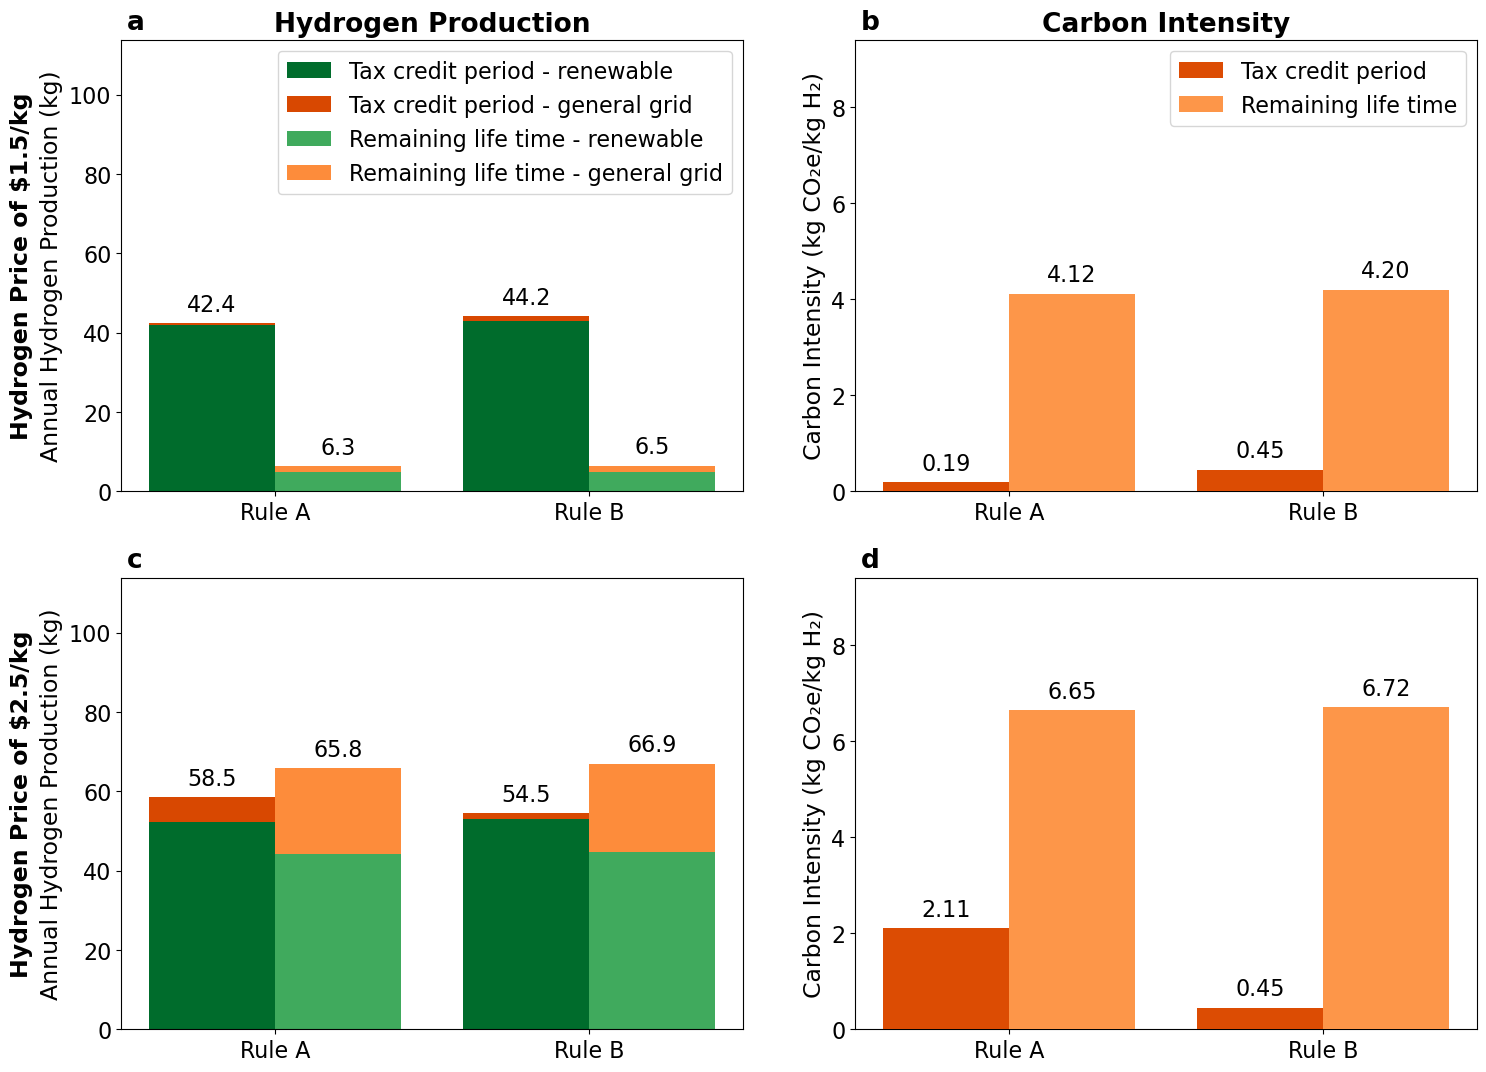

In [212]:
### test with seaborn etc.

# One version without Policy impact 
from matplotlib.patches import Patch
# ──────────────────────────────────────────────────────────────────────────────
# CONSTANTS
# ──────────────────────────────────────────────────────────────────────────────
FS_BASE   = 16
FS_TITLE  = 19
FS_LABEL  = 17
FS_LEGEND = 16

plt.rcParams.update({
    "font.size":         FS_BASE,
    "axes.titlesize":    FS_TITLE,
    "axes.labelsize":    FS_LABEL,
    "legend.fontsize":   FS_LEGEND,
})

colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'gold',
          'mediumslateblue', 'palevioletred', 'black']

# Custom colors
Greens = sns.color_palette("Greens", 7) # coolwarm?
Grid_color = sns.color_palette("Oranges", 7) # Greys / Oranges / OrRd
Grid_color_2 = sns.color_palette("Oranges", 14) # Greys / Oranges / OrRd
# Greys = sns.color_palette("Greys", 7) # 
# custom_palette = [Grid_color[5], Grid_color[3]]
custom_palette = {
    'Tax credit period'   : Grid_color[5],  # darker color
    'Remaining life time' : Grid_color[3]   # lighter color
}

# custom_palette_2 = {
#     'Tax credit period'   : Greys[5],  # darker color
#     'Remaining life time' : Greys[2]   # lighter color
# }
custom_palette_2 = {
    'Tax credit period':   Grid_color_2[10], 
    'Remaining life time': Grid_color_2[6], 
}


bar_width = 0.4
x         = np.arange(len(scenarios))

# ──────────────────────────────────────────────────────────────────────────────
# SMALL HELPERS (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
def annotate_bars(ax, bars_bottom, bars_top=None,
                  skip_zero=True, decimals=2, percentage=False):
    """Annotate stacked or single bars (unchanged helper)."""
    if bars_top is not None:                       # stacked
        for b_bot, b_top in zip(bars_bottom, bars_top):
            tot = b_bot.get_height() + b_top.get_height()
            if skip_zero and tot <= 1e-6:
                continue
            txt = f'{tot*100:.{decimals}f}%' if percentage else f'{tot:.{decimals}f}'
            ax.annotate(txt,
                        xy=(b_top.get_x()+b_top.get_width()/2, tot),
                        xytext=(0, 5), textcoords='offset points',
                        ha='center', va='bottom')
    else:                                          # single
        for bar in bars_bottom:
            h = bar.get_height()
            if skip_zero and h <= 1e-6:
                continue
            txt = f'{h*100:.{decimals}f}%' if percentage else f'{h:.{decimals}f}'
            ax.annotate(txt,
                        xy=(bar.get_x()+bar.get_width()/2, h),
                        xytext=(0, 5), textcoords='offset points',
                        ha='center', va='bottom')

def percentage_formatter(x, pos):
    return f'{x*100:.0f}%'

# ──────────────────────────────────────────────────────────────────────────────
# 1)  DERIVED COLUMNS  (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
df_all['CI_h_lifecycle'] = (
    df_all['CI_h_yearly_stage_1']*df_all['total_h2_stage_1']
  + df_all['CI_h_yearly_stage_2']*df_all['total_h2_stage_2']
) / (df_all['total_h2_stage_1'] + df_all['total_h2_stage_2'])

# ──────────────────────────────────────────────────────────────────────────────
# 2)  FIGURE 2 × 2   (Hydrogen-production & Carbon-intensity only)
# ──────────────────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 2, figsize=(15, 11))   # 15, 11        # 14/11
letters_2x2 = [['a', 'b'],
               ['c', 'd']]

# containers for common y-limit adjustment
bars_prod_bottom, bars_prod_top = [], []
bars_ci                         = []

# ------------------------------------------------------------------
for row_idx, p_h in enumerate(p_h_values):
    opt_res = optimization_results_dict.get(p_h, {})
    if not opt_res:
        print(f"No optimisation results for p_h={p_h}. Skipping row.")
        continue

    # ----------------------------------------------------------------------
    # (a / c)  HYDROGEN-PRODUCTION  (stacked, with v₂ / v₃ split)
    # ----------------------------------------------------------------------
    ax_prod = axs[row_idx, 0]
    ax_prod.text(0.01, 1.01, letters_2x2[row_idx][0],
                 transform=ax_prod.transAxes,
                 fontsize=FS_TITLE, fontweight='bold', va='bottom', ha='left')

    # scenario ordering limited to those present for this price
    scen_list  = [s for s in scenarios if s in opt_res]
    scen_disp  = [scenario_names[s] for s in scen_list]
    xpos       = np.arange(len(scen_list))

    H2_ren_s1, H2_grid_s1, H2_ren_s2, H2_grid_s2 = [], [], [], []

    for s in scen_list:
        t1, t2 = opt_res[s]['total_h2_stage_1'], opt_res[s]['total_h2_stage_2']
        v2_1, v3_1 = opt_res[s]['v_2_avg_stage_1'], opt_res[s]['v_3_avg_stage_1']
        v2_2, v3_2 = opt_res[s]['v_2_avg_stage_2'], opt_res[s]['v_3_avg_stage_2']

        frac_ren1 = v2_1 / max(v2_1+v3_1, 1e-12)
        frac_ren2 = v2_2 / max(v2_2+v3_2, 1e-12)

        H2_ren_s1.append(t1 * frac_ren1)
        H2_grid_s1.append(t1 * (1-frac_ren1))
        H2_ren_s2.append(t2 * frac_ren2)
        H2_grid_s2.append(t2 * (1-frac_ren2))

    off = bar_width / 2

    b_top1 = ax_prod.bar(xpos - off, H2_grid_s1, bar_width,
                         bottom=H2_ren_s1, color=custom_palette['Tax credit period'], alpha=1.0, zorder=2)
    
    b_bot1 = ax_prod.bar(xpos - off, H2_ren_s1, bar_width, bottom=0,  # start at zero
                         label='Stage 1 – Renewable', color=Greens[6], alpha=1.0, zorder=2) ## Previously skyblue

    b_top2 = ax_prod.bar(xpos + off, H2_grid_s2, bar_width,
                         bottom=H2_ren_s2,           color=custom_palette['Remaining life time'],     alpha=1.0)
    
    b_bot2 = ax_prod.bar(xpos + off, H2_ren_s2,  bar_width,    bottom=0,              # start at zero
                         label='Stage 2 – Renewable', color=Greens[4], alpha=1.0) # #58bc08 ## #18d17b

    annotate_bars(ax_prod, b_bot1, b_top1, decimals=1)
    annotate_bars(ax_prod, b_bot2, b_top2, decimals=1)

    ax_prod.set_xticks(xpos)
    ax_prod.set_xticklabels(scen_disp)
    ax_prod.set_ylabel("Annual Hydrogen Production (kg)", fontsize=FS_LABEL)
    if row_idx == 0:
        ax_prod.set_title("Hydrogen Production", fontsize=FS_TITLE, fontweight='bold')
        
        legend_handles = [
            Patch(facecolor=Greens[6], edgecolor='None', label='Tax credit period - renewable', alpha=1.0), #'First 10 years – Renewable' #  edgecolor='black',
            Patch(facecolor=custom_palette['Tax credit period'],    edgecolor='None', label='Tax credit period - general grid', alpha=1.0), # First 10 years – Grid'
            Patch(facecolor=Greens[4], edgecolor='None', label='Remaining life time - renewable', alpha=1.0), # Remaining useful life – Renewable
            Patch(facecolor=custom_palette['Remaining life time'],    edgecolor='None', label='Remaining life time - general grid', alpha=1.0) #Remaining useful life – Grid
        ]
        ax_prod.legend(handles=legend_handles, loc='upper right')
    bars_prod_bottom.extend(list(b_bot1)+list(b_bot2))
    bars_prod_top.extend(  list(b_top1)+list(b_top2))

    # hydrogen-price annotation on left edge
    ax_prod.text(-0.16, 0.5, f"Hydrogen Price of ${p_h}/kg",
                 transform=ax_prod.transAxes, rotation=90,
                 fontsize=FS_LABEL, fontweight='bold',
                 ha='center', va='center')

    # ----------------------------------------------------------------------
    # (b / d)  CARBON INTENSITY  — Matplotlib bars (no Seaborn)
    # ----------------------------------------------------------------------
    ax_ci = axs[row_idx, 1]
    ax_ci.text(0.01, 1.01, letters_2x2[row_idx][1],
               transform=ax_ci.transAxes,
               fontsize=FS_TITLE, fontweight='bold', va='bottom', ha='left')
    
    # ----- data ----------------------------------------------------------
    CI_s1 = [opt_res[s]['CI_h_yearly_stage_1'] for s in scen_list]
    CI_s2 = [opt_res[s]['CI_h_yearly_stage_2'] for s in scen_list]
    
    xpos  = np.arange(len(scen_list))
    off   = bar_width / 2            # same bar_width as before
    
    # ----- bars ----------------------------------------------------------
    b_s1 = ax_ci.bar(xpos - off, CI_s1, bar_width,
                     color=custom_palette_2['Tax credit period'],
                     label='Tax credit period', zorder=3) # edgecolor='Black'
    b_s2 = ax_ci.bar(xpos + off, CI_s2, bar_width,
                     color=custom_palette_2['Remaining life time'],
                     label='Remaining life time', zorder=3)
    
    # ----- annotations ---------------------------------------------------
    annotate_bars(ax_ci, b_s1, skip_zero=True, decimals=2)
    annotate_bars(ax_ci, b_s2, skip_zero=True, decimals=2)
    
    # ----- axes cosmetics ------------------------------------------------
    ax_ci.set_xticks(xpos)
    ax_ci.set_xticklabels(scen_disp)
    
    if row_idx == 0:
        ax_ci.set_title("Carbon Intensity", fontsize=FS_TITLE, fontweight='bold')
    
    ax_ci.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=FS_LABEL)
    ax_ci.set_xlabel("")
    
    # y-limit sync later (bars_ci list) -----------------
    bars_ci.extend(list(b_s1) + list(b_s2))
    
    # # ----- legend (only first row) --------------------------------------
    ci_legend = ax_ci.legend(title='', loc='upper right')
    if row_idx == 1 and ci_legend:
        ci_legend.remove()

    # bars_ci.extend(bars_ci_ax.patches)

# ──────────────────────────────────────────────────────────────────────────────
# COMMON Y-LIM ADJUSTMENTS
# ──────────────────────────────────────────────────────────────────────────────
# Hydrogen-production columns
if bars_prod_bottom:
    stacked = [b_bot.get_height()+b_top.get_height()
               for b_bot, b_top in zip(bars_prod_bottom, bars_prod_top)]
    ymax = max(stacked)*1.7
    for i in (0,1):
        axs[i,0].set_ylim(0, ymax)

# Carbon-intensity columns
if bars_ci:
    ymax = max(b.get_height() for b in bars_ci)*1.4
    for i in (0,1):
        axs[i,1].set_ylim(0, ymax)

plt.tight_layout()
fig.subplots_adjust(wspace=0.18) # space between subplots

# ──────────────────────────────────────────────────────────────────────────────
# SAVE / SHOW
# ──────────────────────────────────────────────────────────────────────────────
filename = f"Summary_2x2_{state}_{technology}_{p_h_values}_{T_subset}h_{scenarios}.pdf" # _{scenarios}
plt.savefig(os.path.join(path_cm_approach, filename), dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
### Break ###

In [ ]:
# only 2x2: v2.4 - only Profits + carbon intensity
from matplotlib.ticker import FuncFormatter

plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

bar_width = 0.25
x = np.arange(len(scenarios))

def annotate_bars(ax, bars, threshold=1e-6):
    for bar in bars:
        height = bar.get_height()
        if height > threshold:
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center', va='bottom')

def annotate_bars_percentage(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height * 100:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

bars_left_column = []   # (a, c)
bars_right_column = []  # (b, d)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for row_idx, ph in enumerate(p_h_values):
    optimization_results = optimization_results_dict[ph]

    # === LEFT SUBPLOT (Profitability) ===
    ax_left = axs[row_idx, 0]

    letters = ['a', 'c']
    ax_left.text(0.03, 1.01, letters[row_idx],
                 transform=ax_left.transAxes, fontsize=16, fontweight='bold',
                 va='bottom', ha='right')

    # Build net_profits with mapped scenario names
    net_profits = {
        scenario_names[s]: optimization_results[s]['profitability_index']
        for s in scenarios
    }

    colors2 = ['skyblue','lightgreen','salmon','orange','gold',
               'mediumslateblue','palevioletred','black'][:len(scenarios)]
    bars = ax_left.bar(net_profits.keys(), net_profits.values(),
                       color=colors2)

    bars_left_column.extend(bars)

    if row_idx == 0:
        ax_left.set_title("Profitability", fontsize=16, fontweight='bold')
    else:
        ax_left.set_title("")

    ax_left.set_ylabel("Profitability (%)")
    annotate_bars_percentage(ax_left, bars)
    ax_left.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    if row_idx == 0:
        ax_left.text(-0.15, 0.5, "Hydrogen Price of $1.5/kg",
                     transform=ax_left.transAxes, rotation=90,
                     fontsize=14, fontweight='bold', ha='center', va='center')
    else:
        ax_left.text(-0.15, 0.5, "Hydrogen Price of $2.5/kg",
                     transform=ax_left.transAxes, rotation=90,
                     fontsize=14, fontweight='bold', ha='center', va='center')

    # === RIGHT SUBPLOT (Carbon Intensity) ===
    ax_right = axs[row_idx, 1]

    letters_right = ['b', 'd']
    ax_right.text(0.03, 1.01, letters_right[row_idx],
                  transform=ax_right.transAxes, fontsize=16, fontweight='bold',
                  va='bottom', ha='right')

    CI_acc = {s: optimization_results[s].get('CI_h_avg_stage_1', None) for s in scenarios}
    CI_real = {
        s: optimization_results[s].get('CI_h_real_avg_stage_1', CI_acc[s])
          if s in ['RECs_hourly','RECs_annual','RECs_hybrid','annual_shifting',
                   'annual_shifting_avg','hourly_shifting']
          else CI_acc[s]
        for s in scenarios
    }
    CI_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None) for s in scenarios}

    # Map scenario keys to scenario_names in the "Scenario" column
    scenario_display = [scenario_names[s] for s in scenarios]
    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'First 10 years of useful life': [CI_real[s] for s in scenarios],
        'Remaining useful life': [CI_stage_2[s] for s in scenarios]
    })

    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=['First 10 years of useful life',
                    'Remaining useful life'],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_right,
                          palette='coolwarm')

    patches_right = ax_right.patches
    annotate_bars(ax_right, patches_right)
    bars_right_column.extend(patches_right)

    if row_idx == 0:
        ax_right.set_title("Grid Emissions Embodied in Hydrogen", fontsize=16, fontweight='bold')
    else:
        ax_right.set_title("")

    ax_right.set_ylabel("Annual Carbon Intensity \n (kg CO$_2$e/kg H$_2$)")
    ax_right.set_xlabel("")
    ax_right.legend(loc='upper right')
    if row_idx == 1:
        ax_right.legend_.remove()

    for bar in ax_right.patches:
        height = bar.get_height()
        if height > 0:
            ax_right.annotate(f'{height:.2f}',
                              xy=(bar.get_x() + bar.get_width()/2, height),
                              xytext=(0, 5),
                              textcoords='offset points',
                              ha='center', va='bottom')


# COMMON Axes height
max_left = max(bar.get_height() for bar in bars_left_column)
offset_left = 0.04
for idx in [0,1]:
    axs[idx,0].set_ylim(0, max_left + offset_left)

max_right = max(bar.get_height() for bar in bars_right_column)
offset_right = 1
for idx in [0,1]:
    axs[idx,1].set_ylim(0, max_right + offset_right)

plt.tight_layout()

filename = f'Comparison_2x2_{state}_{technology}_{p_h_values}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
# Plotting Parameters
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

bar_width = 0.25
x = np.arange(len(scenarios))

def annotate_bars(ax, bars, threshold=1e-6):
    for bar in bars:
        height = bar.get_height()
        if height > threshold:
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center', va='bottom')

def annotate_bars_percentage(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height * 100:.2f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

bars_left_column = []   # (a, c)
bars_right_column = []  # (b, d)

fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Increased figsize for clarity

for row_idx, ph in enumerate(p_h_values):
    optimization_results = optimization_results_dict[ph]

    # === LEFT SUBPLOT (Profitability) ===
    ax_left = axs[row_idx, 0]

    letters = ['a', 'c']
    ax_left.text(0.03, 1.01, letters[row_idx],
                 transform=ax_left.transAxes, fontsize=16, fontweight='bold',
                 va='bottom', ha='right')

    # Build net_profits with mapped scenario names
    net_profits = {
        scenario_names[s]: optimization_results[s]['profitability_index']
        for s in scenarios
    }

    colors2 = ['skyblue','lightgreen','salmon','orange','gold',
               'mediumslateblue','palevioletred','black'][:len(scenarios)]
    bars = ax_left.bar(net_profits.keys(), net_profits.values(),
                       color=colors2, width=0.6)

    bars_left_column.extend(bars)

    if row_idx == 0:
        ax_left.set_title("Profitability", fontsize=16, fontweight='bold')
    else:
        ax_left.set_title(f"Profitability (p_h={ph})", fontsize=16, fontweight='bold')

    ax_left.set_ylabel("Profitability (%)")
    annotate_bars_percentage(ax_left, bars)
    ax_left.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

    # Labeling the x-axis only for the bottom row
    if row_idx == len(p_h_values) - 1:
        ax_left.set_xlabel("Scenarios")
    else:
        ax_left.set_xlabel("")

    # === RIGHT SUBPLOT (Carbon Intensity) ===
    ax_right = axs[row_idx, 1]

    letters_right = ['b', 'd']
    ax_right.text(0.03, 1.01, letters_right[row_idx],
                  transform=ax_right.transAxes, fontsize=16, fontweight='bold',
                  va='bottom', ha='right')

    # Extract all six CI metrics
    CI_avg_stage_1 = {s: optimization_results[s].get('CI_h_avg_stage_1', None) for s in scenarios}
    CI_yearly_stage_1 = {s: optimization_results[s].get('CI_h_yearly_stage_1', None) for s in scenarios}
    CI_hourly_stage_1 = {s: optimization_results[s].get('CI_h_hourly_stage_1', None) for s in scenarios}
    CI_avg_stage_2 = {s: optimization_results[s].get('CI_h_avg_stage_2', None) for s in scenarios}
    CI_yearly_stage_2 = {s: optimization_results[s].get('CI_h_yearly_stage_2', None) for s in scenarios}
    CI_hourly_stage_2 = {s: optimization_results[s].get('CI_h_hourly_stage_2', None) for s in scenarios}

    # Map scenario keys to scenario_names in the "Scenario" column
    scenario_display = [scenario_names[s] for s in scenarios]
    CI_df = pd.DataFrame({
        'Scenario': scenario_display,
        'CI_h_avg_stage_1': [CI_avg_stage_1[s] for s in scenarios],
        'CI_h_yearly_stage_1': [CI_yearly_stage_1[s] for s in scenarios],
        'CI_h_hourly_stage_1': [CI_hourly_stage_1[s] for s in scenarios],
        'CI_h_avg_stage_2': [CI_avg_stage_2[s] for s in scenarios],
        'CI_h_yearly_stage_2': [CI_yearly_stage_2[s] for s in scenarios],
        'CI_h_hourly_stage_2': [CI_hourly_stage_2[s] for s in scenarios],
    })

    # Melt the DataFrame to long format
    CI_df_melted = CI_df.melt(
        id_vars='Scenario',
        value_vars=[
            'CI_h_avg_stage_1',
            'CI_h_yearly_stage_1',
            'CI_h_hourly_stage_1',
            'CI_h_avg_stage_2',
            'CI_h_yearly_stage_2',
            'CI_h_hourly_stage_2'
        ],
        var_name='CI Type',
        value_name='Carbon Intensity'
    )

    # Define a mapping for CI Type labels for better readability
    ci_type_mapping = {
        'CI_h_avg_stage_1': 'CI PTC Calculation',
        'CI_h_yearly_stage_1': 'Yearly Stage 1',
        'CI_h_hourly_stage_1': 'Hourly Stage 1',
        'CI_h_avg_stage_2': 'Avg Stage 2',
        'CI_h_yearly_stage_2': 'Yearly Stage 2',
        'CI_h_hourly_stage_2': 'Hourly Stage 2'
    }
    CI_df_melted['CI Type'] = CI_df_melted['CI Type'].map(ci_type_mapping)

    # Define color palette
    palette = sns.color_palette('coolwarm', n_colors=6)

    # Plot using seaborn
    bars_ci = sns.barplot(data=CI_df_melted,
                          x='Scenario',
                          y='Carbon Intensity',
                          hue='CI Type',
                          ax=ax_right,
                          palette=palette,
                          dodge=True)

    # Collect all patches for annotation
    patches_right = ax_right.patches
    annotate_bars(ax_right, patches_right)

    bars_right_column.extend(patches_right)

    if row_idx == 0:
        ax_right.set_title("Grid Emissions Embodied in Hydrogen", fontsize=16, fontweight='bold')
    else:
        ax_right.set_title(f"Grid Emissions Embodied in Hydrogen (p_h={ph})", fontsize=16, fontweight='bold')

    ax_right.set_ylabel("Annual Carbon Intensity \n (kg CO$_2$e/kg H$_2$)")
    ax_right.set_xlabel("Scenarios")
    
    # Adjust legend
    if row_idx == 0:
        ax_right.legend(loc='upper right', title='CI Type')
    else:
        ax_right.legend_.remove()  # Remove legend for subsequent plots to avoid repetition

    # Adjust annotations to show values above bars
    for bar in ax_right.patches:
        height = bar.get_height()
        if height > 0:
            ax_right.annotate(f'{height:.2f}',
                              xy=(bar.get_x() + bar.get_width()/2, height),
                              xytext=(0, 5),
                              textcoords='offset points',
                              ha='center', va='bottom')

# COMMON Axes height
max_left = max(bar.get_height() for bar in bars_left_column) if bars_left_column else 0
offset_left = 0.04
for idx in range(len(p_h_values)):
    axs[idx,0].set_ylim(0, max_left + offset_left)

max_right = max(bar.get_height() for bar in bars_right_column) if bars_right_column else 0
offset_right = 1
for idx in range(len(p_h_values)):
    axs[idx,1].set_ylim(0, max_right + offset_right)

plt.tight_layout()

# # # Save the figure
# filename = f'CARBON_INTENSITY_TESTS{state}_{technology}_p_h={p_h_values}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_{scenarios}.pdf'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, format='pdf', bbox_inches='tight')

plt.show()

### Latex Tables Output 

In [ ]:
def build_summary_table_for_ph(p_h, optimization_results, scenario_names, scenarios):

    table_data = []

    for s in scenarios:
        if s not in optimization_results:
            # Scenario does not exist at this p_h -> skip
            print(f"Skipping scenario '{s}' for p_h={p_h}; not found in optimization_results.")
            continue

        # Scenario Display Name
        scenario_display = scenario_names.get(s, s)

        # Carbon intensities
        ci_acc = optimization_results[s].get('CI_h_avg_stage_1', None)
        ci_real = optimization_results[s].get('CI_h_real_avg_stage_1', None)

        # k_h, rho
        k_h_val = optimization_results[s].get('optimal_k_h', None)
        rho_val = optimization_results[s].get('optimal_rho', None)

        # H2 produced in Stage 1 and Stage 2
        h2_stage_1 = optimization_results[s].get('total_h2_stage_1', 0.0)
        h2_stage_2 = optimization_results[s].get('total_h2_stage_2', 0.0)

        # Profitability index
        profit_val = optimization_results[s].get('profitability_index', None)

        table_data.append([
            scenario_display, 
            ci_acc, 
            ci_real,
            k_h_val, 
            rho_val, 
            h2_stage_1, 
            h2_stage_2, 
            profit_val
        ])

    columns = [
        "Scenario", 
        "CI_PTC",   # or "CI_acc"
        "CI_h",     # or "CI_real"
        "k_h", 
        "rho", 
        "H2_Stage_1", 
        "H2_Stage_2", 
        "Profitability"
    ]
    df_summary = pd.DataFrame(table_data, columns=columns)
    df_summary.set_index("Scenario", inplace=True)

    return df_summary

for p_h in p_h_values:
    print(f"\n=== Summary Table for p_h = {p_h} ===")

    optimization_results_for_ph = optimization_results_dict[p_h]

    # Build table
    df_table = build_summary_table_for_ph(
        p_h, 
        optimization_results_for_ph, 
        scenario_names, 
        scenarios 
    )

    # Print
    display(df_table)

In [ ]:
# LATEX OUTPUT

def build_summary_table_for_ph(p_h, optimization_results, scenario_names, scenarios):

    table_data = []

    for s in scenarios:
        if s not in optimization_results:
            # Scenario does not exist at this p_h -> skip
            print(f"Skipping scenario '{s}' for p_h={p_h}; not found in optimization_results.")
            continue

        # Scenario Display Name
        scenario_display = scenario_names.get(s, s)

        # Carbon intensities
        ci_acc = optimization_results[s].get('CI_h_avg_stage_1', None)
        ci_real = optimization_results[s].get('CI_h_real_avg_stage_1', None)

        # k_h, rho
        k_h_val = optimization_results[s].get('optimal_k_h', None)
        rho_val = optimization_results[s].get('optimal_rho', None)

        # H2 produced in Stage 1 and Stage 2
        h2_stage_1 = optimization_results[s].get('total_h2_stage_1', 0.0)
        h2_stage_2 = optimization_results[s].get('total_h2_stage_2', 0.0)

        # Profitability index
        profit_val = optimization_results[s].get('profitability_index', None)

        table_data.append([
            scenario_display, 
            ci_acc, 
            ci_real,
            k_h_val, 
            rho_val, 
            h2_stage_1, 
            h2_stage_2, 
            profit_val
        ])

    columns = [
        "Scenario", 
        "$CI_{PTC}$",    # Accounting-based Carbon Intensity
        "$CI_h$",        # Real/Market-based Carbon Intensity
        "$k_h$", 
        "$\\s$", 
        "$H_2(k_h^*, \\s^*)^{(1)}$", 
        "$H_2(k_h^*, \\s^*)^{(2)}$", 
        "Profitability"
    ]
    df_summary = pd.DataFrame(table_data, columns=columns)
    df_summary.set_index("Scenario", inplace=True)

    return df_summary

# Loop over each p_h
for p_h in p_h_values:
    print(f"\n=== Summary Table for p_h = {p_h} ===")

    optimization_results_for_ph = optimization_results_dict.get(p_h, {})
    
    if not optimization_results_for_ph:
        print(f"No optimization results found for p_h = {p_h}. Skipping...")
        continue

    # Build table
    df_table = build_summary_table_for_ph(
        p_h, 
        optimization_results_for_ph, 
        scenario_names, 
        scenarios 
    )

    # Check if table is empty
    if df_table.empty:
        print(f"No scenarios available for p_h={p_h}.")
        continue

    # Round numerical values to two decimal places
    df_table_rounded = df_table.round(2)

    # Convert DataFrame to LaTeX table body
    latex_table_body = df_table_rounded.to_latex(
        column_format="lccccccr",
        float_format="%.2f",
        na_rep="N/A",
        escape=False,
        header=True,
        index=True
    )

    # Assemble the full LaTeX table with \begin{table}, \caption, \label, \small, \begin{tabular}, table body, \end{tabular}, \end{table}
    # The order should be: \begin{table}, \caption{}, \label{}, \small, <tabular content>, \end{table}
    full_latex_table = f"""
\\begin{{table}}[ht]
\\caption{{Summary Table for Hydrogen Price $p_h$ = \\${p_h}/kg}}
\\label{{tab:summary_p_h_{p_h}}}
\\small
{latex_table_body}
\\end{{table}}
"""

    # Clean up the LaTeX table string
    full_latex_table = full_latex_table.strip()

    # Print the LaTeX code
    print(full_latex_table)

    # # Optionally, save the LaTeX code to a .tex file
    # latex_filename = f"Summary_Table_p_h_{p_h}.tex"
    # latex_output_path = os.path.join(path_cm_approach, latex_filename)

    # with open(latex_output_path, 'w') as f_latex:
    #     f_latex.write(full_latex_table)
    
    # print(f"LaTeX table saved to {latex_output_path}")


### Other Graphs - h2 production etc.

In [ ]:
# Renewables + H2 Production Summary

# scenarios = list(optimization_results.keys()) # Defined above
bar_width = 0.25
x = np.arange(len(scenarios))

# Extract H2 Production Data
h2_stage_1 = [optimization_results[scenario]['total_h2_stage_1'] for scenario in scenarios]
h2_stage_2 = [optimization_results[scenario]['total_h2_stage_2'] for scenario in scenarios]
h2_total = [optimization_results[scenario]['total_h2_produced'] for scenario in scenarios]

# Extract Renewable Electricity Sold to Grid Data
v1_stage_1 = [optimization_results[scenario]['total_v_1_stage_1'] for scenario in scenarios]
v1_stage_2 = [optimization_results[scenario]['total_v_1_stage_2'] for scenario in scenarios]
v1_total = [optimization_results[scenario]['total_renewables_produced'] for scenario in scenarios]

# Extract PTCs Data
ptcs_h2 = [optimization_results[scenario]['total_PTCs_h2'] for scenario in scenarios]
ptcs_renewables = [optimization_results[scenario]['total_PTCs_renewables'] for scenario in scenarios]
ptcs_total = [optimization_results[scenario]['total_PTCs_paid'] for scenario in scenarios]

# Create a new figure with three rows for each plot
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# 1. Hydrogen Production by Stage
axs[0].bar(x - bar_width, h2_stage_1, width=bar_width, label='Stage 1 H2', color='lightblue')
axs[0].bar(x, h2_stage_2, width=bar_width, label='Stage 2 H2', color='cornflowerblue')
axs[0].bar(x + bar_width, h2_total, width=bar_width, label='Total H2 Produced', color='navy')
axs[0].set_title('Hydrogen Production by Stage and Total')
axs[0].set_ylabel('Total H2 Produced')
axs[0].set_xticks(x)
axs[0].set_xticklabels(scenarios)
axs[0].legend()

# 2. PTCs Paid by Category (Hydrogen, Renewables, Total)
axs[1].bar(x - bar_width, ptcs_h2, width=bar_width, label='Hydrogen PTCs', color='peachpuff')
axs[1].bar(x, ptcs_renewables, width=bar_width, label='Renewable PTCs', color='goldenrod')
axs[1].bar(x + bar_width, ptcs_total, width=bar_width, label='Total PTCs Paid', color='saddlebrown')
axs[1].set_title('PTCs Paid by Category and Total')
axs[1].set_ylabel('Total PTCs Paid (USD)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(scenarios)
axs[1].legend()

# 3. Renewable Electricity Sold to Grid by Stage
axs[2].bar(x - bar_width, v1_stage_1, width=bar_width, label='Stage 1 Renewable Electricity', color='lightgreen')
axs[2].bar(x, v1_stage_2, width=bar_width, label='Stage 2 Renewable Electricity', color='mediumseagreen')
axs[2].bar(x + bar_width, v1_total, width=bar_width, label='Total Renewable Electricity', color='darkgreen')
axs[2].set_title('Renewable Electricity Sold to Grid by Stage vs Total Produced')
axs[2].set_ylabel('Total Electricity (kWh)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(scenarios)
axs[2].legend()

plt.tight_layout()

# Export
filename = f'H2_PTCs_Renewables_Summary_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_Scenarios.png'
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# CI + PTC Summary

bar_width = 0.25
x = np.arange(len(scenarios))

# Calculate PTC per kg H₂ for Stage 1 and Lifetime (only Stage 1 has PTCs)
ptc_per_kg_stage_1 = [
    optimization_results[scenario]['total_PTCs_h2'] / optimization_results[scenario]['total_h2_stage_1']
    for scenario in scenarios
]
ptc_per_kg_lifetime = [
    optimization_results[scenario]['total_PTCs_h2'] / (optimization_results[scenario]['total_h2_stage_1'] + optimization_results[scenario]['total_h2_stage_2'])
    for scenario in scenarios
]

# Retrieve Carbon Intensity values with a distinction for "RECs hourly" scenario ## CHECK IF WORKS with annual shifting
ci_acc_stage_1 = {scenario: optimization_results[scenario].get('CI_h_avg_stage_1', None) for scenario in scenarios}
ci_acc_stage_2 = {scenario: optimization_results[scenario].get('CI_h_avg_stage_2', None) for scenario in scenarios}
ci_real_stage_1 = {
    scenario: optimization_results[scenario].get('CI_h_real_avg_stage_1', CI_acc[scenario]) if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting'] else CI_acc[scenario]
    for scenario in scenarios
}
ci_real_stage_2 = {
    scenario: optimization_results[scenario].get('CI_h_avg_stage_2', None)  if scenario != ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting'] else ci_acc_stage_2[scenario]
    for scenario, res in optimization_results.items()
}

# Calculate Real Carbon Intensity per kg H₂ for Stage 1, Stage 2, and Lifetime
ci_per_kg_stage_1 = [ci_real_stage_1[scenario] for scenario in scenarios]
ci_per_kg_stage_2 = [ci_real_stage_2[scenario] for scenario in scenarios]
ci_per_kg_lifetime = [
    ((ci_real_stage_1[scenario] * optimization_results[scenario]['total_h2_stage_1']) + 
     (ci_real_stage_2[scenario] * optimization_results[scenario]['total_h2_stage_2'])) /
    (optimization_results[scenario]['total_h2_stage_1'] + optimization_results[scenario]['total_h2_stage_2'])
    for scenario in scenarios
]

# Create a new figure with two rows for each stage and lifetime for both PTC and CI
fig, axs = plt.subplots(2, 1, figsize=(12, 15))

# 1. PTC Paid per kg H₂ (Only Stage 1 and Lifetime)
axs[0].bar(x - bar_width / 2, ptc_per_kg_stage_1, width=bar_width, label='Stage 1 PTC per kg H₂', color='lightcoral')
axs[0].bar(x + bar_width / 2, ptc_per_kg_lifetime, width=bar_width, label='Lifetime PTC per kg H₂', color='steelblue')
axs[0].set_title('PTC Paid by State per kg of H₂ Produced')
axs[0].set_ylabel('PTC Paid per kg H₂ ($/kg)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(scenarios)
axs[0].legend()

# 2. Real Carbon Intensity per kg H₂
axs[1].bar(x - bar_width, ci_per_kg_stage_1, width=bar_width, label='Stage 1 Real CI per kg H₂', color='lightgreen')
axs[1].bar(x, ci_per_kg_stage_2, width=bar_width, label='Stage 2 Real CI per kg H₂', color='mediumseagreen')
axs[1].bar(x + bar_width, ci_per_kg_lifetime, width=bar_width, label='Lifetime Real CI per kg H₂', color='darkgreen')
axs[1].set_title('Grid Emissions embodied per kg of H₂ Produced')
axs[1].set_ylabel('CI per kg H₂ (kg CO₂/kg H₂)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(scenarios)
axs[1].legend()

plt.tight_layout()

# # Export
# filename = f'H2_PTC_and_CI_per_kg_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_RECs_{include_RECs_hourly}.png'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# CI + PTC Summary

bar_width = 0.25
x = np.arange(len(scenarios))

# Calculate PTC per kg H₂ for Stage 1 and Lifetime (only Stage 1 has PTCs)
ptc_per_kg_stage_1 = [
    optimization_results[scenario]['total_PTCs_h2'] / optimization_results[scenario]['total_h2_stage_1']
    if optimization_results[scenario]['total_h2_stage_1'] > 0 else 0
    for scenario in scenarios
]
ptc_per_kg_lifetime = [
    optimization_results[scenario]['total_PTCs_h2'] / (optimization_results[scenario]['total_h2_stage_1'] + optimization_results[scenario]['total_h2_stage_2'])
    if (optimization_results[scenario]['total_h2_stage_1'] + optimization_results[scenario]['total_h2_stage_2']) > 0 else 0
    for scenario in scenarios
]

# Retrieve Carbon Intensity values with a distinction for "RECs_hourly" scenario, filtered by `scenarios`
CI_acc = {scenario: optimization_results[scenario].get('CI_h_avg_stage_1', 0) for scenario in scenarios}
CI_real = {
    scenario: optimization_results[scenario].get('CI_h_real_avg_stage_1', CI_acc[scenario]) if scenario in ['RECs_hourly', 'RECs_annual', 'RECs_hybrid', 'annual_shifting', 'annual_shifting_avg', 'hourly_shifting'] else CI_acc[scenario]
    for scenario in scenarios
}
CI_stage_2 = {scenario: optimization_results[scenario].get('CI_h_avg_stage_2', 0) for scenario in scenarios}

# Retrieve total hydrogen production and total PTCs for each scenario, filtered by `scenarios`
total_h2_stage_1 = {scenario: optimization_results[scenario].get('total_h2_stage_1', 0) for scenario in scenarios}
total_h2_stage_2 = {scenario: optimization_results[scenario].get('total_h2_stage_2', 0) for scenario in scenarios}
total_PTCs_h2 = {scenario: optimization_results[scenario].get('total_PTCs_h2', 0) for scenario in scenarios}

# Calculate emissions for Stage 1 and Lifetime, ensuring they match `scenarios` in length
emissions_stage_1 = [
    total_h2_stage_1[scenario] * CI_real[scenario] for scenario in scenarios
]
emissions_lifetime = [
    (total_h2_stage_1[scenario] * CI_real[scenario]) + (total_h2_stage_2[scenario] * CI_stage_2[scenario])
    for scenario in scenarios
]

# Calculate emissions per PTC paid for Stage 1 and Lifetime, ensuring length matches `scenarios`
emissions_per_ptc_stage_1 = [
    emissions_stage_1[idx] / total_PTCs_h2[scenario] if total_PTCs_h2[scenario] > 0 else 0
    for idx, scenario in enumerate(scenarios)
]
emissions_per_ptc_lifetime = [
    emissions_lifetime[idx] / total_PTCs_h2[scenario] if total_PTCs_h2[scenario] > 0 else 0
    for idx, scenario in enumerate(scenarios)
]

# Create a new figure with three rows for each stage and lifetime for PTC per kg H₂, CI, and Emissions per PTC
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 1. PTC Paid per kg H₂ (Only Stage 1 and Lifetime)
axs[0].bar(x - bar_width / 2, ptc_per_kg_stage_1, width=bar_width, label='Stage 1 PTC per kg H₂', color='lightcoral')
axs[0].bar(x + bar_width / 2, ptc_per_kg_lifetime, width=bar_width, label='Lifetime PTC per kg H₂', color='steelblue')
axs[0].set_title('PTC Paid by State per kg of H₂ Produced')
axs[0].set_ylabel('PTC Paid per kg H₂ ($/kg)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(scenarios)
axs[0].legend()

# 2. Real Carbon Intensity per kg H₂ (Only plot values that match `scenarios` length)
axs[1].bar(x - bar_width, list(CI_real.values()), width=bar_width, label='Stage 1 Real CI per kg H₂', color='lightgreen')
axs[1].bar(x, list(CI_stage_2.values()), width=bar_width, label='Stage 2 Real CI per kg H₂', color='mediumseagreen')
axs[1].bar(x + bar_width, [emissions_lifetime[i] / (total_h2_stage_1[scenarios[i]] + total_h2_stage_2[scenarios[i]])
                           if (total_h2_stage_1[scenarios[i]] + total_h2_stage_2[scenarios[i]]) > 0 else 0
                           for i in range(len(scenarios))], width=bar_width, label='Lifetime Real CI per kg H₂', color='darkgreen')
axs[1].set_title('Grid Emissions Embodied per kg of H₂ Produced')
axs[1].set_ylabel('CI per kg H₂ (kg CO₂/kg H₂)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(scenarios)
axs[1].legend()

# 3. Emissions per PTC Paid
axs[2].bar(x - bar_width / 2, emissions_per_ptc_stage_1, width=bar_width, label='Stage 1 Emissions per USD of PTC invested', color='lightblue')
axs[2].bar(x + bar_width / 2, emissions_per_ptc_lifetime, width=bar_width, label='Lifetime Emissions per PTC', color='navy')
axs[2].set_title('Emissions per $ of PTC Paid by State')
axs[2].set_ylabel('Emissions per USD of PTC (kg CO₂/$)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(scenarios)
axs[2].legend()

plt.tight_layout()

# Export
# filename = f'H2_PTC_and_Emissions_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_ALL.png'
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


## Hourly Graphs Test

In [ ]:
# Define the number of hours to plot (e.g., 24, 50, etc.)
# num_hours = 48
# hours = np.arange(num_hours)

# Manually define best hours
start_hour = 0
end_hour = 250
hours = np.arange(start_hour, end_hour)
x = np.arange(len(scenarios))

# Create a figure with subplots for each scenario
fig, axs = plt.subplots(len(scenarios), 1, figsize=(10, 5 * len(scenarios)), sharex=True)

# Ensure axs is iterable even for a single scenario
if len(scenarios) == 1:
    axs = [axs]

# Plot for each selected scenario
for i, scenario in enumerate(scenarios):
    # Extract the hourly data for the scenario, slicing according to num_hours
    v1_values = optimization_results[scenario]['revenues_optimal']['v_1_t_stage_1'][start_hour:end_hour]
    v2_values = optimization_results[scenario]['revenues_optimal']['v_2_t_stage_1'][start_hour:end_hour]
    v3_values = optimization_results[scenario]['revenues_optimal']['v_3_t_stage_1'][start_hour:end_hour]
    CF_e_t_values = optimization_results[scenario]['CF_e_t_optimal'][start_hour:end_hour]
    
    # Calculate total hydrogen production (v2 + v3)
    total_h2_production = np.array(v2_values) + np.array(v3_values)

    # Plot each variable in the corresponding subplot with a step function
    axs[i].step(hours, v1_values, label='v1', color='skyblue', where='mid')
    axs[i].step(hours, v2_values, label='v2', color='green', where='mid')
    axs[i].step(hours, v3_values, label='v3', color='salmon', where='mid')
    
    # Plot CF_e_t with a different dotted line style
    axs[i].step(hours, CF_e_t_values, label='CF_e_t', color='lightgreen', linestyle='--', where='mid')
    
    # Plot total hydrogen production (v2 + v3) as a dotted line
    axs[i].step(hours, total_h2_production, label='Total H2 (v2 + v3)', color='orange', linestyle=':', where='mid')

    # Set title and labels for each subplot
    axs[i].set_title(f'Hourly Data for Scenario: {scenario}, p_h = {p_h}')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Common x-label for hours across all subplots
axs[-1].set_xlabel('Hour')

plt.tight_layout()

# Export
filename = f'Hourly_Data_{state}_{technology}_p_h={p_h}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_{scenarios}.png' #_{scenarios}
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


## Summary Graphs (several p_hs)

In [233]:
# Define the range of p_h values
p_h_values = np.arange(1.0, 3.75, 0.5)  # From 0.5 to 3.5 in steps of 0.25

# Initialize a list to store data for all p_h values
all_data = []

for p_h in p_h_values:
    # Format p_h to match the filename (if needed)
    p_h_formatted = str(p_h) # f"{p_h:g}" # str(p_h) # f"{p_h:g}" # f"{p_h:.2f}"
    
    # Construct the filename based on p_h
    filename = f'Optimization_Results_{state}_{technology}_p_h={p_h_formatted}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}.pkl'
    input_path = os.path.join(path_outputs, filename)
    
    # Check if the file exists
    if not os.path.exists(input_path):
        print(f"File not found for p_h = {p_h_formatted}: {input_path}")
        continue  # Skip to the next p_h value
    
    # Load the optimization_results dictionary from the pickle file
    with open(input_path, 'rb') as f:
        optimization_results = pickle.load(f)
    
    # For each scenario, extract the relevant metrics and append to all_data
    for scenario in optimization_results.keys():
        result = optimization_results[scenario]
        
        data_entry = {
            'p_h': p_h,
            'Scenario': scenario,
            'optimal_k_h': result.get('optimal_k_h', np.nan),
            'optimal_rho': result.get('optimal_rho', np.nan),
            'max_net_profit': result.get('max_net_profit', np.nan),
            'profitability_index': result.get('profitability_index', np.nan),
            'IRR': result.get('IRR_1', np.nan),
            'CI_h_avg_stage_1': result.get('CI_h_avg_stage_1', np.nan),
            'CI_h_avg_stage_2': result.get('CI_h_avg_stage_2', np.nan),
            'CI_h_real_avg_stage_1': result.get('CI_h_real_avg_stage_1', np.nan),
            'CI_h_yearly_stage_1': result.get('CI_h_yearly_stage_1', np.nan), # NEW
            'CI_h_yearly_stage_2': result.get('CI_h_yearly_stage_2', np.nan), # NEW
            'v_1_avg_stage_1': result.get('v_1_avg_stage_1', np.nan),
            'v_2_avg_stage_1': result.get('v_2_avg_stage_1', np.nan),
            'v_3_avg_stage_1': result.get('v_3_avg_stage_1', np.nan),
            'v_1_avg_stage_2': result.get('v_1_avg_stage_2', np.nan),
            'v_2_avg_stage_2': result.get('v_2_avg_stage_2', np.nan),
            'v_3_avg_stage_2': result.get('v_3_avg_stage_2', np.nan),
            'total_h2_produced': result.get('total_h2_produced', np.nan),
            'total_h2_stage_1': result.get('total_h2_stage_1', np.nan),
            'total_h2_stage_2': result.get('total_h2_stage_2', np.nan),
            'total_v_1_stage_1': result.get('total_v_1_stage_1', np.nan),
            'total_v_1_stage_2': result.get('total_v_1_stage_2', np.nan),
            'total_PTCs_h2': result.get('total_PTCs_h2', np.nan),
            'PTC_h_avg_stage_1': result.get('PTC_h_avg_stage_1', np.nan),
            'CI_h_lifecycle': result.get('CI_h_lifecycle', np.nan),
            'bang_total': result.get('bang_total', np.nan),
            # Add other metrics as needed
        }
        
        all_data.append(data_entry)


In [235]:
# df
df_all = pd.DataFrame(all_data)

# filter
df_all = df_all[df_all['Scenario'].isin(scenarios)]

# order
df_all['Scenario'] = pd.Categorical(df_all['Scenario'], categories=scenario_order, ordered=True)

# updated names scenarios
df_all['Scenario_Display'] = df_all['Scenario'].map(scenario_names)

# Sort
df_all.sort_values(by=['p_h', 'Scenario'], inplace=True)


In [239]:
# Export of outputs for SI

display_map = {
    'optimal_k_h'       : 'Optimal PtG Size, k_h',
    'optimal_rho'       : 'Optimal Share of Wind Energy, s',
    'max_net_profit'    : 'Maximum Net Present Value, NPV',
    'IRR'               : 'Internal Rate of Return, IRR',
    'CI_h_lifecycle'    : 'Lifecycle Carbon Intensity of Hydrogen, CI_h',
    'bang_total'        : 'Policy Impact, PI',      
    'PTC_h_avg_stage_1'     : 'Average Production Tax Credit of H₂ during PTC period, PTC_hi',
    'total_PTCs_h2'     : 'Total Annual Production Tax Credit of H₂ received during PTC period, PTC_hi',
    'CI_h_yearly_stage_1'  : 'Average Carbon Intensity of H₂ during PTC period, CI_hi',
    'CI_h_yearly_stage_2'  : 'Average Carbon Intensity of H₂ after PTC period, CI_hi',
    'total_h2_stage_1'  : 'Yearly Hydrogen Production during PTC period, q_hi',
    'total_h2_stage_2'  : 'Yearly Hydrogen Production after PTC period, q_hi',
}

ordered_keys   = list(display_map.keys())           # order
nice_row_names = [display_map[k] for k in ordered_keys]

need_cols = ['p_h', 'Scenario_Display'] + ordered_keys
df_clean  = df_all[need_cols].copy()

tables = {}
for p in sorted(df_clean['p_h'].unique()):
    block = (
        df_clean.loc[df_clean['p_h'] == p]
                .set_index('Scenario_Display')[ordered_keys]  
                .T                                            # transpose 
    )
    block.index = nice_row_names
    tables[p] = block

# Export

filename_excel = f'Optimization_Results_ordered_{version}.xlsx'
out_path = os.path.join(path_outputs, filename_excel)

with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    for p, tbl in tables.items():
        sheet = f"p_h={p:g}"
        tbl.to_excel(writer, sheet_name=sheet, startrow=0, startcol=0)

### New Graphs

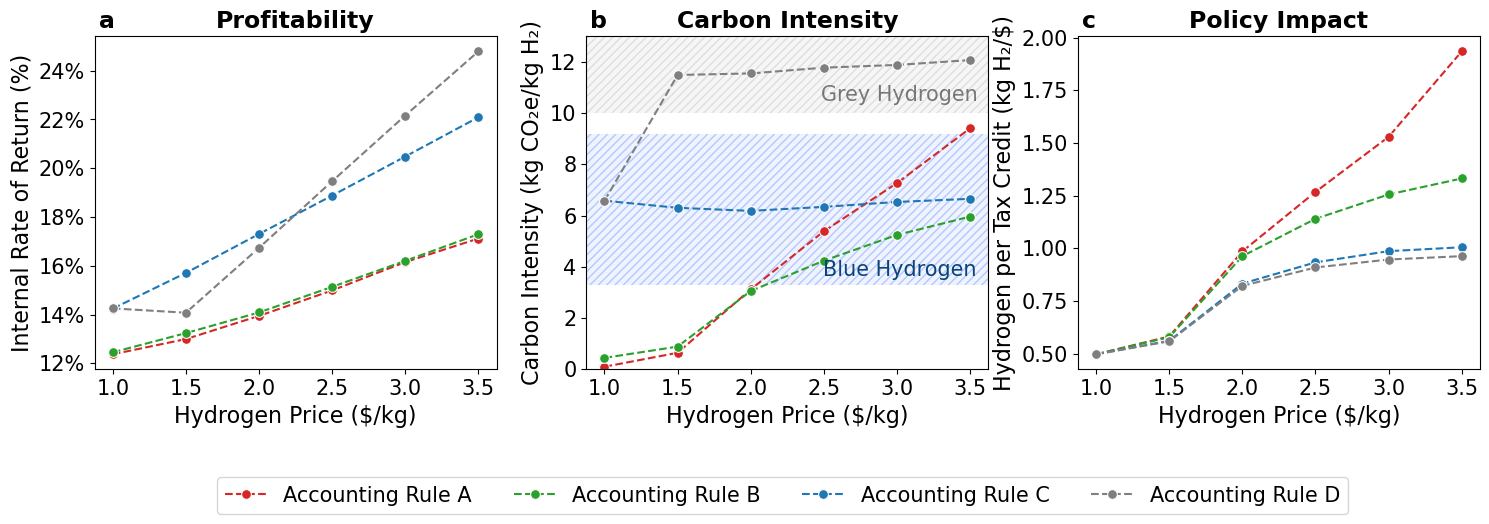

In [52]:
# Define consistent font sizes
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE = 15

def percentage_formatter(x, pos):
    """Helper to format y-axis as percentages."""
    return f'{x * 100:.0f}%'

###############################################################################
# 1) Weighted average CI
###############################################################################
df_all['CI_h_lifecycle'] = df_all['CI_h_lifecycle']

###############################################################################
# 2) Bang measure
###############################################################################
df_all['bang_total'] = (
    (df_all['total_h2_stage_1'] * 10 + df_all['total_h2_stage_2'] * 10)
    / (df_all['total_PTCs_h2'] * discount_factor_10yr)
)

###############################################################################
# 3) Prepare a 1×3 figure
###############################################################################
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
letters_1x3 = ['a', 'b', 'c']

###############################################################################
# (a) IRR
###############################################################################
ax1 = axs[0]
ax1.text(
    0.01, 1.01, letters_1x3[0],
    transform=ax1.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left'
)

# Use the actual scenario keys (from 'Scenario') for hue and our palette
sns.lineplot(
    data=df_all,
    x='p_h',
    y='IRR',  # "IRR" or 'IRR_1'
    hue='Scenario',         # use actual scenario keys
    marker='o', markersize=7,
    linestyle='--',
    legend=False,           # no legend on subplot A
    palette=scenario_colors,
    hue_order=scenario_order,
    ax=ax1
)
ax1.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold')
ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

###############################################################################
# (b) Carbon Intensity
###############################################################################
ax2 = axs[1]
ax2.text(
    0.01, 1.01, letters_1x3[1],
    transform=ax2.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='CI_h_lifecycle',
    hue='Scenario',         # using scenario keys for hue
    marker='o', markersize=7,
    linestyle='--',
    legend=False,           # no legend on subplot B
    palette=scenario_colors,
    hue_order=scenario_order,
    ax=ax2
)

# --- background shading (plotted FIRST so it stays behind the lines) ----------
ax2.axhspan(3.3, 9.2,                     # BLUE-H₂ band # or 7.4 theoretical vs 9.2 with measured upper bound!!!
            facecolor='#a2cffe', alpha=0.2,
            hatch='////', edgecolor='blue', linewidth=0, zorder=0) # hatch='////'
ax2.text(0.78, 3.9, "Blue Hydrogen",     # centred in the band
         transform=ax2.get_yaxis_transform(),  # x-in axes, y-in data coords
         ha='center', va='center', fontsize=TICK_SIZE, color='#0a437a', alpha=1) # 
upper_y = ax2.get_ylim()[1]
if upper_y > 8:
    ax2.axhspan(10, 20, facecolor='lightgrey', alpha=0.2, # upper_y # Rather up to 20 (howarth et al. 2021), Vellejo et al.
                hatch='////', edgecolor='grey', linewidth=0, zorder=0) # hatch='////'
    ax2.text(0.78, 10.7, "Grey Hydrogen", # 0.7 vs 0.5 in middle
             transform=ax2.get_yaxis_transform(),
             ha='center', va='center', fontsize=TICK_SIZE, alpha=0.5, color='black') #dimgray

ax2.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=LABEL_SIZE)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# (c) Policy Impact
###############################################################################
ax3 = axs[2]
ax3.text(
    0.01, 1.01, letters_1x3[2],
    transform=ax3.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left'
)

# Plot Policy Impact with legend='full' to get handles from the 'Scenario' keys
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_total',
    hue='Scenario',         # use scenario keys for hue
    marker='o', markersize=7,
    linestyle='--',
    legend='full',          # generate legend handles
    palette=scenario_colors,
    hue_order=scenario_order,
    ax=ax3
)

# Remove automatic legend from ax3; we will create a custom legend using display names
ax3.legend_.remove()
ax3.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax3.set_ylabel("Hydrogen per Tax Credit (kg H₂/$)", fontsize=LABEL_SIZE)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax3.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# 4) Create a single combined legend using display names
###############################################################################
handles, labels = ax3.get_legend_handles_labels()
# Map the scenario keys (labels) to display names using your scenario_names dictionary
new_labels = [scenario_names[label] for label in labels]

fig.legend(
    handles, new_labels,
    loc='lower center',
    bbox_to_anchor=(0.525, -0.06), # -0.1
    ncol=4,
    fontsize=TICK_SIZE
)
ax2.set_ylim(0, 13) # 18 , 13

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # leave space for the legend

# Save the figure
filename = f"Lines_3KPIs_{state}_{technology}_{T_subset}h_{version}_{scenarios}.pdf" # _{scenarios} # _Co-location.
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# # Only 2 KPIs
# TITLE_SIZE = 17
# LABEL_SIZE = 16
# TICK_SIZE  = 15

# def percentage_formatter(x, pos):
#     return f'{x*100:.0f}%'

# # ──────────────────────────────────────────────────────────────────────────────
# # 1)  Add life-cycle CI & bang  (unchanged)
# # ──────────────────────────────────────────────────────────────────────────────
# df_all['CI_h_lifecycle'] = (
#       df_all['CI_h_yearly_stage_1']*df_all['total_h2_stage_1']
#     + df_all['CI_h_yearly_stage_2']*df_all['total_h2_stage_2']
# ) / (df_all['total_h2_stage_1'] + df_all['total_h2_stage_2'])

# df_all['bang_total'] = (
#       (df_all['total_h2_stage_1']*10 + df_all['total_h2_stage_2']*10)
#     / (df_all['total_PTCs_h2'] * discount_factor_10yr)
# )

# # ──────────────────────────────────────────────────────────────────────────────
# # 2)  FIGURE 1 × 2
# # ──────────────────────────────────────────────────────────────────────────────
# fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# letters_1x2 = ['a', 'b']

# # ─────────────────────────────
# # (a)  PROFITABILITY
# # ─────────────────────────────
# ax1 = axs[0]
# ax1.text(0.01, 1.01, letters_1x2[0],
#          transform=ax1.transAxes,
#          fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

# sns.lineplot(data=df_all,
#              x='p_h', y='IRR',
#              hue='Scenario',
#              marker='o', linestyle='--',
#              palette=scenario_colors, hue_order=scenario_order,
#              legend='full',              # ★ let Seaborn make the legend once
#              ax=ax1)

# # remove the axis-level legend so the panel stays clean
# ax1.legend_.remove()                    # ★

# ax1.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold')
# ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
# ax1.set_xlabel("Hydrogen Price ($/kg)",       fontsize=LABEL_SIZE)
# ax1.tick_params(axis='both', labelsize=TICK_SIZE)
# ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# # ─────────────────────────────
# # (b)  CARBON INTENSITY
# # ─────────────────────────────
# ax2 = axs[1]
# ax2.text(0.01, 1.01, letters_1x2[1],
#          transform=ax2.transAxes,
#          fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

# sns.lineplot(data=df_all,
#              x='p_h', y='CI_h_lifecycle',
#              hue='Scenario',
#              marker='o', linestyle='--',
#              palette=scenario_colors, hue_order=scenario_order,
#              legend=False, ax=ax2)       # keep legend off here

# ax2.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
# ax2.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=LABEL_SIZE)
# ax2.set_xlabel("Hydrogen Price ($/kg)",          fontsize=LABEL_SIZE)
# ax2.tick_params(axis='both', labelsize=TICK_SIZE)

# # ─────────────────────────────
# # 3)  Combined legend (bottom-centre)
# # ─────────────────────────────
# handles, labels = ax1.get_legend_handles_labels()    # ★ now non-empty!
# pretty_labels = [scenario_names.get(lbl, lbl) for lbl in labels]

# fig.legend(handles, pretty_labels,
#            loc='lower center', bbox_to_anchor=(0.55, -0.04),
#            ncol=5, fontsize=LABEL_SIZE)

# plt.tight_layout()
# plt.subplots_adjust(bottom=0.22)

# # ─────────────────────────────
# # 4)  SAVE / SHOW
# # ─────────────────────────────
# filename = f"Line_Charts_2KPIs_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}_{scenarios}.pdf"
# # plt.savefig(os.path.join(path_cm_approach, filename), dpi=600, bbox_inches='tight')
# plt.show()


In [ ]:
# With profitability benchmarks
from matplotlib.patches import Rectangle
import matplotlib.transforms as mtrans
# ──────────────────────────────────────────────────────────────────────────────
TITLE_SIZE = 18
LABEL_SIZE = 17
TICK_SIZE  = 16

# FS_BASE   = 16
# FS_TITLE  = 19
# FS_LABEL  = 17
# FS_LEGEND = 16

def percentage_formatter(x, pos):
    return f'{x*100:.0f}%'

# ──────────────────────────────────────────────────────────────────────────────
df_all['CI_h_lifecycle'] = (
      df_all['CI_h_yearly_stage_1']*df_all['total_h2_stage_1']
    + df_all['CI_h_yearly_stage_2']*df_all['total_h2_stage_2']
) / (df_all['total_h2_stage_1'] + df_all['total_h2_stage_2'])

df_all['bang_total'] = (
      (df_all['total_h2_stage_1']*10 + df_all['total_h2_stage_2']*10)
    / (df_all['total_PTCs_h2'] * discount_factor_10yr)
)

# 2)  FIGURE 1 × 2
# ──────────────────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
letters_1x2 = ['a', 'b']

# (a)  PROFITABILITY  +  benchmark bars
# ─────────────────────────────
ax1 = axs[0]
ax1.text(0.01, 1.01, letters_1x2[0],
         transform=ax1.transAxes, fontsize=TITLE_SIZE, fontweight='bold',
         va='bottom', ha='left')

# ---- 1) plot the IRR curves (so we know axis limits afterwards) -------------
sns.lineplot(data=df_all, x='p_h', y='IRR',
             hue='Scenario', marker='o', markersize=7, linestyle='--',
             palette=scenario_colors, hue_order=scenario_order,
             legend='full', ax=ax1)

ax1.legend_.remove()                       # keep panel clean
ax1.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold')
ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
ax1.set_xlabel("Hydrogen Price ($/kg)",   fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# ---- 2) add vertical benchmark bars  ---------------------------------------

# benchmarks = [
#     {"x0": 1.0, "x1": 2, "irr": 0.08, "label": "Solar"},
#     {"x0": 2.0, "x1": 2.75, "irr": 0.10, "label": "Onshore\nWind"},
#     {"x0": 2.75, "x1": 3.5, "irr": 0.12, "label": "Battery\nStorage"},
# ]

# # mixed transform: x in *data* coords, y in *axes* coords (0-1)
# mixed = mtrans.blended_transform_factory(ax1.transData, ax1.transAxes)

# ymin, ymax = ax1.get_ylim()
# for b in benchmarks:
#     # convert IRR (data) -> axes fraction
#     y_frac = (b["irr"] - ymin) / (ymax - ymin)
#     height_frac = y_frac                    # bottom is always 0 in axes coords

#     rect = Rectangle(
#         (b["x0"], 0),                       # (x, y_axes=0)
#         b["x1"] - b["x0"],                  # width
#         height_frac,                        # height in axes fraction
#         transform=mixed,
#         facecolor="lightgrey", alpha=0.25,
#         hatch="////", edgecolor="grey", linewidth=1, linestyle='--',
#         zorder=0
#     )
#     ax1.add_patch(rect)

#     ax1.text(
#         (b["x0"] + b["x1"]) / 2, height_frac - 0.01,  # a hair below the top
#         b["label"],
#         transform=mixed,
#         ha="center", va="top",
#         fontsize=TICK_SIZE, color="dimgray"
#     )

# ─────────────────────────────
# (b)  CARBON INTENSITY (unchanged)
# ─────────────────────────────
ax2 = axs[1]
ax2.text(0.01, 1.01, letters_1x2[1],
         transform=ax2.transAxes, fontsize=TITLE_SIZE, fontweight='bold',
         va='bottom', ha='left')

# --- background shading (plotted FIRST so it stays behind the lines) ----------
ax2.axhspan(3.3, 9.2,                     # BLUE-H₂ band # or 7.4 theoretical vs 9.2 with measured upper bound!!!
            facecolor='#a2cffe', alpha=0.2,
            hatch='////', edgecolor='blue', linewidth=0, zorder=0) # hatch='////'
ax2.text(0.84, 4, "Blue Hydrogen",     # centred in the band
         transform=ax2.get_yaxis_transform(),  # x-in axes, y-in data coords
         ha='center', va='center', fontsize=TICK_SIZE, color='#0a437a', alpha=1) # 

sns.lineplot(data=df_all, x='p_h', y='CI_h_lifecycle',
             hue='Scenario', marker='o', markersize=7, linestyle='--',
             palette=scenario_colors, hue_order=scenario_order,
             legend=False, ax=ax2)

upper_y = ax2.get_ylim()[1]
if upper_y > 8:
    ax2.axhspan(10, 20, facecolor='lightgrey', alpha=0.2, # upper_y # Rather up to 20 (howarth et al. 2021), Vellejo et al.
                hatch='////', edgecolor='grey', linewidth=0, zorder=0) # hatch='////'
    ax2.text(0.84, 10.65, "Grey Hydrogen", # 0.7 vs 0.5 in middle
             transform=ax2.get_yaxis_transform(),
             ha='center', va='center', fontsize=TICK_SIZE, alpha=0.5, color='black') #dimgray

ax2.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=LABEL_SIZE)
ax2.set_xlabel("Hydrogen Price ($/kg)",              fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

# Manual adjustment axes
ax1.set_ylim(0.09, 0.16) # 24 , 15
ax2.set_ylim(0, 13) # 18 , 13

# ─────────────────────────────
# 3)  Combined legend (bottom-centre)
# ─────────────────────────────
handles, labels = ax1.get_legend_handles_labels()
pretty_labels = [scenario_names.get(lbl, lbl) for lbl in labels]

fig.legend(handles, pretty_labels,
           loc='lower center', bbox_to_anchor=(0.53, -0.08),
           ncol=5, fontsize=LABEL_SIZE) # TICK_SIZE

plt.tight_layout()
# fig.subplots_adjust(wspace=0.24) # space between subplots
# plt.subplots_adjust(bottom=0.22)

# ─────────────────────────────
# 4)  SAVE / SHOW
# ─────────────────────────────
filename = f"Line_Charts_2KPIs_{state}_{technology}_{T_subset}h_{version}_{scenarios}.pdf" # _{scenarios}
plt.savefig(os.path.join(path_cm_approach, filename), dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# CONSTANTS
# ──────────────────────────────────────────────────────────────────────────────
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE  = 15

plt.rcParams.update({
    "font.size":       TICK_SIZE,
    "axes.titlesize":  TITLE_SIZE,
    "axes.labelsize":  LABEL_SIZE,
    "legend.fontsize": TICK_SIZE,
})

def percentage_formatter(x, pos):
    return f'{x*100:.0f}%'

# ──────────────────────────────────────────────────────────────────────────────
# 1)  DERIVED COLUMN – “Bang for the buck”
# ──────────────────────────────────────────────────────────────────────────────
df_all['bang_total'] = (
      (df_all['total_h2_stage_1']*10 + df_all['total_h2_stage_2']*10)
    / (df_all['total_PTCs_h2'] * discount_factor_10yr)
)

# ──────────────────────────────────────────────────────────────────────────────
# 2)  FIGURE 1 × 1  (Policy-impact only)
# ──────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7, 6)) # 9, 8
# ax.text(0.01, 1.01, 'a',
#         transform=ax.transAxes,
#         fontsize=TITLE_SIZE, fontweight='bold',
#         va='bottom', ha='left')

sns.lineplot(
    data       = df_all,
    x          = 'p_h',
    y          = 'bang_total',
    hue        = 'Scenario',
    marker     = 'o', markersize=7,
    linestyle  = '--',
    legend     = 'full',
    palette    = scenario_colors,
    hue_order  = scenario_order,
    ax         = ax
)

# Remove in-plot legend; we’ll rebuild a pretty one using display names
ax.legend_.remove()

ax.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax.set_ylabel("Hydrogen Production per Tax Credit (kg H₂/$)", fontsize=LABEL_SIZE) # previously: "Hydrogen per Tax Credit (kg H₂/$)"
ax.set_xlabel("Hydrogen Price ($/kg)",             fontsize=LABEL_SIZE)
ax.tick_params(axis='both', labelsize=TICK_SIZE)

# ──────────────────────────────────────────────────────────────────────────────
# 3)  Combined legend (bottom-centre) with pretty scenario names
# ──────────────────────────────────────────────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()
pretty_labels   = [scenario_names.get(l, l) for l in labels]

fig.legend(handles, pretty_labels,
           loc='upper left', bbox_to_anchor=(0.13, 0.92), # upper right: loc='right', bbox_to_anchor=(1.3, 0.73) 
           ncol=1, fontsize=TICK_SIZE)

plt.tight_layout()
# plt.subplots_adjust(bottom=0.25)   # leave space for the legend

# ──────────────────────────────────────────────────────────────────────────────
# 4)  SAVE / SHOW
# ──────────────────────────────────────────────────────────────────────────────
fname = f"Policy_Impact_{state}_{technology}_{T_subset}h_{version}_{scenarios}.pdf"
plt.savefig(os.path.join(path_cm_approach, fname), dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.lines import Line2D
# Version co-investment vs co-location!!! 
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE = 15

alpha = 0.7

def percentage_formatter(x, pos):
    """Helper to format y-axis as percentages."""
    return f'{x * 100:.0f}%'

###############################################################################
# 1) Weighted average CI
###############################################################################
df_all['CI_h_lifecycle'] = (
    (df_all['CI_h_yearly_stage_1'] * df_all['total_h2_stage_1']) 
    + (df_all['CI_h_yearly_stage_2'] * df_all['total_h2_stage_2'])
) / (
    df_all['total_h2_stage_1'] + df_all['total_h2_stage_2']
)

###############################################################################
# 2) Bang measure
###############################################################################
df_all['bang_total'] = (
    (df_all['total_h2_stage_1'] * 10 + df_all['total_h2_stage_2'] * 10)
    / (df_all['total_PTCs_h2'] * discount_factor_10yr)
)

###############################################################################
# 3) Prepare a 1×3 figure
###############################################################################

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
letters_1x3 = ['a', 'b', 'c']

# Determine primary and shadow scenarios based on the order in the DataFrame
hue_order = list(df_all['Scenario_Display'].unique())
# Assume first two are primary and the next two are their shadows
primary_order = hue_order[:2]
shadow_order = hue_order[2:4]
primary_palette = sns.color_palette(n_colors=len(primary_order))
primary_color_mapping = dict(zip(primary_order, primary_palette))

# Pre-filter the DataFrame for efficiency
primary_df = df_all[df_all['Scenario_Display'].isin(primary_order)]
shadow_df = df_all[df_all['Scenario_Display'].isin(shadow_order)]

###############################################################################
# (a) IRR
###############################################################################
ax1 = axs[0]
ax1.text(0.01, 1.01, letters_1x3[0],
         transform=ax1.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

# Plot primary scenarios with full opacity
sns.lineplot(
    data=primary_df,
    x='p_h',
    y='IRR',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,
    ax=ax1,
    hue_order=primary_order,
    palette=primary_color_mapping
)
# Plot shadow lines with lower opacity (alpha)
for prim, shad in zip(primary_order, shadow_order):
    shadow_data = shadow_df[shadow_df['Scenario_Display'] == shad]
    sns.lineplot(
        data=shadow_data,
        x='p_h',
        y='IRR',
        marker='o', markersize=8,
        linestyle='--',
        ax=ax1,
        color=primary_color_mapping[prim],
        alpha=alpha,
        legend=False
    )

ax1.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold')
ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

###############################################################################
# (b) Carbon Intensity
###############################################################################
ax2 = axs[1]
ax2.text(0.01, 1.01, letters_1x3[1],
         transform=ax2.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

sns.lineplot(
    data=primary_df,
    x='p_h',
    y='CI_h_lifecycle',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,
    ax=ax2,
    hue_order=primary_order,
    palette=primary_color_mapping
)
for prim, shad in zip(primary_order, shadow_order):
    shadow_data = shadow_df[shadow_df['Scenario_Display'] == shad]
    sns.lineplot(
        data=shadow_data,
        x='p_h',
        y='CI_h_lifecycle',
        marker='o', markersize=8,
        linestyle='--',
        ax=ax2,
        color=primary_color_mapping[prim],
        alpha=alpha,
        legend=False
    )

ax2.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=LABEL_SIZE)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# (c) Policy Impact
###############################################################################
ax3 = axs[2]
ax3.text(0.01, 1.01, letters_1x3[2],
         transform=ax3.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

sns.lineplot(
    data=primary_df,
    x='p_h',
    y='bang_total',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,
    ax=ax3,
    hue_order=primary_order,
    palette=primary_color_mapping
)
for prim, shad in zip(primary_order, shadow_order):
    shadow_data = shadow_df[shadow_df['Scenario_Display'] == shad]
    sns.lineplot(
        data=shadow_data,
        x='p_h',
        y='bang_total',
        marker='o', markersize=8,
        linestyle='--',
        ax=ax3,
        color=primary_color_mapping[prim],
        alpha=alpha,
        legend=False
    )

ax3.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax3.set_ylabel("Hydrogen per Tax Credit (kg H₂/$)", fontsize=LABEL_SIZE)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax3.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# 4) Single combined legend (using only primary scenario handles)
###############################################################################
custom_lines = [
    Line2D([0], [0], color=primary_color_mapping[scenario], marker='o',
           linestyle='--', markersize=8, label=scenario)
    for scenario in primary_order
]

fig.legend(
    custom_lines, primary_order,
    loc='lower center',
    bbox_to_anchor=(0.525, -0.12),
    ncol=len(primary_order),
    fontsize=TICK_SIZE
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # leave space for the legend

# save
filename = f"Line_Charts_3KPIs_{state}_{technology}_{T_subset}h_{version}_{scenarios}.pdf"
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
#1 x 4 plot with production 

# For consistent font sizes
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE = 15

def percentage_formatter(x, pos):
    """Helper to format y-axis as percentages."""
    return f'{x * 100:.0f}%'

###############################################################################
# Example additional columns in df_all:
#   - df_all['IRR']
#   - df_all['CI_h_lifecycle'] (weighted avg of stage 1 + stage 2)
#   - df_all['h2_lifetime'] (some scaled total H₂ production)
#   - df_all['bang_total'] (some measure of Policy Impact)
###############################################################################

# Create a 2×2 figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# We'll label them a, b, c, d
letters_2x2 = [['a', 'b'], 
               ['c', 'd']]

###############################################################################
# (a) IRR
###############################################################################
ax1 = axs[0, 0]
ax1.text(
    0.01, 1.01, letters_2x2[0][0],
    transform=ax1.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='IRR',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,        # no legend for subplot (a)
    ax=ax1
)
ax1.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold') # IRR
ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
ax1.set_xlabel("", fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

###############################################################################
# (b) Carbon Intensity
###############################################################################
ax2 = axs[0, 1]
ax2.text(
    0.01, 1.01, letters_2x2[0][1],
    transform=ax2.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='CI_h_lifecycle',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,        # no legend for subplot (b)
    ax=ax2
)
ax2.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Lifecycle CI (kg CO₂e / kg H₂)", fontsize=LABEL_SIZE)
ax2.set_xlabel("", fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# (c) H₂ Production
###############################################################################
df_all['h2_lifetime'] = (df_all['total_h2_stage_1'] + df_all['total_h2_stage_2']) * 10

ax3 = axs[1, 0]
ax3.text(
    0.01, 1.01, letters_2x2[1][0],
    transform=ax3.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='h2_lifetime',    # e.g. total H₂ over lifetime
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,       # no legend for subplot (c)
    ax=ax3
)
ax3.set_title("H₂ Production", fontsize=TITLE_SIZE, fontweight='bold')
ax3.set_ylabel("Lifetime H₂ Produced (kg)", fontsize=LABEL_SIZE)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax3.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# (d) Policy Impact (Bang for the Buck)
###############################################################################
ax4 = axs[1, 1]
ax4.text(
    0.01, 1.01, letters_2x2[1][1],
    transform=ax4.transAxes,
    fontsize=TITLE_SIZE, fontweight='bold',
    va='bottom', ha='left'
)

# Let this last subplot create the hue handles
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_total',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend='full',      # create handles
    ax=ax4
)
# Then remove local legend from subplot (d)
if ax4.legend_:
    ax4.legend_.remove()

ax4.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax4.set_ylabel("Hydrogen per Tax Credit (kg H₂ / $)", fontsize=LABEL_SIZE)
ax4.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax4.tick_params(axis='both', labelsize=TICK_SIZE)

###############################################################################
# Single combined legend
###############################################################################
# Retrieve the handles/labels from subplot (d)
handles, labels = ax4.get_legend_handles_labels()

# If the first label is e.g. "Scenario_Display", skip it:
# if labels and labels[0] == 'Scenario_Display':
#     handles, labels = handles[1:], labels[1:]

fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.02),  # adjust as needed
    ncol=4,
    fontsize=TICK_SIZE
)
desired_ticks = [1, 1.5, 2, 2.5, 3.0, 3.5]
for ax in axs.flatten():
    ax.set_xticks(desired_ticks)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # space for the legend

# Save
filename = f"Line_Charts_4KPIs_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}_{scenarios}.pdf"
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Define consistent font sizes
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE = 15

def percentage_formatter(x, pos):
    """Helper to format y-axis as percentages."""
    return f'{x * 100:.0f}%'

###############################################################################
# Pre-processing: compute extra columns needed for the plots.
# (Make sure your df_all already contains the following columns from optimization:)
#   - 'total_h2_stage_1', 'total_h2_stage_2'
#   - 'total_PTCs_h2'
#   - 'bang_total'
#   - 'v_2_avg_stage_1', 'v_2_avg_stage_2'
###############################################################################
# Lifetime Policy Impact (bang for the buck):
df_all['bang_total'] = (
    (df_all['total_h2_stage_1'] * 10 + df_all['total_h2_stage_2'] * 10)
    / (df_all['total_PTCs_h2'] * discount_factor_10yr)
)

# Compute the lifetime fraction of renewable production:
df_all['frac_ren'] = (
    (df_all['v_2_avg_stage_1'] * (df_all['total_h2_stage_1'] * 10) +
     df_all['v_2_avg_stage_2'] * (df_all['total_h2_stage_2'] * 10))
    / ((df_all['total_h2_stage_1'] * 10) + (df_all['total_h2_stage_2'] * 10) + 1e-12)
)
# For hydrogen production, we do NOT scale further – we assume the total annual quantities (already given)
# Split the bang measure into renewable and grid portions:
df_all['bang_ren'] = df_all['bang_total'] * df_all['frac_ren']
df_all['bang_grid'] = df_all['bang_total'] - df_all['bang_ren']

# For the hydrogen production plot, split the total annual H₂ (over lifetime, i.e. 10 years each stage)
df_all['h2_lifetime'] = df_all['total_h2_stage_1'] * 10 + df_all['total_h2_stage_2'] * 10

# Also, for the production split, compute the renewable fraction in each stage then weight them:
# For Stage 1:
df_all['h2_ren_stage1'] = df_all['total_h2_stage_1'] * (df_all['v_2_avg_stage_1'] / (df_all['v_2_avg_stage_1'] + df_all['v_3_avg_stage_1'])) * 10
df_all['h2_grid_stage1'] = df_all['total_h2_stage_1'] * 10 - df_all['h2_ren_stage1']
# For Stage 2:
df_all['h2_ren_stage2'] = df_all['total_h2_stage_2'] * (df_all['v_2_avg_stage_2'] / (df_all['v_2_avg_stage_2'] + df_all['v_3_avg_stage_2'])) * 10
df_all['h2_grid_stage2'] = df_all['total_h2_stage_2'] * 10 - df_all['h2_ren_stage2']
# Total split:
df_all['h2_ren_total'] = df_all['h2_ren_stage1'] + df_all['h2_ren_stage2']
df_all['h2_grid_total'] = df_all['h2_grid_stage1'] + df_all['h2_grid_stage2']

###############################################################################
# Prepare a 1×2 figure for the two line plots:
###############################################################################
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
letters_1x2 = ['a', 'b']

###############################################################################
# (a) SUBPLOT (a): Lifetime H₂ Production (stacked by renewable vs. grid)
###############################################################################
ax1 = axs[0]
ax1.text(0.01, 1.01, letters_1x2[0],
         transform=ax1.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', 
         va='bottom', ha='left')

# We use a line plot to show the total lifetime production
sns.lineplot(
    data=df_all,
    x='p_h',
    y='h2_lifetime',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend=False,
    ax=ax1
)
ax1.set_title("Lifetime H₂ Production", fontsize=TITLE_SIZE, fontweight='bold')
ax1.set_ylabel("Lifetime H₂ Produced (kg)", fontsize=LABEL_SIZE)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)

# Now, add filled areas to show the split:
for scenario in df_all['Scenario_Display'].unique():
    df_s = df_all[df_all['Scenario_Display'] == scenario].sort_values('p_h')
    color = sns.color_palette("deep")[list(df_all['Scenario_Display'].unique()).index(scenario)]
    # Fill from 0 to the renewable portion of H₂ production
    ax1.fill_between(df_s['p_h'], 0, df_s['h2_ren_total'], color=color, alpha=0.3)
    # Fill from the renewable portion up to the total lifetime production (i.e. grid portion)
    ax1.fill_between(df_s['p_h'], df_s['h2_ren_total'], df_s['h2_lifetime'], color=color, alpha=0.6)

###############################################################################
# (b) SUBPLOT (b): Policy Impact (Bang for the Buck) with Shaded Areas
###############################################################################
ax2 = axs[1]
ax2.text(0.01, 1.01, letters_1x2[1],
         transform=ax2.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', 
         va='bottom', ha='left')

sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_total',
    hue='Scenario_Display',
    marker='o', markersize=8,
    linestyle='--',
    legend='full',  # generate handles here
    ax=ax2
)
# Remove the local legend so only the combined legend will appear later
if ax2.legend_:
    ax2.legend_.remove()

ax2.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Hydrogen per Tax Credit (kg H₂ / $)", fontsize=LABEL_SIZE)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

# Fill the Policy Impact plot with the renewable vs. grid split:
for scenario in df_all['Scenario_Display'].unique():
    df_s = df_all[df_all['Scenario_Display'] == scenario].sort_values('p_h')
    color = sns.color_palette("deep")[list(df_all['Scenario_Display'].unique()).index(scenario)]
    ax2.fill_between(df_s['p_h'], 0, df_s['bang_ren'], color=color, alpha=0.3)
    ax2.fill_between(df_s['p_h'], df_s['bang_ren'], df_s['bang_total'], color=color, alpha=0.6)

###############################################################################
# (c) Single combined legend (below all subplots)
###############################################################################
handles, labels = ax2.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=TICK_SIZE
)

###############################################################################
# Set x-ticks to only show 1, 1.5, 2, 2.5, and 3.0 for all subplots
###############################################################################
desired_ticks = [1, 1.5, 2, 2.5, 3.0]
for ax in axs.flatten():
    ax.set_xticks(desired_ticks)

###############################################################################
# Tidy layout and save the figure
###############################################################################
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # leave space for the legend

filename = f"Line_Charts_2KPIs_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}_lifetime.pdf"
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


### Old Graphs

In [ ]:
# Previous charts over p_hs:
def percentage_formatter(x, pos):
    """Helper to format y-axis as percentages."""
    return f'{x * 100:.0f}%'

# Create a 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Define the letters for each subplot in a 2x2
letters_2x2 = [['a', 'b'],
               ['c', 'd']]

##############################################################################
# 1) FIRST SUBPLOT: Net Profitability
##############################################################################
ax1 = axs[0, 0]

# Add panel letter (a)
ax1.text(
    0.01, 1.01,
    letters_2x2[0][0], 
    transform=ax1.transAxes,
    fontsize=16, fontweight='bold',
    va='bottom', ha='left'
)

# Then your lineplot
sns.lineplot(
    data=df_all, 
    x='p_h', 
    y='profitability_index', 
    hue='Scenario_Display', 
    marker='o', 
    ax=ax1, 
    linestyle="--"
)

# Update title, labels, and legend with new font sizes
ax1.set_title("Profitability", fontsize=16, fontweight='bold')
ax1.set_ylabel("Profitability (in %)", fontsize=14)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax1.legend(title=None, fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

##############################################################################
# 2) SECOND SUBPLOT: Optimal k_h
##############################################################################
ax2 = axs[0, 1]

# Add panel letter (b)
ax2.text(
    0.01, 1.01,
    letters_2x2[0][1],
    transform=ax2.transAxes,
    fontsize=16, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='optimal_k_h',
    hue='Scenario_Display',
    marker='o',
    ax=ax2,
    linestyle="--"
)

ax2.set_title("Optimal PtG Size", fontsize=16, fontweight='bold')
ax2.set_ylabel("Optimal k_h (kW)", fontsize=14)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax2.legend(title=None, fontsize=14)
ax2.tick_params(axis='both', labelsize=14)

##############################################################################
# 3) THIRD SUBPLOT: Optimal rho
##############################################################################
ax3 = axs[1, 0]

# Add panel letter (c)
ax3.text(
    0.01, 1.01,
    letters_2x2[1][0],
    transform=ax3.transAxes,
    fontsize=16, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='optimal_rho',
    hue='Scenario_Display',
    marker='o',
    ax=ax3,
    linestyle="--"
)

ax3.set_title("Optimal Share of Wind", fontsize=16, fontweight='bold')
ax3.set_ylabel("Optimal s (%)", fontsize=14)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax3.legend(title=None, fontsize=14)
ax3.tick_params(axis='both', labelsize=14)

##############################################################################
# 4) FOURTH SUBPLOT: Carbon Intensities
##############################################################################
ax4 = axs[1, 1]

# Add panel letter (d)
ax4.text(
    0.01, 1.01,
    letters_2x2[1][1],
    transform=ax4.transAxes,
    fontsize=16, fontweight='bold',
    va='bottom', ha='left'
)

sns.lineplot(
    data=df_all,
    x='p_h',
    y='CI_h_yearly_stage_1',
    hue='Scenario_Display',
    marker='o',
    ax=ax4,
    linestyle="--"
)

ax4.set_title("Carbon Intensities", fontsize=16, fontweight='bold')
ax4.set_ylabel("Carbon Intensity (kg CO2/kg H2)", fontsize=14)
ax4.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax4.legend(title=None, fontsize=14)
ax4.tick_params(axis='both', labelsize=14)

# Adjust layout to avoid overlaps
plt.tight_layout()

# Export
filename = f"Agg_KPIs_p_hs_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}.pdf" # _{scenarios}
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Identify matching prime and non-prime scenario pairs
prime_pairs = []
for s in scenarios:
    if s.endswith("_prime"):
        base = s.replace("_prime", "")
        if base in scenarios:
            prime_pairs.append((base, s))  # (non-prime, prime)

# Collect results
delta_results = []

for base, prime in prime_pairs:
    display_base = scenario_names[base]
    display_prime = scenario_names[prime]

    for var in ['optimal_k_h', 'optimal_rho']:
        df_base = df_all[df_all['Scenario'] == base].sort_values('p_h')
        df_prime = df_all[df_all['Scenario'] == prime].sort_values('p_h')

        merged = pd.merge(
            df_base[['p_h', var]],
            df_prime[['p_h', var]],
            on='p_h',
            suffixes=('_base', '_prime')
        )

        merged['Scenario_Comparison'] = f"{display_prime} vs {display_base}"
        merged['Variable'] = var
        merged['Delta'] = merged[f'{var}_prime'] - merged[f'{var}_base']
        merged['Percentage Change (%)'] = 100 * merged['Delta'] / merged[f'{var}_base']

        delta_results.append(
            merged[['p_h', 'Scenario_Comparison', 'Variable', 'Delta', 'Percentage Change (%)']]
        )

# Combine all results
df_deltas_full = pd.concat(delta_results, ignore_index=True)

# Optional: inspect, export or display
print(df_deltas_full)
# df_deltas_full.to_csv("delta_and_pct_change_k_h_rho.csv", index=False)


In [ ]:
# ---------------------------------------------------------------
#  Δ & %Δ  for hydrogen-production quantities (Stage 1 and Stage 2)
# ---------------------------------------------------------------
#  Assumes:
#   • df_all already filtered / sorted exactly as in your script
#   • columns “total_h2_stage_1” and “total_h2_stage_2” exist
#   • lists:  scenarios, scenario_order, scenario_names  already set
# ---------------------------------------------------------------

# 1)  prime ↔︎ non-prime mapping
prime_pairs = [
    (base, prime)                       # (non-prime , prime)
    for prime in scenarios
    if prime.endswith('_prime')
    for base in [prime.replace('_prime', '')]
    if base in scenarios
]

# 2)  variables to compare
h2_vars = ['total_h2_stage_1', 'total_h2_stage_2']

# 3)  loop & collect
delta_rows = []

for base, prime in prime_pairs:
    disp_base  = scenario_names[base]
    disp_prime = scenario_names[prime]

    for var in h2_vars:
        df_b = df_all[df_all['Scenario'] == base ].sort_values('p_h')
        df_p = df_all[df_all['Scenario'] == prime].sort_values('p_h')

        merged = pd.merge(
            df_b[['p_h', var]],
            df_p[['p_h', var]],
            on='p_h',
            suffixes=('_base', '_prime')
        )

        merged['Scenario_Comparison'] = f"{disp_prime} vs {disp_base}"
        merged['Variable']           = var.replace('total_h2_', 'H₂ ').replace('_', ' ').title()
        merged['Delta']              = merged[f'{var}_prime'] - merged[f'{var}_base']
        merged['Percentage Change (%)'] = 100 * merged['Delta'] / merged[f'{var}_base']

        delta_rows.append(
            merged[['p_h',
                    'Scenario_Comparison',
                    'Variable',
                    'Delta',
                    'Percentage Change (%)']]
        )

# 4)  final table
df_H2_deltas = pd.concat(delta_rows, ignore_index=True)

# 5)  inspect / export
print(df_H2_deltas)
# df_H2_deltas.to_csv("H2_stage_deltas_prime_vs_nonprime.csv", index=False)


In [ ]:
# First, compute the efficiency metrics in the dataframe
df_all['bang_stage1'] = df_all['total_h2_stage_1'] / df_all['total_PTCs_h2']
df_all['bang_total'] = df_all['total_h2_produced'] / df_all['total_PTCs_h2']

# Create a 3x2 figure (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

# Define the panel letters for each subplot in a 3x2 grid
letters = [['a', 'b'],
           ['c', 'd'],
           ['e', 'f']]

##############################################################################
# 1) FIRST SUBPLOT: Net Profitability (top left, panel a)
##############################################################################
ax1 = axs[0, 0]
ax1.text(0.01, 1.01, letters[0][0],
         transform=ax1.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='profitability_index',
    hue='Scenario_Display',
    marker='o',
    ax=ax1,
    linestyle="--"
)
ax1.set_title("Profitability", fontsize=16, fontweight='bold')
ax1.set_ylabel("Profitability (in %)", fontsize=14)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax1.legend(title=None, fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

##############################################################################
# 2) SECOND SUBPLOT: Optimal k_h (top right, panel b)
##############################################################################
ax2 = axs[0, 1]
ax2.text(0.01, 1.01, letters[0][1],
         transform=ax2.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='optimal_k_h',
    hue='Scenario_Display',
    marker='o',
    ax=ax2,
    linestyle="--"
)
ax2.set_title("Optimal PtG Size", fontsize=16, fontweight='bold')
ax2.set_ylabel("Optimal k_h (kW)", fontsize=14)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax2.legend(title=None, fontsize=14)
ax2.tick_params(axis='both', labelsize=14)

##############################################################################
# 3) THIRD SUBPLOT: Optimal rho (middle left, panel c)
##############################################################################
ax3 = axs[1, 0]
ax3.text(0.01, 1.01, letters[1][0],
         transform=ax3.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='optimal_rho',
    hue='Scenario_Display',
    marker='o',
    ax=ax3,
    linestyle="--"
)
ax3.set_title("Optimal Share of Wind", fontsize=16, fontweight='bold')
ax3.set_ylabel("Optimal s (%)", fontsize=14)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax3.legend(title=None, fontsize=14)
ax3.tick_params(axis='both', labelsize=14)

##############################################################################
# 4) FOURTH SUBPLOT: Carbon Intensities (middle right, panel d)
##############################################################################
ax4 = axs[1, 1]
ax4.text(0.01, 1.01, letters[1][1],
         transform=ax4.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='CI_h_yearly_stage_1',
    hue='Scenario_Display',
    marker='o',
    ax=ax4,
    linestyle="--"
)
ax4.set_title("Carbon Intensities", fontsize=16, fontweight='bold')
ax4.set_ylabel("Carbon Intensity (kg CO₂/kg H₂)", fontsize=14)
ax4.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax4.legend(title=None, fontsize=14)
ax4.tick_params(axis='both', labelsize=14)

##############################################################################
# 5) FIFTH SUBPLOT: Stage 1 Production Efficiency (bottom left, panel e)
##############################################################################
ax5 = axs[2, 0]
ax5.text(0.01, 1.01, letters[2][0],
         transform=ax5.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_stage1',
    hue='Scenario_Display',
    marker='o',
    ax=ax5,
    linestyle="--"
)
ax5.set_title("Stage 1 Production Efficiency", fontsize=16, fontweight='bold')
ax5.set_ylabel("kg H₂ per PTC", fontsize=14)
ax5.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax5.legend(title=None, fontsize=14)
ax5.tick_params(axis='both', labelsize=14)

##############################################################################
# 6) SIXTH SUBPLOT: Total H₂ Production Efficiency (bottom right, panel f)
##############################################################################
ax6 = axs[2, 1]
ax6.text(0.01, 1.01, letters[2][1],
         transform=ax6.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_total',
    hue='Scenario_Display',
    marker='o',
    ax=ax6,
    linestyle="--"
)
ax6.set_title("Total H₂ Production Efficiency", fontsize=16, fontweight='bold')
ax6.set_ylabel("kg H₂ per PTC", fontsize=14)
ax6.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax6.legend(title=None, fontsize=14)
ax6.tick_params(axis='both', labelsize=14)

# Adjust layout to avoid overlaps
plt.tight_layout()

# # Uncomment and update the lines below if you need to export the figure
# filename = f"Agg_KPIs_w_bang_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}_{scenarios}.pdf"
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# First, compute the bang metrics in the df
df_all['bang_stage1'] = df_all['total_h2_stage_1'] / df_all['total_PTCs_h2']
df_all['bang_total'] = df_all['total_h2_produced'] / df_all['total_PTCs_h2']

# Create a 3x2 figure (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

# Define the panel letters for each subplot in a 3x2 grid
letters = [['a', 'b'],
           ['c', 'd'],
           ['e', 'f']]

##############################################################################
# 1) PANEL A: Net Profitability (top left)
##############################################################################
ax1 = axs[0, 0]
ax1.text(0.01, 1.01, letters[0][0],
         transform=ax1.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='IRR',
    hue='Scenario_Display',
    marker='o',
    ax=ax1,
    linestyle="--"
)
ax1.set_title("Profitability", fontsize=16, fontweight='bold')
ax1.set_ylabel("Internal Rate of Return (in %)", fontsize=14)
ax1.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax1.legend(title=None, fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

##############################################################################
# 2) PANEL B: Carbon Intensities (top right)
##############################################################################
ax2 = axs[0, 1]
ax2.text(0.01, 1.01, letters[0][1],
         transform=ax2.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='CI_h_yearly_stage_1', # CI_h_yearly_stage_2
    hue='Scenario_Display',
    marker='o',
    ax=ax2,
    linestyle="--"
)
ax2.set_title("Carbon Intensities", fontsize=16, fontweight='bold')
ax2.set_ylabel("Carbon Intensity (kg CO₂/kg H₂)", fontsize=14)
ax2.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax2.legend(title=None, fontsize=14)
ax2.tick_params(axis='both', labelsize=14)

##############################################################################
# 3) PANEL C: Stage 1 Hydrogen Production (middle left)
##############################################################################
ax3 = axs[1, 0]
ax3.text(0.01, 1.01, letters[1][0],
         transform=ax3.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='total_h2_stage_1',
    hue='Scenario_Display',
    marker='o',
    ax=ax3,
    linestyle="--"
)
ax3.set_title("Stage 1 Hydrogen Production", fontsize=16, fontweight='bold')
ax3.set_ylabel("Hydrogen Production (kg)", fontsize=14)
ax3.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax3.legend(title=None, fontsize=14)
ax3.tick_params(axis='both', labelsize=14)

##############################################################################
# 4) PANEL D: Stage 2 Hydrogen Production (middle right) / TOTAL
##############################################################################
ax4 = axs[1, 1]
ax4.text(0.01, 1.01, letters[1][1],
         transform=ax4.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='total_h2_produced', # total_h2_stage_2  /// total_h2_produced
    hue='Scenario_Display',
    marker='o',
    ax=ax4,
    linestyle="--"
)
ax4.set_title("Total Hydrogen Production", fontsize=16, fontweight='bold') # Stage 2 /// Total
ax4.set_ylabel("Hydrogen Production (kg)", fontsize=14)
ax4.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax4.legend(title=None, fontsize=14)
ax4.tick_params(axis='both', labelsize=14)

##############################################################################
# 5) PANEL E: Stage 1 H₂ Production per PTC (bottom left)
##############################################################################
ax5 = axs[2, 0]
ax5.text(0.01, 1.01, letters[2][0],
         transform=ax5.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_stage1',
    hue='Scenario_Display',
    marker='o',
    ax=ax5,
    linestyle="--"
)
ax5.set_title("Stage 1 H₂ Production per PTC", fontsize=16, fontweight='bold')
ax5.set_ylabel("kg H₂ per PTC", fontsize=14)
ax5.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax5.legend(title=None, fontsize=14)
ax5.tick_params(axis='both', labelsize=14)

##############################################################################
# 6) PANEL F: Total H₂ Production per PTC (bottom right)
##############################################################################
ax6 = axs[2, 1]
ax6.text(0.01, 1.01, letters[2][1],
         transform=ax6.transAxes,
         fontsize=16, fontweight='bold',
         va='bottom', ha='left')
sns.lineplot(
    data=df_all,
    x='p_h',
    y='bang_total',
    hue='Scenario_Display',
    marker='o',
    ax=ax6,
    linestyle="--"
)
ax6.set_title("Total H₂ Production per PTC", fontsize=16, fontweight='bold')
ax6.set_ylabel("kg H₂ per PTC", fontsize=14)
ax6.set_xlabel("Hydrogen Price ($/kg)", fontsize=14)
ax6.legend(title=None, fontsize=14)
ax6.tick_params(axis='both', labelsize=14)

# Adjust layout to avoid overlaps
plt.tight_layout()

# # ## Export the figure
# filename = f"Agg_KPIs_h2_prod_&_bang_{state}_{technology}_{T_subset}h_{version}_ren_{wind_scenario}_{solar_scenario}_{scenarios}.pdf"
# output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
## 

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 14))

# Plot max_net_profit vs. p_h for each scenario (Net Profit moved to first subplot)
sns.lineplot(data=df_all, x='p_h', y='max_net_profit', hue='Scenario', marker='o', ax=axs[0, 0])
axs[0, 0].set_title('Net Profit')
axs[0, 0].set_ylabel('Net Present Value (USD)')
axs[0, 0].set_xlabel('Hydrogen Price ($/kg)')
axs[0, 0].legend(title='Scenario')

# Plot optimal_k_h vs. p_h for each scenario (Optimal k_h moved to second subplot)
sns.lineplot(data=df_all, x='p_h', y='optimal_k_h', hue='Scenario', marker='o', ax=axs[0, 1])
axs[0, 1].set_title('Optimal k_hs')
axs[0, 1].set_ylabel('Optimal k_h (MW)')
axs[0, 1].set_xlabel('Hydrogen Price ($/kg)')
axs[0, 1].legend(title='Scenario')

# Plot optimal_rho vs. p_h for each scenario (Rho moved to third subplot)
sns.lineplot(data=df_all, x='p_h', y='optimal_rho', hue='Scenario', marker='o', ax=axs[1, 0])
axs[1, 0].set_title('Optimal rhos')
axs[1, 0].set_ylabel('Optimal rho (Wind Fraction)')
axs[1, 0].set_xlabel('Hydrogen Price ($/kg)')
axs[1, 0].legend(title='Scenario')

# # Prepare the Carbon Intensity data based on scenario
# df_all['Carbon_Intensity'] = df_all.apply(
#     lambda row: row['CI_h_avg_stage_1'] if row['Scenario'] in ['hourly', 'annual'] else row['CI_h_real_avg_stage_1'], 
#     axis=1
# )

# Plot Carbon Intensity vs. p_h (Single value per scenario)
sns.lineplot(data=df_all, x='p_h', y='CI_h_lifecycle', hue='Scenario', marker='o', ax=axs[1, 1])
axs[1, 1].set_title('Carbon Intensities')
axs[1, 1].set_ylabel('Carbon Intensity (kg CO2/kg H2)')
axs[1, 1].set_xlabel('Hydrogen Price ($/kg)')
axs[1, 1].legend(title='Scenario')

plt.tight_layout()

# Export
filename = f'Aggregate_KPIs_different_p_hs_{state}_{technology}_{T_subset}h_{version}_renewables_{wind_scenario}_{solar_scenario}_no_grid.png' # {scenarios}
output_path = os.path.join(path_cm_approach, filename)
# plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Additional plots
# Create a new figure with subplots
fig2, axs2 = plt.subplots(2, 2, figsize=(18, 14))

# 1. Plot v_1_avg_stage_1, v_2_avg_stage_1, v_3_avg_stage_1 vs. p_h
for scenario in scenarios:
    df_scenario = df_all[df_all['Scenario'] == scenario]
    axs2[0, 0].plot(df_scenario['p_h'], df_scenario['v_1_avg_stage_1'], label=f'v_1 {scenario}', marker='o')
    axs2[0, 0].plot(df_scenario['p_h'], df_scenario['v_2_avg_stage_1'], label=f'v_2 {scenario}', marker='x')
    axs2[0, 0].plot(df_scenario['p_h'], df_scenario['v_3_avg_stage_1'], label=f'v_3 {scenario}', marker='s')
axs2[0, 0].set_title('Average v_1, v_2, v_3 in Stage 1 vs. Hydrogen Price')
axs2[0, 0].set_ylabel('Average (kWh)')
axs2[0, 0].set_xlabel('Hydrogen Price ($/kg)')
axs2[0, 0].legend()

# 2. Plot total_h2_stage_1, total_h2_stage_2 vs. p_h
for scenario in scenarios:
    df_scenario = df_all[df_all['Scenario'] == scenario]
    axs2[0, 1].plot(df_scenario['p_h'], df_scenario['total_h2_stage_1'], label=f'Stage 1 {scenario}', marker='o')
    # axs2[0, 1].plot(df_scenario['p_h'], df_scenario['total_h2_stage_2'], label=f'Stage 2 {scenario}', marker='x')
axs2[0, 1].set_title('Total Hydrogen Production vs. Hydrogen Price')
axs2[0, 1].set_ylabel('Total Hydrogen Produced (kg)')
axs2[0, 1].set_xlabel('Hydrogen Price ($/kg)')
axs2[0, 1].legend()

# 3. Plot total_v_1_stage_1, total_v_1_stage_2 vs. p_h
for scenario in scenarios:
    df_scenario = df_all[df_all['Scenario'] == scenario]
    axs2[1, 0].plot(df_scenario['p_h'], df_scenario['total_v_1_stage_1'], label=f'Stage 1 {scenario}', marker='o')
    axs2[1, 0].plot(df_scenario['p_h'], df_scenario['total_v_1_stage_2'], label=f'Stage 2 {scenario}', marker='x')
axs2[1, 0].set_title('Total Renewable Electricity Sold to Grid vs. Hydrogen Price')
axs2[1, 0].set_ylabel('Total Electricity (kWh)')
axs2[1, 0].set_xlabel('Hydrogen Price ($/kg)')
axs2[1, 0].legend()

# 4. Plot total_PTCs_h2 vs. p_h
for scenario in scenarios:
    df_scenario = df_all[df_all['Scenario'] == scenario]
    axs2[1, 1].plot(df_scenario['p_h'], df_scenario['total_PTCs_h2'], label=f'{scenario}', marker='o')
axs2[1, 1].set_title('Total PTCs for Hydrogen vs. Hydrogen Price')
axs2[1, 1].set_ylabel('Total PTCs for Hydrogen (USD)')
axs2[1, 1].set_xlabel('Hydrogen Price ($/kg)')
axs2[1, 1].legend()

plt.tight_layout()
plt.show()

### Contour plots - Test

In [ ]:
# Test contours again:

# p_h = 2.5
# scenario = 'hourly'


In [ ]:
def net_profit_contour(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario, p_h,
               CF_wind_t_subset, CF_solar_t_subset, p_s_t_subset, p_b_t_subset,
               c_i_t_subset, variables, T_subset):
    k_h, rho = round(k_h_rho[0], 2), round(k_h_rho[1], 2)
    # Ensure that rho is within [0, 1]
    if rho < 0 or rho > 1:
        return np.inf  # Penalize invalid rho values

    # Calculate CF_e_t based on rho
    CF_e_t = rho * CF_wind_t_subset + (1 - rho) * CF_solar_t_subset
    SP_e = rho * SP_e_w + (1 - rho) * SP_e_s

    # New cost components for NPV function
    F_ei = (variables["F_ei_w"] * rho + variables["F_ei_s"] * (1 - rho))
    W_ei = (variables["W_ei_w"] * rho + variables["W_ei_s"] * (1 - rho))
    alpha = variables["alpha_f"]  # For now, only federal tax rate

    # Select the matching function based on the scenario
    if scenario == 'hourly':
        revenues = f_revenues_gurobi(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual': 
        revenues = f_revenues_gurobi_annual(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'annual_shifting':
        revenues = f_revenues_gurobi_annual_shifting(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'RECs_hourly':
        revenues = f_gurobi_RECs_hourly(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, p_REC, c_i_t_2_subset, PTC_h_scaling
        )
    elif scenario == 'No_IRA':
        revenues = f_revenues_no_IRA(
            k_e, k_h, CF_e_t, p_h, eta_c,
            p_s_t_subset, PTC, p_b_t_subset, w_o, c_i_t_subset, CT_h, c_i_t_2_subset, PTC_h_scaling
        )
    else:
        raise ValueError(f"Invalid scenario: {scenario}")

    # Extract contribution margins for both stages
    CM_total_stage_1 = revenues['CM_total_stage_1']
    CM_total_stage_2 = revenues['CM_total_stage_2']

    # Adjust CM_total to annual value
    CM_total_annual_stage_1 = CM_total_stage_1 * (8760 / T_subset)
    CM_total_annual_stage_2 = CM_total_stage_2 * (8760 / T_subset)

    # Calculate net present value of contribution margins
    NPV_CM_stage_1 = CM_total_annual_stage_1 / AF_1
    NPV_CM_stage_2 = CM_total_annual_stage_2 / AF_2

    # Total NPV of contribution margins
    NPV_CM_total = NPV_CM_stage_1 + NPV_CM_stage_2

    # Calculate costs (investment costs, assumed to be paid at t=0)
    costs_capex = (k_h * SP_h + k_e * SP_e) * (1 - alpha * disc_depr) # added depreciation
    costs_opex = ((F_ei + W_ei) * k_e / AF) \
                 + (F_h * k_h / AF)  # NPV of fixed O&M costs

    # Calculate net profit
    NP = (1 - alpha) * (NPV_CM_total - costs_opex) - costs_capex

    # Extract average CI and PTC from Stage 1 + CI from Stage 2
    CI_h_avg_stage_1 = revenues.get('CI_h_avg_stage_1', None)
    PTC_h_avg_stage_1 = revenues.get('PTC_h_avg_stage_1', None)
    # CI_h_real_avg_stage_1 = revenues.get('CI_h_real_avg_stage_1', None)  # For RECs_hourly
    # q_REC_avg_stage_1 = revenues.get('q_REC_avg_stage_1', None)          # For RECs_hourly
    CI_h_avg_stage_2 = revenues.get('CI_h_avg_stage_2', None)

    # Additional variables for scenarios with real and accounting emissions
    if scenario in ['RECs_hourly', 'annual_shifting']:
        CI_h_real_avg_stage_1 = revenues.get('CI_h_real_avg_stage_1', None)
        print(f"Average Real CI_h (Stage 1): {CI_h_real_avg_stage_1}")
        if scenario == 'RECs_hourly':
            q_REC_avg_stage_1 = revenues.get('q_REC_avg_stage_1', None)
            print(f"Average REC purchase (Stage 1): {q_REC_avg_stage_1}")

    print(f"Scenario: {scenario}")
    print(f"k_h: {k_h}, rho: {rho}, Net Profit: {NP}")
    print(f"Average CI_h (Stage 1): {CI_h_avg_stage_1}, Average PTC_h (Stage 1): {PTC_h_avg_stage_1}, Average CI_h (Stage 2): {CI_h_avg_stage_2}")
    print("-" * 30)

    return -NP  # negative NP for minimization


In [ ]:
## CONTOUR rho / kh - Only 1 scenario

# # Define the range and number of points for k_h and rho
# k_h_values = np.linspace(0.0, 1.0, num=10)  # Adjust num for resolution
# rho_values = np.linspace(0.0, 1.0, num=10)

# K_H, RHO = np.meshgrid(k_h_values, rho_values)
# NPV = np.zeros_like(K_H)

# T_subset = 1000 
# # Subset the data for T_subset hours
# np.random.seed(42)  # For reproducibility
# T_subset_index = np.random.choice(len(CF_wind), size=T_subset, replace=False)
# T_subset_index.sort()

# CF_wind_t_subset = CF_wind[T_subset_index]
# CF_solar_t_subset = CF_solar[T_subset_index]
# p_s_t_subset = p_s_t[T_subset_index]
# p_b_t_subset = p_b_t[T_subset_index]
# c_i_t_subset = c_i_t[T_subset_index]

# # # Option 1: calculate all values "brute force"
# # for i in range(len(rho_values)):
# #     rho = rho_values[i]
# #     for j in range(len(k_h_values)):
# #         k_h = k_h_values[j]
# #         k_h_rho = (k_h, rho)
        
# #         # Compute NPV
# #         NP = -net_profit(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario, p_h,
# #                          CF_wind_t_subset, CF_solar_t_subset, p_s_t_subset, p_b_t_subset,
# #                          c_i_t_subset, variables, T_subset)
# #         NPV[i, j] = NP


# # Option 2: Faster? 

# from joblib import Parallel, delayed

# def compute_npv(i, j):
#     rho = rho_values[i]
#     k_h = k_h_values[j]
#     k_h_rho = (k_h, rho)
#     NP = -net_profit_contour(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario, p_h,
#                      CF_wind_t_subset, CF_solar_t_subset, p_s_t_subset, p_b_t_subset,
#                      c_i_t_subset, variables, T_subset)
#     return i, j, NP

# results = Parallel(n_jobs=-1)(delayed(compute_npv)(i, j) for i in range(len(rho_values)) for j in range(len(k_h_values)))

# # Populate NPV array
# for i, j, NP in results:
#     NPV[i, j] = NP


In [ ]:
plt.figure(figsize=(12, 8))

# Create contour levels
levels = np.linspace(np.min(NPV), np.max(NPV), 20)

# Plot the contour
cp = plt.contourf(K_H, RHO, NPV, levels=levels, cmap='viridis')
contours = plt.contour(K_H, RHO, NPV, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

# Add color bar
plt.colorbar(cp, label='Net Present Value (USD)')

# Labels and title
plt.xlabel('Electrolyzer Capacity (k_h)')
plt.ylabel('Wind Proportion (rho)')
plt.title(f'NPV Contour Plot for p_h = {p_h} USD/kg')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

p_h = 2.5
# Define the scenarios
scenarios = ['hourly', 'annual', 'annual_shifting', 'RECs_hourly']

# Define the range and number of points for k_h and rho
k_h_values = np.linspace(0.0, 1.0, num=10)  # Adjust num for resolution
rho_values = np.linspace(0.0, 1.0, num=10)
K_H, RHO = np.meshgrid(k_h_values, rho_values)

# Initialize variables for global min and max NPV
global_min_NPV = float('inf')
global_max_NPV = float('-inf')

# Initialize list to store NPV data
NPV_data = []

# Loop over scenarios
for scenario in scenarios:
    NPV = np.zeros_like(K_H)
    
    # Compute NPV over the grid for this scenario
    def compute_npv(i, j):
        rho = rho_values[i]
        k_h = k_h_values[j]
        k_h_rho = (k_h, rho)
        NP = -net_profit_contour(k_h_rho, k_e, SP_h, SP_e_w, SP_e_s, AF_1, AF_2, AF, scenario, p_h,
                         CF_wind_t_subset, CF_solar_t_subset, p_s_t_subset, p_b_t_subset,
                         c_i_t_subset, variables, T_subset)
        return i, j, NP

    results = Parallel(n_jobs=-1)(delayed(compute_npv)(i, j) 
                                  for i in range(len(rho_values)) 
                                  for j in range(len(k_h_values)))
    
    # Populate NPV array
    for i, j, NP in results:
        NPV[i, j] = NP
    
    # Update global min and max NPV values
    NPV_min = np.min(NPV)
    NPV_max = np.max(NPV)
    global_min_NPV = min(global_min_NPV, NPV_min)
    global_max_NPV = max(global_max_NPV, NPV_max)
    
    # Store NPV array for later plotting
    NPV_data.append((scenario, NPV))




In [ ]:
# Plot the NPV data in subplots based on selected scenarios
scenarios_to_plot = ['hourly', 'annual'] # ['hourly', 'annual', 'annual_shifting', 'RECs_hourly'] # ['hourly', 'annual']  # Modify this list to choose scenarios to plot

# Filter the NPV data based on scenarios_to_plot
NPV_data_filtered = [(scenario, NPV) for scenario, NPV in NPV_data if scenario in scenarios_to_plot]

# Determine min and max NPV for the filtered scenarios
local_min_NPV = min(np.min(NPV) for _, NPV in NPV_data_filtered)
local_max_NPV = max(np.max(NPV) for _, NPV in NPV_data_filtered)

fig, axes = plt.subplots(1, len(scenarios_to_plot), figsize=(6 * len(scenarios_to_plot), 5))
if len(scenarios_to_plot) == 1:
    axes = [axes]  # Ensure axes is a list even for a single scenario

# Set up consistent contour levels based on the filtered scenarios
levels = np.linspace(local_min_NPV, local_max_NPV, 30)

for idx, (scenario, NPV) in enumerate(NPV_data_filtered):
    ax = axes[idx]
    cp = ax.contourf(K_H, RHO, NPV, levels=levels, cmap='viridis')
    contours = ax.contour(K_H, RHO, NPV, levels=levels, colors='white', linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
    
    # Labels and title
    ax.set_xlabel('Electrolyzer Capacity (k_h)')
    ax.set_ylabel('Wind Proportion (rho)')
    ax.set_title(f'{scenario} scenario')

# Add a common color bar based on the filtered scenarios
# fig.colorbar(cp, ax=axes, orientation='vertical', label='Net Present Value (USD)')

plt.tight_layout()

filename = f'Countour_NPV_rho_k_H_p_hs_{p_h}_{technology}_{version}_renewables_{wind_scenario}_{solar_scenario}{scenarios_to_plot}.png'
output_path = os.path.join(path_cm_approach, filename)
plt.savefig(output_path, dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
import numpy as np

# Plot the NPV data in subplots based on selected scenarios
scenarios_to_plot = ['hourly', 'annual']  # Modify this list to choose scenarios to plot

# Filter the NPV data based on scenarios_to_plot
NPV_data_filtered = [(scenario, NPV) for scenario, NPV in NPV_data if scenario in scenarios_to_plot]

# Determine min and max NPV for the filtered scenarios
local_min_NPV = min(np.min(NPV) for _, NPV in NPV_data_filtered)
local_max_NPV = max(np.max(NPV) for _, NPV in NPV_data_filtered)

fig, axes = plt.subplots(1, len(scenarios_to_plot), figsize=(6 * len(scenarios_to_plot), 5))
if len(scenarios_to_plot) == 1:
    axes = [axes]  # Ensure axes is a list even for a single scenario

# Define custom levels: More density at higher values
levels_low = np.linspace(local_min_NPV, local_max_NPV * 0.5, 10)  # Fewer levels for low values
levels_high = np.linspace(local_max_NPV * 0.75, local_max_NPV, 10)  # More levels for high values
levels = np.unique(np.concatenate((levels_low, levels_high)))  # Combine levels

for idx, (scenario, NPV) in enumerate(NPV_data_filtered):
    ax = axes[idx]
    cp = ax.contourf(K_H, RHO, NPV, levels=levels, cmap='viridis')
    contours = ax.contour(K_H, RHO, NPV, levels=levels, colors='white', linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
    
    # Labels and title
    ax.set_xlabel('Electrolyzer Capacity (k_h)')
    ax.set_ylabel('Wind Proportion (rho)')
    ax.set_title(f'{scenario} scenario')

# Add a common color bar based on the filtered scenarios
# fig.colorbar(cp, ax=axes, orientation='vertical', label='Net Present Value (USD)')

plt.tight_layout()

# plt.savefig('NPV_Contour_Plots_Selected_Scenarios_Custom_Levels.png', dpi=300, bbox_inches='tight')

plt.show()


## Supplementary Graphs 

In [ ]:
# ------------------------------------------------------------------
# Sensitivity variants  (key = short label, value = suffix in filename)
# ------------------------------------------------------------------

# !!!! Quickly adapt for export:
version = "_power_prices"
# version = "_PTCs" // "_power_prices"
# version = "_Carbon_intensities"

sens_versions = {
    'Reference Scenario' : '_v32_a+0_b+0', # '_v32_a+0_b+0'             # baseline
    # ----- carbon-intensity sensitivities you already had -----------
    # 'Change by -54%' : '_v32_CIe_high', # CI_high
    # 'Change by -64%'  : '_v32_CIe_mid', # CI_mid
    # 'Change by -75%'  : '_v32_CIe_low',
    # -----  PTC-level sensitivities -----------------------------
    # 'Change by -10%'   : '_v32_PTC_0.9',
    # 'Change by -20%'   : '_v32_PTC_0.8',
    # 'Change by -30%'   : '_v32_PTC_0.7',
    # ----- Grid α / β sensitivities ------------------
    'α=+15%, β=+15%' : '_v32_a+15_b+15',
    'α=+15%, β=-15%' : '_v32_a+15_b-15',
    'α=+30%, β=+30%' : '_v32_a+30_b+30',
    'α=+30%, β=–30%' : '_v32_a+30_b-30',
    'α=–15%, β=–15%' : '_v32_a-15_b-15',
    'α=–15%, β=+15%' : '_v32_a-15_b+15',
    'α=–30%, β=–30%' : '_v32_a-30_b-30',
    'α=–30%, β=+30%' : '_v32_a-30_b+30',
}

coolwarm_9 = sns.color_palette("bwr", 12) # coolwarm // bwr
# colors
sens_colors = {
    'Reference Scenario': 'black',
    'Change by -64%' : coolwarm_9[9],
    'Change by -54%': coolwarm_9[11],
    'Change by -75%' : coolwarm_9[7],
    'Change by -10%'  : coolwarm_9[11],
    'Change by -20%'  : coolwarm_9[9],
    'Change by -30%'  : coolwarm_9[7],
#     'α+30_β+30': '#3b4cc0',
#     'α+30_β-30': '#7092f3',
#     'α+15_β+15': '#8db0fe',
#     'α+15_β-15': '#aac7fd',
#     'α+0_β+0'  : '#dddddd',
#     'α-15_β+15': '#f7b89c',
#     'α-15_β-15': '#f49a7b',
#     'α-30_β+30': '#e7755b',
#     'α-30_β-30': '#b40426',
    # vivid blues / reds for ±15 %
    'α=+15%, β=+15%' : coolwarm_9[1],   # vivid cool
    'α=+15%, β=-15%' : coolwarm_9[2],   # cool side tint
    'α=–15%, β=+15%' : coolwarm_9[10],  # warm side tint
    'α=–15%, β=–15%' : coolwarm_9[11],  # vivid warm
    'α=+30%, β=+30%' : coolwarm_9[3],   # lighter blue
    'α=+30%, β=–30%' : coolwarm_9[4],   # pale steel blue
    'α=–30%, β=+30%' : coolwarm_9[8],   # pale salmon
    'α=–30%, β=–30%' : coolwarm_9[9],   # lighter red
}

# --------------------------------------------------------------------
#  Settings import
# --------------------------------------------------------------------
p_h_values  = np.arange(1.0, 3.75, 0.5)        # hydrogen price grid
T_subset    = 1000
state       = "Texas"
technology  = "PEM"
wind_scenario  = "median"                         # adapt as needed
solar_scenario = "median"

# sens_versions = {                              # label : version-string
#     'current' : '_v32',    
#     'mid' : '_v32_CIe_mid',
#     'high': '_v32_CIe_high',
#     'low' : '_v32_CIe_low',
# }

# --------------------------------------------------------------------
#  Collect everything in one DataFrame
# --------------------------------------------------------------------
rows = []

for sens, ver in sens_versions.items():
    for p_h in p_h_values:
        p_h_fmt  = str(p_h)
        fname = (
            f'Optimization_Results_{state}_{technology}_p_h={p_h_fmt}_'
            f'{T_subset}h_{ver}_renewables_{wind_scenario}_{solar_scenario}.pkl'
        )
        fpath = os.path.join(path_outputs, fname)
        if not os.path.exists(fpath):
            print(f"[WARN] file missing – {fpath}")
            continue

        with open(fpath, 'rb') as f:
            opt_res = pickle.load(f)

        # ---- flatten the nested dict into rows --------------------
        for sc, res in opt_res.items():
            if sc not in scenarios:            # keep only selected scenarios
                continue
            rows.append({
                'Sens'      : sens,            # NEW  ←———————
                'Scenario'  : sc,
                'p_h'       : p_h,
                'IRR'       : res.get('IRR_1'),
                'CI'        : res.get('CI_h_lifecycle'),
                'Bang'      : res.get('bang_total'),
            })

df_all = pd.DataFrame(rows)
df_all['Scenario'] = pd.Categorical(
    df_all['Scenario'], categories=scenario_order, ordered=True
)


In [ ]:
# Sensitivitiy Chart:

# manual axis def.
irr_manual  = (0.08, 0.24)
ci_manual   = (0, 13)
bang_manual = (0, 2.5)  # leave as None or comment out if not needed

irr_min,  irr_max  = df_all['IRR'] .min(), df_all['IRR'] .max()
ci_min,   ci_max   = df_all['CI']  .min(), df_all['CI']  .max()
bang_min, bang_max = df_all['Bang'].min(), df_all['Bang'].max()

# optional padding (e.g. 5 %)
pad = 0.05
irr_pad  = pad * (irr_max  - irr_min)
ci_pad   = pad * (ci_max   - ci_min)
bang_pad = pad * (bang_max - bang_min)

# ──────────────────────────────────────────────────────────────────────────
# 1)  FIGURE
# ──────────────────────────────────────────────────────────────────────────
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE  = 15
letters    = 'abcdefghijklmnopqrstuvwxyz'

n_rows = len(scenario_order)
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows), sharex='col')

def pct(x, _): return f'{x*100:.0f}%'

for r, sc in enumerate(scenario_order):
    sub = df_all[df_all['Scenario'] == sc]
    if sub.empty:                                     # skip missing rows
        for c in range(3): axs[r, c].set_visible(False)
        continue

    # ---------- (a) IRR ----------------------------------------------------
    ax = axs[r, 0]
    sns.lineplot(data=sub, x='p_h', y='IRR', hue='Sens',
                 palette=sens_colors, marker='o', ax=ax, linestyle="--", markersize=7, legend=False)
    if r == 0:                                         # title only first row
        ax.set_title("Profitability", fontsize=TITLE_SIZE, fontweight='bold')
    ax.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
    ax.set_ylim(irr_min - irr_pad, irr_max + irr_pad)
    ax.yaxis.set_major_formatter(FuncFormatter(pct))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.text(0.01, 1.023, letters[r*3], transform=ax.transAxes,
            fontweight='bold', fontsize=TITLE_SIZE)

        # --- scenario label to the left of column 1 -----------------------
    ax.text(-0.27, 0.50,             # x  , y  (axes coords)
            scenario_names.get(sc, sc),
            transform=ax.transAxes, rotation=90,
            ha='center', va='center',
            fontsize=TITLE_SIZE, fontweight='bold')

    # # hydrogen-price annotation on left edge
    # ax_prod.text(-0.16, 0.5, f"Hydrogen Price of ${p_h}/kg",
    #              transform=ax_prod.transAxes, rotation=90,
    #              fontsize=FS_LABEL, fontweight='bold',
    #              ha='center', va='center')

    # ---------- (b) CI -----------------------------------------------------
    ax = axs[r, 1]

    # SHADED REFERENCE ZONES
    ax.axhspan(3.3, 9.2,                    # Blue-H₂ band
               facecolor='#a2cffe', alpha=0.20, hatch='////', edgecolor='blue', linewidth=0, zorder=0) # Update!
    ax.text(0.24, 4.4, "Blue Hydrogen", # 0.24, 4.0 normal scenarios
            transform=ax.get_yaxis_transform(),      # x in axes, y in data
            ha='center', va='center',
            fontsize=TICK_SIZE, color='#0a437a', alpha=1)
    
    # Grey-H₂ only if axis will show it
    grey_top = 20                       # or any ceiling you prefer
    if (ci_manual and ci_manual[1] > 8) or (not ci_manual and ci_max > 8):
        ax.axhspan(10, grey_top,
                   facecolor='lightgrey', alpha=0.20, hatch='////', linewidth=0, edgecolor='grey', zorder=0) # Update!
        ax.text(0.24, 11.1, "Grey Hydrogen", # 0.24, 10.7 normal scenarios
                transform=ax.get_yaxis_transform(),
                ha='center', va='center',
                fontsize=TICK_SIZE, color='black', alpha=0.5)

    # ax2.axhspan(3.3, 9.2,                     # BLUE-H₂ band # or 7.4 theoretical vs 9.2 with measured upper bound!!!
    #         facecolor='#a2cffe', alpha=0.2,
    #         hatch='////', edgecolor='blue', linewidth=0, zorder=0) # hatch='////'
    
    sns.lineplot(data=sub, x='p_h', y='CI', hue='Sens',
                 palette=sens_colors, marker='o', ax=ax, linestyle="--", markersize=7, legend=False)
    if r == 0:
        ax.set_title("Carbon Intensity", fontsize=TITLE_SIZE, fontweight='bold')
    ax.set_ylabel("kg CO₂e/kg H₂", fontsize=LABEL_SIZE)
    ax.set_ylim(ci_min - ci_pad, ci_max + ci_pad)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.text(0.01, 1.023, letters[r*3+1], transform=ax.transAxes,
            fontweight='bold', fontsize=TITLE_SIZE)

    # ---------- (c) Policy impact -----------------------------------------
    ax = axs[r, 2]
    sns.lineplot(data=sub, x='p_h', y='Bang', hue='Sens',
                 palette=sens_colors, marker='o', ax=ax, linestyle="--", markersize=7, 
                 legend=(r == 0))                       # legend only top row
    if r == 0:
        ax.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title="Sensitivity", bbox_to_anchor=(0.534, -0.007), # -0.03
                   loc='lower center', ncol=3, # Change accordingly
                   fontsize=TICK_SIZE, frameon=False)
        ax.legend_.remove()

    ax.set_ylabel("kg H₂/$", fontsize=LABEL_SIZE) # PI
    ax.set_ylim(bang_min - bang_pad, bang_max + bang_pad)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.text(0.01, 1.023, letters[r*3+2], transform=ax.transAxes,
            fontweight='bold', fontsize=TITLE_SIZE)

# shared x-axis label
for c in range(3):
    axs[-1, c].set_xlabel("Hydrogen price ($/kg)", fontsize=LABEL_SIZE)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(hspace=0.15, bottom=0.12)   # space for legend - first vertical spacing, second bottom edge

fname = f"Sensitivities_{state}_{technology}_{T_subset}h_{version}.pdf"
plt.savefig(os.path.join(path_cm_approach, fname), dpi=600)

plt.show()

In [ ]:
# ────────────────────────────────────────────────────────────────
# 0)  STANDARD FONT SIZES
# ────────────────────────────────────────────────────────────────
TITLE_SIZE = 17
LABEL_SIZE = 16
TICK_SIZE  = 15

def percentage_formatter(x, pos):
    return f'{x*100:.0f}%'

# ────────────────────────────────────────────────────────────────
# 1)  PRE-COMPUTED KPIs  (already in df_all) — nothing to recalc
#      • IRR   → column "IRR"
#      • CI    → column "CI"
#      • Bang  → column "Bang"
# ────────────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────────────
# 2)  FIGURE  1 × 3
# ────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
letters  = ['a', 'b', 'c']

# ----------------------------------------------------------------
# (a)  PROFITABILITY
# ----------------------------------------------------------------
ax1 = axs[0]
ax1.text(0.01, 1.01, letters[0],
         transform=ax1.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

sns.lineplot(
    data=df_all, x='p_h', y='IRR', hue='Scenario',
    marker='o', markersize=8, linestyle='--',
    legend=False,
    palette=scenario_colors, hue_order=scenario_order, ax=ax1
)

ax1.set_title("Profitability",  fontsize=TITLE_SIZE, fontweight='bold')
ax1.set_ylabel("Internal Rate of Return (%)", fontsize=LABEL_SIZE)
ax1.set_xlabel("Hydrogen Price ($/kg)",        fontsize=LABEL_SIZE)
ax1.tick_params(axis='both', labelsize=TICK_SIZE)
ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# ----------------------------------------------------------------
# (b)  CARBON INTENSITY
# ----------------------------------------------------------------
ax2 = axs[1]
ax2.text(0.01, 1.01, letters[1],
         transform=ax2.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

sns.lineplot(
    data=df_all, x='p_h', y='CI',
    hue='Scenario', marker='o', markersize=8, linestyle='--',
    legend=False,
    palette=scenario_colors, hue_order=scenario_order, ax=ax2
)

ax2.set_title("Carbon Intensity",   fontsize=TITLE_SIZE, fontweight='bold')
ax2.set_ylabel("Carbon Intensity (kg CO₂e/kg H₂)", fontsize=LABEL_SIZE)
ax2.set_xlabel("Hydrogen Price ($/kg)",             fontsize=LABEL_SIZE)
ax2.tick_params(axis='both', labelsize=TICK_SIZE)

# ----------------------------------------------------------------
# (c)  POLICY IMPACT
# ----------------------------------------------------------------
ax3 = axs[2]
ax3.text(0.01, 1.01, letters[2],
         transform=ax3.transAxes,
         fontsize=TITLE_SIZE, fontweight='bold', va='bottom', ha='left')

sns.lineplot(
    data=df_all, x='p_h', y='Bang',
    hue='Scenario', marker='o', markersize=8, linestyle='--',
    legend='full',
    palette=scenario_colors, hue_order=scenario_order, ax=ax3
)

# remove legend from ax3; we’ll create one combined legend
ax3.legend_.remove()
ax3.set_title("Policy Impact", fontsize=TITLE_SIZE, fontweight='bold')
ax3.set_ylabel("Hydrogen per Tax Credit (kg H₂/$)", fontsize=LABEL_SIZE)
ax3.set_xlabel("Hydrogen Price ($/kg)",            fontsize=LABEL_SIZE)
ax3.tick_params(axis='both', labelsize=TICK_SIZE)

# ----------------------------------------------------------------
# 3)  COMBINED LEGEND
# ----------------------------------------------------------------
handles, labels = ax3.get_legend_handles_labels()
pretty_labels   = [scenario_names.get(lbl, lbl) for lbl in labels]

fig.legend(handles, pretty_labels,
           loc='lower center', bbox_to_anchor=(0.525, -0.10),
           ncol=5, fontsize=TICK_SIZE)

# ----------------------------------------------------------------
# 4)  LAYOUT & SAVE / SHOW
# ----------------------------------------------------------------
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)   # leave room for legend

filename = f"Sens_3KPIs_PTC_{state}_{technology}_{T_subset}h_{version}.pdf"
# plt.savefig(filename, dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
version

In [ ]:
# CI Graphs:

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 0)  CONSTANTS
# ─────────────────────────────────────────────────────────────────────────────
FS_BASE   = 16
FS_TITLE  = 19
FS_LABEL  = 17
FS_LEGEND = 16

# ─────────────────────────────────────────────────────────────────────────────
# 1)  PREP Y-LIMS  (use the CI column that actually exists)
# ─────────────────────────────────────────────────────────────────────────────
ymin_ci = df_all['CI'].min()
ymax_ci = df_all['CI'].max()
pad     = 0.05 * (ymax_ci - ymin_ci)
y_limits = (ymin_ci - pad, ymax_ci + pad)

# ─────────────────────────────────────────────────────────────────────────────
# 2)  FIGURE  2 × 2
# ─────────────────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
letters_2x2 = [['a', 'b'], ['c', 'd']]

scenarios_to_draw = scenario_order[:4]        # first four scenarios

for idx, sc in enumerate(scenarios_to_draw):
    r, c = divmod(idx, 2)
    ax   = axs[r, c]
    sub  = df_all[df_all['Scenario'] == sc]

    # panel tag
    ax.text(0.01, 1.02, letters_2x2[r][c],
            transform=ax.transAxes, fontsize=FS_TITLE, fontweight='bold')

    # reference bands ---------------------------------------------------------
    ax.axhspan(3.3, 9.2, facecolor='#a2cffe', alpha=0.4, zorder=0)
    ax.text(0.5, 7.0, "Blue Hydrogen",
            transform=ax.get_yaxis_transform(), ha='center', va='center',
            fontsize=FS_BASE, color='#0a437a')

    if ymax_ci > 9.2:
        ax.axhspan(10, max(12, ymax_ci), facecolor='lightgrey',
                   alpha=0.2, zorder=0)
        ax.text(0.5, 10.7, "Grey Hydrogen",
                transform=ax.get_yaxis_transform(), ha='center', va='center',
                fontsize=FS_BASE, color='grey')

    # CI lines ---------------------------------------------------------------
    sns.lineplot(data=sub, x='p_h', y='CI', hue='Sens',
                 palette=sens_colors, marker='o', linewidth=1.8,
                 ax=ax, legend=False)

    ax.set_title(scenario_names[sc], fontsize=FS_TITLE, fontweight='bold')
    ax.set_ylim(*y_limits)
    ax.tick_params(axis='both', labelsize=FS_BASE)

    # --- axis-label housekeeping -------------------------------------------
    # x-label: only bottom row
    if r == 1:
        ax.set_xlabel("Hydrogen Price ($ / kg)", fontsize=FS_LABEL)
    else:
        ax.set_xlabel("")                     # suppress "p_h"

    # y-label: only left column
    if c == 0:
        ax.set_ylabel("Carbon Intensity (kg CO₂e / kg H₂)", fontsize=FS_LABEL)
    else:
        ax.set_ylabel("")                     # suppress on right column

# combined legend (if you want it back in)
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Sensitivity",
#            loc='lower center', bbox_to_anchor=(0.5, -0.04),
#            ncol=len(labels), fontsize=FS_LEGEND, frameon=False)

plt.tight_layout(rect=[0, 0.00, 1, 1])
plt.show()
